In [128]:
import math
import os, sys
import datetime
import pandas as pd
import gym
import numpy as np
from gym import spaces


from keras.initializers import VarianceScaling
from keras.models import Model
from keras.layers import Dense, Flatten, Input, Convolution2D, Conv2D, Concatenate, BatchNormalization,MaxPooling2D
import tensorflow as tf
import keras.backend as K
from keras.layers import Dense, Input, Conv1D, Conv2D, Flatten, add, BatchNormalization,MaxPooling2D
from keras.optimizers import Adam

from collections import deque
import random
from types import SimpleNamespace

import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

from IPython.display import Image


# Introduction

We are going to use the techniques of Deep Reinforcement Learnings to obtain a valid algorithm trading stradegy. The Machine-Learning based methods learn trading strategies from the market data in history. An obvious advantage of the ML-based methods is that they can discover profitable patterns that are yet unknown to people.


# MDP Model

One approach to solve the stock trading problem is to model it as a Markov Decision Process (MDP) and use dynamic programming to solve for the optimum stratagy. We define the model as followings.

* State $s = [p, v]$: a set that includes the information of the prices of the stocks $p\in \mathbb{R}^D_+$, the volume $v\in \mathbb{R}^D$, where D is the window_size. (e.g. If we want to take into account the stock prices and the volumes for the last 30 days, then the window_size = 30)
* Action a\in $[-1,1]$: long or short how many portion of the total positon.
* Reward: $r(s, a, s')$: the profit earned after taking action a at state s, with the next state s'.
* Policy $\pi(s)$: the trading strategy at state s. 
* Action-value function $Q_{\pi}(s, a)$: the expected reward achieved by action a at state s following policy $\pi$

According to the Bellman Equation, the expected reward of taking action $a_t$ is calculated by taking the expectation of the rewards $r(s_t, a_t, s_{t+1})$, plus the expected reward in the next state $s_{t+1}$. Based on the assumption that the returns are discounted by a factor of $\gamma$, we have

$$Q_{\pi}(s_t, a_t) = \mathbb{E}_{s_{t+1}}[r(s_t, a_t, s_{t+1})+\gamma \mathbb{E}_{a_{t+1}\sim\pi(s_{t+1})}[Q_{\pi}(s_{t+1}, a_{t+1})]]$$

However, the stalability of this model is limited due to the large state spaces when dealing with the stock market, so that the dynamic programming may not be useful here. We need to consider other methods.

* ### Q-learning
The Q-learning  is essentially a method a method to learn the environment. Instead of using the expectation of $Q(s_{t+1}, a_{t+1})$ to update $Q(s_t, a_t)$, Q-learning uses greddy action $a_{t+1}$ that maximizes $Q(s_{t+1}, a_{t+1})$ for state $s_{t+1}$. With Deep Q-Net, the states are encoded in value function. The DQN approach, however is intractable for this problem due to the large size of the action spaces. The sizes of action spaces grow exponentially, leading to the curse of dimensionality.

### Deep Deterministic Policy Gradient (DDPG)
The DDPG algorithm is proposed to deterministically map states to actions to address the above issue. DDPG combines the frameworks of both Q-learning and policy gradient.

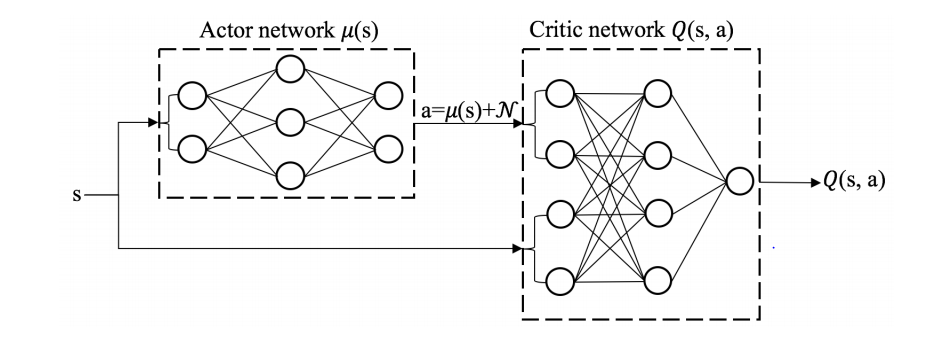

In [127]:
Image('network.PNG')

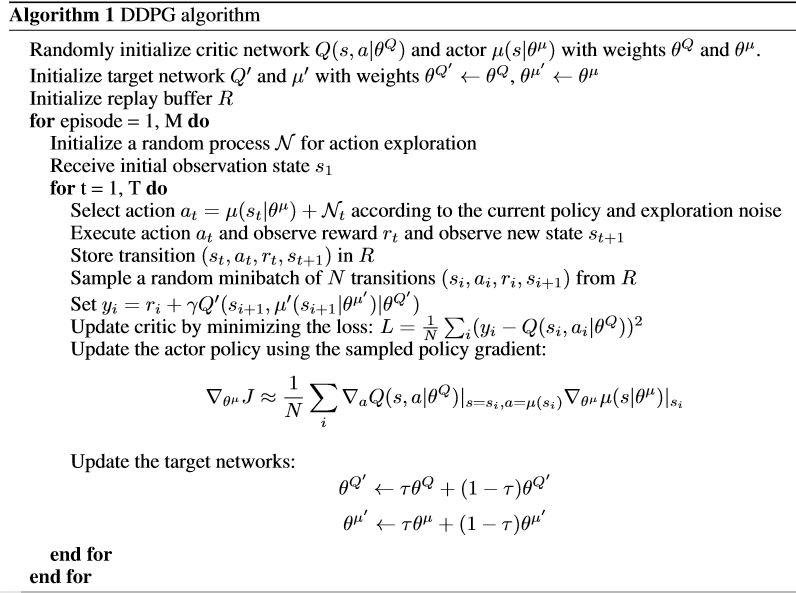

In [125]:
Image("ddpg.JPG", width=600, height=20)

DDPG maintains an actor network and a critic network. The actor network $\mu(s|\theta^{\mu})$ maps states to actions where $\theta^{\mu}$ is the set of actor network parameters, and the critic network $Q(s,a|\theta^{Q})$ outputs the value of action under that state, where $\theta^{Q}$ is the set of critic network parameters. To explore better actions, a noise is added to the output of the actor network, whick is sampled from the random process $\mathcal{N}$.

DDPG uses an experience replay buffer $\mathcal{R}$ to store transitions and update the model, and can effectively reduce the correlation between experience samples. Target actor network $Q'$ and $\mu'$ are created by copying the actor and critic networks respectively, so that they provide consistent temporal difference backups. Both networks are updated iteratively. At each time, the DDPG agent takes an action $a_t$ on $s_t$, and then receives a reward based on $s_{t+1}$. The transition $(s_t, a_t, s_{t+1}, r_t)$ is then stored in replay buffer $\mathcal{R}$. The N sample transitions are drawn from R and $y_i=r_i+\gamma Q'(s_{i+1}, \mu'(s_{i+1}|\theta^{\mu'})|\theta^{Q})$ is calculated. The critic network is then updated by minimizing the expected difference $L(\theta^Q)$ between outputs of the target critic network Q' and the critic network Q, i.e.,
$$L(\theta^Q) = \mathbb{E}_{s_t,a_t,r_t,s_{t+1}\sim \text{buffer}}[(r_t+\gamma Q'(s_{t+1},\mu(s_{t+1}|\theta^{\mu})|\theta^{Q'})-Q(s_t,a_t|\theta^Q))^2]$$
The parameters $\theta^{\mu}$ of the actor network are then as follows:
$$\triangledown_{\theta^{\mu}}J = \mathbb{E}_{s_t,a_t,r_t,s_{t+1}\sim \text{buffer}}[\triangledown_aQ(s_t, \mu(s_t)|\theta^Q)\triangledown_{\theta^{\mu}}\mu(s_t|\theta^{\mu})]$$
After the critic network and the actor network are updated by the transitions from the experience buffer, the target actor network and the target critic network are updated as follows:
$$\theta^{Q'} \leftarrow \tau\theta^Q+(1-\tau)\theta^{Q'}$$
$$\theta^{\mu'} \leftarrow \tau\theta^Q+(1-\tau)\theta^{\mu'}$$

Details see paper https://arxiv.org/pdf/1509.02971v5.pdf

# Data Process

We use the Gold Futures with 15m data as our trading stock. We split the train and test set in terms of 0.7:0.3 ratio. The reason why I choose Gold futures is because the gold price is to some extend predictable in a certain range of dates. This is because the price of gold is highly related to the fundamental properties of the financial market rather than the highly-frequent market behaviours. We set the window_size = 30, so we use the 'close-volume' pair to in the past 30 days to obtain the current optimal movement. Our goal is to maximize the profit in a period of two weeks.

In [2]:
Gold = pd.read_csv('data/Gold_15m.csv')


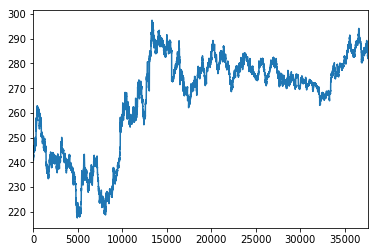

In [3]:
Gold['Close'].plot()

# Main Structure

This section gives the prototype of the code. The code structure follows from https://github.com/yanpanlau/DDPG-Keras-Torcs and https://github.com/philipshurpik/deep-reinforcement-trader

We use the following architectures:
* CNN with 2 convolutional layers with max pooling; choose scaled tanh as the output classifier.
* Choose the exploration noise $\mathcal{N}$ to follow from the Ornsten-Uhlenbeck process $$dx_t = \theta(\mu-x_t)dt+\sigma dW_t$$ This is a reasonable choice because the OU process somehow allows us to controll the randomness not too far away from the $\mu$.
* In order to make our optimal policy close to the global optimum, during train section, I want our model to see as many patterns as possible. Thus, in each eposide I randomly choose a period of 2 weeks from the 3-year period of our training set. 

### Performance Assessment
* We are going to compare the trading strategy learnt from the data with the simple buy&hold strategy. When the buy&hold gives a positive value, we know our trading strategy is encouraged to long the position, and vice versa. This comparision is useful because we do not need to wait for all of our 5000 epochs finished to assess the performence, while we can easily see whether our trading strategy starts to converge to the optimal one during the training part.

* Finally, we are going to run our trading strategy 100 times on the random 2-week period obtained from the testing set to see if the average profit is higher than the buy&hold strategy.
* This comparision can assess our trading strategy's ability to capture the trend in microscope.

In [4]:
DECIMAL_SIGNS = 6
rnd = lambda x: round(x, DECIMAL_SIGNS)


class MarketEnv(gym.Env):
    COMMISSION = 0.00015

    def __init__(self, csv_name, window_size, save_folder, initial_cash=100,
                 date_columns=["Date_Time"], index_column="Date_Time", start_date=None, verbose=0):
        self.simulator = Simulator(csv_name=csv_name, date_columns=date_columns, index_column=index_column,
                                   start_date=start_date, window_size=window_size)
        self.verbose = verbose
        self.train_mode = True
        self.window_size = window_size
        self.features_number = self.simulator.features_number
        self.action_space = spaces.Box(-1, +1, (1,), dtype=np.float32)
        high = np.ones((self.features_number, window_size, 1)) if self.features_number > 1 else np.ones(window_size)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)
        self.initial_cash = initial_cash
        self.remaining_cash_value = initial_cash
        self.max_cash_value = initial_cash
        self.max_draw_down = 0
        self.position_value = 0
        self.position_size = 0
        self.actual_reward = 0
        self.journal = []
        self.actions_journal = []
        self.train_stats = Stats(os.path.join(save_folder, "ddpg_train_stats.csv"))
        self.test_stats = Stats(os.path.join(save_folder, "ddpg_test_stats.csv"))
        self.reset()

    def seed(self, seed=None):
        np.random.seed(seed)
        self.simulator.seed(seed)

    def step(self, action):
        total_cash = self.remaining_cash_value + self.position_value
        make_action = abs(self.position_value/total_cash - action[0]) > 0.3
        return self._make_step([action[0], 1 if make_action else -1])

    def _make_step(self, action):
        sim_state, done = self.simulator.step()
        close_price = self.simulator.data.iloc[self.simulator.current_index]["Close"]
        date = self.simulator.date_time[self.simulator.current_index]
        action_meta = self._calculate_step(action=action, close_price=close_price, position_size=self.position_size,
                                           position_value=self.position_value, remaining_cash=self.remaining_cash_value)
        self.execute_action(action_meta, close_price, date)
        self.actions_journal.append(action)
        self.remaining_cash_value = action_meta["remaining_cash"]
        self.position_value = action_meta["value"]
        self.position_size = action_meta["size"]
        self.max_cash_value = max(action_meta["total_cash"], self.max_cash_value)
        self.max_draw_down = max((1 - action_meta["total_cash"] / self.max_cash_value), self.max_draw_down)
        self.actual_reward = self.actual_reward + action_meta["reward"]
        no_action_trigger = (self.simulator.step_number > self.simulator.episode_duration/10) and len(self.journal) == 0
        no_action_penalty = self.initial_cash * 0.001 if no_action_trigger else 0

        active_actions = np.array(self.actions_journal)[np.array(self.actions_journal)[:, 1] > 0] if len(self.actions_journal) > 0 else np.array([[[]]])
        long_actions = len(active_actions[active_actions[:, 0] > 0])
        short_actions = len(active_actions[active_actions[:, 0] < 0])
        no_short_or_long_trigger = (self.simulator.step_number > self.simulator.episode_duration/1.5) and (short_actions == 0 or long_actions == 0)
        no_short_or_long_penalty = self.initial_cash * 0.001 if no_short_or_long_trigger else 0

        step_reward = action_meta["reward"] - no_action_penalty - no_short_or_long_penalty

        if self.max_draw_down > 0.50:
            done = True
            step_reward -= 0.1 * self.initial_cash * self.simulator.episode_duration / self.simulator.step_number
            print("Exceed maximum drawdown: Max cash %.2f | Current cash: %.2f" % (self.max_cash_value, action_meta["total_cash"]))

        # env_state = self._get_env_state(reward=step_reward, action=action)
        all_state = self._reshape(sim_state)
        return all_state, step_reward, done, {"date": self.simulator.date_time[self.simulator.current_index]}

    def reset(self):
        self.remaining_cash_value = self.initial_cash
        self.max_cash_value = self.initial_cash
        self.max_draw_down = 0
        self.position_value = 0
        self.position_size = 0
        self.actual_reward = 0
        self.journal = []
        self.actions_journal = []

        # env_state = self._get_env_state(0, [0, 0])
        sim_state, done = self.simulator.reset(train_mode=self.train_mode)
        return self._reshape(sim_state)   # [env_state, sim_state]

    def _reshape(self, state):
        return state.reshape(-1, self.features_number, self.window_size, 1) if self.features_number > 1 \
            else state.reshape(self.window_size)

    def _get_env_state(self, reward, action):
        total_cash = self.remaining_cash_value - self.position_value
        position = 1 if self.position_value > 0 else 0
        return np.array([total_cash, self.remaining_cash_value, position]).reshape(-1, 3)

    def _calculate_step(self, action, close_price, position_value, position_size, remaining_cash):
        # Use tanh to define action value from -1 (short) to 1 (long)
        action_amount = min(1, max(-1, action[0]))
        # Use sigmoid to define how sure are we to make trade: -1..0 - no trade, 0..1 - make trade
        hold = action[1] < 0
        hold_data = self._calculate_step_hold(close_price, position_value, position_size, remaining_cash)
        if hold:
            return hold_data
        else:
            return self._calculate_step_position(action_amount, close_price, hold_data)

    @staticmethod
    def _calculate_step_hold(close_price, position_value, position_size, remaining_cash):
        if position_size > 0:
            new_position_value = position_size * close_price
            step_reward = new_position_value - position_value
        elif position_size < 0:
            new_position_value = position_size * close_price  # -7 = -2 * 3.5
            step_reward = new_position_value - position_value  # -1 = -7 - -6
        else:
            new_position_value = position_value
            step_reward = 0
        return {
            "value": rnd(new_position_value),
            "value_diff": rnd(new_position_value - position_value),
            "size": rnd(position_size),
            "size_diff": 0,
            "remaining_cash": rnd(remaining_cash),
            "reward": rnd(step_reward),
            "total_cash": rnd(remaining_cash + new_position_value)
        }

    @staticmethod
    def _calculate_step_position(action_amount, close_price, hold_data):
        hold_value, hold_size, hold_remaining, hold_total, hold_reward = \
            hold_data["value"], hold_data["size"], hold_data["remaining_cash"], hold_data["total_cash"], hold_data["reward"]

        value_wo_comission = hold_total * action_amount
        value_wo_comission_diff = value_wo_comission - hold_value
        value_diff = value_wo_comission_diff / (1 + MarketEnv.COMMISSION)
        size_diff = value_diff / close_price

        value = hold_value + value_diff
        size = hold_size + size_diff

        commission = abs(value_diff - value_wo_comission_diff)
        remaining_cash = hold_remaining - value_diff - commission
        total_cash = hold_total - commission
        total_step_reward = hold_reward - commission

        if math.isnan(rnd(value)) or math.isnan(rnd(value_diff)) or math.isnan(rnd(size)) or math.isnan(rnd(size_diff)) or math.isnan(rnd(remaining_cash)) or math.isnan(rnd(total_cash)) or math.isnan(rnd(total_step_reward)):
            print("\n\n\n\n\nlalala is nan\n\n\n\n\n")

        return {
            "value": rnd(value),
            "value_diff": rnd(value_diff),
            "size": rnd(size),
            "size_diff": rnd(size_diff),
            "remaining_cash": rnd(remaining_cash),
            "total_cash": rnd(total_cash),
            "reward": rnd(total_step_reward)
        }

    def execute_action(self, action_meta, price, date):
        if action_meta["size_diff"] != 0:
            self.journal.append((date, price, action_meta))
        if not self.verbose:
            return
        if action_meta["size_diff"] != 0:
            order_type = "Buy " if action_meta["size_diff"] > 0 else "Sell"
            print("%s | %s | Reward: %.6f | Size: %.4f %s | Price: %.4f | Position value: %.4f | Position size: %.4f | Total cash: %.6f" %
                  (date, order_type, action_meta["reward"], action_meta["size_diff"], self.simulator.stock_name, price, action_meta["value"],
                   action_meta["size"], action_meta["total_cash"]))
        else:
            print("%s | Hold | Reward: %.6f | Total cash: %.4f" % (date, action_meta["reward"], action_meta["total_cash"]))

    def reset_train_mode(self, train_mode):
        self.train_mode = train_mode
        return self.reset()

    def print_summary(self, epsilon=1):
        sim = self.simulator
        start_date = sim.date_time[sim.start_index]
        end_date = sim.date_time[sim.end_index]
        start_p = sim.data.loc[start_date]["Close"]
        end_p = sim.data.loc[end_date]["Close"]
        buy_hold_value = self.initial_cash * (end_p/start_p) - self.initial_cash
        train_or_test = "Train" if self.train_mode else "Test"
        total_cash = self.remaining_cash_value + self.position_value
        active_actions = np.array(self.actions_journal)[np.array(self.actions_journal)[:, 1] > 0] if len(self.actions_journal) > 0 else np.array([[[]]])
        long_actions = active_actions[active_actions[:, 0] > 0]
        short_actions = active_actions[active_actions[:, 0] < 0]
        print("%s\t\t| Start: %s\t| End: %s\t| Buy&Hold: %.4f\t| Longs: %d\t| Shorts: %d\t| Ep. Reward %.4f\t" % (sim.stock_name, start_date, end_date, buy_hold_value, len(long_actions), len(short_actions), self.actual_reward))
        print("%s\t| Epsilon: %.4f\t| Operations: %d\t| Max Drawdown: %.4f\t| Max cash: %.4f\t| Final cash: %.4f" %
              (train_or_test, epsilon, len(self.journal), self.max_draw_down, self.max_cash_value, total_cash))
        stats = self.train_stats if self.train_mode else self.test_stats
        stats.add(self.actual_reward, buy_hold_value, self.max_draw_down, epsilon, len(self.journal))
        stats.print_latest()

    def render(self, mode='human'):
        render(self.simulator.get_episode_values())


In [5]:
class Stats(object):
    def __init__(self, filename, interval=100):
        self.filename = filename
        self.interval = interval
        self.rewards = []
        self.buy_and_holds = []
        self.draw_downs = []
        self.epsilons = []
        self.operations = []
        self.mean_rewards = []
        self.mean_buy_and_holds = []
        self.mean_draw_downs = []

    def add(self, reward, buy_and_hold, draw_dawn, epsilon, operations):
        self.rewards.append(reward)
        self.buy_and_holds.append(buy_and_hold)
        self.draw_downs.append(draw_dawn)
        self.epsilons.append(epsilon)
        self.operations.append(operations)
        #
        self.mean_rewards.append(np.mean(self.rewards[-self.interval:]))
        self.mean_buy_and_holds.append(np.mean(self.buy_and_holds[-self.interval:]))
        self.mean_draw_downs.append(np.mean(self.draw_downs[-self.interval:]))
        self.save()

    def save(self):
        df = pd.DataFrame(
            data=np.array([self.epsilons, self.operations, self.rewards, self.buy_and_holds, self.draw_downs,
                           self.mean_rewards, self.mean_buy_and_holds, self.mean_draw_downs]).T,
            columns=["Epsilon", "Operations", "Rewards", "Buy and hold", "Drawdowns", "Mean Rewards", "Mean Buy and Holds", "Mean Drawdowns"]
        )
        df.to_csv(self.filename, sep=";",)

    def print_latest(self):
        r, b, d = self.mean_rewards[-1], self.mean_buy_and_holds[-1], self.mean_draw_downs[-1]
        print("Stats\t| Avg. Reward: %.4f\t| Avg. Buy&Hold: %.4f| Avg. Drawdown: %.4f" % (r, b, d))


In [6]:
class Simulator(object):
    def __init__(self, csv_name, start_date, date_columns, index_column, window_size,
                 episode_duration=480, train_split=0.6, normalize=True):
        df = pd.read_csv(csv_name)
        df = df[~np.isnan(df['Close'])].set_index(date_columns)
        if start_date is not None:
            df = df.iloc[start_date:]

        self.data = df
        self.stock_name = df.iloc[0, 0]
        self.date_time = self.data.index
        self.count = self.data.shape[0]
        self.window_size = window_size
        self.episode_train_duration = Config.data['episode_train_duration']
        self.episode_test_duration =Config.data['episode_test_duration']
        self.train_end_index = int(train_split * self.count)
        self.start_index, self.end_index = self._get_start_end_index() 
        self.current_index = self.start_index
        self.step_number = 0
        self.features_number = 2

        self.states = np.array([
            #self._normalize_column(df['Open'], normalize).values,
            #self._normalize_column(df['High'], normalize).values,
            #self._normalize_column(df['Low'], normalize).values,
            self._normalize_column(df['Close'], normalize).values,
            self._normalize_column(df['Volume'].fillna(0), normalize).values,
        ]).reshape((-1, self.features_number))
        self.reset()
        

    @staticmethod
    def seed(seed):
        np.random.seed(seed)

    def _normalize_column(self, df_column, normalize):
        column = df_column.copy().pct_change().replace(np.inf, np.nan).fillna(0)
        eps = np.finfo(np.float32).eps
        column_n = (column - np.array(column.mean())) / np.array(column.std() + eps)
        return column if not normalize else column_n

    def _get_current_window(self):
        reversed_window = self.states[(self.current_index - self.window_size): self.current_index][::-1]


        
        return reversed_window.reshape(-1, self.features_number, self.window_size, 1)

    def _get_start_end_index(self, train_mode=True):
        train_index = np.random.randint(self.window_size, self.train_end_index - self.episode_train_duration - 1)
        test_index = np.random.randint(self.train_end_index + self.window_size, self.count - self.episode_test_duration - 1)
        start_index = train_index if train_mode else test_index
        if train_mode:
            end_index = start_index + self.episode_train_duration
            self.episode_duration = self.episode_train_duration
        else:
            end_index = start_index +self.episode_test_duration
            self.episode_duration = self.episode_test_duration
        return start_index, end_index

    def reset(self, train_mode=True):
        self.start_index, self.end_index = self._get_start_end_index(train_mode)
        self.current_index = self.start_index
        self.step_number = 0
        return self._get_current_window(), False

    def step(self):
        done = True if self.current_index >= self.end_index else False
        if not done:
            self.step_number += 1
            self.current_index += 1
        return self._get_current_window(), done

    def get_episode_values(self):
        time = self.data.index[self.start_index: self.end_index].to_pydatetime().reshape(-1,1)
        values = self.data.values[self.start_index:self.end_index, 1:]
        return np.concatenate((time, values), axis=1)

In [7]:
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

def scaled_tanh(x):
    n = 0.01
    return K.tanh(2*K.tanh(n*x))


WEIGHTS_FILE = "artifacts/ddpg_2019-04-10_01-39-45_-f/actor_model_110_-12.673_-7.996.h5"


class ActorNetwork(object):
    def __init__(self, sess, save_folder, state_size, action_size, ddpg_config, model_weights=WEIGHTS_FILE):
        self.sess = sess
        self.model_weights = model_weights
        self.batch_size = ddpg_config["batch_size"]
        self.tau = ddpg_config["tau"]
        self.learning_rate = ddpg_config["learning_rate_actor"]
        self.action_size = action_size
        self.save_folder = save_folder
        K.set_session(sess)
        
        self.model, self.weights, self.state = self.create_actor_network(state_size)
        self.target_model, self.target_weights, self.target_state = self.create_actor_network(state_size)
        self.action_gradient = tf.placeholder(tf.float32, [None, action_size])
        self.params_grad = tf.gradients(self.model.output, self.weights, -self.action_gradient)
        grads = zip(self.params_grad, self.weights)
        self.optimize = tf.train.AdamOptimizer(self.learning_rate).apply_gradients(grads)
        self.sess.run(tf.global_variables_initializer())
        self.load_weights()

    def train(self, states, action_grads):
        self.sess.run(self.optimize, feed_dict={
            self.state: states,
            self.action_gradient: action_grads
        })

    def target_train(self):
        actor_weights = self.model.get_weights()
        actor_target_weights = self.target_model.get_weights()
        for i in range(len(actor_weights)):
            actor_target_weights[i] = self.tau * actor_weights[i] + (1 - self.tau) * actor_target_weights[i]
        self.target_model.set_weights(actor_target_weights)

    def create_actor_network(self, state_size):
        kernel_initializer = tf.random_uniform_initializer(-3e-3, 3e-3)
        state_input = Input(shape=state_size)
        conv_1 = Conv2D(filters=128, kernel_size=[2, 7], strides=3, activation='relu', padding='valid')(state_input)
        conv_1 = BatchNormalization()(conv_1)
        conv_2 = Conv2D(filters=128, kernel_size=[1, 5], strides=1, activation='relu', padding='valid')(conv_1)
        conv_2 = BatchNormalization()(conv_2)
        #conv_3 = Conv2D(filters=128, kernel_size=[1, 3], strides=1, activation='relu', padding='valid')(conv_2)
        conv_3 = MaxPooling2D(pool_size=(1, 2), padding='valid')(conv_2)
        conv_3 = BatchNormalization()(conv_3)
        flatten = Flatten()(conv_3)
        dense_1 = Dense(512, activation='relu')(flatten)
        dense_2 = Dense(256, activation='relu')(dense_1)
        output = Dense(self.action_size, activation='linear', kernel_initializer=kernel_initializer)(dense_2)
        model = Model(inputs=state_input, outputs=output)
        return model, model.trainable_weights, state_input

    def load_weights(self):
        try:
            self.model.load_weights(self.model_weights)
            self.target_model.load_weights(self.model_weights)
            print("Weights loaded successfully")
        except:
            print("Cannot find actor weights file")

    def save_weights(self, episode_n, avg_train, avg_test):
        filename = os.path.join(self.save_folder, "actor_model_%d_%.3f_%.3f.h5" % (episode_n, avg_train, avg_test))
        self.model.save_weights(filename)


In [8]:
WEIGHTS_FILE = 'artifacts/ddpg_2019-04-10_01-39-45_-f/critic_model_110_-12.673_-7.996.h5'

class CriticNetwork(object):
    def __init__(self, sess, save_folder, state_size, action_size, ddpg_config, model_weights=WEIGHTS_FILE):
        self.sess = sess
        self.model_weights = model_weights
        self.batch_size = ddpg_config["batch_size"]
        self.tau = ddpg_config["tau"]
        self.learning_rate = ddpg_config["learning_rate_actor"]
        self.action_size = action_size
        self.save_folder = save_folder
        K.set_session(sess)

        # Now create the model
        self.model, self.action, self.state = self.create_critic_network(state_size, action_size)
        self.target_model, self.target_action, self.target_state = self.create_critic_network(state_size, action_size)
        self.action_grads = tf.gradients(self.model.output, self.action)  # GRADIENTS for policy update
        self.sess.run(tf.global_variables_initializer())
        self.load_weights()

    def gradients(self, states, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.state: states,
            self.action: actions
        })[0]

    def target_train(self):
        critic_weights = self.model.get_weights()
        critic_target_weights = self.target_model.get_weights()
        for i in range(len(critic_weights)):
            critic_target_weights[i] = self.tau * critic_weights[i] + (1 - self.tau) * critic_target_weights[i]
        self.target_model.set_weights(critic_target_weights)

    def create_critic_network(self, state_size, action_dim):
        kernel_initializer = tf.random_uniform_initializer(-3e-3, 3e-3)
        state_input = Input(shape=state_size)
        conv_1 = Conv2D(filters=128, kernel_size=[2, 7], strides=3, activation='relu', padding='valid')(state_input)
        conv_1 = BatchNormalization()(conv_1)
        conv_2 = Conv2D(filters=128, kernel_size=[1, 5], strides=1, activation='relu', padding='valid')(conv_1)
        conv_2 = BatchNormalization()(conv_2)
        #conv_3 = Conv2D(filters=128, kernel_size=[1, 3], strides=1, activation='relu', padding='valid')(conv_2)
        conv_3 = MaxPooling2D(pool_size=(1, 2), padding='valid')(conv_2)
        conv_3 = BatchNormalization()(conv_3)
        flatten = Flatten()(conv_3)

        action_input = Input(shape=[action_dim], name='action2')
        a1 = Dense(256, activation='linear')(action_input)

        dense_1 = add([flatten, a1])
        dense_2 = Dense(256, activation='relu')(dense_1)

        output = Dense(action_dim, activation='linear', kernel_initializer=kernel_initializer)(dense_2)
        model = Model(inputs=[state_input, action_input], outputs=output)
        adam = Adam(lr=self.learning_rate)
        print(model.summary())
        model.compile(loss='mse', optimizer=adam)
        return model, action_input, state_input

    def load_weights(self):
        try:
            self.model.load_weights(self.model_weights)
            self.target_model.load_weights(self.model_weights)
            print("Weights loaded successfully")
        except:
            print("Cannot find critic weights file")

    def save_weights(self, episode_n, avg_train, avg_test):
        filename = os.path.join(self.save_folder, "critic_model_%d_%.3f_%.3f.h5" % (episode_n, avg_train, avg_test))
        self.model.save_weights(filename)


In [9]:
class DDPGAgent:
    def __init__(self, env, model_config, save_folder):
        print("DDPG Agent Started")
        np.random.seed(model_config.seed)
        self.env = env
        self.ddpg_config = model_config.ddpg
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        sess = tf.Session(config=config)
        K.set_session(sess)
        state_dim = self.env.observation_space.shape
        self.action_dim = self.env.action_space.shape[0]
        self.actor = ActorNetwork(sess, save_folder, state_dim, self.action_dim, model_config.ddpg)
        self.critic = CriticNetwork(sess, save_folder, state_dim, self.action_dim, model_config.ddpg)
        self.buff = ReplayBuffer(model_config.ddpg["buffer_size"])
        self.epsilon = 1.3

    def save_weights(self, episode_n):
        self.actor.save_weights(episode_n, avg_train=self.env.train_stats.mean_rewards[-1], avg_test=self.env.test_stats.mean_rewards[-1])
        self.critic.save_weights(episode_n, avg_train=self.env.train_stats.mean_rewards[-1], avg_test=self.env.test_stats.mean_rewards[-1])

    def train_episode(self):
        return self._play_episode(train_mode=True)

    def test_episode(self):
        return self._play_episode(train_mode=False)

    def _play_episode(self, train_mode):
        observation = self.env.reset_train_mode(train_mode)
        done = False
        total_reward = 0
        while not done:
            action = self.actor.model.predict(observation)[0]
            action[0] = max(-1, min(1, action[0]))
            noise = np.zeros(self.action_dim)
            if train_mode:
                noise[0] = max(self.epsilon, 0.1) * OU().function(x=action[0], mu=0.0, theta= 0.6, sigma=0.5)  # 0.60 = theta
            else:
                noise[0] = 0
            #print(action)
            action = action + noise
            #print(action)
            new_observation, reward, done, info = self.env.step(action)
            self.buff.add(observation, action, reward, new_observation, done)  # Add replay buffer

            # Do the batch update
            batch = self.buff.getBatch(self.ddpg_config["batch_size"])
            states = np.asarray([e[0] for e in batch]).reshape(-1, self.env.features_number, self.env.window_size, 1)
            actions = np.asarray([e[1] for e in batch])
            rewards = np.asarray([e[2] for e in batch])
            new_states = np.asarray([e[3] for e in batch]).reshape(-1, self.env.features_number, self.env.window_size, 1)
            dones = np.asarray([e[4] for e in batch])
            y_t = np.zeros_like(actions)

            actor_prediction = self.actor.target_model.predict(new_states)
            target_q_values = self.critic.target_model.predict([new_states, actor_prediction])

            for k in range(len(batch)):
                if dones[k]:
                    y_t[k] = rewards[k]
                else:
                    y_t[k] = rewards[k] + self.ddpg_config["gamma"] * target_q_values[k]

            if train_mode:
                self._train_step(states, actions, y_t)

            total_reward += reward
            observation = new_observation
        return total_reward

    def _train_step(self, states, actions, y_t):
        self.epsilon -= 1.0 / self.ddpg_config["explore"]
        self.critic.model.train_on_batch([states, actions], y_t)
        a_for_grad = self.actor.model.predict(states)
        grads = self.critic.gradients(states, a_for_grad)
        self.actor.train(states, grads)
        self.actor.target_train()
        self.critic.target_train()


In [10]:
np.random.seed(42)


class OU(object):
    def function(self, x, mu, theta, sigma):
        return theta * (mu - x) + sigma * np.random.randn(1)


In [11]:
class ReplayBuffer(object):
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.num_experiences = 0
        self.buffer = deque()

    def getBatch(self, batch_size):
        # Randomly sample batch_size examples
        if self.num_experiences < batch_size:
            return random.sample(self.buffer, self.num_experiences)
        else:
            return random.sample(self.buffer, batch_size)

    def size(self):
        return self.buffer_size

    def add(self, state, action, reward, new_state, done):
        experience = (state, action, reward, new_state, done)
        if self.num_experiences < self.buffer_size:
            self.buffer.append(experience)
            self.num_experiences += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def count(self):
        # if buffer is full, return buffer size
        # otherwise, return experience counter
        return self.num_experiences

    def erase(self):
        self.buffer = deque()
        self.num_experiences = 0


In [12]:
def render_sticks(ax, quotes, width=1000, colorup='#00FF00', colordown='#FF0000', alpha=0.8):
    for q in quotes:
        t, open, high, low, close = q[:5]
        timestamp = dates.date2num(t)

        if close >= open:
            color = colorup
            lower = open
            height = close - open
        else:
            color = colordown
            lower = close
            height = open - close

        vline = Line2D(
            xdata=(timestamp, timestamp), ydata=(low, high),
            color=color,
            linewidth=0.5,
            antialiased=True,
        )
        rect = Rectangle(
            xy=(timestamp, lower),
            width=0.5/len(quotes),
            height=height,
            facecolor=color,
            edgecolor=color,
        )
        rect.set_alpha(alpha)
        rect.set_linewidth((width * 0.8)/len(quotes))
        ax.add_line(vline)
        ax.add_patch(rect)


def render(values):
    fig, ax = plt.subplots(figsize=(20, 8))
    render_sticks(ax, values, width=20*50)
    ax.autoscale_view()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
    ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=40)
    plt.grid()
    plt.show()

In [13]:
class Runner:
    def __init__(self, model_name, verbose=0):
        save_folder = os.path.join(os.getcwd(), "artifacts", "ddpg_" + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "_" + model_name)
        os.makedirs(save_folder)
        np.random.seed(Config.seed)
        self.env = MarketEnv(csv_name=Config.data["file_name"], window_size=Config.model["window_size"], verbose=verbose, save_folder=save_folder)
        self.env.seed(Config.seed)
        self.agent = DDPGAgent(self.env, model_config=Config, save_folder=save_folder)

    def train(self):
        self.run(episodes_number=5000)

    def test(self):
        self.run(train_mode=False, episodes_number=100)

    def run(self, episodes_number, train_mode=True):
        for episode_n in range(episodes_number):
            print("**************** Episode " + str(episode_n) + " ****************")
            if train_mode:
                self.train_episode(episode_n)
            if episode_n % 10 == 0:
                print("*** Test " + str(episode_n) + " ***")
                self.test_episode()

    def train_episode(self, episode_n):
        self.agent.train_episode()
        if episode_n > 100 and episode_n % 10 == 0:
            self.agent.save_weights(episode_n)
        self.env.print_summary(epsilon=self.agent.epsilon)

    def test_episode(self):
        self.agent.test_episode()
        self.env.print_summary(epsilon=self.agent.epsilon)


### Failure of this structure
Unfortunately, the randomness of 2-week patterns during the training part not only doesn't give the globally optimal trading strategy, but also doesn't make the output policy converge to any meaningful solution. Further, in such an architecture the tanh makes our policy easilly stuck into  the values 1 or -1 in the very first several eposides, which keeps our output policy always make a long (or short) decision for all states.

In [15]:
Config = SimpleNamespace(**{
    "data": {
            "file_name": "data/Gold_15m.csv",
        "episode_train_duration": 175,
        "episode_test_duration": 175
    },
    "seed": None,
    "model": {
        "stocks_number": 1,
        "window_size": 30
    },
    "ddpg": {
        "buffer_size": 100000,
        "batch_size": 32,
        "gamma": 0.99,
        "tau": 0.001,
        "learning_rate_actor": 0.0001,
        "learning_rate_critic": 0.001,
        "explore": 1000000.
    }
})

In [16]:
model_name = sys.argv[1] if len(sys.argv) > 1 else ""
print(model_name)
verbose = sys.argv[2] == "-v" if len(sys.argv) > 2 else False
test = sys.argv[2] == "-t" if len(sys.argv) > 2 else False
runner = Runner(verbose=verbose, model_name=model_name)
if not test:
    runner.train()
else:
    runner.test()
    
    
    

-f
DDPG Agent Started
Weights loaded successfully
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 2, 30, 1)     0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 1, 8, 128)    1920        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 1, 8, 128)    512         conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 1, 4, 128)    82048       batch_normalization_7[0][0]      
___________________________________________________________

240.0		| Start: 2016-09-05 14:00:00	| End: 2016-09-12 09:15:00	| Buy&Hold: 0.3666	| Longs: 55	| Shorts: 73	| Ep. Reward -15.9701	
Train	| Epsilon: 1.2989	| Operations: 128	| Max Drawdown: 0.1597	| Max cash: 100.0000	| Final cash: 84.0299
Stats	| Avg. Reward: -15.5192	| Avg. Buy&Hold: 2.1703| Avg. Drawdown: 0.1552
**************** Episode 6 ****************
240.0		| Start: 2015-09-18 10:00:00	| End: 2015-09-25 01:00:00	| Buy&Hold: 2.0098	| Longs: 64	| Shorts: 70	| Ep. Reward -16.2472	
Train	| Epsilon: 1.2988	| Operations: 133	| Max Drawdown: 0.1625	| Max cash: 100.0000	| Final cash: 83.7528
Stats	| Avg. Reward: -15.6232	| Avg. Buy&Hold: 2.1474| Avg. Drawdown: 0.1562
**************** Episode 7 ****************
240.0		| Start: 2015-07-17 23:45:00	| End: 2015-07-24 21:15:00	| Buy&Hold: -4.3954	| Longs: 62	| Shorts: 70	| Ep. Reward -15.7006	
Train	| Epsilon: 1.2986	| Operations: 132	| Max Drawdown: 0.1570	| Max cash: 100.0000	| Final cash: 84.2994
Stats	| Avg. Reward: -15.6329	| Avg. Buy&Ho

240.0		| Start: 2015-06-03 00:45:00	| End: 2015-06-09 22:15:00	| Buy&Hold: -1.3038	| Longs: 59	| Shorts: 80	| Ep. Reward -16.4266	
Train	| Epsilon: 1.2952	| Operations: 139	| Max Drawdown: 0.1643	| Max cash: 100.0000	| Final cash: 83.5734
Stats	| Avg. Reward: -15.2504	| Avg. Buy&Hold: 0.2863| Avg. Drawdown: 0.1529
**************** Episode 27 ****************
240.0		| Start: 2015-05-08 13:45:00	| End: 2015-05-15 02:30:00	| Buy&Hold: 2.7835	| Longs: 61	| Shorts: 74	| Ep. Reward -15.6655	
Train	| Epsilon: 1.2951	| Operations: 135	| Max Drawdown: 0.1567	| Max cash: 100.0000	| Final cash: 84.3345
Stats	| Avg. Reward: -15.2652	| Avg. Buy&Hold: 0.3755| Avg. Drawdown: 0.1530
**************** Episode 28 ****************
240.0		| Start: 2016-03-30 02:15:00	| End: 2016-04-07 14:00:00	| Buy&Hold: -1.0232	| Longs: 65	| Shorts: 62	| Ep. Reward -15.3375	
Train	| Epsilon: 1.2949	| Operations: 127	| Max Drawdown: 0.1534	| Max cash: 100.0000	| Final cash: 84.6625
Stats	| Avg. Reward: -15.2677	| Avg. Buy

240.0		| Start: 2016-04-09 01:45:00	| End: 2016-04-15 23:15:00	| Buy&Hold: -0.9645	| Longs: 66	| Shorts: 68	| Ep. Reward -16.6466	
Train	| Epsilon: 1.2916	| Operations: 133	| Max Drawdown: 0.1665	| Max cash: 100.0000	| Final cash: 83.3533
Stats	| Avg. Reward: -15.1570	| Avg. Buy&Hold: 0.1562| Avg. Drawdown: 0.1519
**************** Episode 48 ****************
240.0		| Start: 2016-08-31 01:15:00	| End: 2016-09-06 22:45:00	| Buy&Hold: 1.9376	| Longs: 64	| Shorts: 73	| Ep. Reward -15.0880	
Train	| Epsilon: 1.2914	| Operations: 137	| Max Drawdown: 0.1512	| Max cash: 100.0000	| Final cash: 84.9120
Stats	| Avg. Reward: -15.1556	| Avg. Buy&Hold: 0.1925| Avg. Drawdown: 0.1518
**************** Episode 49 ****************
240.0		| Start: 2015-07-24 00:00:00	| End: 2015-07-30 21:30:00	| Buy&Hold: -0.6795	| Longs: 70	| Shorts: 77	| Ep. Reward -17.0738	
Train	| Epsilon: 1.2912	| Operations: 147	| Max Drawdown: 0.1707	| Max cash: 100.0000	| Final cash: 82.9262
Stats	| Avg. Reward: -15.1939	| Avg. Buy

240.0		| Start: 2015-07-06 14:15:00	| End: 2015-07-13 09:30:00	| Buy&Hold: -0.4021	| Longs: 60	| Shorts: 71	| Ep. Reward -12.9118	
Train	| Epsilon: 1.2879	| Operations: 130	| Max Drawdown: 0.1294	| Max cash: 100.0000	| Final cash: 87.0882
Stats	| Avg. Reward: -15.1151	| Avg. Buy&Hold: 0.0358| Avg. Drawdown: 0.1514
**************** Episode 69 ****************
240.0		| Start: 2016-05-05 01:00:00	| End: 2016-05-11 22:30:00	| Buy&Hold: -0.5544	| Longs: 61	| Shorts: 74	| Ep. Reward -17.8829	
Train	| Epsilon: 1.2877	| Operations: 135	| Max Drawdown: 0.1788	| Max cash: 100.0000	| Final cash: 82.1171
Stats	| Avg. Reward: -15.1546	| Avg. Buy&Hold: 0.0273| Avg. Drawdown: 0.1518
**************** Episode 70 ****************
240.0		| Start: 2016-07-15 00:15:00	| End: 2016-07-21 21:45:00	| Buy&Hold: -1.2491	| Longs: 67	| Shorts: 66	| Ep. Reward -16.6526	
Train	| Epsilon: 1.2875	| Operations: 133	| Max Drawdown: 0.1665	| Max cash: 100.0000	| Final cash: 83.3474
Stats	| Avg. Reward: -15.1757	| Avg. Bu

240.0		| Start: 2016-01-12 01:45:00	| End: 2016-01-18 23:15:00	| Buy&Hold: -0.7650	| Longs: 61	| Shorts: 64	| Ep. Reward -14.8758	
Train	| Epsilon: 1.2842	| Operations: 125	| Max Drawdown: 0.1488	| Max cash: 100.0000	| Final cash: 85.1242
Stats	| Avg. Reward: -15.0062	| Avg. Buy&Hold: 0.0160| Avg. Drawdown: 0.1502
**************** Episode 90 ****************
240.0		| Start: 2016-03-22 14:15:00	| End: 2016-03-29 09:30:00	| Buy&Hold: -1.9175	| Longs: 62	| Shorts: 67	| Ep. Reward -15.0266	
Train	| Epsilon: 1.2840	| Operations: 129	| Max Drawdown: 0.1503	| Max cash: 100.0000	| Final cash: 84.9734
Stats	| Avg. Reward: -15.0065	| Avg. Buy&Hold: -0.0053| Avg. Drawdown: 0.1502
*** Test 90 ***
240.0		| Start: 2017-11-25 00:00:00	| End: 2017-12-01 21:30:00	| Buy&Hold: -0.9289	| Longs: 25	| Shorts: 29	| Ep. Reward -3.5531	
Test	| Epsilon: 1.2840	| Operations: 54	| Max Drawdown: 0.0358	| Max cash: 100.0000	| Final cash: 96.4469
Stats	| Avg. Reward: -2.8154	| Avg. Buy&Hold: 0.3328| Avg. Drawdown: 0

240.0		| Start: 2015-12-10 23:15:00	| End: 2015-12-17 14:45:00	| Buy&Hold: 0.2886	| Longs: 58	| Shorts: 66	| Ep. Reward -13.9542	
Train	| Epsilon: 1.2805	| Operations: 124	| Max Drawdown: 0.1395	| Max cash: 100.0000	| Final cash: 86.0458
Stats	| Avg. Reward: -14.9779	| Avg. Buy&Hold: 0.0420| Avg. Drawdown: 0.1499
*** Test 110 ***
240.0		| Start: 2018-07-21 02:30:00	| End: 2018-07-28 00:00:00	| Buy&Hold: 0.0184	| Longs: 20	| Shorts: 24	| Ep. Reward -3.0068	
Test	| Epsilon: 1.2805	| Operations: 44	| Max Drawdown: 0.0301	| Max cash: 100.0000	| Final cash: 96.9932
Stats	| Avg. Reward: -3.0038	| Avg. Buy&Hold: 0.3632| Avg. Drawdown: 0.0303
**************** Episode 111 ****************
240.0		| Start: 2015-06-26 09:15:00	| End: 2015-07-03 00:15:00	| Buy&Hold: -0.7987	| Longs: 69	| Shorts: 59	| Ep. Reward -15.2151	
Train	| Epsilon: 1.2803	| Operations: 128	| Max Drawdown: 0.1522	| Max cash: 100.0000	| Final cash: 84.7849
Stats	| Avg. Reward: -14.9939	| Avg. Buy&Hold: 0.0340| Avg. Drawdown: 0.

240.0		| Start: 2017-08-18 09:45:00	| End: 2017-08-25 00:45:00	| Buy&Hold: -0.3214	| Longs: 21	| Shorts: 24	| Ep. Reward -2.9092	
Test	| Epsilon: 1.2769	| Operations: 45	| Max Drawdown: 0.0291	| Max cash: 100.0000	| Final cash: 97.0908
Stats	| Avg. Reward: -2.9697	| Avg. Buy&Hold: 0.2699| Avg. Drawdown: 0.0299
**************** Episode 131 ****************
240.0		| Start: 2017-03-27 14:15:00	| End: 2017-04-05 23:15:00	| Buy&Hold: -0.5504	| Longs: 64	| Shorts: 61	| Ep. Reward -13.4975	
Train	| Epsilon: 1.2768	| Operations: 125	| Max Drawdown: 0.1350	| Max cash: 100.0000	| Final cash: 86.5025
Stats	| Avg. Reward: -14.9290	| Avg. Buy&Hold: -0.0610| Avg. Drawdown: 0.1494
**************** Episode 132 ****************
240.0		| Start: 2016-05-31 22:45:00	| End: 2016-06-07 14:15:00	| Buy&Hold: 2.1802	| Longs: 76	| Shorts: 59	| Ep. Reward -15.6715	
Train	| Epsilon: 1.2766	| Operations: 135	| Max Drawdown: 0.1567	| Max cash: 100.0000	| Final cash: 84.3285
Stats	| Avg. Reward: -14.9324	| Avg. Buy&

240.0		| Start: 2015-11-18 11:30:00	| End: 2015-11-25 02:15:00	| Buy&Hold: 1.1254	| Longs: 61	| Shorts: 62	| Ep. Reward -13.0089	
Train	| Epsilon: 1.2732	| Operations: 123	| Max Drawdown: 0.1301	| Max cash: 100.0000	| Final cash: 86.9911
Stats	| Avg. Reward: -14.8951	| Avg. Buy&Hold: -0.1797| Avg. Drawdown: 0.1491
**************** Episode 152 ****************
240.0		| Start: 2017-06-20 11:00:00	| End: 2017-06-27 01:45:00	| Buy&Hold: 0.2518	| Longs: 62	| Shorts: 69	| Ep. Reward -15.1012	
Train	| Epsilon: 1.2731	| Operations: 131	| Max Drawdown: 0.1510	| Max cash: 100.0000	| Final cash: 84.8988
Stats	| Avg. Reward: -14.8996	| Avg. Buy&Hold: -0.1801| Avg. Drawdown: 0.1491
**************** Episode 153 ****************
240.0		| Start: 2015-09-10 01:45:00	| End: 2015-09-16 23:15:00	| Buy&Hold: 1.2644	| Longs: 71	| Shorts: 56	| Ep. Reward -14.3805	
Train	| Epsilon: 1.2729	| Operations: 127	| Max Drawdown: 0.1438	| Max cash: 100.0000	| Final cash: 85.6195
Stats	| Avg. Reward: -14.9021	| Avg. B

240.0		| Start: 2017-03-09 21:30:00	| End: 2017-03-16 11:00:00	| Buy&Hold: 1.2070	| Longs: 58	| Shorts: 65	| Ep. Reward -13.6754	
Train	| Epsilon: 1.2696	| Operations: 123	| Max Drawdown: 0.1368	| Max cash: 100.0000	| Final cash: 86.3246
Stats	| Avg. Reward: -14.9117	| Avg. Buy&Hold: -0.0359| Avg. Drawdown: 0.1492
**************** Episode 173 ****************
240.0		| Start: 2017-02-08 02:30:00	| End: 2017-02-15 00:00:00	| Buy&Hold: -0.8487	| Longs: 51	| Shorts: 68	| Ep. Reward -14.0144	
Train	| Epsilon: 1.2694	| Operations: 119	| Max Drawdown: 0.1401	| Max cash: 100.0000	| Final cash: 85.9856
Stats	| Avg. Reward: -14.9217	| Avg. Buy&Hold: -0.0274| Avg. Drawdown: 0.1493
**************** Episode 174 ****************
240.0		| Start: 2017-01-25 01:00:00	| End: 2017-02-08 10:45:00	| Buy&Hold: 1.9698	| Longs: 61	| Shorts: 64	| Ep. Reward -15.4785	
Train	| Epsilon: 1.2692	| Operations: 124	| Max Drawdown: 0.1549	| Max cash: 100.0000	| Final cash: 84.5215
Stats	| Avg. Reward: -14.9195	| Avg. 

240.0		| Start: 2015-09-02 22:15:00	| End: 2015-09-11 13:45:00	| Buy&Hold: -2.6249	| Longs: 58	| Shorts: 75	| Ep. Reward -17.1426	
Train	| Epsilon: 1.2659	| Operations: 133	| Max Drawdown: 0.1714	| Max cash: 100.0000	| Final cash: 82.8574
Stats	| Avg. Reward: -14.8986	| Avg. Buy&Hold: 0.1545| Avg. Drawdown: 0.1492
**************** Episode 194 ****************
240.0		| Start: 2017-06-28 14:45:00	| End: 2017-07-05 10:00:00	| Buy&Hold: -2.0796	| Longs: 52	| Shorts: 66	| Ep. Reward -13.6620	
Train	| Epsilon: 1.2657	| Operations: 118	| Max Drawdown: 0.1366	| Max cash: 100.0000	| Final cash: 86.3380
Stats	| Avg. Reward: -14.8799	| Avg. Buy&Hold: 0.1193| Avg. Drawdown: 0.1490
**************** Episode 195 ****************
240.0		| Start: 2015-10-13 21:30:00	| End: 2015-10-20 11:00:00	| Buy&Hold: 0.4832	| Longs: 50	| Shorts: 78	| Ep. Reward -14.2863	
Train	| Epsilon: 1.2655	| Operations: 128	| Max Drawdown: 0.1429	| Max cash: 100.0000	| Final cash: 85.7137
Stats	| Avg. Reward: -14.8757	| Avg. B

240.0		| Start: 2016-03-16 01:30:00	| End: 2016-03-22 23:00:00	| Buy&Hold: 1.5898	| Longs: 56	| Shorts: 67	| Ep. Reward -15.3573	
Train	| Epsilon: 1.2622	| Operations: 123	| Max Drawdown: 0.1536	| Max cash: 100.0000	| Final cash: 84.6427
Stats	| Avg. Reward: -14.9185	| Avg. Buy&Hold: 0.1384| Avg. Drawdown: 0.1493
**************** Episode 215 ****************
240.0		| Start: 2017-02-17 00:45:00	| End: 2017-02-23 22:15:00	| Buy&Hold: 0.7205	| Longs: 54	| Shorts: 76	| Ep. Reward -16.2363	
Train	| Epsilon: 1.2620	| Operations: 130	| Max Drawdown: 0.1624	| Max cash: 100.0000	| Final cash: 83.7637
Stats	| Avg. Reward: -14.9199	| Avg. Buy&Hold: 0.1399| Avg. Drawdown: 0.1493
**************** Episode 216 ****************
240.0		| Start: 2015-03-19 23:30:00	| End: 2015-03-26 15:00:00	| Buy&Hold: 2.8246	| Longs: 48	| Shorts: 78	| Ep. Reward -15.0566	
Train	| Epsilon: 1.2618	| Operations: 126	| Max Drawdown: 0.1506	| Max cash: 100.0000	| Final cash: 84.9434
Stats	| Avg. Reward: -14.9208	| Avg. Buy

240.0		| Start: 2017-07-05 22:30:00	| End: 2017-07-12 14:00:00	| Buy&Hold: -0.3672	| Longs: 77	| Shorts: 57	| Ep. Reward -15.8067	
Train	| Epsilon: 1.2585	| Operations: 134	| Max Drawdown: 0.1581	| Max cash: 100.0000	| Final cash: 84.1933
Stats	| Avg. Reward: -14.7754	| Avg. Buy&Hold: 0.1878| Avg. Drawdown: 0.1478
**************** Episode 236 ****************
240.0		| Start: 2015-07-03 13:45:00	| End: 2015-07-10 02:30:00	| Buy&Hold: -0.6135	| Longs: 68	| Shorts: 60	| Ep. Reward -13.2122	
Train	| Epsilon: 1.2583	| Operations: 128	| Max Drawdown: 0.1321	| Max cash: 100.0000	| Final cash: 86.7878
Stats	| Avg. Reward: -14.7520	| Avg. Buy&Hold: 0.1634| Avg. Drawdown: 0.1476
**************** Episode 237 ****************
240.0		| Start: 2015-05-13 15:00:00	| End: 2015-05-20 10:15:00	| Buy&Hold: 1.0301	| Longs: 58	| Shorts: 65	| Ep. Reward -12.5492	
Train	| Epsilon: 1.2581	| Operations: 123	| Max Drawdown: 0.1255	| Max cash: 100.0000	| Final cash: 87.4508
Stats	| Avg. Reward: -14.7307	| Avg. B

240.0		| Start: 2016-01-16 02:30:00	| End: 2016-01-23 00:00:00	| Buy&Hold: 0.8562	| Longs: 80	| Shorts: 57	| Ep. Reward -16.4126	
Train	| Epsilon: 1.2548	| Operations: 136	| Max Drawdown: 0.1641	| Max cash: 100.0000	| Final cash: 83.5874
Stats	| Avg. Reward: -14.7446	| Avg. Buy&Hold: 0.1989| Avg. Drawdown: 0.1475
**************** Episode 257 ****************
240.0		| Start: 2017-04-14 21:30:00	| End: 2017-04-21 11:00:00	| Buy&Hold: -1.1767	| Longs: 70	| Shorts: 62	| Ep. Reward -13.6394	
Train	| Epsilon: 1.2546	| Operations: 131	| Max Drawdown: 0.1364	| Max cash: 100.0000	| Final cash: 86.3606
Stats	| Avg. Reward: -14.7231	| Avg. Buy&Hold: 0.1640| Avg. Drawdown: 0.1473
**************** Episode 258 ****************
240.0		| Start: 2015-05-28 11:15:00	| End: 2015-06-04 02:00:00	| Buy&Hold: -0.4773	| Longs: 77	| Shorts: 53	| Ep. Reward -14.3712	
Train	| Epsilon: 1.2544	| Operations: 130	| Max Drawdown: 0.1437	| Max cash: 100.0000	| Final cash: 85.6288
Stats	| Avg. Reward: -14.7037	| Avg. B

240.0		| Start: 2016-02-04 22:45:00	| End: 2016-02-19 01:45:00	| Buy&Hold: 4.6805	| Longs: 51	| Shorts: 76	| Ep. Reward -14.5895	
Train	| Epsilon: 1.2511	| Operations: 126	| Max Drawdown: 0.1459	| Max cash: 100.0000	| Final cash: 85.4105
Stats	| Avg. Reward: -14.6300	| Avg. Buy&Hold: 0.1644| Avg. Drawdown: 0.1464
**************** Episode 278 ****************
240.0		| Start: 2015-09-16 22:15:00	| End: 2015-09-23 13:45:00	| Buy&Hold: 0.4959	| Longs: 61	| Shorts: 67	| Ep. Reward -15.0722	
Train	| Epsilon: 1.2509	| Operations: 128	| Max Drawdown: 0.1507	| Max cash: 100.0000	| Final cash: 84.9278
Stats	| Avg. Reward: -14.6352	| Avg. Buy&Hold: 0.1721| Avg. Drawdown: 0.1465
**************** Episode 279 ****************
240.0		| Start: 2016-08-11 22:00:00	| End: 2016-08-18 11:30:00	| Buy&Hold: 0.1729	| Longs: 59	| Shorts: 60	| Ep. Reward -13.4319	
Train	| Epsilon: 1.2507	| Operations: 119	| Max Drawdown: 0.1343	| Max cash: 100.0000	| Final cash: 86.5681
Stats	| Avg. Reward: -14.6388	| Avg. Buy

240.0		| Start: 2015-11-04 13:45:00	| End: 2015-11-11 02:30:00	| Buy&Hold: -2.2232	| Longs: 61	| Shorts: 73	| Ep. Reward -14.2485	
Train	| Epsilon: 1.2474	| Operations: 134	| Max Drawdown: 0.1425	| Max cash: 100.0000	| Final cash: 85.7515
Stats	| Avg. Reward: -14.7140	| Avg. Buy&Hold: 0.1634| Avg. Drawdown: 0.1472
**************** Episode 299 ****************
240.0		| Start: 2015-09-16 00:30:00	| End: 2015-09-22 22:00:00	| Buy&Hold: 1.6598	| Longs: 62	| Shorts: 70	| Ep. Reward -15.9293	
Train	| Epsilon: 1.2472	| Operations: 132	| Max Drawdown: 0.1625	| Max cash: 100.0000	| Final cash: 84.0707
Stats	| Avg. Reward: -14.7144	| Avg. Buy&Hold: 0.1816| Avg. Drawdown: 0.1473
**************** Episode 300 ****************
240.0		| Start: 2015-11-27 09:30:00	| End: 2015-12-04 00:30:00	| Buy&Hold: -1.1412	| Longs: 72	| Shorts: 59	| Ep. Reward -16.7564	
Train	| Epsilon: 1.2470	| Operations: 131	| Max Drawdown: 0.1676	| Max cash: 100.0000	| Final cash: 83.2436
Stats	| Avg. Reward: -14.7555	| Avg. B

240.0		| Start: 2015-10-14 01:30:00	| End: 2015-10-20 23:00:00	| Buy&Hold: 1.1333	| Longs: 46	| Shorts: 76	| Ep. Reward -13.5195	
Train	| Epsilon: 1.2437	| Operations: 122	| Max Drawdown: 0.1352	| Max cash: 100.0000	| Final cash: 86.4805
Stats	| Avg. Reward: -14.6477	| Avg. Buy&Hold: 0.1242| Avg. Drawdown: 0.1466
**************** Episode 320 ****************
240.0		| Start: 2015-01-13 14:30:00	| End: 2015-01-20 09:45:00	| Buy&Hold: 3.5793	| Longs: 49	| Shorts: 73	| Ep. Reward -12.9912	
Train	| Epsilon: 1.2435	| Operations: 122	| Max Drawdown: 0.1299	| Max cash: 100.0000	| Final cash: 87.0088
Stats	| Avg. Reward: -14.6468	| Avg. Buy&Hold: 0.1739| Avg. Drawdown: 0.1466
*** Test 320 ***
240.0		| Start: 2019-01-18 14:15:00	| End: 2019-01-25 09:30:00	| Buy&Hold: -0.7885	| Longs: 43	| Shorts: 42	| Ep. Reward -7.3048	
Test	| Epsilon: 1.2435	| Operations: 85	| Max Drawdown: 0.0730	| Max cash: 100.0000	| Final cash: 92.6952
Stats	| Avg. Reward: -4.0892	| Avg. Buy&Hold: 0.0651| Avg. Drawdown: 0.

240.0		| Start: 2016-05-31 23:45:00	| End: 2016-06-07 21:15:00	| Buy&Hold: 2.0294	| Longs: 56	| Shorts: 68	| Ep. Reward -15.1702	
Train	| Epsilon: 1.2400	| Operations: 124	| Max Drawdown: 0.1523	| Max cash: 100.0000	| Final cash: 84.8298
Stats	| Avg. Reward: -14.7137	| Avg. Buy&Hold: 0.2037| Avg. Drawdown: 0.1473
*** Test 340 ***
240.0		| Start: 2018-06-22 02:00:00	| End: 2018-06-28 23:30:00	| Buy&Hold: 0.4440	| Longs: 23	| Shorts: 78	| Ep. Reward -9.6478	
Test	| Epsilon: 1.2400	| Operations: 101	| Max Drawdown: 0.0965	| Max cash: 100.0000	| Final cash: 90.3522
Stats	| Avg. Reward: -4.4182	| Avg. Buy&Hold: 0.0433| Avg. Drawdown: 0.0447
**************** Episode 341 ****************
240.0		| Start: 2015-07-03 09:45:00	| End: 2015-07-10 00:45:00	| Buy&Hold: -0.5287	| Longs: 58	| Shorts: 80	| Ep. Reward -16.4457	
Train	| Epsilon: 1.2398	| Operations: 138	| Max Drawdown: 0.1645	| Max cash: 100.0000	| Final cash: 83.5543
Stats	| Avg. Reward: -14.7217	| Avg. Buy&Hold: 0.2090| Avg. Drawdown: 0

240.0		| Start: 2019-02-15 00:30:00	| End: 2019-02-21 22:00:00	| Buy&Hold: 0.9875	| Longs: 10	| Shorts: 60	| Ep. Reward -6.0528	
Test	| Epsilon: 1.2365	| Operations: 70	| Max Drawdown: 0.0613	| Max cash: 100.0000	| Final cash: 93.9472
Stats	| Avg. Reward: -4.5868	| Avg. Buy&Hold: 0.0740| Avg. Drawdown: 0.0463
**************** Episode 361 ****************
240.0		| Start: 2016-01-28 01:00:00	| End: 2016-02-03 22:30:00	| Buy&Hold: 0.9623	| Longs: 54	| Shorts: 87	| Ep. Reward -16.0836	
Train	| Epsilon: 1.2363	| Operations: 141	| Max Drawdown: 0.1608	| Max cash: 100.0000	| Final cash: 83.9164
Stats	| Avg. Reward: -14.7902	| Avg. Buy&Hold: 0.3223| Avg. Drawdown: 0.1481
**************** Episode 362 ****************
240.0		| Start: 2016-04-18 14:45:00	| End: 2016-04-25 10:00:00	| Buy&Hold: 0.1939	| Longs: 56	| Shorts: 63	| Ep. Reward -13.7161	
Train	| Epsilon: 1.2361	| Operations: 119	| Max Drawdown: 0.1372	| Max cash: 100.0000	| Final cash: 86.2839
Stats	| Avg. Reward: -14.7759	| Avg. Buy&Hol

240.0		| Start: 2017-05-09 01:15:00	| End: 2017-05-15 22:45:00	| Buy&Hold: 0.4488	| Longs: 49	| Shorts: 77	| Ep. Reward -13.7865	
Train	| Epsilon: 1.2328	| Operations: 126	| Max Drawdown: 0.1379	| Max cash: 100.0000	| Final cash: 86.2135
Stats	| Avg. Reward: -14.8339	| Avg. Buy&Hold: 0.3278| Avg. Drawdown: 0.1486
**************** Episode 382 ****************
240.0		| Start: 2015-01-20 11:00:00	| End: 2015-01-27 01:45:00	| Buy&Hold: 0.7568	| Longs: 53	| Shorts: 62	| Ep. Reward -11.5461	
Train	| Epsilon: 1.2326	| Operations: 115	| Max Drawdown: 0.1155	| Max cash: 100.0000	| Final cash: 88.4539
Stats	| Avg. Reward: -14.8062	| Avg. Buy&Hold: 0.2930| Avg. Drawdown: 0.1483
**************** Episode 383 ****************
240.0		| Start: 2015-04-15 00:00:00	| End: 2015-04-21 21:30:00	| Buy&Hold: -0.2493	| Longs: 67	| Shorts: 74	| Ep. Reward -17.1172	
Train	| Epsilon: 1.2324	| Operations: 141	| Max Drawdown: 0.1725	| Max cash: 100.0000	| Final cash: 82.8828
Stats	| Avg. Reward: -14.8173	| Avg. Bu

240.0		| Start: 2017-05-08 15:00:00	| End: 2017-05-15 10:15:00	| Buy&Hold: 0.0359	| Longs: 47	| Shorts: 87	| Ep. Reward -15.3737	
Train	| Epsilon: 1.2291	| Operations: 134	| Max Drawdown: 0.1537	| Max cash: 100.0000	| Final cash: 84.6263
Stats	| Avg. Reward: -14.8887	| Avg. Buy&Hold: 0.1052| Avg. Drawdown: 0.1492
**************** Episode 403 ****************
240.0		| Start: 2016-03-09 22:15:00	| End: 2016-03-16 13:45:00	| Buy&Hold: -1.4647	| Longs: 44	| Shorts: 80	| Ep. Reward -13.0969	
Train	| Epsilon: 1.2289	| Operations: 124	| Max Drawdown: 0.1310	| Max cash: 100.0000	| Final cash: 86.9031
Stats	| Avg. Reward: -14.8692	| Avg. Buy&Hold: 0.0923| Avg. Drawdown: 0.1490
**************** Episode 404 ****************
240.0		| Start: 2015-03-25 14:00:00	| End: 2015-04-01 09:15:00	| Buy&Hold: -1.0367	| Longs: 53	| Shorts: 77	| Ep. Reward -14.2875	
Train	| Epsilon: 1.2287	| Operations: 129	| Max Drawdown: 0.1429	| Max cash: 100.0000	| Final cash: 85.7125
Stats	| Avg. Reward: -14.8684	| Avg. B

240.0		| Start: 2015-07-28 23:00:00	| End: 2015-08-04 14:30:00	| Buy&Hold: -1.0598	| Longs: 48	| Shorts: 75	| Ep. Reward -13.4731	
Train	| Epsilon: 1.2254	| Operations: 123	| Max Drawdown: 0.1347	| Max cash: 100.0000	| Final cash: 86.5269
Stats	| Avg. Reward: -14.8562	| Avg. Buy&Hold: -0.0272| Avg. Drawdown: 0.1489
**************** Episode 424 ****************
240.0		| Start: 2015-03-23 09:15:00	| End: 2015-03-28 00:15:00	| Buy&Hold: 1.0217	| Longs: 44	| Shorts: 78	| Ep. Reward -14.0477	
Train	| Epsilon: 1.2252	| Operations: 122	| Max Drawdown: 0.1405	| Max cash: 100.0000	| Final cash: 85.9523
Stats	| Avg. Reward: -14.8718	| Avg. Buy&Hold: -0.0187| Avg. Drawdown: 0.1491
**************** Episode 425 ****************
240.0		| Start: 2016-03-07 15:00:00	| End: 2016-03-14 10:15:00	| Buy&Hold: -0.9411	| Longs: 41	| Shorts: 86	| Ep. Reward -14.5379	
Train	| Epsilon: 1.2250	| Operations: 127	| Max Drawdown: 0.1454	| Max cash: 100.0000	| Final cash: 85.4621
Stats	| Avg. Reward: -14.8764	| Avg.

240.0		| Start: 2017-01-16 23:30:00	| End: 2017-01-23 15:00:00	| Buy&Hold: -0.0183	| Longs: 45	| Shorts: 79	| Ep. Reward -13.6467	
Train	| Epsilon: 1.2217	| Operations: 124	| Max Drawdown: 0.1379	| Max cash: 100.0000	| Final cash: 86.3533
Stats	| Avg. Reward: -14.7283	| Avg. Buy&Hold: -0.1279| Avg. Drawdown: 0.1476
**************** Episode 445 ****************
240.0		| Start: 2016-08-10 11:00:00	| End: 2016-08-17 01:45:00	| Buy&Hold: -0.2933	| Longs: 45	| Shorts: 77	| Ep. Reward -13.7222	
Train	| Epsilon: 1.2215	| Operations: 122	| Max Drawdown: 0.1372	| Max cash: 100.0000	| Final cash: 86.2778
Stats	| Avg. Reward: -14.6988	| Avg. Buy&Hold: -0.1103| Avg. Drawdown: 0.1473
**************** Episode 446 ****************
240.0		| Start: 2016-01-18 22:00:00	| End: 2016-01-25 11:30:00	| Buy&Hold: 1.0285	| Longs: 34	| Shorts: 84	| Ep. Reward -13.0430	
Train	| Epsilon: 1.2213	| Operations: 118	| Max Drawdown: 0.1304	| Max cash: 100.0000	| Final cash: 86.9570
Stats	| Avg. Reward: -14.7024	| Avg.

240.0		| Start: 2016-02-16 01:30:00	| End: 2016-02-22 23:00:00	| Buy&Hold: 0.5115	| Longs: 64	| Shorts: 72	| Ep. Reward -14.6069	
Train	| Epsilon: 1.2180	| Operations: 136	| Max Drawdown: 0.1477	| Max cash: 100.1908	| Final cash: 85.3931
Stats	| Avg. Reward: -14.6389	| Avg. Buy&Hold: -0.1893| Avg. Drawdown: 0.1467
**************** Episode 466 ****************
240.0		| Start: 2016-04-27 22:45:00	| End: 2016-05-06 01:45:00	| Buy&Hold: 2.7969	| Longs: 58	| Shorts: 65	| Ep. Reward -11.9329	
Train	| Epsilon: 1.2178	| Operations: 122	| Max Drawdown: 0.1193	| Max cash: 100.0000	| Final cash: 88.0671
Stats	| Avg. Reward: -14.6279	| Avg. Buy&Hold: -0.1589| Avg. Drawdown: 0.1466
**************** Episode 467 ****************
240.0		| Start: 2017-03-24 11:30:00	| End: 2017-03-31 02:15:00	| Buy&Hold: 0.1433	| Longs: 47	| Shorts: 75	| Ep. Reward -13.9937	
Train	| Epsilon: 1.2176	| Operations: 121	| Max Drawdown: 0.1399	| Max cash: 100.0000	| Final cash: 86.0063
Stats	| Avg. Reward: -14.6210	| Avg. B

240.0		| Start: 2016-06-24 09:30:00	| End: 2016-07-01 00:30:00	| Buy&Hold: 4.7048	| Longs: 50	| Shorts: 85	| Ep. Reward -16.0178	
Train	| Epsilon: 1.2143	| Operations: 135	| Max Drawdown: 0.1608	| Max cash: 100.0745	| Final cash: 83.9822
Stats	| Avg. Reward: -14.5217	| Avg. Buy&Hold: -0.2431| Avg. Drawdown: 0.1455
**************** Episode 487 ****************
240.0		| Start: 2015-10-13 10:00:00	| End: 2015-10-20 01:00:00	| Buy&Hold: 1.3742	| Longs: 72	| Shorts: 62	| Ep. Reward -16.4877	
Train	| Epsilon: 1.2141	| Operations: 133	| Max Drawdown: 0.1649	| Max cash: 100.0000	| Final cash: 83.5123
Stats	| Avg. Reward: -14.5399	| Avg. Buy&Hold: -0.2225| Avg. Drawdown: 0.1457
**************** Episode 488 ****************
240.0		| Start: 2015-08-18 22:00:00	| End: 2015-08-25 11:30:00	| Buy&Hold: 4.2461	| Longs: 67	| Shorts: 66	| Ep. Reward -13.5217	
Train	| Epsilon: 1.2139	| Operations: 131	| Max Drawdown: 0.1352	| Max cash: 100.0000	| Final cash: 86.4783
Stats	| Avg. Reward: -14.5266	| Avg. B

240.0		| Start: 2015-06-26 10:45:00	| End: 2015-07-03 01:30:00	| Buy&Hold: -0.7568	| Longs: 56	| Shorts: 72	| Ep. Reward -15.2782	
Train	| Epsilon: 1.2106	| Operations: 128	| Max Drawdown: 0.1528	| Max cash: 100.0000	| Final cash: 84.7218
Stats	| Avg. Reward: -14.5393	| Avg. Buy&Hold: -0.0460| Avg. Drawdown: 0.1456
**************** Episode 508 ****************
240.0		| Start: 2016-06-02 01:15:00	| End: 2016-06-13 11:00:00	| Buy&Hold: 5.3651	| Longs: 68	| Shorts: 56	| Ep. Reward -12.8990	
Train	| Epsilon: 1.2104	| Operations: 124	| Max Drawdown: 0.1290	| Max cash: 100.0000	| Final cash: 87.1010
Stats	| Avg. Reward: -14.5482	| Avg. Buy&Hold: 0.0213| Avg. Drawdown: 0.1457
**************** Episode 509 ****************
240.0		| Start: 2015-06-05 01:00:00	| End: 2015-06-11 22:30:00	| Buy&Hold: 0.4412	| Longs: 58	| Shorts: 71	| Ep. Reward -16.3059	
Train	| Epsilon: 1.2102	| Operations: 129	| Max Drawdown: 0.1631	| Max cash: 100.0000	| Final cash: 83.6941
Stats	| Avg. Reward: -14.5579	| Avg. B

240.0		| Start: 2015-01-14 00:15:00	| End: 2015-01-20 21:45:00	| Buy&Hold: 4.2160	| Longs: 75	| Shorts: 56	| Ep. Reward -14.3264	
Train	| Epsilon: 1.2069	| Operations: 130	| Max Drawdown: 0.1433	| Max cash: 100.0000	| Final cash: 85.6736
Stats	| Avg. Reward: -14.4516	| Avg. Buy&Hold: 0.0689| Avg. Drawdown: 0.1447
**************** Episode 529 ****************
240.0		| Start: 2016-01-05 09:30:00	| End: 2016-01-12 00:30:00	| Buy&Hold: 2.5932	| Longs: 58	| Shorts: 64	| Ep. Reward -14.3949	
Train	| Epsilon: 1.2067	| Operations: 122	| Max Drawdown: 0.1439	| Max cash: 100.0000	| Final cash: 85.6051
Stats	| Avg. Reward: -14.4574	| Avg. Buy&Hold: 0.0672| Avg. Drawdown: 0.1448
**************** Episode 530 ****************
240.0		| Start: 2015-01-24 00:30:00	| End: 2015-01-30 22:00:00	| Buy&Hold: -1.7102	| Longs: 56	| Shorts: 68	| Ep. Reward -14.4391	
Train	| Epsilon: 1.2065	| Operations: 124	| Max Drawdown: 0.1444	| Max cash: 100.0000	| Final cash: 85.5609
Stats	| Avg. Reward: -14.4571	| Avg. Bu

240.0		| Start: 2015-11-06 22:00:00	| End: 2015-11-13 11:30:00	| Buy&Hold: 0.4239	| Longs: 87	| Shorts: 39	| Ep. Reward -13.3251	
Train	| Epsilon: 1.2032	| Operations: 126	| Max Drawdown: 0.1333	| Max cash: 100.0000	| Final cash: 86.6749
Stats	| Avg. Reward: -14.4349	| Avg. Buy&Hold: 0.2265| Avg. Drawdown: 0.1444
**************** Episode 550 ****************
240.0		| Start: 2015-12-23 22:45:00	| End: 2015-12-30 14:15:00	| Buy&Hold: 0.2637	| Longs: 82	| Shorts: 49	| Ep. Reward -13.9202	
Train	| Epsilon: 1.2030	| Operations: 130	| Max Drawdown: 0.1392	| Max cash: 100.0000	| Final cash: 86.0798
Stats	| Avg. Reward: -14.4268	| Avg. Buy&Hold: 0.2346| Avg. Drawdown: 0.1444
*** Test 550 ***
240.0		| Start: 2019-01-09 21:15:00	| End: 2019-01-16 10:45:00	| Buy&Hold: -0.4371	| Longs: 1	| Shorts: 0	| Ep. Reward -0.6556	
Test	| Epsilon: 1.2030	| Operations: 1	| Max Drawdown: 0.0122	| Max cash: 100.3562	| Final cash: 99.3444
Stats	| Avg. Reward: -4.3242	| Avg. Buy&Hold: 0.0376| Avg. Drawdown: 0.044

240.0		| Start: 2016-04-28 09:15:00	| End: 2016-05-06 14:30:00	| Buy&Hold: 3.8824	| Longs: 69	| Shorts: 55	| Ep. Reward -15.0786	
Train	| Epsilon: 1.1995	| Operations: 123	| Max Drawdown: 0.1508	| Max cash: 100.0000	| Final cash: 84.9214
Stats	| Avg. Reward: -14.3500	| Avg. Buy&Hold: 0.1951| Avg. Drawdown: 0.1436
*** Test 570 ***
240.0		| Start: 2017-09-22 09:30:00	| End: 2017-09-29 00:30:00	| Buy&Hold: 0.3605	| Longs: 44	| Shorts: 37	| Ep. Reward -11.7286	
Test	| Epsilon: 1.1995	| Operations: 81	| Max Drawdown: 0.1173	| Max cash: 100.0000	| Final cash: 88.2714
Stats	| Avg. Reward: -4.3754	| Avg. Buy&Hold: 0.0624| Avg. Drawdown: 0.0451
**************** Episode 571 ****************
240.0		| Start: 2017-02-09 00:45:00	| End: 2017-02-15 22:15:00	| Buy&Hold: -1.5429	| Longs: 73	| Shorts: 57	| Ep. Reward -14.9893	
Train	| Epsilon: 1.1993	| Operations: 129	| Max Drawdown: 0.1514	| Max cash: 100.0000	| Final cash: 85.0107
Stats	| Avg. Reward: -14.3498	| Avg. Buy&Hold: 0.1972| Avg. Drawdown: 0

240.0		| Start: 2018-03-13 23:15:00	| End: 2018-03-20 14:45:00	| Buy&Hold: -0.4587	| Longs: 64	| Shorts: 51	| Ep. Reward -14.8275	
Test	| Epsilon: 1.1960	| Operations: 115	| Max Drawdown: 0.1483	| Max cash: 100.0000	| Final cash: 85.1725
Stats	| Avg. Reward: -4.6415	| Avg. Buy&Hold: 0.0260| Avg. Drawdown: 0.0478
**************** Episode 591 ****************
240.0		| Start: 2017-02-24 01:15:00	| End: 2017-03-02 22:45:00	| Buy&Hold: -0.4821	| Longs: 71	| Shorts: 52	| Ep. Reward -15.2764	
Train	| Epsilon: 1.1958	| Operations: 123	| Max Drawdown: 0.1531	| Max cash: 100.0000	| Final cash: 84.7236
Stats	| Avg. Reward: -14.4045	| Avg. Buy&Hold: 0.0812| Avg. Drawdown: 0.1442
**************** Episode 592 ****************
240.0		| Start: 2016-02-03 01:45:00	| End: 2016-02-17 11:30:00	| Buy&Hold: 5.8824	| Longs: 53	| Shorts: 67	| Ep. Reward -12.3082	
Train	| Epsilon: 1.1956	| Operations: 120	| Max Drawdown: 0.1231	| Max cash: 100.0000	| Final cash: 87.6918
Stats	| Avg. Reward: -14.3957	| Avg. Buy

240.0		| Start: 2016-10-25 23:15:00	| End: 2016-11-01 14:45:00	| Buy&Hold: 0.3942	| Longs: 67	| Shorts: 63	| Ep. Reward -14.4983	
Train	| Epsilon: 1.1923	| Operations: 130	| Max Drawdown: 0.1450	| Max cash: 100.0000	| Final cash: 85.5017
Stats	| Avg. Reward: -14.3440	| Avg. Buy&Hold: 0.1990| Avg. Drawdown: 0.1436
**************** Episode 612 ****************
240.0		| Start: 2015-02-06 10:15:00	| End: 2015-02-13 01:15:00	| Buy&Hold: -3.1226	| Longs: 66	| Shorts: 66	| Ep. Reward -15.1935	
Train	| Epsilon: 1.1921	| Operations: 132	| Max Drawdown: 0.1519	| Max cash: 100.0000	| Final cash: 84.8065
Stats	| Avg. Reward: -14.3419	| Avg. Buy&Hold: 0.1470| Avg. Drawdown: 0.1436
**************** Episode 613 ****************
240.0		| Start: 2016-11-02 23:45:00	| End: 2016-11-09 21:15:00	| Buy&Hold: 1.5312	| Longs: 66	| Shorts: 72	| Ep. Reward -14.0795	
Train	| Epsilon: 1.1919	| Operations: 138	| Max Drawdown: 0.1444	| Max cash: 100.0000	| Final cash: 85.9205
Stats	| Avg. Reward: -14.3436	| Avg. Bu

240.0		| Start: 2015-08-26 14:45:00	| End: 2015-09-02 10:00:00	| Buy&Hold: -0.6537	| Longs: 71	| Shorts: 61	| Ep. Reward -13.1886	
Train	| Epsilon: 1.1886	| Operations: 131	| Max Drawdown: 0.1319	| Max cash: 100.0000	| Final cash: 86.8114
Stats	| Avg. Reward: -14.3141	| Avg. Buy&Hold: 0.1436| Avg. Drawdown: 0.1434
**************** Episode 633 ****************
240.0		| Start: 2016-01-08 02:00:00	| End: 2016-01-14 23:30:00	| Buy&Hold: -1.9360	| Longs: 56	| Shorts: 60	| Ep. Reward -12.0365	
Train	| Epsilon: 1.1884	| Operations: 116	| Max Drawdown: 0.1204	| Max cash: 100.0000	| Final cash: 87.9635
Stats	| Avg. Reward: -14.2852	| Avg. Buy&Hold: 0.1518| Avg. Drawdown: 0.1431
**************** Episode 634 ****************
240.0		| Start: 2016-04-01 01:00:00	| End: 2016-04-11 10:45:00	| Buy&Hold: 1.7944	| Longs: 66	| Shorts: 60	| Ep. Reward -13.0654	
Train	| Epsilon: 1.1882	| Operations: 126	| Max Drawdown: 0.1307	| Max cash: 100.0000	| Final cash: 86.9346
Stats	| Avg. Reward: -14.2804	| Avg. B

240.0		| Start: 2017-01-11 11:15:00	| End: 2017-01-18 02:00:00	| Buy&Hold: 0.9021	| Longs: 72	| Shorts: 53	| Ep. Reward -13.0576	
Train	| Epsilon: 1.1849	| Operations: 125	| Max Drawdown: 0.1306	| Max cash: 100.0000	| Final cash: 86.9424
Stats	| Avg. Reward: -14.3906	| Avg. Buy&Hold: 0.0679| Avg. Drawdown: 0.1441
**************** Episode 654 ****************
240.0		| Start: 2016-05-31 10:15:00	| End: 2016-06-07 01:15:00	| Buy&Hold: 2.3566	| Longs: 57	| Shorts: 66	| Ep. Reward -13.6206	
Train	| Epsilon: 1.1847	| Operations: 123	| Max Drawdown: 0.1362	| Max cash: 100.0000	| Final cash: 86.3794
Stats	| Avg. Reward: -14.4055	| Avg. Buy&Hold: 0.0696| Avg. Drawdown: 0.1443
**************** Episode 655 ****************
240.0		| Start: 2015-12-09 02:15:00	| End: 2015-12-15 23:45:00	| Buy&Hold: -0.3768	| Longs: 59	| Shorts: 54	| Ep. Reward -11.7563	
Train	| Epsilon: 1.1845	| Operations: 113	| Max Drawdown: 0.1176	| Max cash: 100.0000	| Final cash: 88.2437
Stats	| Avg. Reward: -14.3578	| Avg. Bu

240.0		| Start: 2015-11-27 01:45:00	| End: 2015-12-03 23:15:00	| Buy&Hold: -1.4088	| Longs: 76	| Shorts: 52	| Ep. Reward -14.4591	
Train	| Epsilon: 1.1812	| Operations: 128	| Max Drawdown: 0.1484	| Max cash: 100.0000	| Final cash: 85.5409
Stats	| Avg. Reward: -14.3890	| Avg. Buy&Hold: 0.0887| Avg. Drawdown: 0.1441
**************** Episode 675 ****************
240.0		| Start: 2016-03-18 09:30:00	| End: 2016-03-25 00:30:00	| Buy&Hold: -2.7699	| Longs: 71	| Shorts: 53	| Ep. Reward -14.4084	
Train	| Epsilon: 1.1810	| Operations: 124	| Max Drawdown: 0.1441	| Max cash: 100.0000	| Final cash: 85.5916
Stats	| Avg. Reward: -14.4035	| Avg. Buy&Hold: 0.0466| Avg. Drawdown: 0.1442
**************** Episode 676 ****************
240.0		| Start: 2016-01-11 11:15:00	| End: 2016-01-16 02:00:00	| Buy&Hold: -1.4346	| Longs: 68	| Shorts: 64	| Ep. Reward -14.6608	
Train	| Epsilon: 1.1808	| Operations: 132	| Max Drawdown: 0.1466	| Max cash: 100.0000	| Final cash: 85.3392
Stats	| Avg. Reward: -14.3997	| Avg. 

240.0		| Start: 2016-03-07 23:45:00	| End: 2016-03-14 21:15:00	| Buy&Hold: -1.4230	| Longs: 58	| Shorts: 67	| Ep. Reward -14.3708	
Train	| Epsilon: 1.1775	| Operations: 125	| Max Drawdown: 0.1437	| Max cash: 100.0000	| Final cash: 85.6292
Stats	| Avg. Reward: -14.2483	| Avg. Buy&Hold: 0.0322| Avg. Drawdown: 0.1427
**************** Episode 696 ****************
240.0		| Start: 2017-03-04 00:45:00	| End: 2017-03-10 22:15:00	| Buy&Hold: -1.5354	| Longs: 51	| Shorts: 69	| Ep. Reward -12.7580	
Train	| Epsilon: 1.1773	| Operations: 120	| Max Drawdown: 0.1276	| Max cash: 100.0000	| Final cash: 87.2420
Stats	| Avg. Reward: -14.2520	| Avg. Buy&Hold: -0.0264| Avg. Drawdown: 0.1427
**************** Episode 697 ****************
240.0		| Start: 2016-09-05 23:30:00	| End: 2016-09-12 15:00:00	| Buy&Hold: 0.2441	| Longs: 75	| Shorts: 62	| Ep. Reward -14.6567	
Train	| Epsilon: 1.1772	| Operations: 136	| Max Drawdown: 0.1466	| Max cash: 100.0000	| Final cash: 85.3433
Stats	| Avg. Reward: -14.2739	| Avg. 

240.0		| Start: 2017-06-19 23:00:00	| End: 2017-06-26 14:30:00	| Buy&Hold: 0.6640	| Longs: 58	| Shorts: 60	| Ep. Reward -13.2762	
Train	| Epsilon: 1.1738	| Operations: 118	| Max Drawdown: 0.1328	| Max cash: 100.0000	| Final cash: 86.7238
Stats	| Avg. Reward: -14.1565	| Avg. Buy&Hold: -0.1497| Avg. Drawdown: 0.1418
**************** Episode 717 ****************
240.0		| Start: 2016-01-06 00:45:00	| End: 2016-01-12 22:15:00	| Buy&Hold: 1.3043	| Longs: 68	| Shorts: 60	| Ep. Reward -13.9408	
Train	| Epsilon: 1.1736	| Operations: 128	| Max Drawdown: 0.1394	| Max cash: 100.0000	| Final cash: 86.0592
Stats	| Avg. Reward: -14.1561	| Avg. Buy&Hold: -0.1673| Avg. Drawdown: 0.1418
**************** Episode 718 ****************
240.0		| Start: 2015-11-06 21:30:00	| End: 2015-11-13 11:00:00	| Buy&Hold: -1.1850	| Longs: 53	| Shorts: 74	| Ep. Reward -13.4865	
Train	| Epsilon: 1.1735	| Operations: 127	| Max Drawdown: 0.1349	| Max cash: 100.0000	| Final cash: 86.5135
Stats	| Avg. Reward: -14.1472	| Avg. 

240.0		| Start: 2015-12-12 02:30:00	| End: 2015-12-19 00:00:00	| Buy&Hold: -0.7256	| Longs: 70	| Shorts: 66	| Ep. Reward -15.6215	
Train	| Epsilon: 1.1701	| Operations: 136	| Max Drawdown: 0.1567	| Max cash: 100.0000	| Final cash: 84.3785
Stats	| Avg. Reward: -14.2394	| Avg. Buy&Hold: -0.0650| Avg. Drawdown: 0.1426
**************** Episode 738 ****************
240.0		| Start: 2016-07-14 10:45:00	| End: 2016-07-21 01:30:00	| Buy&Hold: -1.7405	| Longs: 60	| Shorts: 65	| Ep. Reward -13.9759	
Train	| Epsilon: 1.1699	| Operations: 125	| Max Drawdown: 0.1398	| Max cash: 100.0000	| Final cash: 86.0242
Stats	| Avg. Reward: -14.2127	| Avg. Buy&Hold: -0.0796| Avg. Drawdown: 0.1423
**************** Episode 739 ****************
240.0		| Start: 2016-01-07 14:15:00	| End: 2016-01-14 09:30:00	| Buy&Hold: -1.1834	| Longs: 68	| Shorts: 65	| Ep. Reward -15.4373	
Train	| Epsilon: 1.1698	| Operations: 133	| Max Drawdown: 0.1544	| Max cash: 100.0000	| Final cash: 84.5627
Stats	| Avg. Reward: -14.2031	| Avg

240.0		| Start: 2017-02-23 02:30:00	| End: 2017-03-02 00:00:00	| Buy&Hold: 0.9391	| Longs: 62	| Shorts: 66	| Ep. Reward -13.7649	
Train	| Epsilon: 1.1664	| Operations: 127	| Max Drawdown: 0.1376	| Max cash: 100.0000	| Final cash: 86.2351
Stats	| Avg. Reward: -14.1087	| Avg. Buy&Hold: 0.1190| Avg. Drawdown: 0.1413
**************** Episode 759 ****************
240.0		| Start: 2016-12-08 00:30:00	| End: 2016-12-14 22:00:00	| Buy&Hold: -0.3148	| Longs: 63	| Shorts: 63	| Ep. Reward -13.3918	
Train	| Epsilon: 1.1662	| Operations: 125	| Max Drawdown: 0.1339	| Max cash: 100.0000	| Final cash: 86.6082
Stats	| Avg. Reward: -14.0962	| Avg. Buy&Hold: 0.1206| Avg. Drawdown: 0.1411
**************** Episode 760 ****************
240.0		| Start: 2015-09-02 00:00:00	| End: 2015-09-10 21:30:00	| Buy&Hold: -2.4395	| Longs: 59	| Shorts: 58	| Ep. Reward -13.6022	
Train	| Epsilon: 1.1661	| Operations: 117	| Max Drawdown: 0.1360	| Max cash: 100.0000	| Final cash: 86.3978
Stats	| Avg. Reward: -14.0812	| Avg. B

240.0		| Start: 2016-03-08 09:15:00	| End: 2016-03-15 00:15:00	| Buy&Hold: -2.3055	| Longs: 56	| Shorts: 63	| Ep. Reward -14.0999	
Train	| Epsilon: 1.1627	| Operations: 119	| Max Drawdown: 0.1410	| Max cash: 100.0000	| Final cash: 85.9001
Stats	| Avg. Reward: -14.0137	| Avg. Buy&Hold: 0.1330| Avg. Drawdown: 0.1403
**************** Episode 780 ****************
240.0		| Start: 2017-04-18 23:45:00	| End: 2017-04-25 21:15:00	| Buy&Hold: -1.5658	| Longs: 57	| Shorts: 73	| Ep. Reward -15.6942	
Train	| Epsilon: 1.1625	| Operations: 130	| Max Drawdown: 0.1569	| Max cash: 100.0000	| Final cash: 84.3058
Stats	| Avg. Reward: -14.0405	| Avg. Buy&Hold: 0.1187| Avg. Drawdown: 0.1406
*** Test 780 ***
240.0		| Start: 2019-02-19 10:00:00	| End: 2019-02-26 01:00:00	| Buy&Hold: -1.0631	| Longs: 24	| Shorts: 61	| Ep. Reward -6.7222	
Test	| Epsilon: 1.1625	| Operations: 85	| Max Drawdown: 0.0672	| Max cash: 100.0000	| Final cash: 93.2778
Stats	| Avg. Reward: -5.8357	| Avg. Buy&Hold: 0.0580| Avg. Drawdown: 

240.0		| Start: 2015-06-12 10:00:00	| End: 2015-06-19 01:00:00	| Buy&Hold: 1.1255	| Longs: 52	| Shorts: 63	| Ep. Reward -12.1526	
Train	| Epsilon: 1.1590	| Operations: 115	| Max Drawdown: 0.1215	| Max cash: 100.0000	| Final cash: 87.8474
Stats	| Avg. Reward: -14.1244	| Avg. Buy&Hold: 0.2706| Avg. Drawdown: 0.1414
*** Test 800 ***
240.0		| Start: 2018-03-29 01:15:00	| End: 2018-04-09 11:00:00	| Buy&Hold: 0.4600	| Longs: 35	| Shorts: 34	| Ep. Reward -5.7624	
Test	| Epsilon: 1.1590	| Operations: 69	| Max Drawdown: 0.0581	| Max cash: 100.0000	| Final cash: 94.2375
Stats	| Avg. Reward: -5.8329	| Avg. Buy&Hold: 0.0555| Avg. Drawdown: 0.0594
**************** Episode 801 ****************
240.0		| Start: 2016-10-31 10:00:00	| End: 2016-11-05 01:00:00	| Buy&Hold: 1.5558	| Longs: 60	| Shorts: 69	| Ep. Reward -15.6335	
Train	| Epsilon: 1.1588	| Operations: 128	| Max Drawdown: 0.1563	| Max cash: 100.0000	| Final cash: 84.3665
Stats	| Avg. Reward: -14.1303	| Avg. Buy&Hold: 0.2855| Avg. Drawdown: 0.1

240.0		| Start: 2017-11-24 22:00:00	| End: 2017-12-01 11:30:00	| Buy&Hold: -0.8034	| Longs: 57	| Shorts: 55	| Ep. Reward -10.9058	
Test	| Epsilon: 1.1555	| Operations: 112	| Max Drawdown: 0.1091	| Max cash: 100.0000	| Final cash: 89.0942
Stats	| Avg. Reward: -5.8978	| Avg. Buy&Hold: 0.0507| Avg. Drawdown: 0.0600
**************** Episode 821 ****************
240.0		| Start: 2017-02-25 00:15:00	| End: 2017-03-03 21:45:00	| Buy&Hold: -1.3511	| Longs: 57	| Shorts: 70	| Ep. Reward -13.4690	
Train	| Epsilon: 1.1553	| Operations: 127	| Max Drawdown: 0.1347	| Max cash: 100.0000	| Final cash: 86.5310
Stats	| Avg. Reward: -14.1227	| Avg. Buy&Hold: 0.4128| Avg. Drawdown: 0.1414
**************** Episode 822 ****************
240.0		| Start: 2016-09-05 22:45:00	| End: 2016-09-12 14:15:00	| Buy&Hold: 0.1919	| Longs: 66	| Shorts: 62	| Ep. Reward -12.8165	
Train	| Epsilon: 1.1552	| Operations: 128	| Max Drawdown: 0.1282	| Max cash: 100.0000	| Final cash: 87.1835
Stats	| Avg. Reward: -14.1042	| Avg. Buy

240.0		| Start: 2016-08-09 14:00:00	| End: 2016-08-16 09:15:00	| Buy&Hold: 0.4703	| Longs: 60	| Shorts: 62	| Ep. Reward -13.9192	
Train	| Epsilon: 1.1518	| Operations: 122	| Max Drawdown: 0.1392	| Max cash: 100.0000	| Final cash: 86.0808
Stats	| Avg. Reward: -14.0229	| Avg. Buy&Hold: 0.2692| Avg. Drawdown: 0.1404
**************** Episode 842 ****************
240.0		| Start: 2015-02-12 02:30:00	| End: 2015-02-26 14:15:00	| Buy&Hold: -0.5451	| Longs: 61	| Shorts: 62	| Ep. Reward -13.7861	
Train	| Epsilon: 1.1516	| Operations: 123	| Max Drawdown: 0.1379	| Max cash: 100.0000	| Final cash: 86.2139
Stats	| Avg. Reward: -14.0532	| Avg. Buy&Hold: 0.2322| Avg. Drawdown: 0.1407
**************** Episode 843 ****************
240.0		| Start: 2015-09-19 01:00:00	| End: 2015-09-28 10:45:00	| Buy&Hold: 0.8301	| Longs: 68	| Shorts: 64	| Ep. Reward -14.3920	
Train	| Epsilon: 1.1515	| Operations: 132	| Max Drawdown: 0.1439	| Max cash: 100.0000	| Final cash: 85.6080
Stats	| Avg. Reward: -14.0469	| Avg. Bu

240.0		| Start: 2017-02-06 22:00:00	| End: 2017-02-13 11:30:00	| Buy&Hold: 0.2906	| Longs: 56	| Shorts: 66	| Ep. Reward -13.8840	
Train	| Epsilon: 1.1481	| Operations: 122	| Max Drawdown: 0.1388	| Max cash: 100.0000	| Final cash: 86.1160
Stats	| Avg. Reward: -14.0465	| Avg. Buy&Hold: 0.0916| Avg. Drawdown: 0.1406
**************** Episode 863 ****************
240.0		| Start: 2016-03-11 21:45:00	| End: 2016-03-18 11:15:00	| Buy&Hold: -0.8098	| Longs: 74	| Shorts: 72	| Ep. Reward -14.1920	
Train	| Epsilon: 1.1479	| Operations: 146	| Max Drawdown: 0.1419	| Max cash: 100.0000	| Final cash: 85.8080
Stats	| Avg. Reward: -14.0590	| Avg. Buy&Hold: 0.0908| Avg. Drawdown: 0.1407
**************** Episode 864 ****************
240.0		| Start: 2015-04-27 10:45:00	| End: 2015-05-05 21:45:00	| Buy&Hold: 1.4138	| Longs: 67	| Shorts: 63	| Ep. Reward -14.1786	
Train	| Epsilon: 1.1478	| Operations: 130	| Max Drawdown: 0.1418	| Max cash: 100.0000	| Final cash: 85.8214
Stats	| Avg. Reward: -14.0436	| Avg. Bu

240.0		| Start: 2016-05-16 14:30:00	| End: 2016-05-23 09:45:00	| Buy&Hold: -2.1324	| Longs: 54	| Shorts: 68	| Ep. Reward -12.3777	
Train	| Epsilon: 1.1444	| Operations: 122	| Max Drawdown: 0.1238	| Max cash: 100.0000	| Final cash: 87.6223
Stats	| Avg. Reward: -13.9700	| Avg. Buy&Hold: 0.1648| Avg. Drawdown: 0.1398
**************** Episode 884 ****************
240.0		| Start: 2016-11-02 21:15:00	| End: 2016-11-09 10:45:00	| Buy&Hold: 0.5119	| Longs: 63	| Shorts: 64	| Ep. Reward -13.6730	
Train	| Epsilon: 1.1442	| Operations: 127	| Max Drawdown: 0.1405	| Max cash: 100.0000	| Final cash: 86.3270
Stats	| Avg. Reward: -13.9430	| Avg. Buy&Hold: 0.1986| Avg. Drawdown: 0.1396
**************** Episode 885 ****************
240.0		| Start: 2016-04-07 21:45:00	| End: 2016-04-14 11:15:00	| Buy&Hold: -0.5597	| Longs: 61	| Shorts: 67	| Ep. Reward -13.1748	
Train	| Epsilon: 1.1441	| Operations: 128	| Max Drawdown: 0.1317	| Max cash: 100.0000	| Final cash: 86.8252
Stats	| Avg. Reward: -13.9552	| Avg. B

240.0		| Start: 2016-05-24 02:00:00	| End: 2016-05-30 23:30:00	| Buy&Hold: -3.0720	| Longs: 51	| Shorts: 56	| Ep. Reward -11.6201	
Train	| Epsilon: 1.1407	| Operations: 107	| Max Drawdown: 0.1164	| Max cash: 100.0000	| Final cash: 88.3799
Stats	| Avg. Reward: -13.7686	| Avg. Buy&Hold: -0.0860| Avg. Drawdown: 0.1378
**************** Episode 905 ****************
240.0		| Start: 2015-06-10 14:15:00	| End: 2015-06-17 09:30:00	| Buy&Hold: 0.0000	| Longs: 68	| Shorts: 66	| Ep. Reward -15.6908	
Train	| Epsilon: 1.1405	| Operations: 133	| Max Drawdown: 0.1583	| Max cash: 100.1676	| Final cash: 84.3092
Stats	| Avg. Reward: -13.8100	| Avg. Buy&Hold: -0.0677| Avg. Drawdown: 0.1382
**************** Episode 906 ****************
240.0		| Start: 2016-07-07 01:15:00	| End: 2016-07-13 22:45:00	| Buy&Hold: -1.9949	| Longs: 60	| Shorts: 64	| Ep. Reward -13.6939	
Train	| Epsilon: 1.1404	| Operations: 124	| Max Drawdown: 0.1369	| Max cash: 100.0000	| Final cash: 86.3061
Stats	| Avg. Reward: -13.8057	| Avg.

240.0		| Start: 2015-07-13 22:00:00	| End: 2015-07-20 11:30:00	| Buy&Hold: -4.2995	| Longs: 65	| Shorts: 58	| Ep. Reward -12.6969	
Train	| Epsilon: 1.1370	| Operations: 123	| Max Drawdown: 0.1323	| Max cash: 100.0000	| Final cash: 87.3031
Stats	| Avg. Reward: -13.7635	| Avg. Buy&Hold: -0.0856| Avg. Drawdown: 0.1378
**************** Episode 926 ****************
240.0		| Start: 2015-12-17 21:15:00	| End: 2015-12-24 10:45:00	| Buy&Hold: 0.8638	| Longs: 70	| Shorts: 54	| Ep. Reward -12.4605	
Train	| Epsilon: 1.1368	| Operations: 124	| Max Drawdown: 0.1246	| Max cash: 100.0000	| Final cash: 87.5395
Stats	| Avg. Reward: -13.7337	| Avg. Buy&Hold: -0.0843| Avg. Drawdown: 0.1375
**************** Episode 927 ****************
240.0		| Start: 2015-11-28 01:45:00	| End: 2015-12-04 23:15:00	| Buy&Hold: 3.3864	| Longs: 84	| Shorts: 44	| Ep. Reward -14.3151	
Train	| Epsilon: 1.1367	| Operations: 126	| Max Drawdown: 0.1492	| Max cash: 100.0000	| Final cash: 85.6849
Stats	| Avg. Reward: -13.7495	| Avg. 

240.0		| Start: 2016-12-16 01:00:00	| End: 2016-12-22 22:30:00	| Buy&Hold: -0.8112	| Longs: 77	| Shorts: 36	| Ep. Reward -12.5686	
Train	| Epsilon: 1.1333	| Operations: 113	| Max Drawdown: 0.1257	| Max cash: 100.0000	| Final cash: 87.4314
Stats	| Avg. Reward: -13.7059	| Avg. Buy&Hold: 0.0573| Avg. Drawdown: 0.1374
**************** Episode 947 ****************
240.0		| Start: 2015-07-14 14:30:00	| End: 2015-07-21 09:45:00	| Buy&Hold: -4.6681	| Longs: 72	| Shorts: 51	| Ep. Reward -13.8850	
Train	| Epsilon: 1.1332	| Operations: 123	| Max Drawdown: 0.1389	| Max cash: 100.0000	| Final cash: 86.1150
Stats	| Avg. Reward: -13.6936	| Avg. Buy&Hold: 0.0091| Avg. Drawdown: 0.1373
**************** Episode 948 ****************
240.0		| Start: 2016-05-31 00:30:00	| End: 2016-06-06 22:00:00	| Buy&Hold: 3.0545	| Longs: 79	| Shorts: 42	| Ep. Reward -11.8862	
Train	| Epsilon: 1.1330	| Operations: 120	| Max Drawdown: 0.1189	| Max cash: 100.0000	| Final cash: 88.1138
Stats	| Avg. Reward: -13.6469	| Avg. B

240.0		| Start: 2015-11-18 02:15:00	| End: 2015-11-24 23:45:00	| Buy&Hold: 0.8090	| Longs: 76	| Shorts: 47	| Ep. Reward -12.1013	
Train	| Epsilon: 1.1296	| Operations: 123	| Max Drawdown: 0.1220	| Max cash: 100.1171	| Final cash: 87.8987
Stats	| Avg. Reward: -13.6413	| Avg. Buy&Hold: -0.0465| Avg. Drawdown: 0.1368
**************** Episode 968 ****************
240.0		| Start: 2017-01-19 01:30:00	| End: 2017-01-25 23:00:00	| Buy&Hold: -2.0879	| Longs: 78	| Shorts: 45	| Ep. Reward -13.0156	
Train	| Epsilon: 1.1295	| Operations: 122	| Max Drawdown: 0.1302	| Max cash: 100.0000	| Final cash: 86.9844
Stats	| Avg. Reward: -13.6373	| Avg. Buy&Hold: -0.0828| Avg. Drawdown: 0.1368
**************** Episode 969 ****************
240.0		| Start: 2015-08-28 11:00:00	| End: 2015-09-08 01:45:00	| Buy&Hold: -1.2338	| Longs: 75	| Shorts: 52	| Ep. Reward -13.6425	
Train	| Epsilon: 1.1293	| Operations: 127	| Max Drawdown: 0.1378	| Max cash: 100.1615	| Final cash: 86.3575
Stats	| Avg. Reward: -13.6361	| Avg.

240.0		| Start: 2016-08-02 00:45:00	| End: 2016-08-08 22:15:00	| Buy&Hold: -1.1000	| Longs: 92	| Shorts: 37	| Ep. Reward -14.5595	
Train	| Epsilon: 1.1259	| Operations: 129	| Max Drawdown: 0.1456	| Max cash: 100.0000	| Final cash: 85.4405
Stats	| Avg. Reward: -13.6036	| Avg. Buy&Hold: -0.0533| Avg. Drawdown: 0.1365
**************** Episode 989 ****************
240.0		| Start: 2016-02-23 21:30:00	| End: 2016-03-01 11:00:00	| Buy&Hold: 1.8806	| Longs: 85	| Shorts: 45	| Ep. Reward -12.7271	
Train	| Epsilon: 1.1258	| Operations: 130	| Max Drawdown: 0.1276	| Max cash: 100.0354	| Final cash: 87.2730
Stats	| Avg. Reward: -13.5942	| Avg. Buy&Hold: -0.0479| Avg. Drawdown: 0.1364
**************** Episode 990 ****************
240.0		| Start: 2016-11-24 21:15:00	| End: 2016-12-01 10:45:00	| Buy&Hold: -1.9963	| Longs: 84	| Shorts: 48	| Ep. Reward -15.4314	
Train	| Epsilon: 1.1256	| Operations: 131	| Max Drawdown: 0.1543	| Max cash: 100.0000	| Final cash: 84.5686
Stats	| Avg. Reward: -13.6076	| Avg.

240.0		| Start: 2015-04-10 14:30:00	| End: 2015-04-17 09:45:00	| Buy&Hold: 0.0000	| Longs: 77	| Shorts: 43	| Ep. Reward -13.5878	
Train	| Epsilon: 1.1222	| Operations: 120	| Max Drawdown: 0.1386	| Max cash: 100.3162	| Final cash: 86.4122
Stats	| Avg. Reward: -13.5671	| Avg. Buy&Hold: 0.0100| Avg. Drawdown: 0.1362
**************** Episode 1010 ****************
240.0		| Start: 2015-11-05 23:15:00	| End: 2015-11-12 14:45:00	| Buy&Hold: -0.3080	| Longs: 77	| Shorts: 39	| Ep. Reward -12.8478	
Train	| Epsilon: 1.1221	| Operations: 116	| Max Drawdown: 0.1289	| Max cash: 100.0000	| Final cash: 87.1522
Stats	| Avg. Reward: -13.5563	| Avg. Buy&Hold: -0.0482| Avg. Drawdown: 0.1361
*** Test 1010 ***
240.0		| Start: 2018-07-18 10:00:00	| End: 2018-07-25 01:00:00	| Buy&Hold: 0.9093	| Longs: 22	| Shorts: 10	| Ep. Reward -4.4231	
Test	| Epsilon: 1.1221	| Operations: 32	| Max Drawdown: 0.0456	| Max cash: 100.0000	| Final cash: 95.5769
Stats	| Avg. Reward: -6.4702	| Avg. Buy&Hold: 0.1241| Avg. Drawdown:

240.0		| Start: 2016-08-18 00:45:00	| End: 2016-08-24 22:15:00	| Buy&Hold: -1.0415	| Longs: 94	| Shorts: 38	| Ep. Reward -13.6193	
Train	| Epsilon: 1.1185	| Operations: 131	| Max Drawdown: 0.1362	| Max cash: 100.0000	| Final cash: 86.3807
Stats	| Avg. Reward: -13.3891	| Avg. Buy&Hold: 0.0310| Avg. Drawdown: 0.1342
*** Test 1030 ***
240.0		| Start: 2018-12-04 14:45:00	| End: 2018-12-11 10:00:00	| Buy&Hold: 1.4542	| Longs: 1	| Shorts: 0	| Ep. Reward 1.3569	
Test	| Epsilon: 1.1185	| Operations: 1	| Max Drawdown: 0.0043	| Max cash: 101.5542	| Final cash: 101.3569
Stats	| Avg. Reward: -6.4869	| Avg. Buy&Hold: 0.1194| Avg. Drawdown: 0.0661
**************** Episode 1031 ****************
240.0		| Start: 2016-03-04 10:45:00	| End: 2016-03-11 01:30:00	| Buy&Hold: 0.3014	| Longs: 81	| Shorts: 37	| Ep. Reward -11.8170	
Train	| Epsilon: 1.1184	| Operations: 116	| Max Drawdown: 0.1182	| Max cash: 100.0000	| Final cash: 88.1830
Stats	| Avg. Reward: -13.3546	| Avg. Buy&Hold: 0.0314| Avg. Drawdown: 0.1

240.0		| Start: 2017-08-30 23:30:00	| End: 2017-09-06 15:00:00	| Buy&Hold: 1.1932	| Longs: 0	| Shorts: 1	| Ep. Reward -1.2872	
Test	| Epsilon: 1.1150	| Operations: 1	| Max Drawdown: 0.0165	| Max cash: 100.3302	| Final cash: 98.7128
Stats	| Avg. Reward: -6.4524	| Avg. Buy&Hold: 0.1317| Avg. Drawdown: 0.0658
**************** Episode 1051 ****************
240.0		| Start: 2015-11-13 22:30:00	| End: 2015-11-20 14:00:00	| Buy&Hold: 0.2440	| Longs: 47	| Shorts: 81	| Ep. Reward -14.7370	
Train	| Epsilon: 1.1148	| Operations: 128	| Max Drawdown: 0.1474	| Max cash: 100.0000	| Final cash: 85.2630
Stats	| Avg. Reward: -13.3269	| Avg. Buy&Hold: 0.1428| Avg. Drawdown: 0.1336
**************** Episode 1052 ****************
240.0		| Start: 2017-05-19 22:15:00	| End: 2017-05-26 13:45:00	| Buy&Hold: 0.0708	| Longs: 31	| Shorts: 92	| Ep. Reward -12.5015	
Train	| Epsilon: 1.1147	| Operations: 123	| Max Drawdown: 0.1250	| Max cash: 100.0000	| Final cash: 87.4985
Stats	| Avg. Reward: -13.2944	| Avg. Buy&Hold

240.0		| Start: 2017-05-16 14:30:00	| End: 2017-05-23 09:45:00	| Buy&Hold: 1.7321	| Longs: 34	| Shorts: 89	| Ep. Reward -12.8737	
Train	| Epsilon: 1.1113	| Operations: 123	| Max Drawdown: 0.1287	| Max cash: 100.0000	| Final cash: 87.1263
Stats	| Avg. Reward: -13.1657	| Avg. Buy&Hold: 0.2055| Avg. Drawdown: 0.1320
**************** Episode 1072 ****************
240.0		| Start: 2015-09-25 02:15:00	| End: 2015-10-10 01:30:00	| Buy&Hold: -0.8590	| Longs: 31	| Shorts: 87	| Ep. Reward -11.6311	
Train	| Epsilon: 1.1112	| Operations: 118	| Max Drawdown: 0.1163	| Max cash: 100.0000	| Final cash: 88.3689
Stats	| Avg. Reward: -13.1351	| Avg. Buy&Hold: 0.1797| Avg. Drawdown: 0.1317
**************** Episode 1073 ****************
240.0		| Start: 2016-02-18 10:15:00	| End: 2016-02-25 01:15:00	| Buy&Hold: 3.0416	| Longs: 45	| Shorts: 73	| Ep. Reward -13.6752	
Train	| Epsilon: 1.1110	| Operations: 118	| Max Drawdown: 0.1368	| Max cash: 100.0000	| Final cash: 86.3248
Stats	| Avg. Reward: -13.1264	| Avg. 

240.0		| Start: 2016-04-15 09:30:00	| End: 2016-04-22 00:30:00	| Buy&Hold: 1.8519	| Longs: 49	| Shorts: 72	| Ep. Reward -15.5326	
Train	| Epsilon: 1.1076	| Operations: 121	| Max Drawdown: 0.1553	| Max cash: 100.0000	| Final cash: 84.4674
Stats	| Avg. Reward: -13.0900	| Avg. Buy&Hold: 0.3099| Avg. Drawdown: 0.1312
**************** Episode 1093 ****************
240.0		| Start: 2016-01-05 14:30:00	| End: 2016-01-12 09:45:00	| Buy&Hold: 1.8688	| Longs: 40	| Shorts: 81	| Ep. Reward -13.7309	
Train	| Epsilon: 1.1075	| Operations: 121	| Max Drawdown: 0.1373	| Max cash: 100.0000	| Final cash: 86.2691
Stats	| Avg. Reward: -13.0909	| Avg. Buy&Hold: 0.3462| Avg. Drawdown: 0.1312
**************** Episode 1094 ****************
240.0		| Start: 2016-08-25 14:15:00	| End: 2016-09-01 09:30:00	| Buy&Hold: -0.6320	| Longs: 41	| Shorts: 83	| Ep. Reward -14.3387	
Train	| Epsilon: 1.1073	| Operations: 124	| Max Drawdown: 0.1458	| Max cash: 100.2826	| Final cash: 85.6613
Stats	| Avg. Reward: -13.1071	| Avg. 

240.0		| Start: 2016-12-22 00:00:00	| End: 2016-12-28 21:30:00	| Buy&Hold: 1.1370	| Longs: 52	| Shorts: 77	| Ep. Reward -14.4572	
Train	| Epsilon: 1.1039	| Operations: 129	| Max Drawdown: 0.1446	| Max cash: 100.0000	| Final cash: 85.5428
Stats	| Avg. Reward: -13.2314	| Avg. Buy&Hold: 0.4021| Avg. Drawdown: 0.1325
**************** Episode 1114 ****************
240.0		| Start: 2017-04-06 00:00:00	| End: 2017-04-12 21:30:00	| Buy&Hold: 2.1071	| Longs: 43	| Shorts: 77	| Ep. Reward -13.3289	
Train	| Epsilon: 1.1038	| Operations: 120	| Max Drawdown: 0.1333	| Max cash: 100.0000	| Final cash: 86.6711
Stats	| Avg. Reward: -13.2282	| Avg. Buy&Hold: 0.4132| Avg. Drawdown: 0.1325
**************** Episode 1115 ****************
240.0		| Start: 2016-01-29 10:15:00	| End: 2016-02-05 01:15:00	| Buy&Hold: 2.7650	| Longs: 52	| Shorts: 71	| Ep. Reward -13.4920	
Train	| Epsilon: 1.1036	| Operations: 123	| Max Drawdown: 0.1349	| Max cash: 100.0000	| Final cash: 86.5080
Stats	| Avg. Reward: -13.2263	| Avg. B

240.0		| Start: 2017-05-09 23:30:00	| End: 2017-05-16 15:00:00	| Buy&Hold: 1.2658	| Longs: 51	| Shorts: 68	| Ep. Reward -13.5367	
Train	| Epsilon: 1.1002	| Operations: 119	| Max Drawdown: 0.1354	| Max cash: 100.0000	| Final cash: 86.4633
Stats	| Avg. Reward: -13.4536	| Avg. Buy&Hold: 0.3933| Avg. Drawdown: 0.1347
**************** Episode 1135 ****************
240.0		| Start: 2016-06-06 15:00:00	| End: 2016-06-16 00:00:00	| Buy&Hold: 3.8578	| Longs: 49	| Shorts: 70	| Ep. Reward -11.8265	
Train	| Epsilon: 1.1001	| Operations: 119	| Max Drawdown: 0.1183	| Max cash: 100.0000	| Final cash: 88.1735
Stats	| Avg. Reward: -13.4354	| Avg. Buy&Hold: 0.4365| Avg. Drawdown: 0.1345
**************** Episode 1136 ****************
240.0		| Start: 2017-04-21 10:15:00	| End: 2017-04-28 01:15:00	| Buy&Hold: -0.9972	| Longs: 40	| Shorts: 84	| Ep. Reward -12.1109	
Train	| Epsilon: 1.0999	| Operations: 124	| Max Drawdown: 0.1211	| Max cash: 100.0000	| Final cash: 87.8891
Stats	| Avg. Reward: -13.4608	| Avg. 

240.0		| Start: 2017-07-04 23:15:00	| End: 2017-07-11 14:45:00	| Buy&Hold: -0.7534	| Longs: 58	| Shorts: 75	| Ep. Reward -13.6914	
Train	| Epsilon: 1.0965	| Operations: 133	| Max Drawdown: 0.1369	| Max cash: 100.0000	| Final cash: 86.3086
Stats	| Avg. Reward: -13.4633	| Avg. Buy&Hold: 0.3261| Avg. Drawdown: 0.1350
**************** Episode 1156 ****************
240.0		| Start: 2017-05-06 00:45:00	| End: 2017-05-12 22:15:00	| Buy&Hold: -0.0359	| Longs: 44	| Shorts: 79	| Ep. Reward -13.1258	
Train	| Epsilon: 1.0964	| Operations: 123	| Max Drawdown: 0.1313	| Max cash: 100.0000	| Final cash: 86.8742
Stats	| Avg. Reward: -13.4798	| Avg. Buy&Hold: 0.3325| Avg. Drawdown: 0.1351
**************** Episode 1157 ****************
240.0		| Start: 2016-06-17 15:00:00	| End: 2016-06-24 10:15:00	| Buy&Hold: -0.2928	| Longs: 48	| Shorts: 74	| Ep. Reward -14.0209	
Train	| Epsilon: 1.0962	| Operations: 122	| Max Drawdown: 0.1402	| Max cash: 100.0000	| Final cash: 85.9791
Stats	| Avg. Reward: -13.4616	| Avg

240.0		| Start: 2016-08-04 01:00:00	| End: 2016-08-10 22:30:00	| Buy&Hold: -0.6691	| Longs: 68	| Shorts: 59	| Ep. Reward -14.8901	
Train	| Epsilon: 1.0928	| Operations: 127	| Max Drawdown: 0.1489	| Max cash: 100.0000	| Final cash: 85.1099
Stats	| Avg. Reward: -13.5665	| Avg. Buy&Hold: 0.3136| Avg. Drawdown: 0.1360
**************** Episode 1177 ****************
240.0		| Start: 2016-07-20 11:00:00	| End: 2016-07-27 01:45:00	| Buy&Hold: -1.0052	| Longs: 58	| Shorts: 75	| Ep. Reward -15.4501	
Train	| Epsilon: 1.0927	| Operations: 133	| Max Drawdown: 0.1545	| Max cash: 100.0000	| Final cash: 84.5499
Stats	| Avg. Reward: -13.5917	| Avg. Buy&Hold: 0.2755| Avg. Drawdown: 0.1363
**************** Episode 1178 ****************
240.0		| Start: 2016-11-08 09:30:00	| End: 2016-11-15 00:30:00	| Buy&Hold: -2.3882	| Longs: 59	| Shorts: 65	| Ep. Reward -14.7482	
Train	| Epsilon: 1.0925	| Operations: 124	| Max Drawdown: 0.1475	| Max cash: 100.0000	| Final cash: 85.2518
Stats	| Avg. Reward: -13.5805	| Avg

240.0		| Start: 2016-05-18 00:45:00	| End: 2016-05-24 22:15:00	| Buy&Hold: -3.0348	| Longs: 61	| Shorts: 70	| Ep. Reward -13.7449	
Train	| Epsilon: 1.0892	| Operations: 131	| Max Drawdown: 0.1374	| Max cash: 100.0000	| Final cash: 86.2551
Stats	| Avg. Reward: -13.6009	| Avg. Buy&Hold: 0.3257| Avg. Drawdown: 0.1364
**************** Episode 1198 ****************
240.0		| Start: 2016-03-22 21:15:00	| End: 2016-03-29 10:45:00	| Buy&Hold: -2.4237	| Longs: 64	| Shorts: 60	| Ep. Reward -14.0343	
Train	| Epsilon: 1.0890	| Operations: 123	| Max Drawdown: 0.1403	| Max cash: 100.0000	| Final cash: 85.9657
Stats	| Avg. Reward: -13.6075	| Avg. Buy&Hold: 0.2987| Avg. Drawdown: 0.1365
**************** Episode 1199 ****************
240.0		| Start: 2015-05-12 02:15:00	| End: 2015-05-18 23:45:00	| Buy&Hold: 3.4920	| Longs: 45	| Shorts: 76	| Ep. Reward -13.8507	
Train	| Epsilon: 1.0888	| Operations: 121	| Max Drawdown: 0.1385	| Max cash: 100.0000	| Final cash: 86.1493
Stats	| Avg. Reward: -13.6154	| Avg.

240.0		| Start: 2015-08-07 01:00:00	| End: 2015-08-13 22:30:00	| Buy&Hold: 6.0186	| Longs: 61	| Shorts: 63	| Ep. Reward -14.0691	
Train	| Epsilon: 1.0855	| Operations: 124	| Max Drawdown: 0.1407	| Max cash: 100.0000	| Final cash: 85.9309
Stats	| Avg. Reward: -13.5390	| Avg. Buy&Hold: 0.2611| Avg. Drawdown: 0.1358
**************** Episode 1219 ****************
240.0		| Start: 2016-12-02 21:45:00	| End: 2016-12-09 11:15:00	| Buy&Hold: 0.1490	| Longs: 68	| Shorts: 59	| Ep. Reward -13.8684	
Train	| Epsilon: 1.0853	| Operations: 127	| Max Drawdown: 0.1391	| Max cash: 100.0491	| Final cash: 86.1316
Stats	| Avg. Reward: -13.5252	| Avg. Buy&Hold: 0.2486| Avg. Drawdown: 0.1357
**************** Episode 1220 ****************
240.0		| Start: 2016-07-15 01:15:00	| End: 2016-07-21 22:45:00	| Buy&Hold: -0.9874	| Longs: 65	| Shorts: 55	| Ep. Reward -11.9017	
Train	| Epsilon: 1.0851	| Operations: 118	| Max Drawdown: 0.1190	| Max cash: 100.0000	| Final cash: 88.0983
Stats	| Avg. Reward: -13.4958	| Avg. 

240.0		| Start: 2016-09-19 23:45:00	| End: 2016-09-26 21:15:00	| Buy&Hold: 1.6523	| Longs: 74	| Shorts: 54	| Ep. Reward -14.6097	
Train	| Epsilon: 1.0818	| Operations: 128	| Max Drawdown: 0.1461	| Max cash: 100.0000	| Final cash: 85.3903
Stats	| Avg. Reward: -13.5092	| Avg. Buy&Hold: 0.3536| Avg. Drawdown: 0.1355
**************** Episode 1240 ****************
240.0		| Start: 2015-05-19 15:00:00	| End: 2015-05-26 10:15:00	| Buy&Hold: -1.3925	| Longs: 63	| Shorts: 63	| Ep. Reward -14.9984	
Train	| Epsilon: 1.0816	| Operations: 126	| Max Drawdown: 0.1500	| Max cash: 100.0000	| Final cash: 85.0016
Stats	| Avg. Reward: -13.5245	| Avg. Buy&Hold: 0.3499| Avg. Drawdown: 0.1357
*** Test 1240 ***
240.0		| Start: 2017-11-03 02:00:00	| End: 2017-11-09 23:30:00	| Buy&Hold: 0.8580	| Longs: 67	| Shorts: 30	| Ep. Reward -6.9568	
Test	| Epsilon: 1.0816	| Operations: 97	| Max Drawdown: 0.0696	| Max cash: 100.0000	| Final cash: 93.0432
Stats	| Avg. Reward: -7.3348	| Avg. Buy&Hold: 0.0651| Avg. Drawdown: 

240.0		| Start: 2015-06-03 01:00:00	| End: 2015-06-09 22:30:00	| Buy&Hold: -1.3033	| Longs: 65	| Shorts: 60	| Ep. Reward -12.3887	
Train	| Epsilon: 1.0781	| Operations: 125	| Max Drawdown: 0.1239	| Max cash: 100.0000	| Final cash: 87.6113
Stats	| Avg. Reward: -13.5834	| Avg. Buy&Hold: 0.2785| Avg. Drawdown: 0.1360
*** Test 1260 ***
240.0		| Start: 2018-06-13 02:15:00	| End: 2018-06-21 14:00:00	| Buy&Hold: -1.0466	| Longs: 63	| Shorts: 29	| Ep. Reward -9.7360	
Test	| Epsilon: 1.0781	| Operations: 92	| Max Drawdown: 0.0974	| Max cash: 100.0000	| Final cash: 90.2640
Stats	| Avg. Reward: -7.3986	| Avg. Buy&Hold: 0.0678| Avg. Drawdown: 0.0755
**************** Episode 1261 ****************
240.0		| Start: 2015-10-14 11:30:00	| End: 2015-10-21 02:15:00	| Buy&Hold: 0.3752	| Longs: 72	| Shorts: 49	| Ep. Reward -12.6382	
Train	| Epsilon: 1.0779	| Operations: 119	| Max Drawdown: 0.1264	| Max cash: 100.0000	| Final cash: 87.3618
Stats	| Avg. Reward: -13.5727	| Avg. Buy&Hold: 0.3041| Avg. Drawdown:

240.0		| Start: 2018-07-14 01:15:00	| End: 2018-07-20 22:45:00	| Buy&Hold: -0.1471	| Longs: 62	| Shorts: 29	| Ep. Reward -11.9379	
Test	| Epsilon: 1.0745	| Operations: 91	| Max Drawdown: 0.1194	| Max cash: 100.0000	| Final cash: 88.0621
Stats	| Avg. Reward: -7.5541	| Avg. Buy&Hold: 0.0706| Avg. Drawdown: 0.0770
**************** Episode 1281 ****************
240.0		| Start: 2015-10-15 01:30:00	| End: 2015-10-21 23:00:00	| Buy&Hold: -0.9336	| Longs: 67	| Shorts: 62	| Ep. Reward -14.7772	
Train	| Epsilon: 1.0744	| Operations: 128	| Max Drawdown: 0.1478	| Max cash: 100.0016	| Final cash: 85.2228
Stats	| Avg. Reward: -13.4035	| Avg. Buy&Hold: 0.3975| Avg. Drawdown: 0.1343
**************** Episode 1282 ****************
240.0		| Start: 2017-01-18 14:30:00	| End: 2017-01-25 09:45:00	| Buy&Hold: -0.8048	| Longs: 72	| Shorts: 47	| Ep. Reward -13.8068	
Train	| Epsilon: 1.0742	| Operations: 118	| Max Drawdown: 0.1381	| Max cash: 100.0000	| Final cash: 86.1933
Stats	| Avg. Reward: -13.4212	| Avg. B

240.0		| Start: 2017-04-14 22:15:00	| End: 2017-04-21 13:45:00	| Buy&Hold: -1.0736	| Longs: 68	| Shorts: 53	| Ep. Reward -11.6742	
Train	| Epsilon: 1.0708	| Operations: 121	| Max Drawdown: 0.1167	| Max cash: 100.0000	| Final cash: 88.3258
Stats	| Avg. Reward: -13.3723	| Avg. Buy&Hold: 0.2330| Avg. Drawdown: 0.1341
**************** Episode 1302 ****************
240.0		| Start: 2015-05-29 14:15:00	| End: 2015-06-05 09:30:00	| Buy&Hold: -1.1616	| Longs: 63	| Shorts: 55	| Ep. Reward -13.5382	
Train	| Epsilon: 1.0707	| Operations: 117	| Max Drawdown: 0.1354	| Max cash: 100.0000	| Final cash: 86.4618
Stats	| Avg. Reward: -13.3668	| Avg. Buy&Hold: 0.2420| Avg. Drawdown: 0.1340
**************** Episode 1303 ****************
240.0		| Start: 2016-01-05 00:00:00	| End: 2016-01-11 21:30:00	| Buy&Hold: 2.6980	| Longs: 79	| Shorts: 47	| Ep. Reward -12.7183	
Train	| Epsilon: 1.0705	| Operations: 124	| Max Drawdown: 0.1277	| Max cash: 100.0000	| Final cash: 87.2817
Stats	| Avg. Reward: -13.3458	| Avg.

240.0		| Start: 2017-07-03 23:30:00	| End: 2017-07-10 15:00:00	| Buy&Hold: -1.2309	| Longs: 73	| Shorts: 34	| Ep. Reward -12.0499	
Train	| Epsilon: 1.0672	| Operations: 107	| Max Drawdown: 0.1207	| Max cash: 100.0000	| Final cash: 87.9501
Stats	| Avg. Reward: -13.5355	| Avg. Buy&Hold: 0.0307| Avg. Drawdown: 0.1356
**************** Episode 1323 ****************
240.0		| Start: 2015-12-15 10:15:00	| End: 2015-12-22 01:15:00	| Buy&Hold: 1.4849	| Longs: 80	| Shorts: 40	| Ep. Reward -14.2795	
Train	| Epsilon: 1.0670	| Operations: 120	| Max Drawdown: 0.1428	| Max cash: 100.0000	| Final cash: 85.7205
Stats	| Avg. Reward: -13.5297	| Avg. Buy&Hold: 0.0440| Avg. Drawdown: 0.1355
**************** Episode 1324 ****************
240.0		| Start: 2015-07-09 02:30:00	| End: 2015-07-16 00:00:00	| Buy&Hold: -1.8896	| Longs: 75	| Shorts: 41	| Ep. Reward -13.6638	
Train	| Epsilon: 1.0668	| Operations: 116	| Max Drawdown: 0.1366	| Max cash: 100.0000	| Final cash: 86.3362
Stats	| Avg. Reward: -13.5226	| Avg.

240.0		| Start: 2017-05-24 09:15:00	| End: 2017-06-02 14:30:00	| Buy&Hold: -0.6541	| Longs: 56	| Shorts: 58	| Ep. Reward -12.3156	
Train	| Epsilon: 1.0635	| Operations: 114	| Max Drawdown: 0.1233	| Max cash: 100.0000	| Final cash: 87.6844
Stats	| Avg. Reward: -13.4390	| Avg. Buy&Hold: -0.0263| Avg. Drawdown: 0.1347
**************** Episode 1344 ****************
240.0		| Start: 2015-12-08 09:45:00	| End: 2015-12-15 00:45:00	| Buy&Hold: 0.8680	| Longs: 64	| Shorts: 48	| Ep. Reward -12.4138	
Train	| Epsilon: 1.0633	| Operations: 111	| Max Drawdown: 0.1241	| Max cash: 100.0000	| Final cash: 87.5862
Stats	| Avg. Reward: -13.4070	| Avg. Buy&Hold: -0.0183| Avg. Drawdown: 0.1344
**************** Episode 1345 ****************
240.0		| Start: 2016-03-30 22:00:00	| End: 2016-04-08 01:00:00	| Buy&Hold: 0.0582	| Longs: 74	| Shorts: 41	| Ep. Reward -11.2829	
Train	| Epsilon: 1.0631	| Operations: 115	| Max Drawdown: 0.1128	| Max cash: 100.0000	| Final cash: 88.7171
Stats	| Avg. Reward: -13.3853	| Avg

240.0		| Start: 2016-11-01 01:15:00	| End: 2016-11-07 22:45:00	| Buy&Hold: 0.7523	| Longs: 72	| Shorts: 46	| Ep. Reward -13.1792	
Train	| Epsilon: 1.0598	| Operations: 117	| Max Drawdown: 0.1318	| Max cash: 100.0000	| Final cash: 86.8208
Stats	| Avg. Reward: -13.4641	| Avg. Buy&Hold: -0.0140| Avg. Drawdown: 0.1350
**************** Episode 1365 ****************
240.0		| Start: 2017-01-12 21:15:00	| End: 2017-01-19 10:45:00	| Buy&Hold: -0.4596	| Longs: 74	| Shorts: 51	| Ep. Reward -13.9188	
Train	| Epsilon: 1.0596	| Operations: 125	| Max Drawdown: 0.1392	| Max cash: 100.0000	| Final cash: 86.0812
Stats	| Avg. Reward: -13.4795	| Avg. Buy&Hold: -0.0182| Avg. Drawdown: 0.1351
**************** Episode 1366 ****************
240.0		| Start: 2016-10-20 01:15:00	| End: 2016-10-26 22:45:00	| Buy&Hold: 0.4334	| Longs: 50	| Shorts: 68	| Ep. Reward -12.9706	
Train	| Epsilon: 1.0594	| Operations: 118	| Max Drawdown: 0.1297	| Max cash: 100.0000	| Final cash: 87.0294
Stats	| Avg. Reward: -13.4761	| Avg

240.0		| Start: 2016-05-11 02:00:00	| End: 2016-05-17 23:30:00	| Buy&Hold: 1.4029	| Longs: 84	| Shorts: 36	| Ep. Reward -12.1860	
Train	| Epsilon: 1.0561	| Operations: 120	| Max Drawdown: 0.1219	| Max cash: 100.0000	| Final cash: 87.8140
Stats	| Avg. Reward: -13.3127	| Avg. Buy&Hold: -0.2274| Avg. Drawdown: 0.1334
**************** Episode 1386 ****************
240.0		| Start: 2015-04-15 11:30:00	| End: 2015-04-22 02:15:00	| Buy&Hold: 0.8144	| Longs: 91	| Shorts: 32	| Ep. Reward -12.7722	
Train	| Epsilon: 1.0559	| Operations: 122	| Max Drawdown: 0.1277	| Max cash: 100.0000	| Final cash: 87.2278
Stats	| Avg. Reward: -13.3106	| Avg. Buy&Hold: -0.2182| Avg. Drawdown: 0.1334
**************** Episode 1387 ****************
240.0		| Start: 2016-03-24 21:30:00	| End: 2016-03-31 11:00:00	| Buy&Hold: -0.1756	| Longs: 98	| Shorts: 37	| Ep. Reward -13.7848	
Train	| Epsilon: 1.0557	| Operations: 135	| Max Drawdown: 0.1378	| Max cash: 100.0000	| Final cash: 86.2152
Stats	| Avg. Reward: -13.3176	| Avg

240.0		| Start: 2015-08-21 01:30:00	| End: 2015-08-27 23:00:00	| Buy&Hold: -2.2737	| Longs: 81	| Shorts: 38	| Ep. Reward -10.5417	
Train	| Epsilon: 1.0524	| Operations: 118	| Max Drawdown: 0.1075	| Max cash: 100.2278	| Final cash: 89.4583
Stats	| Avg. Reward: -13.1312	| Avg. Buy&Hold: -0.1374| Avg. Drawdown: 0.1315
**************** Episode 1407 ****************
240.0		| Start: 2016-03-30 22:45:00	| End: 2016-04-08 01:45:00	| Buy&Hold: 0.1747	| Longs: 83	| Shorts: 28	| Ep. Reward -10.1795	
Train	| Epsilon: 1.0522	| Operations: 107	| Max Drawdown: 0.1018	| Max cash: 100.0000	| Final cash: 89.8205
Stats	| Avg. Reward: -13.0869	| Avg. Buy&Hold: -0.1019| Avg. Drawdown: 0.1311
**************** Episode 1408 ****************
240.0		| Start: 2016-04-13 13:45:00	| End: 2016-04-20 02:30:00	| Buy&Hold: 0.1919	| Longs: 94	| Shorts: 32	| Ep. Reward -11.2431	
Train	| Epsilon: 1.0520	| Operations: 121	| Max Drawdown: 0.1125	| Max cash: 100.0000	| Final cash: 88.7569
Stats	| Avg. Reward: -13.0576	| Avg

240.0		| Start: 2016-07-19 23:15:00	| End: 2016-07-26 14:45:00	| Buy&Hold: -1.3319	| Longs: 90	| Shorts: 36	| Ep. Reward -13.6538	
Train	| Epsilon: 1.0487	| Operations: 124	| Max Drawdown: 0.1365	| Max cash: 100.0000	| Final cash: 86.3462
Stats	| Avg. Reward: -12.7313	| Avg. Buy&Hold: -0.0529| Avg. Drawdown: 0.1276
**************** Episode 1428 ****************
240.0		| Start: 2015-11-03 21:45:00	| End: 2015-11-10 11:15:00	| Buy&Hold: -2.7489	| Longs: 82	| Shorts: 29	| Ep. Reward -12.4011	
Train	| Epsilon: 1.0485	| Operations: 110	| Max Drawdown: 0.1240	| Max cash: 100.0000	| Final cash: 87.5989
Stats	| Avg. Reward: -12.7293	| Avg. Buy&Hold: -0.0917| Avg. Drawdown: 0.1275
**************** Episode 1429 ****************
240.0		| Start: 2016-05-27 01:00:00	| End: 2016-06-02 22:30:00	| Buy&Hold: -0.0772	| Longs: 92	| Shorts: 33	| Ep. Reward -12.6433	
Train	| Epsilon: 1.0483	| Operations: 124	| Max Drawdown: 0.1264	| Max cash: 100.0000	| Final cash: 87.3567
Stats	| Avg. Reward: -12.7416	| A

240.0		| Start: 2017-04-27 00:45:00	| End: 2017-05-05 10:15:00	| Buy&Hold: -1.7330	| Longs: 85	| Shorts: 23	| Ep. Reward -11.0076	
Train	| Epsilon: 1.0450	| Operations: 106	| Max Drawdown: 0.1101	| Max cash: 100.0000	| Final cash: 88.9924
Stats	| Avg. Reward: -12.4498	| Avg. Buy&Hold: -0.0683| Avg. Drawdown: 0.1247
**************** Episode 1449 ****************
240.0		| Start: 2016-05-18 01:00:00	| End: 2016-05-24 22:30:00	| Buy&Hold: -2.9989	| Longs: 76	| Shorts: 34	| Ep. Reward -11.6400	
Train	| Epsilon: 1.0448	| Operations: 110	| Max Drawdown: 0.1164	| Max cash: 100.0000	| Final cash: 88.3600
Stats	| Avg. Reward: -12.4338	| Avg. Buy&Hold: -0.0852| Avg. Drawdown: 0.1245
**************** Episode 1450 ****************
240.0		| Start: 2017-05-02 21:30:00	| End: 2017-05-09 11:00:00	| Buy&Hold: -1.6069	| Longs: 79	| Shorts: 43	| Ep. Reward -14.3023	
Train	| Epsilon: 1.0446	| Operations: 122	| Max Drawdown: 0.1430	| Max cash: 100.0000	| Final cash: 85.6977
Stats	| Avg. Reward: -12.4204	| A

240.0		| Start: 2015-02-03 09:45:00	| End: 2015-02-10 00:45:00	| Buy&Hold: -2.5755	| Longs: 79	| Shorts: 29	| Ep. Reward -11.2330	
Train	| Epsilon: 1.0413	| Operations: 107	| Max Drawdown: 0.1123	| Max cash: 100.0000	| Final cash: 88.7670
Stats	| Avg. Reward: -12.2186	| Avg. Buy&Hold: -0.1484| Avg. Drawdown: 0.1223
**************** Episode 1470 ****************
240.0		| Start: 2015-03-31 14:45:00	| End: 2015-04-08 23:45:00	| Buy&Hold: 1.7643	| Longs: 87	| Shorts: 22	| Ep. Reward -9.4474	
Train	| Epsilon: 1.0411	| Operations: 108	| Max Drawdown: 0.0945	| Max cash: 100.0000	| Final cash: 90.5526
Stats	| Avg. Reward: -12.1806	| Avg. Buy&Hold: -0.1265| Avg. Drawdown: 0.1219
*** Test 1470 ***
240.0		| Start: 2018-04-12 11:00:00	| End: 2018-04-19 01:45:00	| Buy&Hold: 0.0182	| Longs: 1	| Shorts: 0	| Ep. Reward -0.1679	
Test	| Epsilon: 1.0411	| Operations: 1	| Max Drawdown: 0.0089	| Max cash: 100.0137	| Final cash: 99.8321
Stats	| Avg. Reward: -7.2672	| Avg. Buy&Hold: 0.1762| Avg. Drawdown: 0.

240.0		| Start: 2016-06-16 10:45:00	| End: 2016-06-23 01:30:00	| Buy&Hold: -2.5262	| Longs: 90	| Shorts: 41	| Ep. Reward -16.4906	
Train	| Epsilon: 1.0376	| Operations: 131	| Max Drawdown: 0.1649	| Max cash: 100.0000	| Final cash: 83.5094
Stats	| Avg. Reward: -12.0469	| Avg. Buy&Hold: -0.0553| Avg. Drawdown: 0.1206
*** Test 1490 ***
240.0		| Start: 2018-04-25 21:30:00	| End: 2018-05-05 00:30:00	| Buy&Hold: 1.1420	| Longs: 1	| Shorts: 0	| Ep. Reward 0.8790	
Test	| Epsilon: 1.0376	| Operations: 1	| Max Drawdown: 0.0096	| Max cash: 100.9892	| Final cash: 100.8790
Stats	| Avg. Reward: -7.1866	| Avg. Buy&Hold: 0.2084| Avg. Drawdown: 0.0746
**************** Episode 1491 ****************
240.0		| Start: 2015-10-14 00:00:00	| End: 2015-10-20 21:30:00	| Buy&Hold: 0.6714	| Longs: 84	| Shorts: 31	| Ep. Reward -11.8702	
Train	| Epsilon: 1.0374	| Operations: 115	| Max Drawdown: 0.1187	| Max cash: 100.0000	| Final cash: 88.1298
Stats	| Avg. Reward: -12.0481	| Avg. Buy&Hold: -0.0392| Avg. Drawdown: 0

240.0		| Start: 2018-10-15 23:30:00	| End: 2018-10-22 15:00:00	| Buy&Hold: 0.2544	| Longs: 1	| Shorts: 0	| Ep. Reward 0.0861	
Test	| Epsilon: 1.0341	| Operations: 1	| Max Drawdown: 0.0054	| Max cash: 100.5215	| Final cash: 100.0861
Stats	| Avg. Reward: -7.0845	| Avg. Buy&Hold: 0.2044| Avg. Drawdown: 0.0738
**************** Episode 1511 ****************
240.0		| Start: 2016-09-09 02:15:00	| End: 2016-09-20 14:00:00	| Buy&Hold: -1.3514	| Longs: 92	| Shorts: 30	| Ep. Reward -13.2391	
Train	| Epsilon: 1.0339	| Operations: 120	| Max Drawdown: 0.1324	| Max cash: 100.0000	| Final cash: 86.7609
Stats	| Avg. Reward: -12.0247	| Avg. Buy&Hold: -0.0611| Avg. Drawdown: 0.1204
**************** Episode 1512 ****************
240.0		| Start: 2015-11-17 23:00:00	| End: 2015-11-24 14:30:00	| Buy&Hold: -0.6682	| Longs: 94	| Shorts: 31	| Ep. Reward -11.8589	
Train	| Epsilon: 1.0337	| Operations: 124	| Max Drawdown: 0.1186	| Max cash: 100.0000	| Final cash: 88.1411
Stats	| Avg. Reward: -12.0321	| Avg. Buy&H

240.0		| Start: 2016-01-21 11:30:00	| End: 2016-01-28 02:15:00	| Buy&Hold: 1.4440	| Longs: 82	| Shorts: 35	| Ep. Reward -10.7053	
Train	| Epsilon: 1.0304	| Operations: 117	| Max Drawdown: 0.1071	| Max cash: 100.0000	| Final cash: 89.2947
Stats	| Avg. Reward: -12.0379	| Avg. Buy&Hold: -0.1143| Avg. Drawdown: 0.1205
**************** Episode 1532 ****************
240.0		| Start: 2015-07-24 02:30:00	| End: 2015-07-31 00:00:00	| Buy&Hold: 0.3638	| Longs: 91	| Shorts: 31	| Ep. Reward -9.8813	
Train	| Epsilon: 1.0302	| Operations: 121	| Max Drawdown: 0.0988	| Max cash: 100.0000	| Final cash: 90.1187
Stats	| Avg. Reward: -12.0036	| Avg. Buy&Hold: -0.0962| Avg. Drawdown: 0.1202
**************** Episode 1533 ****************
240.0		| Start: 2015-08-20 10:15:00	| End: 2015-08-27 01:15:00	| Buy&Hold: -0.8257	| Longs: 88	| Shorts: 36	| Ep. Reward -12.5690	
Train	| Epsilon: 1.0300	| Operations: 123	| Max Drawdown: 0.1257	| Max cash: 100.0000	| Final cash: 87.4310
Stats	| Avg. Reward: -12.0051	| Avg.

240.0		| Start: 2017-03-14 00:00:00	| End: 2017-03-20 21:30:00	| Buy&Hold: 1.8508	| Longs: 83	| Shorts: 39	| Ep. Reward -12.2323	
Train	| Epsilon: 1.0267	| Operations: 122	| Max Drawdown: 0.1223	| Max cash: 100.0000	| Final cash: 87.7677
Stats	| Avg. Reward: -11.9960	| Avg. Buy&Hold: 0.0687| Avg. Drawdown: 0.1201
**************** Episode 1553 ****************
240.0		| Start: 2017-04-13 11:15:00	| End: 2017-04-20 02:00:00	| Buy&Hold: -0.4698	| Longs: 93	| Shorts: 28	| Ep. Reward -12.7735	
Train	| Epsilon: 1.0265	| Operations: 121	| Max Drawdown: 0.1277	| Max cash: 100.0000	| Final cash: 87.2265
Stats	| Avg. Reward: -12.0058	| Avg. Buy&Hold: 0.0599| Avg. Drawdown: 0.1202
**************** Episode 1554 ****************
240.0		| Start: 2016-06-28 01:15:00	| End: 2016-07-04 22:45:00	| Buy&Hold: 2.6570	| Longs: 90	| Shorts: 29	| Ep. Reward -11.5041	
Train	| Epsilon: 1.0263	| Operations: 117	| Max Drawdown: 0.1155	| Max cash: 100.0521	| Final cash: 88.4959
Stats	| Avg. Reward: -11.9881	| Avg. 

240.0		| Start: 2016-11-03 21:30:00	| End: 2016-11-10 11:00:00	| Buy&Hold: 1.0968	| Longs: 87	| Shorts: 27	| Ep. Reward -11.7304	
Train	| Epsilon: 1.0230	| Operations: 112	| Max Drawdown: 0.1173	| Max cash: 100.0000	| Final cash: 88.2696
Stats	| Avg. Reward: -12.0663	| Avg. Buy&Hold: 0.0535| Avg. Drawdown: 0.1209
**************** Episode 1574 ****************
240.0		| Start: 2016-12-15 09:15:00	| End: 2016-12-22 00:15:00	| Buy&Hold: -1.1053	| Longs: 80	| Shorts: 31	| Ep. Reward -11.8322	
Train	| Epsilon: 1.0228	| Operations: 109	| Max Drawdown: 0.1184	| Max cash: 100.0000	| Final cash: 88.1678
Stats	| Avg. Reward: -12.0606	| Avg. Buy&Hold: 0.0231| Avg. Drawdown: 0.1208
**************** Episode 1575 ****************
240.0		| Start: 2016-08-22 10:15:00	| End: 2016-08-27 01:15:00	| Buy&Hold: -0.5749	| Longs: 80	| Shorts: 42	| Ep. Reward -12.8096	
Train	| Epsilon: 1.0226	| Operations: 122	| Max Drawdown: 0.1281	| Max cash: 100.0000	| Final cash: 87.1904
Stats	| Avg. Reward: -12.0566	| Avg.

240.0		| Start: 2017-03-11 01:00:00	| End: 2017-03-17 22:30:00	| Buy&Hold: 2.0423	| Longs: 89	| Shorts: 24	| Ep. Reward -10.0549	
Train	| Epsilon: 1.0193	| Operations: 113	| Max Drawdown: 0.1005	| Max cash: 100.0000	| Final cash: 89.9451
Stats	| Avg. Reward: -11.9886	| Avg. Buy&Hold: -0.0167| Avg. Drawdown: 0.1201
**************** Episode 1595 ****************
240.0		| Start: 2016-05-12 00:00:00	| End: 2016-05-18 21:30:00	| Buy&Hold: 0.2419	| Longs: 84	| Shorts: 24	| Ep. Reward -10.6735	
Train	| Epsilon: 1.0191	| Operations: 108	| Max Drawdown: 0.1067	| Max cash: 100.0000	| Final cash: 89.3265
Stats	| Avg. Reward: -11.9576	| Avg. Buy&Hold: 0.0094| Avg. Drawdown: 0.1198
**************** Episode 1596 ****************
240.0		| Start: 2016-09-20 00:00:00	| End: 2016-09-26 21:30:00	| Buy&Hold: 1.5996	| Longs: 90	| Shorts: 32	| Ep. Reward -11.3226	
Train	| Epsilon: 1.0189	| Operations: 121	| Max Drawdown: 0.1132	| Max cash: 100.0000	| Final cash: 88.6774
Stats	| Avg. Reward: -11.9607	| Avg. 

240.0		| Start: 2016-06-14 11:15:00	| End: 2016-06-21 02:00:00	| Buy&Hold: 0.4392	| Longs: 82	| Shorts: 33	| Ep. Reward -12.2451	
Train	| Epsilon: 1.0156	| Operations: 115	| Max Drawdown: 0.1263	| Max cash: 100.4434	| Final cash: 87.7549
Stats	| Avg. Reward: -11.9838	| Avg. Buy&Hold: 0.0207| Avg. Drawdown: 0.1200
**************** Episode 1616 ****************
240.0		| Start: 2016-01-12 01:45:00	| End: 2016-01-18 23:15:00	| Buy&Hold: -0.7650	| Longs: 88	| Shorts: 26	| Ep. Reward -10.9874	
Train	| Epsilon: 1.0154	| Operations: 114	| Max Drawdown: 0.1099	| Max cash: 100.0000	| Final cash: 89.0126
Stats	| Avg. Reward: -11.9786	| Avg. Buy&Hold: 0.0178| Avg. Drawdown: 0.1200
**************** Episode 1617 ****************
240.0		| Start: 2016-02-19 02:30:00	| End: 2016-02-26 00:00:00	| Buy&Hold: 1.4338	| Longs: 89	| Shorts: 28	| Ep. Reward -11.4141	
Train	| Epsilon: 1.0152	| Operations: 114	| Max Drawdown: 0.1142	| Max cash: 100.0000	| Final cash: 88.5859
Stats	| Avg. Reward: -11.9832	| Avg. 

240.0		| Start: 2016-08-26 11:15:00	| End: 2016-09-02 02:00:00	| Buy&Hold: -0.4564	| Longs: 88	| Shorts: 32	| Ep. Reward -11.8560	
Train	| Epsilon: 1.0119	| Operations: 118	| Max Drawdown: 0.1192	| Max cash: 100.0684	| Final cash: 88.1441
Stats	| Avg. Reward: -11.9821	| Avg. Buy&Hold: -0.0342| Avg. Drawdown: 0.1201
**************** Episode 1637 ****************
240.0		| Start: 2015-10-20 21:15:00	| End: 2015-10-27 10:45:00	| Buy&Hold: -0.3755	| Longs: 87	| Shorts: 28	| Ep. Reward -11.2822	
Train	| Epsilon: 1.0117	| Operations: 115	| Max Drawdown: 0.1138	| Max cash: 100.1086	| Final cash: 88.7178
Stats	| Avg. Reward: -11.9606	| Avg. Buy&Hold: -0.0263| Avg. Drawdown: 0.1199
**************** Episode 1638 ****************
240.0		| Start: 2015-11-23 23:00:00	| End: 2015-11-30 14:30:00	| Buy&Hold: -1.7029	| Longs: 80	| Shorts: 27	| Ep. Reward -12.0831	
Train	| Epsilon: 1.0115	| Operations: 106	| Max Drawdown: 0.1208	| Max cash: 100.0000	| Final cash: 87.9169
Stats	| Avg. Reward: -11.9564	| A

240.0		| Start: 2017-05-24 02:30:00	| End: 2017-06-02 14:15:00	| Buy&Hold: -0.9169	| Longs: 83	| Shorts: 30	| Ep. Reward -11.0442	
Train	| Epsilon: 1.0082	| Operations: 113	| Max Drawdown: 0.1104	| Max cash: 100.0000	| Final cash: 88.9558
Stats	| Avg. Reward: -11.9776	| Avg. Buy&Hold: -0.0708| Avg. Drawdown: 0.1200
**************** Episode 1658 ****************
240.0		| Start: 2016-08-12 22:15:00	| End: 2016-08-19 13:45:00	| Buy&Hold: -0.2069	| Longs: 85	| Shorts: 28	| Ep. Reward -11.0975	
Train	| Epsilon: 1.0080	| Operations: 109	| Max Drawdown: 0.1110	| Max cash: 100.0000	| Final cash: 88.9025
Stats	| Avg. Reward: -11.9699	| Avg. Buy&Hold: -0.0879| Avg. Drawdown: 0.1199
**************** Episode 1659 ****************
240.0		| Start: 2017-03-09 21:30:00	| End: 2017-03-16 11:00:00	| Buy&Hold: 1.2070	| Longs: 88	| Shorts: 36	| Ep. Reward -12.7463	
Train	| Epsilon: 1.0078	| Operations: 124	| Max Drawdown: 0.1275	| Max cash: 100.0000	| Final cash: 87.2537
Stats	| Avg. Reward: -11.9758	| Av

240.0		| Start: 2016-04-08 02:15:00	| End: 2016-04-14 23:45:00	| Buy&Hold: -0.5230	| Longs: 90	| Shorts: 27	| Ep. Reward -12.6979	
Train	| Epsilon: 1.0045	| Operations: 116	| Max Drawdown: 0.1270	| Max cash: 100.0000	| Final cash: 87.3021
Stats	| Avg. Reward: -12.0139	| Avg. Buy&Hold: -0.0178| Avg. Drawdown: 0.1203
**************** Episode 1679 ****************
240.0		| Start: 2017-05-04 10:45:00	| End: 2017-05-11 01:30:00	| Buy&Hold: -1.5489	| Longs: 95	| Shorts: 25	| Ep. Reward -13.0806	
Train	| Epsilon: 1.0043	| Operations: 119	| Max Drawdown: 0.1308	| Max cash: 100.0000	| Final cash: 86.9194
Stats	| Avg. Reward: -12.0335	| Avg. Buy&Hold: -0.0148| Avg. Drawdown: 0.1205
**************** Episode 1680 ****************
240.0		| Start: 2016-04-08 09:15:00	| End: 2016-04-15 00:15:00	| Buy&Hold: -0.7743	| Longs: 79	| Shorts: 34	| Ep. Reward -13.0167	
Train	| Epsilon: 1.0041	| Operations: 113	| Max Drawdown: 0.1302	| Max cash: 100.0000	| Final cash: 86.9833
Stats	| Avg. Reward: -12.0530	| A

240.0		| Start: 2015-06-06 01:30:00	| End: 2015-06-12 23:00:00	| Buy&Hold: 1.1189	| Longs: 91	| Shorts: 32	| Ep. Reward -11.5436	
Train	| Epsilon: 1.0008	| Operations: 123	| Max Drawdown: 0.1154	| Max cash: 100.0000	| Final cash: 88.4564
Stats	| Avg. Reward: -11.9063	| Avg. Buy&Hold: -0.0014| Avg. Drawdown: 0.1192
**************** Episode 1700 ****************
240.0		| Start: 2016-09-23 15:00:00	| End: 2016-09-30 10:15:00	| Buy&Hold: -0.9891	| Longs: 85	| Shorts: 27	| Ep. Reward -11.8571	
Train	| Epsilon: 1.0006	| Operations: 112	| Max Drawdown: 0.1186	| Max cash: 100.0000	| Final cash: 88.1429
Stats	| Avg. Reward: -11.8863	| Avg. Buy&Hold: -0.0101| Avg. Drawdown: 0.1190
*** Test 1700 ***
240.0		| Start: 2018-11-08 01:00:00	| End: 2018-11-14 22:30:00	| Buy&Hold: -0.1635	| Longs: 1	| Shorts: 0	| Ep. Reward -0.3493	
Test	| Epsilon: 1.0006	| Operations: 1	| Max Drawdown: 0.0184	| Max cash: 101.4276	| Final cash: 99.6507
Stats	| Avg. Reward: -5.3348	| Avg. Buy&Hold: 0.1863| Avg. Drawdown: 

240.0		| Start: 2016-02-03 23:45:00	| End: 2016-02-18 09:15:00	| Buy&Hold: 5.1742	| Longs: 84	| Shorts: 40	| Ep. Reward -13.4086	
Train	| Epsilon: 0.9971	| Operations: 124	| Max Drawdown: 0.1342	| Max cash: 100.0149	| Final cash: 86.5914
Stats	| Avg. Reward: -11.7164	| Avg. Buy&Hold: -0.0131| Avg. Drawdown: 0.1173
*** Test 1720 ***
240.0		| Start: 2018-06-09 01:45:00	| End: 2018-06-19 11:30:00	| Buy&Hold: -0.5136	| Longs: 1	| Shorts: 0	| Ep. Reward -0.6443	
Test	| Epsilon: 0.9971	| Operations: 1	| Max Drawdown: 0.0118	| Max cash: 100.5281	| Final cash: 99.3557
Stats	| Avg. Reward: -5.1952	| Avg. Buy&Hold: 0.1896| Avg. Drawdown: 0.0569
**************** Episode 1721 ****************
240.0		| Start: 2015-07-10 00:00:00	| End: 2015-07-16 21:30:00	| Buy&Hold: -1.9533	| Longs: 89	| Shorts: 20	| Ep. Reward -11.1784	
Train	| Epsilon: 0.9969	| Operations: 109	| Max Drawdown: 0.1118	| Max cash: 100.0000	| Final cash: 88.8216
Stats	| Avg. Reward: -11.6981	| Avg. Buy&Hold: -0.0186| Avg. Drawdown: 

240.0		| Start: 2018-03-10 02:15:00	| End: 2018-03-16 23:45:00	| Buy&Hold: -0.8060	| Longs: 1	| Shorts: 0	| Ep. Reward -0.9545	
Test	| Epsilon: 0.9936	| Operations: 1	| Max Drawdown: 0.0106	| Max cash: 100.0332	| Final cash: 99.0455
Stats	| Avg. Reward: -5.0617	| Avg. Buy&Hold: 0.1930| Avg. Drawdown: 0.0556
**************** Episode 1741 ****************
240.0		| Start: 2015-04-07 23:15:00	| End: 2015-04-14 14:45:00	| Buy&Hold: -1.6400	| Longs: 97	| Shorts: 36	| Ep. Reward -12.2580	
Train	| Epsilon: 0.9934	| Operations: 131	| Max Drawdown: 0.1226	| Max cash: 100.0000	| Final cash: 87.7420
Stats	| Avg. Reward: -11.5356	| Avg. Buy&Hold: 0.0356| Avg. Drawdown: 0.1155
**************** Episode 1742 ****************
240.0		| Start: 2015-05-28 02:00:00	| End: 2015-06-03 23:30:00	| Buy&Hold: 0.0623	| Longs: 91	| Shorts: 24	| Ep. Reward -11.7827	
Train	| Epsilon: 0.9932	| Operations: 114	| Max Drawdown: 0.1178	| Max cash: 100.0000	| Final cash: 88.2173
Stats	| Avg. Reward: -11.5305	| Avg. Buy&Ho

240.0		| Start: 2015-03-17 22:30:00	| End: 2015-03-24 14:00:00	| Buy&Hold: 2.1389	| Longs: 85	| Shorts: 27	| Ep. Reward -11.0651	
Train	| Epsilon: 0.9899	| Operations: 112	| Max Drawdown: 0.1107	| Max cash: 100.0000	| Final cash: 88.9349
Stats	| Avg. Reward: -11.4519	| Avg. Buy&Hold: 0.0455| Avg. Drawdown: 0.1147
**************** Episode 1762 ****************
240.0		| Start: 2015-03-02 21:15:00	| End: 2015-03-09 10:45:00	| Buy&Hold: -3.8562	| Longs: 94	| Shorts: 34	| Ep. Reward -14.9388	
Train	| Epsilon: 0.9897	| Operations: 128	| Max Drawdown: 0.1494	| Max cash: 100.0000	| Final cash: 85.0612
Stats	| Avg. Reward: -11.4769	| Avg. Buy&Hold: 0.0050| Avg. Drawdown: 0.1149
**************** Episode 1763 ****************
240.0		| Start: 2016-08-25 01:00:00	| End: 2016-08-31 22:30:00	| Buy&Hold: -0.7013	| Longs: 94	| Shorts: 32	| Ep. Reward -13.5309	
Train	| Epsilon: 0.9895	| Operations: 126	| Max Drawdown: 0.1353	| Max cash: 100.0000	| Final cash: 86.4691
Stats	| Avg. Reward: -11.5015	| Avg.

240.0		| Start: 2015-03-05 23:15:00	| End: 2015-03-12 14:45:00	| Buy&Hold: -3.0531	| Longs: 99	| Shorts: 20	| Ep. Reward -12.5352	
Train	| Epsilon: 0.9862	| Operations: 119	| Max Drawdown: 0.1254	| Max cash: 100.0000	| Final cash: 87.4648
Stats	| Avg. Reward: -11.4555	| Avg. Buy&Hold: -0.1477| Avg. Drawdown: 0.1147
**************** Episode 1783 ****************
240.0		| Start: 2015-08-26 21:30:00	| End: 2015-09-02 11:00:00	| Buy&Hold: 0.7265	| Longs: 88	| Shorts: 24	| Ep. Reward -10.2727	
Train	| Epsilon: 0.9860	| Operations: 110	| Max Drawdown: 0.1027	| Max cash: 100.0000	| Final cash: 89.7273
Stats	| Avg. Reward: -11.4553	| Avg. Buy&Hold: -0.1269| Avg. Drawdown: 0.1147
**************** Episode 1784 ****************
240.0		| Start: 2017-02-20 10:00:00	| End: 2017-02-25 01:00:00	| Buy&Hold: 1.7712	| Longs: 96	| Shorts: 25	| Ep. Reward -11.8541	
Train	| Epsilon: 0.9858	| Operations: 120	| Max Drawdown: 0.1185	| Max cash: 100.0000	| Final cash: 88.1459
Stats	| Avg. Reward: -11.4839	| Avg

240.0		| Start: 2015-05-12 09:45:00	| End: 2015-05-19 00:45:00	| Buy&Hold: 3.4920	| Longs: 87	| Shorts: 35	| Ep. Reward -11.6291	
Train	| Epsilon: 0.9825	| Operations: 122	| Max Drawdown: 0.1163	| Max cash: 100.0000	| Final cash: 88.3709
Stats	| Avg. Reward: -11.4796	| Avg. Buy&Hold: -0.1002| Avg. Drawdown: 0.1151
**************** Episode 1804 ****************
240.0		| Start: 2015-11-20 14:15:00	| End: 2015-11-27 09:30:00	| Buy&Hold: -1.1064	| Longs: 85	| Shorts: 32	| Ep. Reward -11.0751	
Train	| Epsilon: 0.9823	| Operations: 114	| Max Drawdown: 0.1108	| Max cash: 100.0000	| Final cash: 88.9249
Stats	| Avg. Reward: -11.4804	| Avg. Buy&Hold: -0.1061| Avg. Drawdown: 0.1151
**************** Episode 1805 ****************
240.0		| Start: 2017-01-24 10:45:00	| End: 2017-02-07 21:45:00	| Buy&Hold: 1.1726	| Longs: 84	| Shorts: 28	| Ep. Reward -12.0374	
Train	| Epsilon: 0.9821	| Operations: 112	| Max Drawdown: 0.1208	| Max cash: 100.0000	| Final cash: 87.9626
Stats	| Avg. Reward: -11.5085	| Avg

240.0		| Start: 2015-07-25 01:15:00	| End: 2015-07-31 22:45:00	| Buy&Hold: 0.3643	| Longs: 75	| Shorts: 28	| Ep. Reward -8.8659	
Train	| Epsilon: 0.9788	| Operations: 103	| Max Drawdown: 0.0925	| Max cash: 100.4206	| Final cash: 91.1341
Stats	| Avg. Reward: -11.4317	| Avg. Buy&Hold: 0.0694| Avg. Drawdown: 0.1147
**************** Episode 1825 ****************
240.0		| Start: 2016-10-20 14:45:00	| End: 2016-10-27 10:00:00	| Buy&Hold: 0.1984	| Longs: 104	| Shorts: 29	| Ep. Reward -12.8663	
Train	| Epsilon: 0.9786	| Operations: 133	| Max Drawdown: 0.1287	| Max cash: 100.0000	| Final cash: 87.1337
Stats	| Avg. Reward: -11.4418	| Avg. Buy&Hold: 0.0802| Avg. Drawdown: 0.1148
**************** Episode 1826 ****************
240.0		| Start: 2016-02-24 14:45:00	| End: 2016-03-02 10:00:00	| Buy&Hold: 0.4060	| Longs: 88	| Shorts: 25	| Ep. Reward -10.3953	
Train	| Epsilon: 0.9784	| Operations: 111	| Max Drawdown: 0.1046	| Max cash: 100.0696	| Final cash: 89.6047
Stats	| Avg. Reward: -11.4528	| Avg. B

240.0		| Start: 2015-06-19 10:00:00	| End: 2015-06-29 21:15:00	| Buy&Hold: -1.4645	| Longs: 84	| Shorts: 22	| Ep. Reward -10.9999	
Train	| Epsilon: 0.9751	| Operations: 104	| Max Drawdown: 0.1100	| Max cash: 100.0000	| Final cash: 89.0001
Stats	| Avg. Reward: -11.4155	| Avg. Buy&Hold: -0.0082| Avg. Drawdown: 0.1147
**************** Episode 1846 ****************
240.0		| Start: 2015-01-31 00:30:00	| End: 2015-02-06 22:00:00	| Buy&Hold: -1.7483	| Longs: 84	| Shorts: 28	| Ep. Reward -13.6501	
Train	| Epsilon: 0.9749	| Operations: 112	| Max Drawdown: 0.1365	| Max cash: 100.0000	| Final cash: 86.3499
Stats	| Avg. Reward: -11.4295	| Avg. Buy&Hold: -0.0352| Avg. Drawdown: 0.1149
**************** Episode 1847 ****************
240.0		| Start: 2016-11-18 02:15:00	| End: 2016-11-24 23:45:00	| Buy&Hold: -0.6180	| Longs: 86	| Shorts: 27	| Ep. Reward -10.8667	
Train	| Epsilon: 0.9748	| Operations: 113	| Max Drawdown: 0.1090	| Max cash: 100.0000	| Final cash: 89.1333
Stats	| Avg. Reward: -11.4458	| A

240.0		| Start: 2017-06-19 09:30:00	| End: 2017-06-24 00:30:00	| Buy&Hold: 0.6455	| Longs: 80	| Shorts: 31	| Ep. Reward -10.6349	
Train	| Epsilon: 0.9714	| Operations: 110	| Max Drawdown: 0.1063	| Max cash: 100.0000	| Final cash: 89.3651
Stats	| Avg. Reward: -11.3154	| Avg. Buy&Hold: 0.0659| Avg. Drawdown: 0.1138
**************** Episode 1867 ****************
240.0		| Start: 2017-02-07 01:30:00	| End: 2017-02-13 23:00:00	| Buy&Hold: -0.2543	| Longs: 83	| Shorts: 34	| Ep. Reward -12.3451	
Train	| Epsilon: 0.9712	| Operations: 117	| Max Drawdown: 0.1235	| Max cash: 100.0000	| Final cash: 87.6549
Stats	| Avg. Reward: -11.3043	| Avg. Buy&Hold: 0.0721| Avg. Drawdown: 0.1137
**************** Episode 1868 ****************
240.0		| Start: 2015-10-14 01:00:00	| End: 2015-10-20 22:30:00	| Buy&Hold: 1.2177	| Longs: 93	| Shorts: 26	| Ep. Reward -10.8467	
Train	| Epsilon: 0.9711	| Operations: 118	| Max Drawdown: 0.1085	| Max cash: 100.0000	| Final cash: 89.1533
Stats	| Avg. Reward: -11.2971	| Avg. 

240.0		| Start: 2016-08-01 21:15:00	| End: 2016-08-08 10:45:00	| Buy&Hold: -0.6553	| Longs: 92	| Shorts: 26	| Ep. Reward -11.1608	
Train	| Epsilon: 0.9677	| Operations: 116	| Max Drawdown: 0.1116	| Max cash: 100.0000	| Final cash: 88.8392
Stats	| Avg. Reward: -11.2366	| Avg. Buy&Hold: 0.2000| Avg. Drawdown: 0.1130
**************** Episode 1888 ****************
240.0		| Start: 2017-06-01 09:45:00	| End: 2017-06-08 00:45:00	| Buy&Hold: 1.5248	| Longs: 89	| Shorts: 26	| Ep. Reward -11.4990	
Train	| Epsilon: 0.9675	| Operations: 114	| Max Drawdown: 0.1150	| Max cash: 100.0000	| Final cash: 88.5010
Stats	| Avg. Reward: -11.2460	| Avg. Buy&Hold: 0.2264| Avg. Drawdown: 0.1131
**************** Episode 1889 ****************
240.0		| Start: 2015-08-25 21:15:00	| End: 2015-09-01 10:45:00	| Buy&Hold: -1.0257	| Longs: 95	| Shorts: 26	| Ep. Reward -11.7563	
Train	| Epsilon: 0.9674	| Operations: 121	| Max Drawdown: 0.1176	| Max cash: 100.0000	| Final cash: 88.2437
Stats	| Avg. Reward: -11.2473	| Avg.

240.0		| Start: 2016-08-12 09:30:00	| End: 2016-08-19 00:30:00	| Buy&Hold: 0.3994	| Longs: 91	| Shorts: 28	| Ep. Reward -11.5869	
Train	| Epsilon: 0.9640	| Operations: 118	| Max Drawdown: 0.1159	| Max cash: 100.0000	| Final cash: 88.4131
Stats	| Avg. Reward: -11.1421	| Avg. Buy&Hold: 0.1561| Avg. Drawdown: 0.1120
**************** Episode 1909 ****************
240.0		| Start: 2015-09-23 14:30:00	| End: 2015-10-08 13:45:00	| Buy&Hold: 0.7284	| Longs: 83	| Shorts: 25	| Ep. Reward -10.3752	
Train	| Epsilon: 0.9638	| Operations: 108	| Max Drawdown: 0.1057	| Max cash: 100.2175	| Final cash: 89.6248
Stats	| Avg. Reward: -11.1412	| Avg. Buy&Hold: 0.1428| Avg. Drawdown: 0.1120
**************** Episode 1910 ****************
240.0		| Start: 2017-07-10 11:15:00	| End: 2017-07-15 02:00:00	| Buy&Hold: 1.0195	| Longs: 99	| Shorts: 24	| Ep. Reward -11.4808	
Train	| Epsilon: 0.9637	| Operations: 122	| Max Drawdown: 0.1148	| Max cash: 100.0000	| Final cash: 88.5192
Stats	| Avg. Reward: -11.1274	| Avg. B

240.0		| Start: 2017-06-05 14:15:00	| End: 2017-06-12 09:30:00	| Buy&Hold: -1.1430	| Longs: 79	| Shorts: 33	| Ep. Reward -11.2233	
Train	| Epsilon: 0.9603	| Operations: 111	| Max Drawdown: 0.1122	| Max cash: 100.0000	| Final cash: 88.7767
Stats	| Avg. Reward: -11.0172	| Avg. Buy&Hold: 0.2952| Avg. Drawdown: 0.1107
**************** Episode 1930 ****************
240.0		| Start: 2016-12-24 02:00:00	| End: 2017-01-03 13:45:00	| Buy&Hold: 2.2332	| Longs: 92	| Shorts: 25	| Ep. Reward -11.3992	
Train	| Epsilon: 0.9601	| Operations: 115	| Max Drawdown: 0.1140	| Max cash: 100.0000	| Final cash: 88.6008
Stats	| Avg. Reward: -11.0105	| Avg. Buy&Hold: 0.3235| Avg. Drawdown: 0.1106
*** Test 1930 ***
240.0		| Start: 2018-10-20 01:45:00	| End: 2018-10-26 23:15:00	| Buy&Hold: 1.5231	| Longs: 1	| Shorts: 0	| Ep. Reward 1.3343	
Test	| Epsilon: 0.9601	| Operations: 1	| Max Drawdown: 0.0075	| Max cash: 101.4610	| Final cash: 101.3343
Stats	| Avg. Reward: -3.3482	| Avg. Buy&Hold: 0.1588| Avg. Drawdown: 0.0

240.0		| Start: 2015-07-20 23:45:00	| End: 2015-07-27 21:15:00	| Buy&Hold: -1.2252	| Longs: 83	| Shorts: 25	| Ep. Reward -10.2022	
Train	| Epsilon: 0.9566	| Operations: 108	| Max Drawdown: 0.1034	| Max cash: 100.0000	| Final cash: 89.7978
Stats	| Avg. Reward: -10.9293	| Avg. Buy&Hold: 0.3994| Avg. Drawdown: 0.1097
*** Test 1950 ***
240.0		| Start: 2018-07-27 14:00:00	| End: 2018-08-03 09:15:00	| Buy&Hold: -0.4605	| Longs: 1	| Shorts: 0	| Ep. Reward -0.5913	
Test	| Epsilon: 0.9566	| Operations: 1	| Max Drawdown: 0.0068	| Max cash: 100.0894	| Final cash: 99.4087
Stats	| Avg. Reward: -3.2707	| Avg. Buy&Hold: 0.1515| Avg. Drawdown: 0.0398
**************** Episode 1951 ****************
240.0		| Start: 2015-07-15 22:30:00	| End: 2015-07-22 14:00:00	| Buy&Hold: -4.9655	| Longs: 89	| Shorts: 27	| Ep. Reward -14.9162	
Train	| Epsilon: 0.9564	| Operations: 112	| Max Drawdown: 0.1492	| Max cash: 100.0000	| Final cash: 85.0838
Stats	| Avg. Reward: -10.9783	| Avg. Buy&Hold: 0.3426| Avg. Drawdown: 0

240.0		| Start: 2018-02-13 23:30:00	| End: 2018-02-28 02:30:00	| Buy&Hold: -0.6569	| Longs: 1	| Shorts: 0	| Ep. Reward -0.8781	
Test	| Epsilon: 0.9531	| Operations: 1	| Max Drawdown: 0.0154	| Max cash: 100.5421	| Final cash: 99.1219
Stats	| Avg. Reward: -3.1697	| Avg. Buy&Hold: 0.1297| Avg. Drawdown: 0.0387
**************** Episode 1971 ****************
240.0		| Start: 2016-10-12 14:15:00	| End: 2016-10-19 09:30:00	| Buy&Hold: 0.8605	| Longs: 86	| Shorts: 32	| Ep. Reward -10.6301	
Train	| Epsilon: 0.9529	| Operations: 117	| Max Drawdown: 0.1063	| Max cash: 100.0000	| Final cash: 89.3699
Stats	| Avg. Reward: -10.8874	| Avg. Buy&Hold: 0.3613| Avg. Drawdown: 0.1093
**************** Episode 1972 ****************
240.0		| Start: 2017-06-14 10:00:00	| End: 2017-06-21 01:00:00	| Buy&Hold: -1.3492	| Longs: 87	| Shorts: 30	| Ep. Reward -11.0523	
Train	| Epsilon: 0.9528	| Operations: 117	| Max Drawdown: 0.1105	| Max cash: 100.0000	| Final cash: 88.9477
Stats	| Avg. Reward: -10.8824	| Avg. Buy&Ho

240.0		| Start: 2015-03-28 01:00:00	| End: 2015-04-07 10:45:00	| Buy&Hold: 0.7020	| Longs: 80	| Shorts: 19	| Ep. Reward -8.7055	
Train	| Epsilon: 0.9494	| Operations: 99	| Max Drawdown: 0.0874	| Max cash: 100.0000	| Final cash: 91.2945
Stats	| Avg. Reward: -10.8107	| Avg. Buy&Hold: 0.3848| Avg. Drawdown: 0.1085
**************** Episode 1992 ****************
240.0		| Start: 2015-06-16 10:00:00	| End: 2015-06-24 21:15:00	| Buy&Hold: -1.1236	| Longs: 87	| Shorts: 25	| Ep. Reward -10.3438	
Train	| Epsilon: 0.9492	| Operations: 112	| Max Drawdown: 0.1034	| Max cash: 100.0000	| Final cash: 89.6562
Stats	| Avg. Reward: -10.7987	| Avg. Buy&Hold: 0.3616| Avg. Drawdown: 0.1084
**************** Episode 1993 ****************
240.0		| Start: 2015-09-23 14:15:00	| End: 2015-10-08 11:30:00	| Buy&Hold: 0.6854	| Longs: 98	| Shorts: 23	| Ep. Reward -10.4803	
Train	| Epsilon: 0.9491	| Operations: 118	| Max Drawdown: 0.1190	| Max cash: 100.2094	| Final cash: 89.5197
Stats	| Avg. Reward: -10.7885	| Avg. Bu

240.0		| Start: 2016-05-19 22:15:00	| End: 2016-05-26 13:45:00	| Buy&Hold: -1.3414	| Longs: 83	| Shorts: 30	| Ep. Reward -11.1716	
Train	| Epsilon: 0.9457	| Operations: 112	| Max Drawdown: 0.1117	| Max cash: 100.0000	| Final cash: 88.8284
Stats	| Avg. Reward: -10.7155	| Avg. Buy&Hold: 0.3705| Avg. Drawdown: 0.1076
**************** Episode 2013 ****************
240.0		| Start: 2016-03-15 02:30:00	| End: 2016-03-22 00:00:00	| Buy&Hold: 0.5983	| Longs: 75	| Shorts: 25	| Ep. Reward -9.2707	
Train	| Epsilon: 0.9455	| Operations: 99	| Max Drawdown: 0.0931	| Max cash: 100.0385	| Final cash: 90.7293
Stats	| Avg. Reward: -10.7096	| Avg. Buy&Hold: 0.3640| Avg. Drawdown: 0.1076
**************** Episode 2014 ****************
240.0		| Start: 2017-05-17 01:00:00	| End: 2017-05-23 22:30:00	| Buy&Hold: 1.5899	| Longs: 88	| Shorts: 25	| Ep. Reward -10.5873	
Train	| Epsilon: 0.9454	| Operations: 113	| Max Drawdown: 0.1079	| Max cash: 100.2248	| Final cash: 89.4127
Stats	| Avg. Reward: -10.7179	| Avg. Bu

240.0		| Start: 2016-01-22 01:00:00	| End: 2016-01-28 22:30:00	| Buy&Hold: 1.4483	| Longs: 85	| Shorts: 28	| Ep. Reward -11.1562	
Train	| Epsilon: 0.9420	| Operations: 113	| Max Drawdown: 0.1116	| Max cash: 100.0000	| Final cash: 88.8438
Stats	| Avg. Reward: -10.7693	| Avg. Buy&Hold: 0.3147| Avg. Drawdown: 0.1082
**************** Episode 2034 ****************
240.0		| Start: 2017-02-22 21:15:00	| End: 2017-03-01 10:45:00	| Buy&Hold: 0.5935	| Longs: 90	| Shorts: 25	| Ep. Reward -10.4034	
Train	| Epsilon: 0.9418	| Operations: 114	| Max Drawdown: 0.1040	| Max cash: 100.0000	| Final cash: 89.5966
Stats	| Avg. Reward: -10.7709	| Avg. Buy&Hold: 0.3291| Avg. Drawdown: 0.1083
**************** Episode 2035 ****************
240.0		| Start: 2015-03-12 14:00:00	| End: 2015-03-19 09:15:00	| Buy&Hold: 0.5059	| Longs: 89	| Shorts: 24	| Ep. Reward -11.8194	
Train	| Epsilon: 0.9417	| Operations: 112	| Max Drawdown: 0.1182	| Max cash: 100.0000	| Final cash: 88.1806
Stats	| Avg. Reward: -10.7754	| Avg. B

240.0		| Start: 2016-02-16 11:00:00	| End: 2016-02-23 01:45:00	| Buy&Hold: 0.9307	| Longs: 100	| Shorts: 23	| Ep. Reward -11.2024	
Train	| Epsilon: 0.9383	| Operations: 123	| Max Drawdown: 0.1145	| Max cash: 100.2746	| Final cash: 88.7976
Stats	| Avg. Reward: -10.7111	| Avg. Buy&Hold: 0.3471| Avg. Drawdown: 0.1077
**************** Episode 2055 ****************
240.0		| Start: 2016-08-24 15:00:00	| End: 2016-08-31 10:15:00	| Buy&Hold: -1.2352	| Longs: 85	| Shorts: 31	| Ep. Reward -10.7833	
Train	| Epsilon: 0.9381	| Operations: 116	| Max Drawdown: 0.1078	| Max cash: 100.0000	| Final cash: 89.2167
Stats	| Avg. Reward: -10.6993	| Avg. Buy&Hold: 0.3371| Avg. Drawdown: 0.1076
**************** Episode 2056 ****************
240.0		| Start: 2015-07-04 00:15:00	| End: 2015-07-10 21:45:00	| Buy&Hold: -0.7390	| Longs: 85	| Shorts: 26	| Ep. Reward -9.6794	
Train	| Epsilon: 0.9380	| Operations: 110	| Max Drawdown: 0.0968	| Max cash: 100.0000	| Final cash: 90.3206
Stats	| Avg. Reward: -10.6946	| Avg.

240.0		| Start: 2015-04-18 01:30:00	| End: 2015-04-24 23:00:00	| Buy&Hold: -2.1545	| Longs: 80	| Shorts: 24	| Ep. Reward -10.2779	
Train	| Epsilon: 0.9346	| Operations: 102	| Max Drawdown: 0.1028	| Max cash: 100.0000	| Final cash: 89.7221
Stats	| Avg. Reward: -10.6400	| Avg. Buy&Hold: 0.3629| Avg. Drawdown: 0.1069
**************** Episode 2076 ****************
240.0		| Start: 2015-07-23 14:30:00	| End: 2015-07-30 09:45:00	| Buy&Hold: -0.0677	| Longs: 82	| Shorts: 24	| Ep. Reward -10.7817	
Train	| Epsilon: 0.9344	| Operations: 103	| Max Drawdown: 0.1078	| Max cash: 100.0000	| Final cash: 89.2183
Stats	| Avg. Reward: -10.6075	| Avg. Buy&Hold: 0.3971| Avg. Drawdown: 0.1066
**************** Episode 2077 ****************
240.0		| Start: 2016-11-25 22:45:00	| End: 2016-12-02 14:15:00	| Buy&Hold: -1.3414	| Longs: 94	| Shorts: 16	| Ep. Reward -9.9497	
Train	| Epsilon: 0.9343	| Operations: 110	| Max Drawdown: 0.0995	| Max cash: 100.0000	| Final cash: 90.0503
Stats	| Avg. Reward: -10.6156	| Avg.

240.0		| Start: 2016-03-18 21:45:00	| End: 2016-03-25 11:15:00	| Buy&Hold: -1.9916	| Longs: 87	| Shorts: 21	| Ep. Reward -10.0424	
Train	| Epsilon: 0.9309	| Operations: 107	| Max Drawdown: 0.1004	| Max cash: 100.0000	| Final cash: 89.9577
Stats	| Avg. Reward: -10.7186	| Avg. Buy&Hold: 0.1762| Avg. Drawdown: 0.1076
**************** Episode 2097 ****************
240.0		| Start: 2016-04-16 02:00:00	| End: 2016-04-22 23:30:00	| Buy&Hold: 0.9701	| Longs: 91	| Shorts: 25	| Ep. Reward -9.9460	
Train	| Epsilon: 0.9308	| Operations: 116	| Max Drawdown: 0.1003	| Max cash: 100.0913	| Final cash: 90.0540
Stats	| Avg. Reward: -10.7111	| Avg. Buy&Hold: 0.1595| Avg. Drawdown: 0.1075
**************** Episode 2098 ****************
240.0		| Start: 2015-07-03 01:00:00	| End: 2015-07-09 22:30:00	| Buy&Hold: -0.1694	| Longs: 78	| Shorts: 23	| Ep. Reward -11.0568	
Train	| Epsilon: 0.9306	| Operations: 101	| Max Drawdown: 0.1106	| Max cash: 100.0000	| Final cash: 88.9432
Stats	| Avg. Reward: -10.7269	| Avg. 

240.0		| Start: 2015-02-07 01:45:00	| End: 2015-02-13 23:15:00	| Buy&Hold: -0.0399	| Longs: 91	| Shorts: 29	| Ep. Reward -11.0310	
Train	| Epsilon: 0.9272	| Operations: 119	| Max Drawdown: 0.1103	| Max cash: 100.0000	| Final cash: 88.9690
Stats	| Avg. Reward: -10.5830	| Avg. Buy&Hold: 0.0736| Avg. Drawdown: 0.1062
**************** Episode 2118 ****************
240.0		| Start: 2017-04-17 09:45:00	| End: 2017-04-22 00:45:00	| Buy&Hold: -0.3293	| Longs: 91	| Shorts: 25	| Ep. Reward -11.7138	
Train	| Epsilon: 0.9271	| Operations: 115	| Max Drawdown: 0.1171	| Max cash: 100.0000	| Final cash: 88.2862
Stats	| Avg. Reward: -10.5912	| Avg. Buy&Hold: 0.0878| Avg. Drawdown: 0.1063
**************** Episode 2119 ****************
240.0		| Start: 2015-11-09 23:00:00	| End: 2015-11-16 14:30:00	| Buy&Hold: 2.1001	| Longs: 90	| Shorts: 28	| Ep. Reward -11.5864	
Train	| Epsilon: 0.9269	| Operations: 118	| Max Drawdown: 0.1159	| Max cash: 100.0000	| Final cash: 88.4136
Stats	| Avg. Reward: -10.6050	| Avg.

240.0		| Start: 2016-04-12 23:00:00	| End: 2016-04-19 14:30:00	| Buy&Hold: -1.2813	| Longs: 95	| Shorts: 21	| Ep. Reward -12.4620	
Train	| Epsilon: 0.9235	| Operations: 115	| Max Drawdown: 0.1252	| Max cash: 100.0000	| Final cash: 87.5380
Stats	| Avg. Reward: -10.7083	| Avg. Buy&Hold: -0.1016| Avg. Drawdown: 0.1074
**************** Episode 2139 ****************
240.0		| Start: 2015-12-08 01:00:00	| End: 2015-12-14 22:30:00	| Buy&Hold: 0.5527	| Longs: 92	| Shorts: 26	| Ep. Reward -10.9608	
Train	| Epsilon: 0.9234	| Operations: 116	| Max Drawdown: 0.1096	| Max cash: 100.0000	| Final cash: 89.0392
Stats	| Avg. Reward: -10.7226	| Avg. Buy&Hold: -0.1061| Avg. Drawdown: 0.1075
**************** Episode 2140 ****************
240.0		| Start: 2016-08-17 14:30:00	| End: 2016-08-24 09:45:00	| Buy&Hold: -0.1910	| Longs: 90	| Shorts: 25	| Ep. Reward -11.0082	
Train	| Epsilon: 0.9232	| Operations: 114	| Max Drawdown: 0.1101	| Max cash: 100.0000	| Final cash: 88.9918
Stats	| Avg. Reward: -10.7171	| Av

240.0		| Start: 2016-02-26 23:30:00	| End: 2016-03-04 15:00:00	| Buy&Hold: 2.4099	| Longs: 94	| Shorts: 20	| Ep. Reward -8.1715	
Train	| Epsilon: 0.9198	| Operations: 113	| Max Drawdown: 0.0821	| Max cash: 100.0000	| Final cash: 91.8285
Stats	| Avg. Reward: -10.5448	| Avg. Buy&Hold: 0.0243| Avg. Drawdown: 0.1058
**************** Episode 2160 ****************
240.0		| Start: 2016-04-21 00:45:00	| End: 2016-04-27 22:15:00	| Buy&Hold: -0.0956	| Longs: 89	| Shorts: 27	| Ep. Reward -9.3615	
Train	| Epsilon: 0.9197	| Operations: 113	| Max Drawdown: 0.0956	| Max cash: 100.1590	| Final cash: 90.6385
Stats	| Avg. Reward: -10.5243	| Avg. Buy&Hold: 0.0183| Avg. Drawdown: 0.1056
*** Test 2160 ***
240.0		| Start: 2018-09-28 11:15:00	| End: 2018-10-12 22:15:00	| Buy&Hold: 3.0508	| Longs: 1	| Shorts: 0	| Ep. Reward 2.9160	
Test	| Epsilon: 0.9197	| Operations: 1	| Max Drawdown: 0.0045	| Max cash: 103.0477	| Final cash: 102.9160
Stats	| Avg. Reward: -2.1989	| Avg. Buy&Hold: 0.0810| Avg. Drawdown: 0.030

240.0		| Start: 2016-09-22 02:00:00	| End: 2016-09-28 23:30:00	| Buy&Hold: -0.7148	| Longs: 96	| Shorts: 14	| Ep. Reward -10.0030	
Train	| Epsilon: 0.9161	| Operations: 110	| Max Drawdown: 0.1001	| Max cash: 100.0000	| Final cash: 89.9970
Stats	| Avg. Reward: -10.5649	| Avg. Buy&Hold: 0.0918| Avg. Drawdown: 0.1060
*** Test 2180 ***
240.0		| Start: 2017-09-22 10:45:00	| End: 2017-09-29 01:30:00	| Buy&Hold: 0.2521	| Longs: 1	| Shorts: 0	| Ep. Reward 0.1019	
Test	| Epsilon: 0.9161	| Operations: 1	| Max Drawdown: 0.0161	| Max cash: 101.4145	| Final cash: 100.1019
Stats	| Avg. Reward: -1.9047	| Avg. Buy&Hold: 0.0947| Avg. Drawdown: 0.0275
**************** Episode 2181 ****************
240.0		| Start: 2015-10-09 14:00:00	| End: 2015-10-16 09:15:00	| Buy&Hold: 2.5456	| Longs: 93	| Shorts: 21	| Ep. Reward -9.4258	
Train	| Epsilon: 0.9160	| Operations: 113	| Max Drawdown: 0.0943	| Max cash: 100.0000	| Final cash: 90.5742
Stats	| Avg. Reward: -10.5564	| Avg. Buy&Hold: 0.1265| Avg. Drawdown: 0.10

240.0		| Start: 2018-06-23 02:15:00	| End: 2018-06-29 23:45:00	| Buy&Hold: 0.3696	| Longs: 1	| Shorts: 0	| Ep. Reward 0.2193	
Test	| Epsilon: 0.9126	| Operations: 1	| Max Drawdown: 0.0039	| Max cash: 100.3485	| Final cash: 100.2193
Stats	| Avg. Reward: -1.7004	| Avg. Buy&Hold: 0.1068| Avg. Drawdown: 0.0256
**************** Episode 2201 ****************
240.0		| Start: 2016-01-15 10:15:00	| End: 2016-01-22 01:15:00	| Buy&Hold: 1.3805	| Longs: 95	| Shorts: 21	| Ep. Reward -10.5779	
Train	| Epsilon: 0.9124	| Operations: 116	| Max Drawdown: 0.1058	| Max cash: 100.0000	| Final cash: 89.4221
Stats	| Avg. Reward: -10.4642	| Avg. Buy&Hold: 0.2492| Avg. Drawdown: 0.1050
**************** Episode 2202 ****************
240.0		| Start: 2016-12-13 09:30:00	| End: 2016-12-20 00:30:00	| Buy&Hold: -0.6146	| Longs: 85	| Shorts: 23	| Ep. Reward -9.7860	
Train	| Epsilon: 0.9123	| Operations: 108	| Max Drawdown: 0.0979	| Max cash: 100.0000	| Final cash: 90.2140
Stats	| Avg. Reward: -10.4536	| Avg. Buy&Hold

240.0		| Start: 2015-04-13 09:30:00	| End: 2015-04-18 00:30:00	| Buy&Hold: -0.8021	| Longs: 86	| Shorts: 25	| Ep. Reward -10.4877	
Train	| Epsilon: 0.9089	| Operations: 111	| Max Drawdown: 0.1049	| Max cash: 100.0000	| Final cash: 89.5123
Stats	| Avg. Reward: -10.4420	| Avg. Buy&Hold: 0.1104| Avg. Drawdown: 0.1048
**************** Episode 2222 ****************
240.0		| Start: 2015-09-22 15:00:00	| End: 2015-09-30 00:00:00	| Buy&Hold: -0.7891	| Longs: 92	| Shorts: 26	| Ep. Reward -10.3741	
Train	| Epsilon: 0.9088	| Operations: 117	| Max Drawdown: 0.1037	| Max cash: 100.0000	| Final cash: 89.6259
Stats	| Avg. Reward: -10.4337	| Avg. Buy&Hold: 0.1133| Avg. Drawdown: 0.1047
**************** Episode 2223 ****************
240.0		| Start: 2016-01-15 21:15:00	| End: 2016-01-22 10:45:00	| Buy&Hold: 0.9003	| Longs: 78	| Shorts: 26	| Ep. Reward -10.1256	
Train	| Epsilon: 0.9086	| Operations: 104	| Max Drawdown: 0.1013	| Max cash: 100.0000	| Final cash: 89.8744
Stats	| Avg. Reward: -10.3978	| Avg.

240.0		| Start: 2017-06-23 01:00:00	| End: 2017-06-29 22:30:00	| Buy&Hold: -1.0547	| Longs: 80	| Shorts: 25	| Ep. Reward -10.4020	
Train	| Epsilon: 0.9052	| Operations: 104	| Max Drawdown: 0.1040	| Max cash: 100.0000	| Final cash: 89.5980
Stats	| Avg. Reward: -10.3025	| Avg. Buy&Hold: 0.1170| Avg. Drawdown: 0.1034
**************** Episode 2243 ****************
240.0		| Start: 2015-01-27 22:15:00	| End: 2015-02-03 13:45:00	| Buy&Hold: -0.6344	| Longs: 99	| Shorts: 21	| Ep. Reward -11.6490	
Train	| Epsilon: 0.9051	| Operations: 119	| Max Drawdown: 0.1168	| Max cash: 100.0000	| Final cash: 88.3510
Stats	| Avg. Reward: -10.3269	| Avg. Buy&Hold: 0.1290| Avg. Drawdown: 0.1036
**************** Episode 2244 ****************
240.0		| Start: 2016-01-28 23:30:00	| End: 2016-02-04 15:00:00	| Buy&Hold: 2.2422	| Longs: 78	| Shorts: 27	| Ep. Reward -8.9861	
Train	| Epsilon: 0.9049	| Operations: 105	| Max Drawdown: 0.0899	| Max cash: 100.0000	| Final cash: 91.0139
Stats	| Avg. Reward: -10.3231	| Avg. 

240.0		| Start: 2016-04-12 23:30:00	| End: 2016-04-19 15:00:00	| Buy&Hold: -0.6879	| Longs: 96	| Shorts: 15	| Ep. Reward -10.2120	
Train	| Epsilon: 0.9015	| Operations: 111	| Max Drawdown: 0.1021	| Max cash: 100.0000	| Final cash: 89.7880
Stats	| Avg. Reward: -10.3373	| Avg. Buy&Hold: 0.0211| Avg. Drawdown: 0.1036
**************** Episode 2264 ****************
240.0		| Start: 2015-06-16 21:30:00	| End: 2015-06-25 00:30:00	| Buy&Hold: -0.5438	| Longs: 94	| Shorts: 19	| Ep. Reward -9.1809	
Train	| Epsilon: 0.9014	| Operations: 113	| Max Drawdown: 0.0918	| Max cash: 100.0000	| Final cash: 90.8191
Stats	| Avg. Reward: -10.3194	| Avg. Buy&Hold: -0.0075| Avg. Drawdown: 0.1034
**************** Episode 2265 ****************
240.0		| Start: 2016-08-22 13:45:00	| End: 2016-08-27 02:30:00	| Buy&Hold: -0.7325	| Longs: 77	| Shorts: 21	| Ep. Reward -9.7530	
Train	| Epsilon: 0.9012	| Operations: 98	| Max Drawdown: 0.0975	| Max cash: 100.0000	| Final cash: 90.2470
Stats	| Avg. Reward: -10.3179	| Avg. 

240.0		| Start: 2016-07-19 00:15:00	| End: 2016-07-25 21:45:00	| Buy&Hold: -1.4742	| Longs: 102	| Shorts: 26	| Ep. Reward -13.2871	
Train	| Epsilon: 0.8978	| Operations: 127	| Max Drawdown: 0.1329	| Max cash: 100.0000	| Final cash: 86.7129
Stats	| Avg. Reward: -10.3356	| Avg. Buy&Hold: -0.1037| Avg. Drawdown: 0.1037
**************** Episode 2285 ****************
240.0		| Start: 2015-01-23 23:45:00	| End: 2015-01-30 21:15:00	| Buy&Hold: -1.8269	| Longs: 98	| Shorts: 24	| Ep. Reward -10.7757	
Train	| Epsilon: 0.8977	| Operations: 122	| Max Drawdown: 0.1078	| Max cash: 100.0000	| Final cash: 89.2243
Stats	| Avg. Reward: -10.3458	| Avg. Buy&Hold: -0.1331| Avg. Drawdown: 0.1038
**************** Episode 2286 ****************
240.0		| Start: 2016-01-07 14:15:00	| End: 2016-01-14 09:30:00	| Buy&Hold: -1.1834	| Longs: 93	| Shorts: 26	| Ep. Reward -10.7286	
Train	| Epsilon: 0.8975	| Operations: 117	| Max Drawdown: 0.1118	| Max cash: 100.5065	| Final cash: 89.2715
Stats	| Avg. Reward: -10.3422	| 

240.0		| Start: 2015-07-13 22:15:00	| End: 2015-07-20 13:45:00	| Buy&Hold: -4.1970	| Longs: 79	| Shorts: 24	| Ep. Reward -9.6326	
Train	| Epsilon: 0.8941	| Operations: 103	| Max Drawdown: 0.0975	| Max cash: 100.0988	| Final cash: 90.3674
Stats	| Avg. Reward: -10.4457	| Avg. Buy&Hold: -0.3571| Avg. Drawdown: 0.1048
**************** Episode 2306 ****************
240.0		| Start: 2017-04-27 00:00:00	| End: 2017-05-05 09:30:00	| Buy&Hold: -1.7671	| Longs: 83	| Shorts: 21	| Ep. Reward -11.6028	
Train	| Epsilon: 0.8940	| Operations: 103	| Max Drawdown: 0.1160	| Max cash: 100.0000	| Final cash: 88.3972
Stats	| Avg. Reward: -10.4679	| Avg. Buy&Hold: -0.3763| Avg. Drawdown: 0.1051
**************** Episode 2307 ****************
240.0		| Start: 2015-11-07 00:00:00	| End: 2015-11-13 21:30:00	| Buy&Hold: 0.7374	| Longs: 93	| Shorts: 20	| Ep. Reward -10.0554	
Train	| Epsilon: 0.8938	| Operations: 112	| Max Drawdown: 0.1006	| Max cash: 100.0000	| Final cash: 89.9446
Stats	| Avg. Reward: -10.4365	| Avg

240.0		| Start: 2017-01-24 14:00:00	| End: 2017-02-07 23:00:00	| Buy&Hold: 1.4126	| Longs: 81	| Shorts: 11	| Ep. Reward -7.8027	
Train	| Epsilon: 0.8904	| Operations: 90	| Max Drawdown: 0.0780	| Max cash: 100.0000	| Final cash: 92.1973
Stats	| Avg. Reward: -10.2882	| Avg. Buy&Hold: -0.1159| Avg. Drawdown: 0.1035
**************** Episode 2327 ****************
240.0		| Start: 2017-04-25 01:15:00	| End: 2017-05-03 11:00:00	| Buy&Hold: -0.1409	| Longs: 86	| Shorts: 19	| Ep. Reward -10.0073	
Train	| Epsilon: 0.8903	| Operations: 103	| Max Drawdown: 0.1001	| Max cash: 100.0000	| Final cash: 89.9927
Stats	| Avg. Reward: -10.2803	| Avg. Buy&Hold: -0.1233| Avg. Drawdown: 0.1034
**************** Episode 2328 ****************
240.0		| Start: 2017-01-16 22:45:00	| End: 2017-01-23 14:15:00	| Buy&Hold: 0.2016	| Longs: 92	| Shorts: 16	| Ep. Reward -9.6646	
Train	| Epsilon: 0.8901	| Operations: 108	| Max Drawdown: 0.0997	| Max cash: 100.0000	| Final cash: 90.3354
Stats	| Avg. Reward: -10.2809	| Avg. B

240.0		| Start: 2016-11-07 21:45:00	| End: 2016-11-14 11:15:00	| Buy&Hold: -3.2321	| Longs: 27	| Shorts: 86	| Ep. Reward -8.6962	
Train	| Epsilon: 0.8868	| Operations: 113	| Max Drawdown: 0.1000	| Max cash: 100.0000	| Final cash: 91.3038
Stats	| Avg. Reward: -10.2280	| Avg. Buy&Hold: -0.0168| Avg. Drawdown: 0.1031
**************** Episode 2348 ****************
240.0		| Start: 2016-05-20 22:15:00	| End: 2016-05-27 13:45:00	| Buy&Hold: -2.5940	| Longs: 18	| Shorts: 95	| Ep. Reward -8.8211	
Train	| Epsilon: 0.8866	| Operations: 113	| Max Drawdown: 0.0882	| Max cash: 100.0000	| Final cash: 91.1789
Stats	| Avg. Reward: -10.2426	| Avg. Buy&Hold: -0.0747| Avg. Drawdown: 0.1033
**************** Episode 2349 ****************
240.0		| Start: 2017-02-10 21:30:00	| End: 2017-02-17 11:00:00	| Buy&Hold: 0.5259	| Longs: 18	| Shorts: 93	| Ep. Reward -10.6728	
Train	| Epsilon: 0.8864	| Operations: 111	| Max Drawdown: 0.1067	| Max cash: 100.0000	| Final cash: 89.3272
Stats	| Avg. Reward: -10.2747	| Avg.

240.0		| Start: 2015-09-01 09:15:00	| End: 2015-09-10 00:15:00	| Buy&Hold: -3.2061	| Longs: 15	| Shorts: 87	| Ep. Reward -7.9007	
Train	| Epsilon: 0.8831	| Operations: 102	| Max Drawdown: 0.0823	| Max cash: 100.0503	| Final cash: 92.0993
Stats	| Avg. Reward: -10.1225	| Avg. Buy&Hold: -0.0191| Avg. Drawdown: 0.1022
**************** Episode 2369 ****************
240.0		| Start: 2015-02-04 14:00:00	| End: 2015-02-11 09:15:00	| Buy&Hold: -2.0133	| Longs: 23	| Shorts: 90	| Ep. Reward -10.0655	
Train	| Epsilon: 0.8829	| Operations: 113	| Max Drawdown: 0.1007	| Max cash: 100.0000	| Final cash: 89.9345
Stats	| Avg. Reward: -10.1172	| Avg. Buy&Hold: -0.0272| Avg. Drawdown: 0.1022
**************** Episode 2370 ****************
240.0		| Start: 2015-05-16 02:00:00	| End: 2015-05-22 23:30:00	| Buy&Hold: -1.6519	| Longs: 17	| Shorts: 76	| Ep. Reward -8.9963	
Train	| Epsilon: 0.8827	| Operations: 93	| Max Drawdown: 0.0901	| Max cash: 100.0175	| Final cash: 91.0037
Stats	| Avg. Reward: -10.0975	| Avg.

240.0		| Start: 2017-05-17 00:00:00	| End: 2017-05-23 21:30:00	| Buy&Hold: 1.7857	| Longs: 15	| Shorts: 91	| Ep. Reward -9.8537	
Train	| Epsilon: 0.8794	| Operations: 106	| Max Drawdown: 0.0985	| Max cash: 100.0000	| Final cash: 90.1463
Stats	| Avg. Reward: -10.0518	| Avg. Buy&Hold: 0.0473| Avg. Drawdown: 0.1016
**************** Episode 2390 ****************
240.0		| Start: 2016-02-18 00:00:00	| End: 2016-02-24 21:30:00	| Buy&Hold: 2.4295	| Longs: 32	| Shorts: 80	| Ep. Reward -13.0371	
Train	| Epsilon: 0.8792	| Operations: 112	| Max Drawdown: 0.1304	| Max cash: 100.0000	| Final cash: 86.9629
Stats	| Avg. Reward: -10.0698	| Avg. Buy&Hold: 0.0861| Avg. Drawdown: 0.1018
*** Test 2390 ***
240.0		| Start: 2018-07-27 13:45:00	| End: 2018-08-03 02:30:00	| Buy&Hold: -0.3869	| Longs: 0	| Shorts: 1	| Ep. Reward 0.2549	
Test	| Epsilon: 0.8792	| Operations: 1	| Max Drawdown: 0.0037	| Max cash: 100.2549	| Final cash: 100.2549
Stats	| Avg. Reward: -0.1255	| Avg. Buy&Hold: 0.0466| Avg. Drawdown: 0.01

240.0		| Start: 2015-02-11 22:15:00	| End: 2015-02-26 01:15:00	| Buy&Hold: -2.0384	| Longs: 21	| Shorts: 94	| Ep. Reward -11.7331	
Train	| Epsilon: 0.8757	| Operations: 115	| Max Drawdown: 0.1175	| Max cash: 100.0000	| Final cash: 88.2669
Stats	| Avg. Reward: -9.9822	| Avg. Buy&Hold: 0.2108| Avg. Drawdown: 0.1009
*** Test 2410 ***
240.0		| Start: 2017-09-28 22:15:00	| End: 2017-10-13 01:15:00	| Buy&Hold: -0.5394	| Longs: 0	| Shorts: 1	| Ep. Reward 0.2816	
Test	| Epsilon: 0.8757	| Operations: 1	| Max Drawdown: 0.0066	| Max cash: 100.6410	| Final cash: 100.2816
Stats	| Avg. Reward: -0.1054	| Avg. Buy&Hold: 0.0702| Avg. Drawdown: 0.0104
**************** Episode 2411 ****************
240.0		| Start: 2017-04-05 10:00:00	| End: 2017-04-12 01:00:00	| Buy&Hold: 1.4052	| Longs: 24	| Shorts: 95	| Ep. Reward -11.9925	
Train	| Epsilon: 0.8755	| Operations: 119	| Max Drawdown: 0.1199	| Max cash: 100.0000	| Final cash: 88.0075
Stats	| Avg. Reward: -10.0016	| Avg. Buy&Hold: 0.2378| Avg. Drawdown: 0.1

240.0		| Start: 2018-05-14 14:15:00	| End: 2018-05-21 09:30:00	| Buy&Hold: -1.6712	| Longs: 0	| Shorts: 1	| Ep. Reward 1.4832	
Test	| Epsilon: 0.8721	| Operations: 1	| Max Drawdown: 0.0041	| Max cash: 101.7735	| Final cash: 101.4832
Stats	| Avg. Reward: -0.1329	| Avg. Buy&Hold: 0.0351| Avg. Drawdown: 0.0105
**************** Episode 2431 ****************
240.0		| Start: 2015-07-29 00:45:00	| End: 2015-08-04 22:15:00	| Buy&Hold: -0.6321	| Longs: 24	| Shorts: 82	| Ep. Reward -9.3855	
Train	| Epsilon: 0.8720	| Operations: 106	| Max Drawdown: 0.0939	| Max cash: 100.0000	| Final cash: 90.6144
Stats	| Avg. Reward: -10.0664	| Avg. Buy&Hold: 0.3285| Avg. Drawdown: 0.1017
**************** Episode 2432 ****************
240.0		| Start: 2017-02-18 02:15:00	| End: 2017-02-24 23:45:00	| Buy&Hold: 1.4777	| Longs: 22	| Shorts: 99	| Ep. Reward -10.5903	
Train	| Epsilon: 0.8718	| Operations: 120	| Max Drawdown: 0.1063	| Max cash: 100.0392	| Final cash: 89.4097
Stats	| Avg. Reward: -10.0691	| Avg. Buy&Hol

240.0		| Start: 2015-09-09 23:00:00	| End: 2015-09-16 14:30:00	| Buy&Hold: -0.6725	| Longs: 18	| Shorts: 88	| Ep. Reward -10.0097	
Train	| Epsilon: 0.8684	| Operations: 106	| Max Drawdown: 0.1001	| Max cash: 100.0000	| Final cash: 89.9903
Stats	| Avg. Reward: -10.0529	| Avg. Buy&Hold: 0.3496| Avg. Drawdown: 0.1014
**************** Episode 2452 ****************
240.0		| Start: 2015-04-29 23:15:00	| End: 2015-05-08 02:15:00	| Buy&Hold: -0.9475	| Longs: 23	| Shorts: 88	| Ep. Reward -8.6936	
Train	| Epsilon: 0.8683	| Operations: 111	| Max Drawdown: 0.0897	| Max cash: 100.2982	| Final cash: 91.3064
Stats	| Avg. Reward: -10.0440	| Avg. Buy&Hold: 0.3383| Avg. Drawdown: 0.1013
**************** Episode 2453 ****************
240.0		| Start: 2016-05-17 09:15:00	| End: 2016-05-24 00:15:00	| Buy&Hold: -2.0907	| Longs: 14	| Shorts: 98	| Ep. Reward -8.6929	
Train	| Epsilon: 0.8681	| Operations: 112	| Max Drawdown: 0.0869	| Max cash: 100.0000	| Final cash: 91.3071
Stats	| Avg. Reward: -10.0266	| Avg. 

240.0		| Start: 2016-06-29 02:15:00	| End: 2016-07-05 23:45:00	| Buy&Hold: 2.8582	| Longs: 17	| Shorts: 94	| Ep. Reward -13.0510	
Train	| Epsilon: 0.8648	| Operations: 111	| Max Drawdown: 0.1305	| Max cash: 100.0000	| Final cash: 86.9490
Stats	| Avg. Reward: -10.1405	| Avg. Buy&Hold: 0.3503| Avg. Drawdown: 0.1021
**************** Episode 2473 ****************
240.0		| Start: 2016-03-24 09:30:00	| End: 2016-03-31 00:30:00	| Buy&Hold: 0.2543	| Longs: 24	| Shorts: 95	| Ep. Reward -13.0150	
Train	| Epsilon: 0.8646	| Operations: 119	| Max Drawdown: 0.1302	| Max cash: 100.0000	| Final cash: 86.9850
Stats	| Avg. Reward: -10.1625	| Avg. Buy&Hold: 0.3223| Avg. Drawdown: 0.1023
**************** Episode 2474 ****************
240.0		| Start: 2016-06-25 02:15:00	| End: 2016-07-01 23:45:00	| Buy&Hold: 2.5386	| Longs: 19	| Shorts: 91	| Ep. Reward -11.5367	
Train	| Epsilon: 0.8644	| Operations: 110	| Max Drawdown: 0.1154	| Max cash: 100.0000	| Final cash: 88.4633
Stats	| Avg. Reward: -10.1992	| Avg. B

240.0		| Start: 2015-07-04 01:45:00	| End: 2015-07-10 23:15:00	| Buy&Hold: -0.6966	| Longs: 15	| Shorts: 93	| Ep. Reward -8.7007	
Train	| Epsilon: 0.8611	| Operations: 108	| Max Drawdown: 0.0870	| Max cash: 100.0000	| Final cash: 91.2993
Stats	| Avg. Reward: -9.9823	| Avg. Buy&Hold: 0.1976| Avg. Drawdown: 0.1003
**************** Episode 2494 ****************
240.0		| Start: 2017-04-22 01:00:00	| End: 2017-05-02 10:45:00	| Buy&Hold: -2.3292	| Longs: 17	| Shorts: 94	| Ep. Reward -9.3672	
Train	| Epsilon: 0.8609	| Operations: 111	| Max Drawdown: 0.0957	| Max cash: 100.1253	| Final cash: 90.6328
Stats	| Avg. Reward: -10.0014	| Avg. Buy&Hold: 0.1902| Avg. Drawdown: 0.1005
**************** Episode 2495 ****************
240.0		| Start: 2016-03-30 09:45:00	| End: 2016-04-07 15:00:00	| Buy&Hold: -1.0228	| Longs: 16	| Shorts: 91	| Ep. Reward -9.7675	
Train	| Epsilon: 0.8607	| Operations: 107	| Max Drawdown: 0.0977	| Max cash: 100.0000	| Final cash: 90.2325
Stats	| Avg. Reward: -9.9942	| Avg. Buy

240.0		| Start: 2015-09-09 09:45:00	| End: 2015-09-16 00:45:00	| Buy&Hold: -1.8018	| Longs: 27	| Shorts: 82	| Ep. Reward -8.7434	
Train	| Epsilon: 0.8574	| Operations: 109	| Max Drawdown: 0.0874	| Max cash: 100.0000	| Final cash: 91.2567
Stats	| Avg. Reward: -9.8425	| Avg. Buy&Hold: 0.1752| Avg. Drawdown: 0.0987
**************** Episode 2515 ****************
240.0		| Start: 2016-10-26 02:30:00	| End: 2016-11-02 00:00:00	| Buy&Hold: 0.7515	| Longs: 22	| Shorts: 97	| Ep. Reward -11.3470	
Train	| Epsilon: 0.8572	| Operations: 119	| Max Drawdown: 0.1135	| Max cash: 100.0000	| Final cash: 88.6530
Stats	| Avg. Reward: -9.8643	| Avg. Buy&Hold: 0.1719| Avg. Drawdown: 0.0990
**************** Episode 2516 ****************
240.0		| Start: 2016-09-01 09:45:00	| End: 2016-09-08 00:45:00	| Buy&Hold: 2.2783	| Longs: 22	| Shorts: 77	| Ep. Reward -9.6342	
Train	| Epsilon: 0.8570	| Operations: 99	| Max Drawdown: 0.0963	| Max cash: 100.0000	| Final cash: 90.3658
Stats	| Avg. Reward: -9.8721	| Avg. Buy&Ho

240.0		| Start: 2016-12-16 23:15:00	| End: 2016-12-23 14:45:00	| Buy&Hold: -0.5463	| Longs: 15	| Shorts: 91	| Ep. Reward -9.5854	
Train	| Epsilon: 0.8537	| Operations: 106	| Max Drawdown: 0.0959	| Max cash: 100.0000	| Final cash: 90.4146
Stats	| Avg. Reward: -9.6451	| Avg. Buy&Hold: -0.1527| Avg. Drawdown: 0.0968
**************** Episode 2536 ****************
240.0		| Start: 2015-03-20 14:45:00	| End: 2015-03-27 10:00:00	| Buy&Hold: 2.2947	| Longs: 17	| Shorts: 89	| Ep. Reward -10.0847	
Train	| Epsilon: 0.8535	| Operations: 105	| Max Drawdown: 0.1008	| Max cash: 100.0000	| Final cash: 89.9153
Stats	| Avg. Reward: -9.6424	| Avg. Buy&Hold: -0.1245| Avg. Drawdown: 0.0967
**************** Episode 2537 ****************
240.0		| Start: 2017-01-12 00:30:00	| End: 2017-01-18 22:00:00	| Buy&Hold: 0.9798	| Longs: 18	| Shorts: 90	| Ep. Reward -9.4763	
Train	| Epsilon: 0.8533	| Operations: 108	| Max Drawdown: 0.0953	| Max cash: 100.0627	| Final cash: 90.5237
Stats	| Avg. Reward: -9.6469	| Avg. Buy

240.0		| Start: 2015-10-28 02:15:00	| End: 2015-11-03 23:45:00	| Buy&Hold: -3.8638	| Longs: 18	| Shorts: 104	| Ep. Reward -8.4819	
Train	| Epsilon: 0.8500	| Operations: 122	| Max Drawdown: 0.0848	| Max cash: 100.0000	| Final cash: 91.5181
Stats	| Avg. Reward: -9.6446	| Avg. Buy&Hold: -0.1118| Avg. Drawdown: 0.0967
**************** Episode 2557 ****************
240.0		| Start: 2017-03-28 23:30:00	| End: 2017-04-07 02:30:00	| Buy&Hold: -0.3549	| Longs: 28	| Shorts: 78	| Ep. Reward -9.8040	
Train	| Epsilon: 0.8498	| Operations: 106	| Max Drawdown: 0.0980	| Max cash: 100.0000	| Final cash: 90.1960
Stats	| Avg. Reward: -9.6230	| Avg. Buy&Hold: -0.1347| Avg. Drawdown: 0.0965
**************** Episode 2558 ****************
240.0		| Start: 2016-07-13 23:30:00	| End: 2016-07-20 15:00:00	| Buy&Hold: -0.9132	| Longs: 18	| Shorts: 89	| Ep. Reward -9.3229	
Train	| Epsilon: 0.8496	| Operations: 107	| Max Drawdown: 0.0935	| Max cash: 100.0000	| Final cash: 90.6771
Stats	| Avg. Reward: -9.6087	| Avg. B

240.0		| Start: 2015-12-18 01:00:00	| End: 2015-12-24 22:30:00	| Buy&Hold: 1.8068	| Longs: 19	| Shorts: 83	| Ep. Reward -10.1203	
Train	| Epsilon: 0.8463	| Operations: 102	| Max Drawdown: 0.1012	| Max cash: 100.0000	| Final cash: 89.8797
Stats	| Avg. Reward: -9.5520	| Avg. Buy&Hold: -0.0964| Avg. Drawdown: 0.0958
**************** Episode 2578 ****************
240.0		| Start: 2015-08-13 00:00:00	| End: 2015-08-19 21:30:00	| Buy&Hold: -1.0370	| Longs: 16	| Shorts: 92	| Ep. Reward -9.1422	
Train	| Epsilon: 0.8461	| Operations: 108	| Max Drawdown: 0.0920	| Max cash: 100.0610	| Final cash: 90.8578
Stats	| Avg. Reward: -9.5507	| Avg. Buy&Hold: -0.1061| Avg. Drawdown: 0.0958
**************** Episode 2579 ****************
240.0		| Start: 2016-03-23 23:15:00	| End: 2016-03-30 14:45:00	| Buy&Hold: 1.1142	| Longs: 21	| Shorts: 85	| Ep. Reward -8.9532	
Train	| Epsilon: 0.8459	| Operations: 106	| Max Drawdown: 0.0895	| Max cash: 100.0000	| Final cash: 91.0468
Stats	| Avg. Reward: -9.5344	| Avg. Buy

240.0		| Start: 2015-10-29 02:00:00	| End: 2015-11-04 23:30:00	| Buy&Hold: -5.3154	| Longs: 19	| Shorts: 95	| Ep. Reward -8.9021	
Train	| Epsilon: 0.8426	| Operations: 114	| Max Drawdown: 0.0890	| Max cash: 100.0000	| Final cash: 91.0979
Stats	| Avg. Reward: -9.5184	| Avg. Buy&Hold: -0.1369| Avg. Drawdown: 0.0956
**************** Episode 2599 ****************
240.0		| Start: 2015-11-20 22:30:00	| End: 2015-11-27 14:00:00	| Buy&Hold: -1.2630	| Longs: 16	| Shorts: 86	| Ep. Reward -9.6426	
Train	| Epsilon: 0.8424	| Operations: 102	| Max Drawdown: 0.0965	| Max cash: 100.0123	| Final cash: 90.3574
Stats	| Avg. Reward: -9.5181	| Avg. Buy&Hold: -0.1362| Avg. Drawdown: 0.0956
**************** Episode 2600 ****************
240.0		| Start: 2017-03-14 11:30:00	| End: 2017-03-21 02:15:00	| Buy&Hold: 2.0345	| Longs: 18	| Shorts: 85	| Ep. Reward -10.2989	
Train	| Epsilon: 0.8422	| Operations: 102	| Max Drawdown: 0.1030	| Max cash: 100.0000	| Final cash: 89.7011
Stats	| Avg. Reward: -9.4999	| Avg. Bu

240.0		| Start: 2016-12-16 10:15:00	| End: 2016-12-23 01:15:00	| Buy&Hold: -0.7907	| Longs: 13	| Shorts: 86	| Ep. Reward -7.6470	
Train	| Epsilon: 0.8389	| Operations: 99	| Max Drawdown: 0.0773	| Max cash: 100.0000	| Final cash: 92.3530
Stats	| Avg. Reward: -9.5146	| Avg. Buy&Hold: -0.1221| Avg. Drawdown: 0.0955
**************** Episode 2620 ****************
240.0		| Start: 2016-12-20 00:00:00	| End: 2016-12-26 21:30:00	| Buy&Hold: -0.4503	| Longs: 19	| Shorts: 90	| Ep. Reward -10.7387	
Train	| Epsilon: 0.8387	| Operations: 109	| Max Drawdown: 0.1074	| Max cash: 100.0000	| Final cash: 89.2613
Stats	| Avg. Reward: -9.5158	| Avg. Buy&Hold: -0.1316| Avg. Drawdown: 0.0955
*** Test 2620 ***
240.0		| Start: 2018-04-16 11:30:00	| End: 2018-04-21 02:15:00	| Buy&Hold: -0.6371	| Longs: 0	| Shorts: 1	| Ep. Reward 0.4321	
Test	| Epsilon: 0.8387	| Operations: 1	| Max Drawdown: 0.0074	| Max cash: 100.4321	| Final cash: 100.4321
Stats	| Avg. Reward: -0.1855	| Avg. Buy&Hold: -0.0197| Avg. Drawdown: 0.

240.0		| Start: 2017-06-06 00:45:00	| End: 2017-06-12 22:15:00	| Buy&Hold: -1.0724	| Longs: 14	| Shorts: 91	| Ep. Reward -8.6452	
Train	| Epsilon: 0.8352	| Operations: 105	| Max Drawdown: 0.0865	| Max cash: 100.0000	| Final cash: 91.3548
Stats	| Avg. Reward: -9.5622	| Avg. Buy&Hold: 0.0505| Avg. Drawdown: 0.0960
*** Test 2640 ***
240.0		| Start: 2018-01-23 01:15:00	| End: 2018-01-29 22:45:00	| Buy&Hold: -0.1255	| Longs: 0	| Shorts: 1	| Ep. Reward -0.0424	
Test	| Epsilon: 0.8352	| Operations: 1	| Max Drawdown: 0.0130	| Max cash: 100.0293	| Final cash: 99.9576
Stats	| Avg. Reward: -0.1939	| Avg. Buy&Hold: -0.0521| Avg. Drawdown: 0.0109
**************** Episode 2641 ****************
240.0		| Start: 2017-03-24 15:00:00	| End: 2017-03-31 10:15:00	| Buy&Hold: -0.1972	| Longs: 18	| Shorts: 83	| Ep. Reward -8.9602	
Train	| Epsilon: 0.8350	| Operations: 101	| Max Drawdown: 0.0899	| Max cash: 100.0000	| Final cash: 91.0398
Stats	| Avg. Reward: -9.5670	| Avg. Buy&Hold: 0.0757| Avg. Drawdown: 0.09

240.0		| Start: 2017-08-15 00:00:00	| End: 2017-08-21 21:30:00	| Buy&Hold: 0.2147	| Longs: 0	| Shorts: 1	| Ep. Reward -0.3821	
Test	| Epsilon: 0.8317	| Operations: 1	| Max Drawdown: 0.0207	| Max cash: 100.8864	| Final cash: 99.6179
Stats	| Avg. Reward: -0.1796	| Avg. Buy&Hold: -0.0683| Avg. Drawdown: 0.0109
**************** Episode 2661 ****************
240.0		| Start: 2017-04-06 00:30:00	| End: 2017-04-12 22:00:00	| Buy&Hold: 2.1258	| Longs: 16	| Shorts: 80	| Ep. Reward -9.1768	
Train	| Epsilon: 0.8315	| Operations: 96	| Max Drawdown: 0.0918	| Max cash: 100.0000	| Final cash: 90.8232
Stats	| Avg. Reward: -9.5451	| Avg. Buy&Hold: 0.1403| Avg. Drawdown: 0.0960
**************** Episode 2662 ****************
240.0		| Start: 2015-01-28 23:45:00	| End: 2015-02-04 21:15:00	| Buy&Hold: -1.4201	| Longs: 15	| Shorts: 104	| Ep. Reward -9.2084	
Train	| Epsilon: 0.8313	| Operations: 119	| Max Drawdown: 0.0921	| Max cash: 100.0000	| Final cash: 90.7916
Stats	| Avg. Reward: -9.5390	| Avg. Buy&Hold: 

240.0		| Start: 2017-05-08 13:45:00	| End: 2017-05-13 02:30:00	| Buy&Hold: -0.1794	| Longs: 15	| Shorts: 85	| Ep. Reward -9.5648	
Train	| Epsilon: 0.8280	| Operations: 100	| Max Drawdown: 0.0956	| Max cash: 100.0000	| Final cash: 90.4352
Stats	| Avg. Reward: -9.3503	| Avg. Buy&Hold: -0.0221| Avg. Drawdown: 0.0940
**************** Episode 2682 ****************
240.0		| Start: 2017-02-06 11:00:00	| End: 2017-02-11 01:45:00	| Buy&Hold: 0.9845	| Longs: 14	| Shorts: 87	| Ep. Reward -8.3212	
Train	| Epsilon: 0.8278	| Operations: 101	| Max Drawdown: 0.0832	| Max cash: 100.0000	| Final cash: 91.6789
Stats	| Avg. Reward: -9.3301	| Avg. Buy&Hold: -0.0097| Avg. Drawdown: 0.0938
**************** Episode 2683 ****************
240.0		| Start: 2015-11-10 11:15:00	| End: 2015-11-17 02:00:00	| Buy&Hold: 0.6454	| Longs: 18	| Shorts: 77	| Ep. Reward -9.8440	
Train	| Epsilon: 0.8276	| Operations: 95	| Max Drawdown: 0.0984	| Max cash: 100.0000	| Final cash: 90.1560
Stats	| Avg. Reward: -9.3462	| Avg. Buy&H

240.0		| Start: 2016-12-07 00:30:00	| End: 2016-12-13 22:00:00	| Buy&Hold: 0.2420	| Longs: 19	| Shorts: 88	| Ep. Reward -9.1206	
Train	| Epsilon: 0.8243	| Operations: 107	| Max Drawdown: 0.0912	| Max cash: 100.0000	| Final cash: 90.8794
Stats	| Avg. Reward: -9.2584	| Avg. Buy&Hold: 0.0439| Avg. Drawdown: 0.0932
**************** Episode 2703 ****************
240.0		| Start: 2016-12-28 14:45:00	| End: 2017-01-05 23:45:00	| Buy&Hold: 0.6546	| Longs: 11	| Shorts: 85	| Ep. Reward -8.6151	
Train	| Epsilon: 0.8241	| Operations: 96	| Max Drawdown: 0.0862	| Max cash: 100.0000	| Final cash: 91.3849
Stats	| Avg. Reward: -9.2504	| Avg. Buy&Hold: 0.0428| Avg. Drawdown: 0.0931
**************** Episode 2704 ****************
240.0		| Start: 2015-11-24 22:45:00	| End: 2015-12-01 14:15:00	| Buy&Hold: -0.4223	| Longs: 17	| Shorts: 86	| Ep. Reward -10.0618	
Train	| Epsilon: 0.8239	| Operations: 103	| Max Drawdown: 0.1006	| Max cash: 100.0000	| Final cash: 89.9382
Stats	| Avg. Reward: -9.2607	| Avg. Buy&Ho

240.0		| Start: 2017-03-20 10:15:00	| End: 2017-03-25 01:15:00	| Buy&Hold: 0.5031	| Longs: 17	| Shorts: 88	| Ep. Reward -10.2670	
Train	| Epsilon: 0.8206	| Operations: 105	| Max Drawdown: 0.1027	| Max cash: 100.0000	| Final cash: 89.7329
Stats	| Avg. Reward: -9.2640	| Avg. Buy&Hold: -0.0092| Avg. Drawdown: 0.0932
**************** Episode 2724 ****************
240.0		| Start: 2015-02-05 21:45:00	| End: 2015-02-12 11:15:00	| Buy&Hold: -3.3756	| Longs: 17	| Shorts: 103	| Ep. Reward -8.7560	
Train	| Epsilon: 0.8204	| Operations: 120	| Max Drawdown: 0.0876	| Max cash: 100.0000	| Final cash: 91.2440
Stats	| Avg. Reward: -9.2737	| Avg. Buy&Hold: -0.0397| Avg. Drawdown: 0.0933
**************** Episode 2725 ****************
240.0		| Start: 2015-12-29 01:00:00	| End: 2016-01-06 10:45:00	| Buy&Hold: 1.1216	| Longs: 13	| Shorts: 86	| Ep. Reward -8.5178	
Train	| Epsilon: 0.8202	| Operations: 99	| Max Drawdown: 0.0852	| Max cash: 100.0000	| Final cash: 91.4822
Stats	| Avg. Reward: -9.2458	| Avg. Buy

240.0		| Start: 2016-08-02 14:15:00	| End: 2016-08-09 09:30:00	| Buy&Hold: -1.1522	| Longs: 16	| Shorts: 83	| Ep. Reward -9.9143	
Train	| Epsilon: 0.8169	| Operations: 99	| Max Drawdown: 0.0991	| Max cash: 100.0000	| Final cash: 90.0857
Stats	| Avg. Reward: -9.1702	| Avg. Buy&Hold: -0.0665| Avg. Drawdown: 0.0923
**************** Episode 2745 ****************
240.0		| Start: 2015-03-14 00:45:00	| End: 2015-03-20 22:15:00	| Buy&Hold: 1.2481	| Longs: 12	| Shorts: 85	| Ep. Reward -7.5083	
Train	| Epsilon: 0.8167	| Operations: 97	| Max Drawdown: 0.0751	| Max cash: 100.0000	| Final cash: 92.4917
Stats	| Avg. Reward: -9.1680	| Avg. Buy&Hold: -0.0242| Avg. Drawdown: 0.0922
**************** Episode 2746 ****************
240.0		| Start: 2016-01-19 14:15:00	| End: 2016-01-26 09:30:00	| Buy&Hold: 1.8225	| Longs: 10	| Shorts: 100	| Ep. Reward -9.8661	
Train	| Epsilon: 0.8165	| Operations: 110	| Max Drawdown: 0.0987	| Max cash: 100.0000	| Final cash: 90.1338
Stats	| Avg. Reward: -9.2153	| Avg. Buy&H

240.0		| Start: 2015-11-11 14:00:00	| End: 2015-11-18 09:15:00	| Buy&Hold: -1.3790	| Longs: 21	| Shorts: 80	| Ep. Reward -7.9630	
Train	| Epsilon: 0.8132	| Operations: 101	| Max Drawdown: 0.0807	| Max cash: 100.0000	| Final cash: 92.0370
Stats	| Avg. Reward: -9.1633	| Avg. Buy&Hold: 0.0637| Avg. Drawdown: 0.0920
**************** Episode 2766 ****************
240.0		| Start: 2017-05-18 14:45:00	| End: 2017-05-25 10:00:00	| Buy&Hold: -0.0529	| Longs: 16	| Shorts: 71	| Ep. Reward -7.2697	
Train	| Epsilon: 0.8130	| Operations: 87	| Max Drawdown: 0.0728	| Max cash: 100.0000	| Final cash: 92.7303
Stats	| Avg. Reward: -9.1405	| Avg. Buy&Hold: 0.0818| Avg. Drawdown: 0.0918
**************** Episode 2767 ****************
240.0		| Start: 2015-01-21 14:15:00	| End: 2015-01-28 09:30:00	| Buy&Hold: -0.8371	| Longs: 17	| Shorts: 85	| Ep. Reward -8.2369	
Train	| Epsilon: 0.8128	| Operations: 102	| Max Drawdown: 0.0824	| Max cash: 100.0000	| Final cash: 91.7631
Stats	| Avg. Reward: -9.1382	| Avg. Buy&H

240.0		| Start: 2016-12-05 21:15:00	| End: 2016-12-12 10:45:00	| Buy&Hold: -0.0746	| Longs: 10	| Shorts: 82	| Ep. Reward -6.6246	
Train	| Epsilon: 0.8095	| Operations: 92	| Max Drawdown: 0.0662	| Max cash: 100.0000	| Final cash: 93.3754
Stats	| Avg. Reward: -8.9919	| Avg. Buy&Hold: -0.0080| Avg. Drawdown: 0.0903
**************** Episode 2787 ****************
240.0		| Start: 2016-12-06 11:15:00	| End: 2016-12-13 02:00:00	| Buy&Hold: 0.1489	| Longs: 17	| Shorts: 80	| Ep. Reward -8.4788	
Train	| Epsilon: 0.8093	| Operations: 97	| Max Drawdown: 0.0848	| Max cash: 100.0000	| Final cash: 91.5212
Stats	| Avg. Reward: -8.9949	| Avg. Buy&Hold: 0.0184| Avg. Drawdown: 0.0903
**************** Episode 2788 ****************
240.0		| Start: 2015-11-26 00:00:00	| End: 2015-12-02 21:30:00	| Buy&Hold: -0.8733	| Longs: 15	| Shorts: 87	| Ep. Reward -8.4578	
Train	| Epsilon: 0.8091	| Operations: 102	| Max Drawdown: 0.0901	| Max cash: 100.0000	| Final cash: 91.5422
Stats	| Avg. Reward: -8.9888	| Avg. Buy&Ho

240.0		| Start: 2017-06-27 22:30:00	| End: 2017-07-04 14:00:00	| Buy&Hold: -2.2071	| Longs: 17	| Shorts: 99	| Ep. Reward -8.6538	
Train	| Epsilon: 0.8058	| Operations: 116	| Max Drawdown: 0.0865	| Max cash: 100.0000	| Final cash: 91.3462
Stats	| Avg. Reward: -8.8328	| Avg. Buy&Hold: -0.1295| Avg. Drawdown: 0.0888
**************** Episode 2808 ****************
240.0		| Start: 2016-11-16 15:00:00	| End: 2016-11-23 10:15:00	| Buy&Hold: -0.2707	| Longs: 12	| Shorts: 87	| Ep. Reward -9.0275	
Train	| Epsilon: 0.8056	| Operations: 99	| Max Drawdown: 0.0903	| Max cash: 100.0000	| Final cash: 90.9725
Stats	| Avg. Reward: -8.8307	| Avg. Buy&Hold: -0.1405| Avg. Drawdown: 0.0888
**************** Episode 2809 ****************
240.0		| Start: 2016-07-13 14:30:00	| End: 2016-07-20 09:45:00	| Buy&Hold: -0.3621	| Longs: 9	| Shorts: 90	| Ep. Reward -8.5541	
Train	| Epsilon: 0.8054	| Operations: 99	| Max Drawdown: 0.0860	| Max cash: 100.0000	| Final cash: 91.4459
Stats	| Avg. Reward: -8.7987	| Avg. Buy&H

240.0		| Start: 2017-05-15 11:15:00	| End: 2017-05-20 02:00:00	| Buy&Hold: 1.5249	| Longs: 17	| Shorts: 83	| Ep. Reward -9.4577	
Train	| Epsilon: 0.8021	| Operations: 100	| Max Drawdown: 0.0946	| Max cash: 100.0000	| Final cash: 90.5423
Stats	| Avg. Reward: -8.7264	| Avg. Buy&Hold: -0.2375| Avg. Drawdown: 0.0877
**************** Episode 2829 ****************
240.0		| Start: 2017-04-14 00:45:00	| End: 2017-04-20 22:15:00	| Buy&Hold: -0.6430	| Longs: 15	| Shorts: 93	| Ep. Reward -8.4931	
Train	| Epsilon: 0.8019	| Operations: 108	| Max Drawdown: 0.0849	| Max cash: 100.0000	| Final cash: 91.5069
Stats	| Avg. Reward: -8.7344	| Avg. Buy&Hold: -0.2252| Avg. Drawdown: 0.0878
**************** Episode 2830 ****************
240.0		| Start: 2017-03-14 00:30:00	| End: 2017-03-20 22:00:00	| Buy&Hold: 1.8139	| Longs: 14	| Shorts: 89	| Ep. Reward -9.2555	
Train	| Epsilon: 0.8017	| Operations: 103	| Max Drawdown: 0.0926	| Max cash: 100.0000	| Final cash: 90.7445
Stats	| Avg. Reward: -8.7357	| Avg. Buy&

240.0		| Start: 2016-05-21 01:45:00	| End: 2016-05-27 23:15:00	| Buy&Hold: -2.9362	| Longs: 13	| Shorts: 88	| Ep. Reward -7.4275	
Train	| Epsilon: 0.7984	| Operations: 101	| Max Drawdown: 0.0768	| Max cash: 100.0000	| Final cash: 92.5725
Stats	| Avg. Reward: -8.6881	| Avg. Buy&Hold: -0.2328| Avg. Drawdown: 0.0876
**************** Episode 2850 ****************
240.0		| Start: 2015-03-30 23:00:00	| End: 2015-04-08 02:00:00	| Buy&Hold: 1.6924	| Longs: 10	| Shorts: 85	| Ep. Reward -8.9009	
Train	| Epsilon: 0.7982	| Operations: 95	| Max Drawdown: 0.0893	| Max cash: 100.0000	| Final cash: 91.0991
Stats	| Avg. Reward: -8.6859	| Avg. Buy&Hold: -0.2269| Avg. Drawdown: 0.0876
*** Test 2850 ***
240.0		| Start: 2018-03-29 14:30:00	| End: 2018-04-09 23:30:00	| Buy&Hold: 0.6075	| Longs: 0	| Shorts: 1	| Ep. Reward -0.8304	
Test	| Epsilon: 0.7982	| Operations: 1	| Max Drawdown: 0.0127	| Max cash: 100.0000	| Final cash: 99.1696
Stats	| Avg. Reward: -0.1837	| Avg. Buy&Hold: 0.0059| Avg. Drawdown: 0.0107

240.0		| Start: 2016-06-22 23:15:00	| End: 2016-06-29 14:45:00	| Buy&Hold: 5.3558	| Longs: 7	| Shorts: 94	| Ep. Reward -11.0631	
Train	| Epsilon: 0.7947	| Operations: 101	| Max Drawdown: 0.1106	| Max cash: 100.0000	| Final cash: 88.9369
Stats	| Avg. Reward: -8.6607	| Avg. Buy&Hold: -0.1987| Avg. Drawdown: 0.0874
*** Test 2870 ***
240.0		| Start: 2018-10-23 14:30:00	| End: 2018-10-30 09:45:00	| Buy&Hold: 0.3799	| Longs: 0	| Shorts: 1	| Ep. Reward -0.4204	
Test	| Epsilon: 0.7947	| Operations: 1	| Max Drawdown: 0.0145	| Max cash: 100.0000	| Final cash: 99.5796
Stats	| Avg. Reward: -0.1724	| Avg. Buy&Hold: 0.0111| Avg. Drawdown: 0.0105
**************** Episode 2871 ****************
240.0		| Start: 2016-12-28 23:00:00	| End: 2017-01-06 02:00:00	| Buy&Hold: 1.1074	| Longs: 17	| Shorts: 94	| Ep. Reward -9.7018	
Train	| Epsilon: 0.7945	| Operations: 111	| Max Drawdown: 0.0970	| Max cash: 100.0000	| Final cash: 90.2982
Stats	| Avg. Reward: -8.6682	| Avg. Buy&Hold: -0.1801| Avg. Drawdown: 0.0875

240.0		| Start: 2018-12-21 21:30:00	| End: 2018-12-28 11:00:00	| Buy&Hold: 0.6483	| Longs: 0	| Shorts: 1	| Ep. Reward -0.8147	
Test	| Epsilon: 0.7912	| Operations: 1	| Max Drawdown: 0.0124	| Max cash: 100.2178	| Final cash: 99.1853
Stats	| Avg. Reward: -0.1832	| Avg. Buy&Hold: 0.0110| Avg. Drawdown: 0.0105
**************** Episode 2891 ****************
240.0		| Start: 2016-07-06 10:45:00	| End: 2016-07-13 01:30:00	| Buy&Hold: -2.4608	| Longs: 6	| Shorts: 90	| Ep. Reward -6.0569	
Train	| Epsilon: 0.7910	| Operations: 96	| Max Drawdown: 0.0606	| Max cash: 100.0000	| Final cash: 93.9431
Stats	| Avg. Reward: -8.7628	| Avg. Buy&Hold: 0.0733| Avg. Drawdown: 0.0884
**************** Episode 2892 ****************
240.0		| Start: 2016-02-16 10:00:00	| End: 2016-02-23 01:00:00	| Buy&Hold: 0.6710	| Longs: 7	| Shorts: 103	| Ep. Reward -8.9449	
Train	| Epsilon: 0.7908	| Operations: 110	| Max Drawdown: 0.0894	| Max cash: 100.0000	| Final cash: 91.0551
Stats	| Avg. Reward: -8.7569	| Avg. Buy&Hold: 0.0

240.0		| Start: 2016-10-11 09:45:00	| End: 2016-10-18 00:45:00	| Buy&Hold: 0.2195	| Longs: 9	| Shorts: 84	| Ep. Reward -7.6428	
Train	| Epsilon: 0.7875	| Operations: 93	| Max Drawdown: 0.0764	| Max cash: 100.0000	| Final cash: 92.3572
Stats	| Avg. Reward: -8.8676	| Avg. Buy&Hold: 0.2677| Avg. Drawdown: 0.0893
**************** Episode 2912 ****************
240.0		| Start: 2016-04-29 00:00:00	| End: 2016-05-09 09:30:00	| Buy&Hold: 2.8404	| Longs: 14	| Shorts: 88	| Ep. Reward -8.4312	
Train	| Epsilon: 0.7873	| Operations: 102	| Max Drawdown: 0.0863	| Max cash: 100.0000	| Final cash: 91.5688
Stats	| Avg. Reward: -8.8634	| Avg. Buy&Hold: 0.3033| Avg. Drawdown: 0.0893
**************** Episode 2913 ****************
240.0		| Start: 2015-05-13 00:00:00	| End: 2015-05-19 21:30:00	| Buy&Hold: 1.6299	| Longs: 12	| Shorts: 90	| Ep. Reward -9.0199	
Train	| Epsilon: 0.7871	| Operations: 102	| Max Drawdown: 0.0907	| Max cash: 100.0000	| Final cash: 90.9801
Stats	| Avg. Reward: -8.8522	| Avg. Buy&Hold:

240.0		| Start: 2015-08-04 15:00:00	| End: 2015-08-11 10:15:00	| Buy&Hold: 2.9412	| Longs: 10	| Shorts: 86	| Ep. Reward -9.7334	
Train	| Epsilon: 0.7838	| Operations: 96	| Max Drawdown: 0.0973	| Max cash: 100.0000	| Final cash: 90.2666
Stats	| Avg. Reward: -8.8654	| Avg. Buy&Hold: 0.3723| Avg. Drawdown: 0.0894
**************** Episode 2933 ****************
240.0		| Start: 2016-08-16 11:15:00	| End: 2016-08-23 02:00:00	| Buy&Hold: -0.3641	| Longs: 12	| Shorts: 86	| Ep. Reward -9.0596	
Train	| Epsilon: 0.7836	| Operations: 98	| Max Drawdown: 0.0906	| Max cash: 100.0000	| Final cash: 90.9404
Stats	| Avg. Reward: -8.8581	| Avg. Buy&Hold: 0.3529| Avg. Drawdown: 0.0893
**************** Episode 2934 ****************
240.0		| Start: 2016-03-23 14:15:00	| End: 2016-03-30 09:30:00	| Buy&Hold: 0.2708	| Longs: 10	| Shorts: 93	| Ep. Reward -9.3987	
Train	| Epsilon: 0.7834	| Operations: 103	| Max Drawdown: 0.1000	| Max cash: 100.6635	| Final cash: 90.6013
Stats	| Avg. Reward: -8.8510	| Avg. Buy&Hold

240.0		| Start: 2015-12-31 13:45:00	| End: 2016-01-08 22:45:00	| Buy&Hold: 4.7556	| Longs: 10	| Shorts: 90	| Ep. Reward -11.2655	
Train	| Epsilon: 0.7801	| Operations: 100	| Max Drawdown: 0.1127	| Max cash: 100.0000	| Final cash: 88.7345
Stats	| Avg. Reward: -9.0032	| Avg. Buy&Hold: 0.5664| Avg. Drawdown: 0.0905
**************** Episode 2954 ****************
240.0		| Start: 2016-11-14 09:45:00	| End: 2016-11-19 00:45:00	| Buy&Hold: 0.3856	| Longs: 12	| Shorts: 83	| Ep. Reward -7.5292	
Train	| Epsilon: 0.7799	| Operations: 95	| Max Drawdown: 0.0753	| Max cash: 100.0000	| Final cash: 92.4708
Stats	| Avg. Reward: -8.9785	| Avg. Buy&Hold: 0.5589| Avg. Drawdown: 0.0902
**************** Episode 2955 ****************
240.0		| Start: 2017-05-09 11:00:00	| End: 2017-05-16 01:45:00	| Buy&Hold: 0.1795	| Longs: 16	| Shorts: 80	| Ep. Reward -7.1749	
Train	| Epsilon: 0.7797	| Operations: 96	| Max Drawdown: 0.0719	| Max cash: 100.0077	| Final cash: 92.8251
Stats	| Avg. Reward: -8.9728	| Avg. Buy&Hold

240.0		| Start: 2016-05-04 09:45:00	| End: 2016-05-11 00:45:00	| Buy&Hold: -0.9121	| Longs: 14	| Shorts: 92	| Ep. Reward -9.3641	
Train	| Epsilon: 0.7764	| Operations: 106	| Max Drawdown: 0.0936	| Max cash: 100.0000	| Final cash: 90.6359
Stats	| Avg. Reward: -8.8672	| Avg. Buy&Hold: 0.5907| Avg. Drawdown: 0.0891
**************** Episode 2975 ****************
240.0		| Start: 2017-07-03 09:30:00	| End: 2017-07-08 00:30:00	| Buy&Hold: -1.8192	| Longs: 20	| Shorts: 96	| Ep. Reward -8.5591	
Train	| Epsilon: 0.7762	| Operations: 115	| Max Drawdown: 0.0856	| Max cash: 100.0000	| Final cash: 91.4409
Stats	| Avg. Reward: -8.8622	| Avg. Buy&Hold: 0.5697| Avg. Drawdown: 0.0890
**************** Episode 2976 ****************
240.0		| Start: 2016-03-01 09:15:00	| End: 2016-03-08 00:15:00	| Buy&Hold: 1.8130	| Longs: 19	| Shorts: 79	| Ep. Reward -10.1106	
Train	| Epsilon: 0.7760	| Operations: 98	| Max Drawdown: 0.1011	| Max cash: 100.0000	| Final cash: 89.8894
Stats	| Avg. Reward: -8.8858	| Avg. Buy&H

240.0		| Start: 2015-03-20 10:00:00	| End: 2015-03-27 01:00:00	| Buy&Hold: 2.7368	| Longs: 19	| Shorts: 86	| Ep. Reward -10.0989	
Train	| Epsilon: 0.7727	| Operations: 105	| Max Drawdown: 0.1010	| Max cash: 100.0000	| Final cash: 89.9011
Stats	| Avg. Reward: -8.8839	| Avg. Buy&Hold: 0.5601| Avg. Drawdown: 0.0892
**************** Episode 2996 ****************
240.0		| Start: 2015-09-30 14:00:00	| End: 2015-10-14 23:00:00	| Buy&Hold: 3.8437	| Longs: 11	| Shorts: 95	| Ep. Reward -10.0522	
Train	| Epsilon: 0.7725	| Operations: 106	| Max Drawdown: 0.1005	| Max cash: 100.0000	| Final cash: 89.9478
Stats	| Avg. Reward: -8.9072	| Avg. Buy&Hold: 0.6146| Avg. Drawdown: 0.0895
**************** Episode 2997 ****************
240.0		| Start: 2015-12-01 21:30:00	| End: 2015-12-08 11:00:00	| Buy&Hold: 0.3350	| Longs: 19	| Shorts: 91	| Ep. Reward -9.3874	
Train	| Epsilon: 0.7724	| Operations: 110	| Max Drawdown: 0.0948	| Max cash: 100.0000	| Final cash: 90.6126
Stats	| Avg. Reward: -8.9069	| Avg. Buy&H

240.0		| Start: 2015-08-12 10:45:00	| End: 2015-08-19 01:30:00	| Buy&Hold: 0.2371	| Longs: 13	| Shorts: 96	| Ep. Reward -7.8039	
Train	| Epsilon: 0.7690	| Operations: 109	| Max Drawdown: 0.0780	| Max cash: 100.0000	| Final cash: 92.1961
Stats	| Avg. Reward: -8.7440	| Avg. Buy&Hold: 0.5886| Avg. Drawdown: 0.0878
**************** Episode 3017 ****************
240.0		| Start: 2015-04-29 02:15:00	| End: 2015-05-07 14:00:00	| Buy&Hold: -1.9930	| Longs: 11	| Shorts: 86	| Ep. Reward -7.0974	
Train	| Epsilon: 0.7688	| Operations: 97	| Max Drawdown: 0.0710	| Max cash: 100.0000	| Final cash: 92.9026
Stats	| Avg. Reward: -8.7237	| Avg. Buy&Hold: 0.5705| Avg. Drawdown: 0.0876
**************** Episode 3018 ****************
240.0		| Start: 2016-12-27 00:45:00	| End: 2017-01-04 10:15:00	| Buy&Hold: 1.9064	| Longs: 8	| Shorts: 80	| Ep. Reward -8.2661	
Train	| Epsilon: 0.7687	| Operations: 88	| Max Drawdown: 0.0843	| Max cash: 100.0000	| Final cash: 91.7339
Stats	| Avg. Reward: -8.7074	| Avg. Buy&Hold:

240.0		| Start: 2016-05-04 23:15:00	| End: 2016-05-11 14:45:00	| Buy&Hold: -0.7741	| Longs: 10	| Shorts: 84	| Ep. Reward -7.6561	
Train	| Epsilon: 0.7653	| Operations: 94	| Max Drawdown: 0.0769	| Max cash: 100.0332	| Final cash: 92.3439
Stats	| Avg. Reward: -8.6293	| Avg. Buy&Hold: 0.4790| Avg. Drawdown: 0.0866
**************** Episode 3038 ****************
240.0		| Start: 2016-01-13 23:15:00	| End: 2016-01-20 14:45:00	| Buy&Hold: 0.4509	| Longs: 10	| Shorts: 77	| Ep. Reward -8.1291	
Train	| Epsilon: 0.7651	| Operations: 87	| Max Drawdown: 0.0813	| Max cash: 100.0000	| Final cash: 91.8709
Stats	| Avg. Reward: -8.6194	| Avg. Buy&Hold: 0.4766| Avg. Drawdown: 0.0865
**************** Episode 3039 ****************
240.0		| Start: 2015-09-21 23:30:00	| End: 2015-09-29 02:30:00	| Buy&Hold: -0.3413	| Longs: 12	| Shorts: 79	| Ep. Reward -7.2942	
Train	| Epsilon: 0.7650	| Operations: 91	| Max Drawdown: 0.0738	| Max cash: 100.0000	| Final cash: 92.7058
Stats	| Avg. Reward: -8.6229	| Avg. Buy&Hold

240.0		| Start: 2015-06-09 22:30:00	| End: 2015-06-16 14:00:00	| Buy&Hold: 0.6707	| Longs: 5	| Shorts: 86	| Ep. Reward -7.7534	
Train	| Epsilon: 0.7616	| Operations: 90	| Max Drawdown: 0.0775	| Max cash: 100.0000	| Final cash: 92.2466
Stats	| Avg. Reward: -8.4760	| Avg. Buy&Hold: 0.2930| Avg. Drawdown: 0.0852
**************** Episode 3059 ****************
240.0		| Start: 2015-03-09 10:45:00	| End: 2015-03-14 01:30:00	| Buy&Hold: -1.2325	| Longs: 15	| Shorts: 85	| Ep. Reward -8.9818	
Train	| Epsilon: 0.7614	| Operations: 100	| Max Drawdown: 0.0898	| Max cash: 100.0000	| Final cash: 91.0182
Stats	| Avg. Reward: -8.4695	| Avg. Buy&Hold: 0.2687| Avg. Drawdown: 0.0851
**************** Episode 3060 ****************
240.0		| Start: 2015-01-08 01:15:00	| End: 2015-01-14 22:45:00	| Buy&Hold: 1.4454	| Longs: 10	| Shorts: 96	| Ep. Reward -9.5086	
Train	| Epsilon: 0.7613	| Operations: 106	| Max Drawdown: 0.0952	| Max cash: 100.0092	| Final cash: 90.4914
Stats	| Avg. Reward: -8.4819	| Avg. Buy&Hold

240.0		| Start: 2016-03-11 01:30:00	| End: 2016-03-17 23:00:00	| Buy&Hold: -0.8826	| Longs: 18	| Shorts: 75	| Ep. Reward -8.1008	
Train	| Epsilon: 0.7579	| Operations: 93	| Max Drawdown: 0.0810	| Max cash: 100.0000	| Final cash: 91.8992
Stats	| Avg. Reward: -8.3394	| Avg. Buy&Hold: 0.1720| Avg. Drawdown: 0.0840
**************** Episode 3080 ****************
240.0		| Start: 2016-09-07 01:00:00	| End: 2016-09-13 22:30:00	| Buy&Hold: -1.1207	| Longs: 9	| Shorts: 88	| Ep. Reward -7.7955	
Train	| Epsilon: 0.7577	| Operations: 97	| Max Drawdown: 0.0780	| Max cash: 100.0000	| Final cash: 92.2045
Stats	| Avg. Reward: -8.3524	| Avg. Buy&Hold: 0.2030| Avg. Drawdown: 0.0841
*** Test 3080 ***
240.0		| Start: 2018-01-31 22:00:00	| End: 2018-02-07 11:30:00	| Buy&Hold: -1.5034	| Longs: 0	| Shorts: 1	| Ep. Reward 1.3868	
Test	| Epsilon: 0.7577	| Operations: 1	| Max Drawdown: 0.0106	| Max cash: 101.4592	| Final cash: 101.3868
Stats	| Avg. Reward: -0.2958	| Avg. Buy&Hold: 0.0599| Avg. Drawdown: 0.0114
*

240.0		| Start: 2016-07-22 11:00:00	| End: 2016-07-29 01:45:00	| Buy&Hold: 0.4883	| Longs: 13	| Shorts: 91	| Ep. Reward -9.2359	
Train	| Epsilon: 0.7542	| Operations: 104	| Max Drawdown: 0.0924	| Max cash: 100.0000	| Final cash: 90.7641
Stats	| Avg. Reward: -8.4357	| Avg. Buy&Hold: 0.1690| Avg. Drawdown: 0.0851
*** Test 3100 ***
240.0		| Start: 2017-08-15 21:30:00	| End: 2017-08-22 11:00:00	| Buy&Hold: 1.1208	| Longs: 0	| Shorts: 1	| Ep. Reward -1.1412	
Test	| Epsilon: 0.7542	| Operations: 1	| Max Drawdown: 0.0211	| Max cash: 100.0000	| Final cash: 98.8588
Stats	| Avg. Reward: -0.3142	| Avg. Buy&Hold: 0.0772| Avg. Drawdown: 0.0115
**************** Episode 3101 ****************
240.0		| Start: 2017-06-13 09:45:00	| End: 2017-06-20 00:45:00	| Buy&Hold: -0.8724	| Longs: 12	| Shorts: 79	| Ep. Reward -7.5336	
Train	| Epsilon: 0.7540	| Operations: 91	| Max Drawdown: 0.0753	| Max cash: 100.0000	| Final cash: 92.4665
Stats	| Avg. Reward: -8.4112	| Avg. Buy&Hold: 0.1435| Avg. Drawdown: 0.0848
*

240.0		| Start: 2016-10-12 10:15:00	| End: 2016-10-19 01:15:00	| Buy&Hold: 0.7131	| Longs: 7	| Shorts: 91	| Ep. Reward -7.7011	
Train	| Epsilon: 0.7505	| Operations: 98	| Max Drawdown: 0.0770	| Max cash: 100.0000	| Final cash: 92.2989
Stats	| Avg. Reward: -8.2957	| Avg. Buy&Hold: -0.0863| Avg. Drawdown: 0.0837
**************** Episode 3122 ****************
240.0		| Start: 2016-03-28 22:30:00	| End: 2016-04-06 01:30:00	| Buy&Hold: 0.2539	| Longs: 10	| Shorts: 88	| Ep. Reward -7.6566	
Train	| Epsilon: 0.7504	| Operations: 98	| Max Drawdown: 0.0766	| Max cash: 100.0000	| Final cash: 92.3434
Stats	| Avg. Reward: -8.2767	| Avg. Buy&Hold: -0.0817| Avg. Drawdown: 0.0836
**************** Episode 3123 ****************
240.0		| Start: 2016-12-22 21:15:00	| End: 2016-12-29 10:45:00	| Buy&Hold: 2.0734	| Longs: 18	| Shorts: 91	| Ep. Reward -10.6901	
Train	| Epsilon: 0.7502	| Operations: 109	| Max Drawdown: 0.1069	| Max cash: 100.0000	| Final cash: 89.3099
Stats	| Avg. Reward: -8.3080	| Avg. Buy&Hol

240.0		| Start: 2015-05-11 23:45:00	| End: 2015-05-18 21:15:00	| Buy&Hold: 3.8333	| Longs: 17	| Shorts: 88	| Ep. Reward -10.4298	
Train	| Epsilon: 0.7468	| Operations: 105	| Max Drawdown: 0.1051	| Max cash: 100.0000	| Final cash: 89.5702
Stats	| Avg. Reward: -8.2390	| Avg. Buy&Hold: -0.1774| Avg. Drawdown: 0.0832
**************** Episode 3143 ****************
240.0		| Start: 2016-08-26 01:15:00	| End: 2016-09-01 22:45:00	| Buy&Hold: -0.2112	| Longs: 12	| Shorts: 89	| Ep. Reward -9.2172	
Train	| Epsilon: 0.7467	| Operations: 101	| Max Drawdown: 0.0922	| Max cash: 100.0000	| Final cash: 90.7828
Stats	| Avg. Reward: -8.2708	| Avg. Buy&Hold: -0.1601| Avg. Drawdown: 0.0835
**************** Episode 3144 ****************
240.0		| Start: 2015-09-29 23:45:00	| End: 2015-10-14 09:15:00	| Buy&Hold: 3.0088	| Longs: 10	| Shorts: 89	| Ep. Reward -11.1994	
Train	| Epsilon: 0.7465	| Operations: 99	| Max Drawdown: 0.1120	| Max cash: 100.0000	| Final cash: 88.8006
Stats	| Avg. Reward: -8.2919	| Avg. Buy

240.0		| Start: 2015-08-18 23:45:00	| End: 2015-08-25 21:15:00	| Buy&Hold: 2.8196	| Longs: 7	| Shorts: 78	| Ep. Reward -7.4304	
Train	| Epsilon: 0.7431	| Operations: 85	| Max Drawdown: 0.0788	| Max cash: 100.0000	| Final cash: 92.5696
Stats	| Avg. Reward: -8.1966	| Avg. Buy&Hold: -0.1572| Avg. Drawdown: 0.0828
**************** Episode 3164 ****************
240.0		| Start: 2016-04-29 11:15:00	| End: 2016-05-09 22:15:00	| Buy&Hold: 0.1125	| Longs: 9	| Shorts: 88	| Ep. Reward -8.4809	
Train	| Epsilon: 0.7430	| Operations: 97	| Max Drawdown: 0.0856	| Max cash: 100.0000	| Final cash: 91.5191
Stats	| Avg. Reward: -8.2010	| Avg. Buy&Hold: -0.1671| Avg. Drawdown: 0.0828
**************** Episode 3165 ****************
240.0		| Start: 2015-01-14 01:30:00	| End: 2015-01-20 23:00:00	| Buy&Hold: 4.3347	| Longs: 8	| Shorts: 90	| Ep. Reward -9.8845	
Train	| Epsilon: 0.7428	| Operations: 98	| Max Drawdown: 0.0988	| Max cash: 100.0000	| Final cash: 90.1155
Stats	| Avg. Reward: -8.2386	| Avg. Buy&Hold: -

240.0		| Start: 2017-07-10 22:15:00	| End: 2017-07-17 13:45:00	| Buy&Hold: 1.2050	| Longs: 14	| Shorts: 91	| Ep. Reward -9.7015	
Train	| Epsilon: 0.7394	| Operations: 105	| Max Drawdown: 0.0970	| Max cash: 100.0000	| Final cash: 90.2985
Stats	| Avg. Reward: -8.0957	| Avg. Buy&Hold: -0.2073| Avg. Drawdown: 0.0818
**************** Episode 3185 ****************
240.0		| Start: 2016-08-29 11:15:00	| End: 2016-09-03 02:00:00	| Buy&Hold: 0.7577	| Longs: 10	| Shorts: 91	| Ep. Reward -8.8700	
Train	| Epsilon: 0.7393	| Operations: 101	| Max Drawdown: 0.0887	| Max cash: 100.0000	| Final cash: 91.1300
Stats	| Avg. Reward: -8.0865	| Avg. Buy&Hold: -0.2393| Avg. Drawdown: 0.0817
**************** Episode 3186 ****************
240.0		| Start: 2016-06-01 10:00:00	| End: 2016-06-08 01:00:00	| Buy&Hold: 1.6715	| Longs: 14	| Shorts: 85	| Ep. Reward -10.2673	
Train	| Epsilon: 0.7391	| Operations: 99	| Max Drawdown: 0.1027	| Max cash: 100.0000	| Final cash: 89.7327
Stats	| Avg. Reward: -8.1046	| Avg. Buy&H

240.0		| Start: 2015-04-15 23:15:00	| End: 2015-04-22 14:45:00	| Buy&Hold: 0.4163	| Longs: 9	| Shorts: 82	| Ep. Reward -9.3048	
Train	| Epsilon: 0.7357	| Operations: 91	| Max Drawdown: 0.0932	| Max cash: 100.0000	| Final cash: 90.6952
Stats	| Avg. Reward: -8.0317	| Avg. Buy&Hold: -0.1990| Avg. Drawdown: 0.0810
**************** Episode 3206 ****************
240.0		| Start: 2016-01-15 14:00:00	| End: 2016-01-22 09:15:00	| Buy&Hold: 1.3793	| Longs: 17	| Shorts: 86	| Ep. Reward -10.0796	
Train	| Epsilon: 0.7356	| Operations: 103	| Max Drawdown: 0.1008	| Max cash: 100.0000	| Final cash: 89.9204
Stats	| Avg. Reward: -8.0356	| Avg. Buy&Hold: -0.1912| Avg. Drawdown: 0.0811
**************** Episode 3207 ****************
240.0		| Start: 2016-07-25 23:15:00	| End: 2016-08-01 14:45:00	| Buy&Hold: 1.6494	| Longs: 9	| Shorts: 73	| Ep. Reward -8.2956	
Train	| Epsilon: 0.7354	| Operations: 82	| Max Drawdown: 0.0830	| Max cash: 100.0000	| Final cash: 91.7044
Stats	| Avg. Reward: -8.0498	| Avg. Buy&Hold

240.0		| Start: 2017-01-13 21:45:00	| End: 2017-01-20 11:15:00	| Buy&Hold: 0.0737	| Longs: 7	| Shorts: 81	| Ep. Reward -7.7603	
Train	| Epsilon: 0.7320	| Operations: 88	| Max Drawdown: 0.0780	| Max cash: 100.0482	| Final cash: 92.2397
Stats	| Avg. Reward: -8.0243	| Avg. Buy&Hold: -0.1752| Avg. Drawdown: 0.0811
**************** Episode 3227 ****************
240.0		| Start: 2017-02-22 10:00:00	| End: 2017-03-01 01:00:00	| Buy&Hold: 1.3141	| Longs: 9	| Shorts: 80	| Ep. Reward -6.9683	
Train	| Epsilon: 0.7319	| Operations: 89	| Max Drawdown: 0.0697	| Max cash: 100.0000	| Final cash: 93.0317
Stats	| Avg. Reward: -8.0233	| Avg. Buy&Hold: -0.1467| Avg. Drawdown: 0.0811
**************** Episode 3228 ****************
240.0		| Start: 2016-01-07 22:15:00	| End: 2016-01-14 13:45:00	| Buy&Hold: -1.0968	| Longs: 6	| Shorts: 86	| Ep. Reward -5.8070	
Train	| Epsilon: 0.7317	| Operations: 92	| Max Drawdown: 0.0601	| Max cash: 100.2151	| Final cash: 94.1930
Stats	| Avg. Reward: -8.0005	| Avg. Buy&Hold: 

240.0		| Start: 2015-11-06 11:15:00	| End: 2015-11-13 02:00:00	| Buy&Hold: -1.3623	| Longs: 9	| Shorts: 91	| Ep. Reward -7.4005	
Train	| Epsilon: 0.7284	| Operations: 100	| Max Drawdown: 0.0740	| Max cash: 100.0000	| Final cash: 92.5995
Stats	| Avg. Reward: -7.8206	| Avg. Buy&Hold: -0.1689| Avg. Drawdown: 0.0790
**************** Episode 3248 ****************
240.0		| Start: 2016-08-30 02:00:00	| End: 2016-09-05 23:30:00	| Buy&Hold: 0.4905	| Longs: 11	| Shorts: 87	| Ep. Reward -7.9075	
Train	| Epsilon: 0.7282	| Operations: 98	| Max Drawdown: 0.0791	| Max cash: 100.0000	| Final cash: 92.0925
Stats	| Avg. Reward: -7.8223	| Avg. Buy&Hold: -0.1543| Avg. Drawdown: 0.0790
**************** Episode 3249 ****************
240.0		| Start: 2016-07-13 10:00:00	| End: 2016-07-20 01:00:00	| Buy&Hold: 0.4164	| Longs: 9	| Shorts: 79	| Ep. Reward -7.9962	
Train	| Epsilon: 0.7280	| Operations: 88	| Max Drawdown: 0.0800	| Max cash: 100.0000	| Final cash: 92.0038
Stats	| Avg. Reward: -7.8180	| Avg. Buy&Hold

240.0		| Start: 2015-10-16 23:15:00	| End: 2015-10-23 14:45:00	| Buy&Hold: -0.5587	| Longs: 11	| Shorts: 93	| Ep. Reward -9.6972	
Train	| Epsilon: 0.7247	| Operations: 104	| Max Drawdown: 0.0970	| Max cash: 100.0000	| Final cash: 90.3028
Stats	| Avg. Reward: -7.8300	| Avg. Buy&Hold: -0.0974| Avg. Drawdown: 0.0790
**************** Episode 3269 ****************
240.0		| Start: 2017-03-16 22:45:00	| End: 2017-03-23 14:15:00	| Buy&Hold: 0.8843	| Longs: 11	| Shorts: 84	| Ep. Reward -8.1346	
Train	| Epsilon: 0.7245	| Operations: 95	| Max Drawdown: 0.0815	| Max cash: 100.0000	| Final cash: 91.8654
Stats	| Avg. Reward: -7.8396	| Avg. Buy&Hold: -0.0929| Avg. Drawdown: 0.0791
**************** Episode 3270 ****************
240.0		| Start: 2016-07-12 22:45:00	| End: 2016-07-19 14:15:00	| Buy&Hold: -1.0815	| Longs: 6	| Shorts: 83	| Ep. Reward -6.7337	
Train	| Epsilon: 0.7243	| Operations: 89	| Max Drawdown: 0.0682	| Max cash: 100.0874	| Final cash: 93.2663
Stats	| Avg. Reward: -7.8297	| Avg. Buy&Ho

240.0		| Start: 2016-07-02 01:15:00	| End: 2016-07-08 22:45:00	| Buy&Hold: 1.5945	| Longs: 9	| Shorts: 81	| Ep. Reward -8.9555	
Train	| Epsilon: 0.7210	| Operations: 90	| Max Drawdown: 0.0896	| Max cash: 100.0000	| Final cash: 91.0446
Stats	| Avg. Reward: -7.7455	| Avg. Buy&Hold: -0.1647| Avg. Drawdown: 0.0780
**************** Episode 3290 ****************
240.0		| Start: 2016-04-20 01:45:00	| End: 2016-04-26 23:15:00	| Buy&Hold: -0.3638	| Longs: 9	| Shorts: 93	| Ep. Reward -7.4841	
Train	| Epsilon: 0.7208	| Operations: 102	| Max Drawdown: 0.0748	| Max cash: 100.0000	| Final cash: 92.5159
Stats	| Avg. Reward: -7.7311	| Avg. Buy&Hold: -0.1795| Avg. Drawdown: 0.0779
*** Test 3290 ***
240.0		| Start: 2017-09-19 23:30:00	| End: 2017-09-26 15:00:00	| Buy&Hold: 0.6608	| Longs: 0	| Shorts: 1	| Ep. Reward -0.7736	
Test	| Epsilon: 0.7208	| Operations: 1	| Max Drawdown: 0.0185	| Max cash: 101.0269	| Final cash: 99.2263
Stats	| Avg. Reward: -0.3181	| Avg. Buy&Hold: 0.1235| Avg. Drawdown: 0.0123
*

240.0		| Start: 2016-08-05 01:45:00	| End: 2016-08-11 23:15:00	| Buy&Hold: -0.6843	| Longs: 7	| Shorts: 83	| Ep. Reward -7.1302	
Train	| Epsilon: 0.7173	| Operations: 90	| Max Drawdown: 0.0717	| Max cash: 100.0478	| Final cash: 92.8698
Stats	| Avg. Reward: -7.6237	| Avg. Buy&Hold: -0.2002| Avg. Drawdown: 0.0770
*** Test 3310 ***
240.0		| Start: 2018-08-17 21:45:00	| End: 2018-08-24 11:15:00	| Buy&Hold: 0.7959	| Longs: 0	| Shorts: 1	| Ep. Reward -0.9826	
Test	| Epsilon: 0.7173	| Operations: 1	| Max Drawdown: 0.0136	| Max cash: 100.0000	| Final cash: 99.0174
Stats	| Avg. Reward: -0.3285	| Avg. Buy&Hold: 0.1367| Avg. Drawdown: 0.0123
**************** Episode 3311 ****************
240.0		| Start: 2015-12-24 23:15:00	| End: 2015-12-31 14:45:00	| Buy&Hold: -0.9202	| Longs: 8	| Shorts: 88	| Ep. Reward -7.6234	
Train	| Epsilon: 0.7171	| Operations: 96	| Max Drawdown: 0.0762	| Max cash: 100.0000	| Final cash: 92.3766
Stats	| Avg. Reward: -7.6201	| Avg. Buy&Hold: -0.2256| Avg. Drawdown: 0.0770
*

240.0		| Start: 2016-12-22 01:00:00	| End: 2016-12-28 22:30:00	| Buy&Hold: 0.8712	| Longs: 12	| Shorts: 86	| Ep. Reward -9.6814	
Train	| Epsilon: 0.7136	| Operations: 98	| Max Drawdown: 0.0968	| Max cash: 100.0000	| Final cash: 90.3186
Stats	| Avg. Reward: -7.8260	| Avg. Buy&Hold: 0.0166| Avg. Drawdown: 0.0789
**************** Episode 3332 ****************
240.0		| Start: 2017-02-14 00:00:00	| End: 2017-02-20 21:30:00	| Buy&Hold: 0.9824	| Longs: 8	| Shorts: 93	| Ep. Reward -8.6901	
Train	| Epsilon: 0.7134	| Operations: 101	| Max Drawdown: 0.0869	| Max cash: 100.0000	| Final cash: 91.3099
Stats	| Avg. Reward: -7.8599	| Avg. Buy&Hold: 0.0485| Avg. Drawdown: 0.0792
**************** Episode 3333 ****************
240.0		| Start: 2017-03-21 00:30:00	| End: 2017-03-27 22:00:00	| Buy&Hold: 1.3302	| Longs: 11	| Shorts: 86	| Ep. Reward -8.7703	
Train	| Epsilon: 0.7132	| Operations: 97	| Max Drawdown: 0.0877	| Max cash: 100.0000	| Final cash: 91.2297
Stats	| Avg. Reward: -7.8696	| Avg. Buy&Hold: 

240.0		| Start: 2016-08-15 22:15:00	| End: 2016-08-22 13:45:00	| Buy&Hold: -0.3649	| Longs: 7	| Shorts: 84	| Ep. Reward -7.9596	
Train	| Epsilon: 0.7099	| Operations: 91	| Max Drawdown: 0.0801	| Max cash: 100.0000	| Final cash: 92.0404
Stats	| Avg. Reward: -7.7713	| Avg. Buy&Hold: -0.1369| Avg. Drawdown: 0.0783
**************** Episode 3353 ****************
240.0		| Start: 2017-04-18 22:30:00	| End: 2017-04-25 14:00:00	| Buy&Hold: -0.9073	| Longs: 8	| Shorts: 94	| Ep. Reward -7.3975	
Train	| Epsilon: 0.7097	| Operations: 102	| Max Drawdown: 0.0740	| Max cash: 100.0000	| Final cash: 92.6025
Stats	| Avg. Reward: -7.7812	| Avg. Buy&Hold: -0.1199| Avg. Drawdown: 0.0784
**************** Episode 3354 ****************
240.0		| Start: 2015-05-29 23:00:00	| End: 2015-06-05 14:30:00	| Buy&Hold: -1.3046	| Longs: 8	| Shorts: 97	| Ep. Reward -7.3325	
Train	| Epsilon: 0.7095	| Operations: 105	| Max Drawdown: 0.0733	| Max cash: 100.0000	| Final cash: 92.6675
Stats	| Avg. Reward: -7.7479	| Avg. Buy&Ho

240.0		| Start: 2016-11-23 14:45:00	| End: 2016-11-30 10:00:00	| Buy&Hold: -1.4304	| Longs: 6	| Shorts: 91	| Ep. Reward -7.3425	
Train	| Epsilon: 0.7062	| Operations: 97	| Max Drawdown: 0.0745	| Max cash: 100.1184	| Final cash: 92.6575
Stats	| Avg. Reward: -7.7621	| Avg. Buy&Hold: -0.0961| Avg. Drawdown: 0.0785
**************** Episode 3374 ****************
240.0		| Start: 2016-03-11 01:15:00	| End: 2016-03-17 22:45:00	| Buy&Hold: -0.7517	| Longs: 6	| Shorts: 93	| Ep. Reward -8.4530	
Train	| Epsilon: 0.7060	| Operations: 99	| Max Drawdown: 0.0845	| Max cash: 100.0000	| Final cash: 91.5470
Stats	| Avg. Reward: -7.7904	| Avg. Buy&Hold: -0.0802| Avg. Drawdown: 0.0788
**************** Episode 3375 ****************
240.0		| Start: 2015-10-08 13:45:00	| End: 2015-10-15 02:30:00	| Buy&Hold: 3.2114	| Longs: 8	| Shorts: 92	| Ep. Reward -9.8310	
Train	| Epsilon: 0.7058	| Operations: 100	| Max Drawdown: 0.0983	| Max cash: 100.0000	| Final cash: 90.1690
Stats	| Avg. Reward: -7.8103	| Avg. Buy&Hold

240.0		| Start: 2015-06-08 11:15:00	| End: 2015-06-13 02:00:00	| Buy&Hold: 0.4833	| Longs: 10	| Shorts: 91	| Ep. Reward -8.7997	
Train	| Epsilon: 0.7025	| Operations: 101	| Max Drawdown: 0.0880	| Max cash: 100.0000	| Final cash: 91.2003
Stats	| Avg. Reward: -7.7806	| Avg. Buy&Hold: -0.0361| Avg. Drawdown: 0.0789
**************** Episode 3395 ****************
240.0		| Start: 2015-05-20 11:00:00	| End: 2015-05-27 01:45:00	| Buy&Hold: -1.6724	| Longs: 8	| Shorts: 88	| Ep. Reward -7.1152	
Train	| Epsilon: 0.7023	| Operations: 96	| Max Drawdown: 0.0712	| Max cash: 100.0000	| Final cash: 92.8848
Stats	| Avg. Reward: -7.7876	| Avg. Buy&Hold: -0.0370| Avg. Drawdown: 0.0789
**************** Episode 3396 ****************
240.0		| Start: 2016-11-24 14:30:00	| End: 2016-12-01 09:45:00	| Buy&Hold: -2.1210	| Longs: 9	| Shorts: 81	| Ep. Reward -6.2339	
Train	| Epsilon: 0.7021	| Operations: 90	| Max Drawdown: 0.0652	| Max cash: 100.0000	| Final cash: 93.7661
Stats	| Avg. Reward: -7.7760	| Avg. Buy&Hol

240.0		| Start: 2016-05-18 23:15:00	| End: 2016-05-25 14:45:00	| Buy&Hold: -3.8497	| Longs: 3	| Shorts: 98	| Ep. Reward -5.7146	
Train	| Epsilon: 0.6988	| Operations: 101	| Max Drawdown: 0.0571	| Max cash: 100.0000	| Final cash: 94.2854
Stats	| Avg. Reward: -7.7555	| Avg. Buy&Hold: 0.0265| Avg. Drawdown: 0.0785
**************** Episode 3416 ****************
240.0		| Start: 2016-09-21 23:00:00	| End: 2016-09-28 14:30:00	| Buy&Hold: -0.3839	| Longs: 6	| Shorts: 83	| Ep. Reward -6.7837	
Train	| Epsilon: 0.6986	| Operations: 89	| Max Drawdown: 0.0678	| Max cash: 100.0000	| Final cash: 93.2163
Stats	| Avg. Reward: -7.7351	| Avg. Buy&Hold: 0.0210| Avg. Drawdown: 0.0783
**************** Episode 3417 ****************
240.0		| Start: 2015-08-11 01:15:00	| End: 2015-08-17 22:45:00	| Buy&Hold: 4.0465	| Longs: 8	| Shorts: 88	| Ep. Reward -9.2076	
Train	| Epsilon: 0.6984	| Operations: 96	| Max Drawdown: 0.0921	| Max cash: 100.0000	| Final cash: 90.7924
Stats	| Avg. Reward: -7.7371	| Avg. Buy&Hold: 

240.0		| Start: 2015-06-26 01:45:00	| End: 2015-07-02 23:15:00	| Buy&Hold: -0.7783	| Longs: 7	| Shorts: 82	| Ep. Reward -5.6048	
Train	| Epsilon: 0.6951	| Operations: 89	| Max Drawdown: 0.0560	| Max cash: 100.0000	| Final cash: 94.3952
Stats	| Avg. Reward: -7.5541	| Avg. Buy&Hold: -0.0618| Avg. Drawdown: 0.0764
**************** Episode 3437 ****************
240.0		| Start: 2016-11-23 14:15:00	| End: 2016-11-30 09:30:00	| Buy&Hold: -1.4852	| Longs: 6	| Shorts: 87	| Ep. Reward -7.3156	
Train	| Epsilon: 0.6949	| Operations: 93	| Max Drawdown: 0.0734	| Max cash: 100.0283	| Final cash: 92.6844
Stats	| Avg. Reward: -7.5601	| Avg. Buy&Hold: -0.0629| Avg. Drawdown: 0.0765
**************** Episode 3438 ****************
240.0		| Start: 2015-12-17 23:45:00	| End: 2015-12-24 21:15:00	| Buy&Hold: 1.6496	| Longs: 5	| Shorts: 90	| Ep. Reward -8.8545	
Train	| Epsilon: 0.6947	| Operations: 95	| Max Drawdown: 0.0885	| Max cash: 100.0000	| Final cash: 91.1455
Stats	| Avg. Reward: -7.5772	| Avg. Buy&Hold:

240.0		| Start: 2016-01-06 00:30:00	| End: 2016-01-12 22:00:00	| Buy&Hold: 1.4363	| Longs: 5	| Shorts: 85	| Ep. Reward -7.1779	
Train	| Epsilon: 0.6914	| Operations: 90	| Max Drawdown: 0.0745	| Max cash: 100.0000	| Final cash: 92.8221
Stats	| Avg. Reward: -7.6589	| Avg. Buy&Hold: 0.3008| Avg. Drawdown: 0.0773
**************** Episode 3458 ****************
240.0		| Start: 2016-05-26 00:15:00	| End: 2016-06-01 21:45:00	| Buy&Hold: -0.2505	| Longs: 6	| Shorts: 81	| Ep. Reward -6.1974	
Train	| Epsilon: 0.6912	| Operations: 87	| Max Drawdown: 0.0627	| Max cash: 100.0000	| Final cash: 93.8026
Stats	| Avg. Reward: -7.6467	| Avg. Buy&Hold: 0.2845| Avg. Drawdown: 0.0772
**************** Episode 3459 ****************
240.0		| Start: 2015-09-14 21:45:00	| End: 2015-09-21 11:15:00	| Buy&Hold: 2.6868	| Longs: 9	| Shorts: 92	| Ep. Reward -10.1108	
Train	| Epsilon: 0.6910	| Operations: 101	| Max Drawdown: 0.1011	| Max cash: 100.0000	| Final cash: 89.8892
Stats	| Avg. Reward: -7.6796	| Avg. Buy&Hold: 

240.0		| Start: 2016-10-27 00:30:00	| End: 2016-11-02 22:00:00	| Buy&Hold: 2.1942	| Longs: 3	| Shorts: 89	| Ep. Reward -7.7161	
Train	| Epsilon: 0.6877	| Operations: 92	| Max Drawdown: 0.0772	| Max cash: 100.0000	| Final cash: 92.2839
Stats	| Avg. Reward: -7.4689	| Avg. Buy&Hold: 0.1250| Avg. Drawdown: 0.0754
**************** Episode 3479 ****************
240.0		| Start: 2016-09-02 11:00:00	| End: 2016-09-09 01:45:00	| Buy&Hold: 1.7807	| Longs: 10	| Shorts: 87	| Ep. Reward -8.2907	
Train	| Epsilon: 0.6875	| Operations: 97	| Max Drawdown: 0.0832	| Max cash: 100.0324	| Final cash: 91.7093
Stats	| Avg. Reward: -7.4735	| Avg. Buy&Hold: 0.1484| Avg. Drawdown: 0.0754
**************** Episode 3480 ****************
240.0		| Start: 2016-12-01 11:30:00	| End: 2016-12-08 02:15:00	| Buy&Hold: 0.6527	| Longs: 8	| Shorts: 101	| Ep. Reward -9.8145	
Train	| Epsilon: 0.6873	| Operations: 109	| Max Drawdown: 0.0981	| Max cash: 100.0000	| Final cash: 90.1855
Stats	| Avg. Reward: -7.4792	| Avg. Buy&Hold: 

240.0		| Start: 2017-05-09 09:30:00	| End: 2017-05-16 00:30:00	| Buy&Hold: 0.3232	| Longs: 8	| Shorts: 79	| Ep. Reward -7.2606	
Train	| Epsilon: 0.6840	| Operations: 87	| Max Drawdown: 0.0734	| Max cash: 100.0000	| Final cash: 92.7394
Stats	| Avg. Reward: -7.3666	| Avg. Buy&Hold: 0.0601| Avg. Drawdown: 0.0743
**************** Episode 3500 ****************
240.0		| Start: 2016-05-17 14:30:00	| End: 2016-05-24 09:45:00	| Buy&Hold: -1.9071	| Longs: 6	| Shorts: 81	| Ep. Reward -4.8026	
Train	| Epsilon: 0.6838	| Operations: 86	| Max Drawdown: 0.0484	| Max cash: 100.0000	| Final cash: 95.1974
Stats	| Avg. Reward: -7.3468	| Avg. Buy&Hold: 0.0384| Avg. Drawdown: 0.0741
*** Test 3500 ***
240.0		| Start: 2018-01-26 22:00:00	| End: 2018-02-02 11:30:00	| Buy&Hold: -1.1083	| Longs: 0	| Shorts: 1	| Ep. Reward 0.9216	
Test	| Epsilon: 0.6838	| Operations: 1	| Max Drawdown: 0.0057	| Max cash: 101.2430	| Final cash: 100.9216
Stats	| Avg. Reward: -0.3422	| Avg. Buy&Hold: 0.2036| Avg. Drawdown: 0.0123
***

240.0		| Start: 2015-03-25 23:15:00	| End: 2015-04-01 14:45:00	| Buy&Hold: -1.6498	| Longs: 3	| Shorts: 92	| Ep. Reward -5.9757	
Train	| Epsilon: 0.6803	| Operations: 95	| Max Drawdown: 0.0599	| Max cash: 100.0000	| Final cash: 94.0243
Stats	| Avg. Reward: -7.3582	| Avg. Buy&Hold: -0.0040| Avg. Drawdown: 0.0742
*** Test 3520 ***
240.0		| Start: 2018-09-27 14:45:00	| End: 2018-10-11 23:45:00	| Buy&Hold: 2.0007	| Longs: 0	| Shorts: 1	| Ep. Reward -2.1474	
Test	| Epsilon: 0.6803	| Operations: 1	| Max Drawdown: 0.0293	| Max cash: 100.7839	| Final cash: 97.8526
Stats	| Avg. Reward: -0.3834	| Avg. Buy&Hold: 0.2455| Avg. Drawdown: 0.0126
**************** Episode 3521 ****************
240.0		| Start: 2016-08-09 23:30:00	| End: 2016-08-16 15:00:00	| Buy&Hold: 0.1907	| Longs: 3	| Shorts: 98	| Ep. Reward -7.9547	
Train	| Epsilon: 0.6801	| Operations: 101	| Max Drawdown: 0.0796	| Max cash: 100.0000	| Final cash: 92.0453
Stats	| Avg. Reward: -7.3696	| Avg. Buy&Hold: 0.0012| Avg. Drawdown: 0.0743
**

240.0		| Start: 2015-08-21 22:15:00	| End: 2015-08-28 13:45:00	| Buy&Hold: -1.7130	| Longs: 6	| Shorts: 76	| Ep. Reward -5.9691	
Train	| Epsilon: 0.6766	| Operations: 82	| Max Drawdown: 0.0597	| Max cash: 100.0000	| Final cash: 94.0309
Stats	| Avg. Reward: -7.2169	| Avg. Buy&Hold: -0.1226| Avg. Drawdown: 0.0729
**************** Episode 3542 ****************
240.0		| Start: 2017-02-09 01:15:00	| End: 2017-02-15 22:45:00	| Buy&Hold: -1.4168	| Longs: 7	| Shorts: 84	| Ep. Reward -6.5593	
Train	| Epsilon: 0.6764	| Operations: 91	| Max Drawdown: 0.0658	| Max cash: 100.0186	| Final cash: 93.4407
Stats	| Avg. Reward: -7.2250	| Avg. Buy&Hold: -0.1170| Avg. Drawdown: 0.0730
**************** Episode 3543 ****************
240.0		| Start: 2016-06-06 14:45:00	| End: 2016-06-15 23:45:00	| Buy&Hold: 3.9561	| Longs: 1	| Shorts: 81	| Ep. Reward -7.5549	
Train	| Epsilon: 0.6763	| Operations: 82	| Max Drawdown: 0.0755	| Max cash: 100.0000	| Final cash: 92.4451
Stats	| Avg. Reward: -7.2375	| Avg. Buy&Hold:

240.0		| Start: 2016-04-20 00:00:00	| End: 2016-04-26 21:30:00	| Buy&Hold: -0.4207	| Longs: 7	| Shorts: 83	| Ep. Reward -6.6824	
Train	| Epsilon: 0.6729	| Operations: 90	| Max Drawdown: 0.0668	| Max cash: 100.0000	| Final cash: 93.3176
Stats	| Avg. Reward: -7.1846	| Avg. Buy&Hold: -0.1189| Avg. Drawdown: 0.0726
**************** Episode 3563 ****************
240.0		| Start: 2016-10-26 22:30:00	| End: 2016-11-02 14:00:00	| Buy&Hold: 1.4560	| Longs: 7	| Shorts: 82	| Ep. Reward -7.4422	
Train	| Epsilon: 0.6727	| Operations: 89	| Max Drawdown: 0.0744	| Max cash: 100.0000	| Final cash: 92.5578
Stats	| Avg. Reward: -7.1922	| Avg. Buy&Hold: -0.0980| Avg. Drawdown: 0.0727
**************** Episode 3564 ****************
240.0		| Start: 2016-04-01 00:30:00	| End: 2016-04-11 10:00:00	| Buy&Hold: 1.4608	| Longs: 5	| Shorts: 76	| Ep. Reward -7.3667	
Train	| Epsilon: 0.6726	| Operations: 81	| Max Drawdown: 0.0737	| Max cash: 100.0000	| Final cash: 92.6333
Stats	| Avg. Reward: -7.1925	| Avg. Buy&Hold: 

240.0		| Start: 2016-08-02 22:30:00	| End: 2016-08-09 14:00:00	| Buy&Hold: -1.9135	| Longs: 4	| Shorts: 86	| Ep. Reward -5.3965	
Train	| Epsilon: 0.6692	| Operations: 90	| Max Drawdown: 0.0540	| Max cash: 100.0000	| Final cash: 94.6035
Stats	| Avg. Reward: -7.1362	| Avg. Buy&Hold: -0.0045| Avg. Drawdown: 0.0721
**************** Episode 3584 ****************
240.0		| Start: 2017-03-15 09:30:00	| End: 2017-03-22 00:30:00	| Buy&Hold: 2.6074	| Longs: 6	| Shorts: 88	| Ep. Reward -7.8949	
Train	| Epsilon: 0.6690	| Operations: 94	| Max Drawdown: 0.0789	| Max cash: 100.0000	| Final cash: 92.1051
Stats	| Avg. Reward: -7.1423	| Avg. Buy&Hold: 0.0168| Avg. Drawdown: 0.0721
**************** Episode 3585 ****************
240.0		| Start: 2015-10-14 09:30:00	| End: 2015-10-21 00:30:00	| Buy&Hold: 0.3752	| Longs: 8	| Shorts: 82	| Ep. Reward -6.7251	
Train	| Epsilon: 0.6689	| Operations: 90	| Max Drawdown: 0.0674	| Max cash: 100.0000	| Final cash: 93.2749
Stats	| Avg. Reward: -7.1497	| Avg. Buy&Hold: 0

240.0		| Start: 2017-07-12 11:15:00	| End: 2017-07-19 02:00:00	| Buy&Hold: 1.1986	| Longs: 4	| Shorts: 85	| Ep. Reward -7.8731	
Train	| Epsilon: 0.6655	| Operations: 89	| Max Drawdown: 0.0788	| Max cash: 100.0000	| Final cash: 92.1269
Stats	| Avg. Reward: -7.1463	| Avg. Buy&Hold: 0.0036| Avg. Drawdown: 0.0722
**************** Episode 3605 ****************
240.0		| Start: 2016-03-24 01:00:00	| End: 2016-03-30 22:30:00	| Buy&Hold: 0.3116	| Longs: 3	| Shorts: 99	| Ep. Reward -8.1787	
Train	| Epsilon: 0.6653	| Operations: 102	| Max Drawdown: 0.0820	| Max cash: 100.0201	| Final cash: 91.8213
Stats	| Avg. Reward: -7.1562	| Avg. Buy&Hold: 0.0044| Avg. Drawdown: 0.0723
**************** Episode 3606 ****************
240.0		| Start: 2017-01-09 23:00:00	| End: 2017-01-16 14:30:00	| Buy&Hold: 0.8316	| Longs: 5	| Shorts: 80	| Ep. Reward -7.0671	
Train	| Epsilon: 0.6652	| Operations: 85	| Max Drawdown: 0.0707	| Max cash: 100.0000	| Final cash: 92.9329
Stats	| Avg. Reward: -7.1552	| Avg. Buy&Hold: 0.

240.0		| Start: 2016-09-28 01:45:00	| End: 2016-10-12 11:30:00	| Buy&Hold: -4.4223	| Longs: 5	| Shorts: 68	| Ep. Reward -2.9118	
Train	| Epsilon: 0.6616	| Operations: 73	| Max Drawdown: 0.0293	| Max cash: 100.0227	| Final cash: 97.0882
Stats	| Avg. Reward: -7.1059	| Avg. Buy&Hold: 0.0535| Avg. Drawdown: 0.0720
**************** Episode 3627 ****************
240.0		| Start: 2016-11-04 09:15:00	| End: 2016-11-11 00:15:00	| Buy&Hold: -0.6506	| Longs: 8	| Shorts: 89	| Ep. Reward -7.4378	
Train	| Epsilon: 0.6615	| Operations: 97	| Max Drawdown: 0.0764	| Max cash: 100.0000	| Final cash: 92.5623
Stats	| Avg. Reward: -7.1004	| Avg. Buy&Hold: 0.0580| Avg. Drawdown: 0.0719
**************** Episode 3628 ****************
240.0		| Start: 2017-04-19 01:15:00	| End: 2017-04-25 22:45:00	| Buy&Hold: -1.4788	| Longs: 5	| Shorts: 89	| Ep. Reward -6.6365	
Train	| Epsilon: 0.6613	| Operations: 94	| Max Drawdown: 0.0664	| Max cash: 100.0000	| Final cash: 93.3635
Stats	| Avg. Reward: -7.0908	| Avg. Buy&Hold: 

240.0		| Start: 2015-01-30 11:30:00	| End: 2015-02-06 02:15:00	| Buy&Hold: 0.3724	| Longs: 3	| Shorts: 85	| Ep. Reward -6.3698	
Train	| Epsilon: 0.6578	| Operations: 88	| Max Drawdown: 0.0637	| Max cash: 100.0000	| Final cash: 93.6302
Stats	| Avg. Reward: -7.0199	| Avg. Buy&Hold: -0.0316| Avg. Drawdown: 0.0709
**************** Episode 3649 ****************
240.0		| Start: 2015-07-01 00:30:00	| End: 2015-07-07 22:00:00	| Buy&Hold: -1.8472	| Longs: 5	| Shorts: 82	| Ep. Reward -5.9377	
Train	| Epsilon: 0.6576	| Operations: 87	| Max Drawdown: 0.0622	| Max cash: 100.0369	| Final cash: 94.0623
Stats	| Avg. Reward: -6.9959	| Avg. Buy&Hold: -0.0593| Avg. Drawdown: 0.0707
**************** Episode 3650 ****************
240.0		| Start: 2016-12-12 23:45:00	| End: 2016-12-19 21:15:00	| Buy&Hold: -0.8194	| Longs: 8	| Shorts: 88	| Ep. Reward -7.2931	
Train	| Epsilon: 0.6574	| Operations: 96	| Max Drawdown: 0.0729	| Max cash: 100.0000	| Final cash: 92.7070
Stats	| Avg. Reward: -6.9994	| Avg. Buy&Hold:

240.0		| Start: 2016-11-01 09:30:00	| End: 2016-11-08 00:30:00	| Buy&Hold: 0.2322	| Longs: 1	| Shorts: 90	| Ep. Reward -6.8490	
Train	| Epsilon: 0.6541	| Operations: 91	| Max Drawdown: 0.0685	| Max cash: 100.0000	| Final cash: 93.1510
Stats	| Avg. Reward: -6.9756	| Avg. Buy&Hold: -0.0621| Avg. Drawdown: 0.0708
**************** Episode 3670 ****************
240.0		| Start: 2017-01-23 11:00:00	| End: 2017-02-06 22:00:00	| Buy&Hold: 0.6399	| Longs: 5	| Shorts: 102	| Ep. Reward -8.8589	
Train	| Epsilon: 0.6539	| Operations: 107	| Max Drawdown: 0.0886	| Max cash: 100.0000	| Final cash: 91.1411
Stats	| Avg. Reward: -6.9885	| Avg. Buy&Hold: -0.0737| Avg. Drawdown: 0.0710
*** Test 3670 ***
240.0		| Start: 2018-06-20 22:30:00	| End: 2018-06-27 14:00:00	| Buy&Hold: 0.3327	| Longs: 0	| Shorts: 1	| Ep. Reward -0.4820	
Test	| Epsilon: 0.6539	| Operations: 1	| Max Drawdown: 0.0094	| Max cash: 100.3115	| Final cash: 99.5180
Stats	| Avg. Reward: -0.4172	| Avg. Buy&Hold: 0.2814| Avg. Drawdown: 0.0122
*

240.0		| Start: 2016-04-28 10:15:00	| End: 2016-05-06 21:30:00	| Buy&Hold: 4.1699	| Longs: 5	| Shorts: 94	| Ep. Reward -9.2568	
Train	| Epsilon: 0.6504	| Operations: 99	| Max Drawdown: 0.0944	| Max cash: 100.0000	| Final cash: 90.7432
Stats	| Avg. Reward: -6.9885	| Avg. Buy&Hold: -0.1564| Avg. Drawdown: 0.0710
*** Test 3690 ***
240.0		| Start: 2017-09-01 21:15:00	| End: 2017-09-08 10:45:00	| Buy&Hold: 0.3364	| Longs: 0	| Shorts: 1	| Ep. Reward -0.3793	
Test	| Epsilon: 0.6504	| Operations: 1	| Max Drawdown: 0.0099	| Max cash: 100.3094	| Final cash: 99.6207
Stats	| Avg. Reward: -0.4112	| Avg. Buy&Hold: 0.2770| Avg. Drawdown: 0.0122
**************** Episode 3691 ****************
240.0		| Start: 2015-12-14 14:15:00	| End: 2015-12-21 09:30:00	| Buy&Hold: -0.2200	| Longs: 5	| Shorts: 76	| Ep. Reward -7.0997	
Train	| Epsilon: 0.6502	| Operations: 81	| Max Drawdown: 0.0710	| Max cash: 100.0000	| Final cash: 92.9003
Stats	| Avg. Reward: -6.9804	| Avg. Buy&Hold: -0.1530| Avg. Drawdown: 0.0709
**

240.0		| Start: 2017-05-11 14:30:00	| End: 2017-05-18 09:45:00	| Buy&Hold: 2.4153	| Longs: 4	| Shorts: 76	| Ep. Reward -7.6729	
Train	| Epsilon: 0.6467	| Operations: 80	| Max Drawdown: 0.0767	| Max cash: 100.0000	| Final cash: 92.3271
Stats	| Avg. Reward: -6.9031	| Avg. Buy&Hold: -0.1114| Avg. Drawdown: 0.0701
**************** Episode 3712 ****************
240.0		| Start: 2016-09-22 11:30:00	| End: 2016-09-29 02:15:00	| Buy&Hold: -0.7819	| Longs: 4	| Shorts: 96	| Ep. Reward -7.7463	
Train	| Epsilon: 0.6465	| Operations: 100	| Max Drawdown: 0.0775	| Max cash: 100.0000	| Final cash: 92.2537
Stats	| Avg. Reward: -6.9006	| Avg. Buy&Hold: -0.1012| Avg. Drawdown: 0.0700
**************** Episode 3713 ****************
240.0		| Start: 2016-09-29 02:00:00	| End: 2016-10-13 13:45:00	| Buy&Hold: -3.8556	| Longs: 7	| Shorts: 76	| Ep. Reward -3.8059	
Train	| Epsilon: 0.6463	| Operations: 83	| Max Drawdown: 0.0419	| Max cash: 100.4041	| Final cash: 96.1941
Stats	| Avg. Reward: -6.8380	| Avg. Buy&Hold

240.0		| Start: 2016-06-01 21:15:00	| End: 2016-06-08 10:45:00	| Buy&Hold: 2.3713	| Longs: 3	| Shorts: 93	| Ep. Reward -8.5554	
Train	| Epsilon: 0.6430	| Operations: 96	| Max Drawdown: 0.0862	| Max cash: 100.0000	| Final cash: 91.4446
Stats	| Avg. Reward: -6.8699	| Avg. Buy&Hold: 0.0703| Avg. Drawdown: 0.0698
**************** Episode 3733 ****************
240.0		| Start: 2017-03-29 23:00:00	| End: 2017-04-08 02:00:00	| Buy&Hold: 0.4275	| Longs: 2	| Shorts: 87	| Ep. Reward -7.6777	
Train	| Epsilon: 0.6428	| Operations: 89	| Max Drawdown: 0.0795	| Max cash: 100.0000	| Final cash: 92.3223
Stats	| Avg. Reward: -6.8845	| Avg. Buy&Hold: 0.0807| Avg. Drawdown: 0.0699
**************** Episode 3734 ****************
240.0		| Start: 2017-06-05 21:45:00	| End: 2017-06-12 11:15:00	| Buy&Hold: -1.2471	| Longs: 5	| Shorts: 91	| Ep. Reward -5.9929	
Train	| Epsilon: 0.6426	| Operations: 96	| Max Drawdown: 0.0599	| Max cash: 100.0000	| Final cash: 94.0071
Stats	| Avg. Reward: -6.8762	| Avg. Buy&Hold: 0.

240.0		| Start: 2017-03-24 15:00:00	| End: 2017-03-31 10:15:00	| Buy&Hold: -0.1972	| Longs: 3	| Shorts: 97	| Ep. Reward -7.3595	
Train	| Epsilon: 0.6391	| Operations: 100	| Max Drawdown: 0.0737	| Max cash: 100.0000	| Final cash: 92.6405
Stats	| Avg. Reward: -6.9420	| Avg. Buy&Hold: 0.1770| Avg. Drawdown: 0.0707
**************** Episode 3755 ****************
240.0		| Start: 2015-04-28 00:00:00	| End: 2015-05-06 09:30:00	| Buy&Hold: -0.7045	| Longs: 2	| Shorts: 83	| Ep. Reward -5.8752	
Train	| Epsilon: 0.6389	| Operations: 85	| Max Drawdown: 0.0588	| Max cash: 100.0000	| Final cash: 94.1248
Stats	| Avg. Reward: -6.9423	| Avg. Buy&Hold: 0.1754| Avg. Drawdown: 0.0707
**************** Episode 3756 ****************
240.0		| Start: 2016-09-09 00:30:00	| End: 2016-09-20 10:00:00	| Buy&Hold: -1.3511	| Longs: 4	| Shorts: 91	| Ep. Reward -6.3427	
Train	| Epsilon: 0.6388	| Operations: 95	| Max Drawdown: 0.0634	| Max cash: 100.0000	| Final cash: 93.6573
Stats	| Avg. Reward: -6.9431	| Avg. Buy&Hold:

240.0		| Start: 2017-06-16 22:00:00	| End: 2017-06-23 11:30:00	| Buy&Hold: 0.2146	| Longs: 3	| Shorts: 72	| Ep. Reward -6.0129	
Train	| Epsilon: 0.6352	| Operations: 75	| Max Drawdown: 0.0601	| Max cash: 100.0000	| Final cash: 93.9871
Stats	| Avg. Reward: -6.8177	| Avg. Buy&Hold: 0.1443| Avg. Drawdown: 0.0692
**************** Episode 3777 ****************
240.0		| Start: 2016-11-03 09:15:00	| End: 2016-11-10 00:15:00	| Buy&Hold: 1.0400	| Longs: 7	| Shorts: 103	| Ep. Reward -8.2623	
Train	| Epsilon: 0.6351	| Operations: 110	| Max Drawdown: 0.0879	| Max cash: 100.0000	| Final cash: 91.7377
Stats	| Avg. Reward: -6.8338	| Avg. Buy&Hold: 0.1595| Avg. Drawdown: 0.0694
**************** Episode 3778 ****************
240.0		| Start: 2016-03-14 14:45:00	| End: 2016-03-21 10:00:00	| Buy&Hold: -0.5133	| Longs: 4	| Shorts: 87	| Ep. Reward -7.0258	
Train	| Epsilon: 0.6349	| Operations: 91	| Max Drawdown: 0.0741	| Max cash: 100.4197	| Final cash: 92.9742
Stats	| Avg. Reward: -6.8335	| Avg. Buy&Hold: 

240.0		| Start: 2015-08-12 01:45:00	| End: 2015-08-18 23:15:00	| Buy&Hold: 1.4198	| Longs: 4	| Shorts: 84	| Ep. Reward -7.0882	
Train	| Epsilon: 0.6314	| Operations: 88	| Max Drawdown: 0.0715	| Max cash: 100.0000	| Final cash: 92.9118
Stats	| Avg. Reward: -6.7282	| Avg. Buy&Hold: 0.1387| Avg. Drawdown: 0.0683
**************** Episode 3799 ****************
240.0		| Start: 2017-03-21 14:45:00	| End: 2017-03-28 10:00:00	| Buy&Hold: 1.4610	| Longs: 7	| Shorts: 79	| Ep. Reward -7.9411	
Train	| Epsilon: 0.6312	| Operations: 86	| Max Drawdown: 0.0794	| Max cash: 100.0000	| Final cash: 92.0589
Stats	| Avg. Reward: -6.7546	| Avg. Buy&Hold: 0.1587| Avg. Drawdown: 0.0686
**************** Episode 3800 ****************
240.0		| Start: 2016-11-02 10:45:00	| End: 2016-11-09 01:30:00	| Buy&Hold: -0.7625	| Longs: 3	| Shorts: 88	| Ep. Reward -6.4639	
Train	| Epsilon: 0.6310	| Operations: 91	| Max Drawdown: 0.0683	| Max cash: 100.0000	| Final cash: 93.5361
Stats	| Avg. Reward: -6.7635	| Avg. Buy&Hold: 0.

240.0		| Start: 2016-12-16 21:15:00	| End: 2016-12-23 10:45:00	| Buy&Hold: -0.6399	| Longs: 2	| Shorts: 94	| Ep. Reward -6.2476	
Train	| Epsilon: 0.6275	| Operations: 96	| Max Drawdown: 0.0625	| Max cash: 100.0000	| Final cash: 93.7524
Stats	| Avg. Reward: -6.7516	| Avg. Buy&Hold: 0.2100| Avg. Drawdown: 0.0686
*** Test 3820 ***
240.0		| Start: 2018-06-01 10:45:00	| End: 2018-06-08 01:30:00	| Buy&Hold: -0.4202	| Longs: 0	| Shorts: 1	| Ep. Reward 0.2336	
Test	| Epsilon: 0.6275	| Operations: 1	| Max Drawdown: 0.0053	| Max cash: 100.5074	| Final cash: 100.2336
Stats	| Avg. Reward: -0.4018	| Avg. Buy&Hold: 0.2666| Avg. Drawdown: 0.0124
**************** Episode 3821 ****************
240.0		| Start: 2017-03-20 21:30:00	| End: 2017-03-27 11:00:00	| Buy&Hold: 1.2774	| Longs: 3	| Shorts: 80	| Ep. Reward -7.1585	
Train	| Epsilon: 0.6273	| Operations: 83	| Max Drawdown: 0.0716	| Max cash: 100.0000	| Final cash: 92.8415
Stats	| Avg. Reward: -6.7562	| Avg. Buy&Hold: 0.2219| Avg. Drawdown: 0.0687
***

240.0		| Start: 2017-02-13 22:15:00	| End: 2017-02-20 13:45:00	| Buy&Hold: 0.5270	| Longs: 2	| Shorts: 70	| Ep. Reward -4.8652	
Train	| Epsilon: 0.6238	| Operations: 72	| Max Drawdown: 0.0489	| Max cash: 100.0235	| Final cash: 95.1348
Stats	| Avg. Reward: -6.5646	| Avg. Buy&Hold: 0.0538| Avg. Drawdown: 0.0666
**************** Episode 3842 ****************
240.0		| Start: 2016-11-29 00:30:00	| End: 2016-12-05 22:00:00	| Buy&Hold: -2.3328	| Longs: 8	| Shorts: 80	| Ep. Reward -5.0289	
Train	| Epsilon: 0.6236	| Operations: 88	| Max Drawdown: 0.0516	| Max cash: 100.0670	| Final cash: 94.9711
Stats	| Avg. Reward: -6.5477	| Avg. Buy&Hold: 0.0433| Avg. Drawdown: 0.0665
**************** Episode 3843 ****************
240.0		| Start: 2016-03-24 23:30:00	| End: 2016-03-31 15:00:00	| Buy&Hold: -0.0780	| Longs: 4	| Shorts: 87	| Ep. Reward -7.4668	
Train	| Epsilon: 0.6235	| Operations: 91	| Max Drawdown: 0.0747	| Max cash: 100.0000	| Final cash: 92.5332
Stats	| Avg. Reward: -6.5456	| Avg. Buy&Hold: 0

240.0		| Start: 2015-07-04 01:45:00	| End: 2015-07-10 23:15:00	| Buy&Hold: -0.6966	| Longs: 5	| Shorts: 80	| Ep. Reward -6.8015	
Train	| Epsilon: 0.6199	| Operations: 85	| Max Drawdown: 0.0680	| Max cash: 100.0000	| Final cash: 93.1985
Stats	| Avg. Reward: -6.5275	| Avg. Buy&Hold: 0.1888| Avg. Drawdown: 0.0663
**************** Episode 3864 ****************
240.0		| Start: 2015-08-17 09:30:00	| End: 2015-08-22 00:30:00	| Buy&Hold: 3.9241	| Longs: 1	| Shorts: 88	| Ep. Reward -8.4374	
Train	| Epsilon: 0.6198	| Operations: 89	| Max Drawdown: 0.0867	| Max cash: 100.0000	| Final cash: 91.5626
Stats	| Avg. Reward: -6.5520	| Avg. Buy&Hold: 0.2296| Avg. Drawdown: 0.0666
**************** Episode 3865 ****************
240.0		| Start: 2015-12-31 14:00:00	| End: 2016-01-08 23:00:00	| Buy&Hold: 4.7145	| Longs: 2	| Shorts: 82	| Ep. Reward -8.4947	
Train	| Epsilon: 0.6196	| Operations: 84	| Max Drawdown: 0.0849	| Max cash: 100.0000	| Final cash: 91.5053
Stats	| Avg. Reward: -6.5645	| Avg. Buy&Hold: 0.

240.0		| Start: 2017-02-17 22:00:00	| End: 2017-02-24 11:30:00	| Buy&Hold: 0.8449	| Longs: 2	| Shorts: 86	| Ep. Reward -6.7958	
Train	| Epsilon: 0.6161	| Operations: 88	| Max Drawdown: 0.0684	| Max cash: 100.0501	| Final cash: 93.2042
Stats	| Avg. Reward: -6.4628	| Avg. Buy&Hold: 0.2372| Avg. Drawdown: 0.0657
**************** Episode 3886 ****************
240.0		| Start: 2015-02-17 11:00:00	| End: 2015-03-03 22:00:00	| Buy&Hold: -1.2808	| Longs: 4	| Shorts: 77	| Ep. Reward -6.3068	
Train	| Epsilon: 0.6159	| Operations: 81	| Max Drawdown: 0.0726	| Max cash: 101.0208	| Final cash: 93.6932
Stats	| Avg. Reward: -6.4630	| Avg. Buy&Hold: 0.2267| Avg. Drawdown: 0.0658
**************** Episode 3887 ****************
240.0		| Start: 2015-11-18 02:15:00	| End: 2015-11-24 23:45:00	| Buy&Hold: 0.8090	| Longs: 5	| Shorts: 80	| Ep. Reward -7.8446	
Train	| Epsilon: 0.6157	| Operations: 85	| Max Drawdown: 0.0788	| Max cash: 100.0000	| Final cash: 92.1554
Stats	| Avg. Reward: -6.4808	| Avg. Buy&Hold: 0.

240.0		| Start: 2016-05-09 10:00:00	| End: 2016-05-14 01:00:00	| Buy&Hold: -0.8099	| Longs: 7	| Shorts: 87	| Ep. Reward -6.4101	
Train	| Epsilon: 0.6122	| Operations: 94	| Max Drawdown: 0.0692	| Max cash: 100.5451	| Final cash: 93.5899
Stats	| Avg. Reward: -6.3978	| Avg. Buy&Hold: 0.1010| Avg. Drawdown: 0.0650
**************** Episode 3908 ****************
240.0		| Start: 2015-02-06 23:45:00	| End: 2015-02-13 21:15:00	| Buy&Hold: -0.9740	| Longs: 4	| Shorts: 80	| Ep. Reward -6.5590	
Train	| Epsilon: 0.6120	| Operations: 84	| Max Drawdown: 0.0656	| Max cash: 100.0000	| Final cash: 93.4410
Stats	| Avg. Reward: -6.3921	| Avg. Buy&Hold: 0.0747| Avg. Drawdown: 0.0650
**************** Episode 3909 ****************
240.0		| Start: 2017-04-05 14:15:00	| End: 2017-04-12 09:30:00	| Buy&Hold: 1.9744	| Longs: 2	| Shorts: 81	| Ep. Reward -6.8646	
Train	| Epsilon: 0.6118	| Operations: 83	| Max Drawdown: 0.0694	| Max cash: 100.0803	| Final cash: 93.1354
Stats	| Avg. Reward: -6.4094	| Avg. Buy&Hold: 0

240.0		| Start: 2015-08-01 00:15:00	| End: 2015-08-07 21:45:00	| Buy&Hold: 0.1133	| Longs: 3	| Shorts: 81	| Ep. Reward -6.8711	
Train	| Epsilon: 0.6083	| Operations: 84	| Max Drawdown: 0.0688	| Max cash: 100.0000	| Final cash: 93.1289
Stats	| Avg. Reward: -6.3072	| Avg. Buy&Hold: 0.1004| Avg. Drawdown: 0.0643
**************** Episode 3930 ****************
240.0		| Start: 2015-09-01 22:45:00	| End: 2015-09-10 14:15:00	| Buy&Hold: -2.4820	| Longs: 1	| Shorts: 76	| Ep. Reward -3.4859	
Train	| Epsilon: 0.6081	| Operations: 77	| Max Drawdown: 0.0349	| Max cash: 100.0000	| Final cash: 96.5140
Stats	| Avg. Reward: -6.2850	| Avg. Buy&Hold: 0.0720| Avg. Drawdown: 0.0640
*** Test 3930 ***
240.0		| Start: 2018-06-23 02:15:00	| End: 2018-06-29 23:45:00	| Buy&Hold: 0.3696	| Longs: 0	| Shorts: 1	| Ep. Reward -0.5189	
Test	| Epsilon: 0.6081	| Operations: 1	| Max Drawdown: 0.0065	| Max cash: 100.0000	| Final cash: 99.4811
Stats	| Avg. Reward: -0.3642	| Avg. Buy&Hold: 0.2217| Avg. Drawdown: 0.0120
****

240.0		| Start: 2018-08-03 01:30:00	| End: 2018-08-09 23:00:00	| Buy&Hold: -0.4251	| Longs: 0	| Shorts: 1	| Ep. Reward 0.2931	
Test	| Epsilon: 0.6046	| Operations: 1	| Max Drawdown: 0.0040	| Max cash: 100.6068	| Final cash: 100.2931
Stats	| Avg. Reward: -0.3325	| Avg. Buy&Hold: 0.1922| Avg. Drawdown: 0.0118
**************** Episode 3951 ****************
240.0		| Start: 2016-08-11 21:15:00	| End: 2016-08-18 10:45:00	| Buy&Hold: 0.1382	| Longs: 4	| Shorts: 73	| Ep. Reward -5.3516	
Train	| Epsilon: 0.6044	| Operations: 77	| Max Drawdown: 0.0535	| Max cash: 100.0031	| Final cash: 94.6484
Stats	| Avg. Reward: -6.3241	| Avg. Buy&Hold: 0.1139| Avg. Drawdown: 0.0644
**************** Episode 3952 ****************
240.0		| Start: 2016-01-21 02:15:00	| End: 2016-01-27 23:45:00	| Buy&Hold: 0.9934	| Longs: 2	| Shorts: 79	| Ep. Reward -6.7195	
Train	| Epsilon: 0.6043	| Operations: 81	| Max Drawdown: 0.0689	| Max cash: 100.1538	| Final cash: 93.2805
Stats	| Avg. Reward: -6.3158	| Avg. Buy&Hold: 0.141

240.0		| Start: 2016-03-23 22:00:00	| End: 2016-03-30 11:30:00	| Buy&Hold: 1.1942	| Longs: 2	| Shorts: 79	| Ep. Reward -6.0162	
Train	| Epsilon: 0.6008	| Operations: 81	| Max Drawdown: 0.0602	| Max cash: 100.0000	| Final cash: 93.9838
Stats	| Avg. Reward: -6.3287	| Avg. Buy&Hold: 0.1382| Avg. Drawdown: 0.0643
**************** Episode 3973 ****************
240.0		| Start: 2016-06-22 10:15:00	| End: 2016-06-29 01:15:00	| Buy&Hold: 4.6941	| Longs: 4	| Shorts: 81	| Ep. Reward -9.6893	
Train	| Epsilon: 0.6006	| Operations: 85	| Max Drawdown: 0.0969	| Max cash: 100.0000	| Final cash: 90.3107
Stats	| Avg. Reward: -6.3470	| Avg. Buy&Hold: 0.1718| Avg. Drawdown: 0.0645
**************** Episode 3974 ****************
240.0		| Start: 2017-06-06 09:15:00	| End: 2017-06-13 00:15:00	| Buy&Hold: -1.2118	| Longs: 1	| Shorts: 69	| Ep. Reward -3.8228	
Train	| Epsilon: 0.6004	| Operations: 70	| Max Drawdown: 0.0382	| Max cash: 100.0000	| Final cash: 96.1771
Stats	| Avg. Reward: -6.3293	| Avg. Buy&Hold: 0.

240.0		| Start: 2016-04-01 00:30:00	| End: 2016-04-11 10:00:00	| Buy&Hold: 1.4608	| Longs: 2	| Shorts: 75	| Ep. Reward -6.8725	
Train	| Epsilon: 0.5969	| Operations: 77	| Max Drawdown: 0.0687	| Max cash: 100.0000	| Final cash: 93.1275
Stats	| Avg. Reward: -6.3584	| Avg. Buy&Hold: 0.3657| Avg. Drawdown: 0.0646
**************** Episode 3995 ****************
240.0		| Start: 2015-09-16 22:00:00	| End: 2015-09-23 11:30:00	| Buy&Hold: 0.5179	| Longs: 1	| Shorts: 76	| Ep. Reward -5.8293	
Train	| Epsilon: 0.5967	| Operations: 77	| Max Drawdown: 0.0583	| Max cash: 100.0000	| Final cash: 94.1707
Stats	| Avg. Reward: -6.3564	| Avg. Buy&Hold: 0.3715| Avg. Drawdown: 0.0645
**************** Episode 3996 ****************
240.0		| Start: 2015-11-24 15:00:00	| End: 2015-12-01 10:15:00	| Buy&Hold: 0.5379	| Longs: 3	| Shorts: 87	| Ep. Reward -5.9862	
Train	| Epsilon: 0.5965	| Operations: 90	| Max Drawdown: 0.0600	| Max cash: 100.0164	| Final cash: 94.0138
Stats	| Avg. Reward: -6.3412	| Avg. Buy&Hold: 0.3

240.0		| Start: 2017-06-14 01:30:00	| End: 2017-06-20 23:00:00	| Buy&Hold: -1.3852	| Longs: 2	| Shorts: 84	| Ep. Reward -6.1652	
Train	| Epsilon: 0.5930	| Operations: 86	| Max Drawdown: 0.0617	| Max cash: 100.0000	| Final cash: 93.8348
Stats	| Avg. Reward: -6.2213	| Avg. Buy&Hold: 0.3350| Avg. Drawdown: 0.0631
**************** Episode 4017 ****************
240.0		| Start: 2016-04-27 14:45:00	| End: 2016-05-05 23:45:00	| Buy&Hold: 3.1974	| Longs: 0	| Shorts: 93	| Ep. Reward -9.5636	
Train	| Epsilon: 0.5928	| Operations: 93	| Max Drawdown: 0.0986	| Max cash: 100.0620	| Final cash: 90.4364
Stats	| Avg. Reward: -6.2337	| Avg. Buy&Hold: 0.3247| Avg. Drawdown: 0.0633
**************** Episode 4018 ****************
240.0		| Start: 2017-04-11 22:00:00	| End: 2017-04-18 11:30:00	| Buy&Hold: 0.8094	| Longs: 5	| Shorts: 83	| Ep. Reward -6.8186	
Train	| Epsilon: 0.5927	| Operations: 88	| Max Drawdown: 0.0682	| Max cash: 100.0000	| Final cash: 93.1814
Stats	| Avg. Reward: -6.2272	| Avg. Buy&Hold: 0.

240.0		| Start: 2016-06-01 10:45:00	| End: 2016-06-08 01:30:00	| Buy&Hold: 1.8067	| Longs: 3	| Shorts: 67	| Ep. Reward -6.8395	
Train	| Epsilon: 0.5891	| Operations: 70	| Max Drawdown: 0.0693	| Max cash: 100.1012	| Final cash: 93.1605
Stats	| Avg. Reward: -6.2070	| Avg. Buy&Hold: 0.3222| Avg. Drawdown: 0.0631
**************** Episode 4039 ****************
240.0		| Start: 2016-04-12 00:30:00	| End: 2016-04-18 22:00:00	| Buy&Hold: -1.4332	| Longs: 3	| Shorts: 89	| Ep. Reward -6.2644	
Train	| Epsilon: 0.5890	| Operations: 92	| Max Drawdown: 0.0633	| Max cash: 100.0000	| Final cash: 93.7356
Stats	| Avg. Reward: -6.2024	| Avg. Buy&Hold: 0.3192| Avg. Drawdown: 0.0631
**************** Episode 4040 ****************
240.0		| Start: 2015-07-03 23:30:00	| End: 2015-07-10 15:00:00	| Buy&Hold: -0.6757	| Longs: 2	| Shorts: 79	| Ep. Reward -4.6874	
Train	| Epsilon: 0.5888	| Operations: 81	| Max Drawdown: 0.0470	| Max cash: 100.0000	| Final cash: 95.3126
Stats	| Avg. Reward: -6.1734	| Avg. Buy&Hold: 0

240.0		| Start: 2016-04-12 23:15:00	| End: 2016-04-19 14:45:00	| Buy&Hold: -1.2615	| Longs: 2	| Shorts: 79	| Ep. Reward -5.0871	
Train	| Epsilon: 0.5853	| Operations: 81	| Max Drawdown: 0.0509	| Max cash: 100.0000	| Final cash: 94.9129
Stats	| Avg. Reward: -5.9271	| Avg. Buy&Hold: 0.1000| Avg. Drawdown: 0.0604
*** Test 4060 ***
240.0		| Start: 2018-11-07 00:00:00	| End: 2018-11-13 21:30:00	| Buy&Hold: 0.0000	| Longs: 0	| Shorts: 1	| Ep. Reward -0.1860	
Test	| Epsilon: 0.5853	| Operations: 1	| Max Drawdown: 0.0174	| Max cash: 100.0858	| Final cash: 99.8140
Stats	| Avg. Reward: -0.3880	| Avg. Buy&Hold: 0.2477| Avg. Drawdown: 0.0122
**************** Episode 4061 ****************
240.0		| Start: 2017-04-21 22:15:00	| End: 2017-04-28 13:45:00	| Buy&Hold: -1.3084	| Longs: 2	| Shorts: 84	| Ep. Reward -5.1543	
Train	| Epsilon: 0.5851	| Operations: 86	| Max Drawdown: 0.0515	| Max cash: 100.0000	| Final cash: 94.8457
Stats	| Avg. Reward: -5.9237	| Avg. Buy&Hold: 0.0776| Avg. Drawdown: 0.0604
***

240.0		| Start: 2015-03-24 15:00:00	| End: 2015-03-31 10:15:00	| Buy&Hold: -0.8710	| Longs: 6	| Shorts: 72	| Ep. Reward -6.0610	
Train	| Epsilon: 0.5816	| Operations: 78	| Max Drawdown: 0.0606	| Max cash: 100.0000	| Final cash: 93.9390
Stats	| Avg. Reward: -5.7817	| Avg. Buy&Hold: -0.0278| Avg. Drawdown: 0.0595
**************** Episode 4082 ****************
240.0		| Start: 2015-03-21 02:30:00	| End: 2015-03-28 00:00:00	| Buy&Hold: 0.8332	| Longs: 3	| Shorts: 80	| Ep. Reward -6.7173	
Train	| Epsilon: 0.5814	| Operations: 83	| Max Drawdown: 0.0672	| Max cash: 100.0000	| Final cash: 93.2827
Stats	| Avg. Reward: -5.7914	| Avg. Buy&Hold: -0.0138| Avg. Drawdown: 0.0596
**************** Episode 4083 ****************
240.0		| Start: 2015-07-23 01:15:00	| End: 2015-07-29 22:45:00	| Buy&Hold: 0.3176	| Longs: 3	| Shorts: 77	| Ep. Reward -6.3274	
Train	| Epsilon: 0.5812	| Operations: 80	| Max Drawdown: 0.0634	| Max cash: 100.0000	| Final cash: 93.6726
Stats	| Avg. Reward: -5.7829	| Avg. Buy&Hold: 

240.0		| Start: 2016-05-09 11:30:00	| End: 2016-05-14 02:15:00	| Buy&Hold: -0.4979	| Longs: 0	| Shorts: 71	| Ep. Reward -4.8025	
Train	| Epsilon: 0.5779	| Operations: 71	| Max Drawdown: 0.0524	| Max cash: 100.4626	| Final cash: 95.1975
Stats	| Avg. Reward: -5.7323	| Avg. Buy&Hold: -0.1228| Avg. Drawdown: 0.0593
**************** Episode 4103 ****************
240.0		| Start: 2016-09-05 09:30:00	| End: 2016-09-10 00:30:00	| Buy&Hold: 0.8738	| Longs: 1	| Shorts: 80	| Ep. Reward -5.9331	
Train	| Epsilon: 0.5777	| Operations: 81	| Max Drawdown: 0.0593	| Max cash: 100.0000	| Final cash: 94.0669
Stats	| Avg. Reward: -5.7421	| Avg. Buy&Hold: -0.1181| Avg. Drawdown: 0.0594
**************** Episode 4104 ****************
240.0		| Start: 2016-04-21 14:00:00	| End: 2016-04-28 09:15:00	| Buy&Hold: -0.8197	| Longs: 1	| Shorts: 81	| Ep. Reward -5.4245	
Train	| Epsilon: 0.5775	| Operations: 82	| Max Drawdown: 0.0586	| Max cash: 100.0000	| Final cash: 94.5755
Stats	| Avg. Reward: -5.7415	| Avg. Buy&Hold:

240.0		| Start: 2015-09-15 09:45:00	| End: 2015-09-22 00:45:00	| Buy&Hold: 2.2445	| Longs: 2	| Shorts: 70	| Ep. Reward -6.6773	
Train	| Epsilon: 0.5742	| Operations: 72	| Max Drawdown: 0.0668	| Max cash: 100.0000	| Final cash: 93.3227
Stats	| Avg. Reward: -5.6702	| Avg. Buy&Hold: -0.1391| Avg. Drawdown: 0.0588
**************** Episode 4124 ****************
240.0		| Start: 2016-01-16 01:45:00	| End: 2016-01-22 23:15:00	| Buy&Hold: 0.4917	| Longs: 2	| Shorts: 69	| Ep. Reward -5.6293	
Train	| Epsilon: 0.5740	| Operations: 71	| Max Drawdown: 0.0563	| Max cash: 100.0000	| Final cash: 94.3707
Stats	| Avg. Reward: -5.6812	| Avg. Buy&Hold: -0.1308| Avg. Drawdown: 0.0588
**************** Episode 4125 ****************
240.0		| Start: 2017-01-10 14:15:00	| End: 2017-01-17 09:30:00	| Buy&Hold: 0.4597	| Longs: 3	| Shorts: 87	| Ep. Reward -7.0290	
Train	| Epsilon: 0.5738	| Operations: 90	| Max Drawdown: 0.0703	| Max cash: 100.0000	| Final cash: 92.9710
Stats	| Avg. Reward: -5.7029	| Avg. Buy&Hold: -

240.0		| Start: 2017-02-15 23:45:00	| End: 2017-02-22 21:15:00	| Buy&Hold: 1.1277	| Longs: 5	| Shorts: 69	| Ep. Reward -6.9347	
Train	| Epsilon: 0.5703	| Operations: 74	| Max Drawdown: 0.0693	| Max cash: 100.0000	| Final cash: 93.0653
Stats	| Avg. Reward: -5.8346	| Avg. Buy&Hold: 0.1081| Avg. Drawdown: 0.0601
**************** Episode 4146 ****************
240.0		| Start: 2016-02-04 14:45:00	| End: 2016-02-18 23:45:00	| Buy&Hold: 4.7560	| Longs: 1	| Shorts: 87	| Ep. Reward -9.5712	
Train	| Epsilon: 0.5701	| Operations: 88	| Max Drawdown: 0.0957	| Max cash: 100.0000	| Final cash: 90.4288
Stats	| Avg. Reward: -5.8817	| Avg. Buy&Hold: 0.1647| Avg. Drawdown: 0.0605
**************** Episode 4147 ****************
240.0		| Start: 2015-11-03 10:15:00	| End: 2015-11-10 01:15:00	| Buy&Hold: -3.6774	| Longs: 4	| Shorts: 63	| Ep. Reward -2.3010	
Train	| Epsilon: 0.5700	| Operations: 67	| Max Drawdown: 0.0248	| Max cash: 100.1380	| Final cash: 97.6990
Stats	| Avg. Reward: -5.8564	| Avg. Buy&Hold: 0.

240.0		| Start: 2015-05-08 14:45:00	| End: 2015-05-15 10:00:00	| Buy&Hold: 2.4056	| Longs: 2	| Shorts: 82	| Ep. Reward -7.3327	
Train	| Epsilon: 0.5664	| Operations: 84	| Max Drawdown: 0.0735	| Max cash: 100.0000	| Final cash: 92.6673
Stats	| Avg. Reward: -5.8778	| Avg. Buy&Hold: 0.1864| Avg. Drawdown: 0.0601
**************** Episode 4168 ****************
240.0		| Start: 2017-02-17 22:15:00	| End: 2017-02-24 13:45:00	| Buy&Hold: 0.8632	| Longs: 0	| Shorts: 74	| Ep. Reward -5.6554	
Train	| Epsilon: 0.5663	| Operations: 74	| Max Drawdown: 0.0577	| Max cash: 100.1204	| Final cash: 94.3446
Stats	| Avg. Reward: -5.8725	| Avg. Buy&Hold: 0.2012| Avg. Drawdown: 0.0600
**************** Episode 4169 ****************
240.0		| Start: 2015-10-22 00:00:00	| End: 2015-10-28 21:30:00	| Buy&Hold: 1.2348	| Longs: 2	| Shorts: 79	| Ep. Reward -6.3303	
Train	| Epsilon: 0.5661	| Operations: 81	| Max Drawdown: 0.0633	| Max cash: 100.0000	| Final cash: 93.6697
Stats	| Avg. Reward: -5.8718	| Avg. Buy&Hold: 0.2

240.0		| Start: 2015-12-05 00:30:00	| End: 2015-12-11 22:00:00	| Buy&Hold: -1.1216	| Longs: 2	| Shorts: 73	| Ep. Reward -4.4449	
Train	| Epsilon: 0.5626	| Operations: 75	| Max Drawdown: 0.0461	| Max cash: 100.0000	| Final cash: 95.5551
Stats	| Avg. Reward: -5.8446	| Avg. Buy&Hold: 0.2588| Avg. Drawdown: 0.0597
**************** Episode 4190 ****************
240.0		| Start: 2016-03-23 22:30:00	| End: 2016-03-30 14:00:00	| Buy&Hold: 1.1935	| Longs: 1	| Shorts: 83	| Ep. Reward -6.8669	
Train	| Epsilon: 0.5624	| Operations: 84	| Max Drawdown: 0.0687	| Max cash: 100.0000	| Final cash: 93.1331
Stats	| Avg. Reward: -5.8552	| Avg. Buy&Hold: 0.2713| Avg. Drawdown: 0.0598
*** Test 4190 ***
240.0		| Start: 2018-06-29 23:15:00	| End: 2018-07-06 14:45:00	| Buy&Hold: 0.6448	| Longs: 0	| Shorts: 1	| Ep. Reward -0.7382	
Test	| Epsilon: 0.5624	| Operations: 1	| Max Drawdown: 0.0089	| Max cash: 100.0000	| Final cash: 99.2618
Stats	| Avg. Reward: -0.3382	| Avg. Buy&Hold: 0.1882| Avg. Drawdown: 0.0115
****

240.0		| Start: 2017-11-30 02:15:00	| End: 2017-12-06 23:45:00	| Buy&Hold: -1.5173	| Longs: 0	| Shorts: 1	| Ep. Reward 1.3828	
Test	| Epsilon: 0.5589	| Operations: 1	| Max Drawdown: 0.0106	| Max cash: 101.5967	| Final cash: 101.3828
Stats	| Avg. Reward: -0.3076	| Avg. Buy&Hold: 0.1605| Avg. Drawdown: 0.0115
**************** Episode 4211 ****************
240.0		| Start: 2016-04-08 01:30:00	| End: 2016-04-14 23:00:00	| Buy&Hold: -0.1357	| Longs: 2	| Shorts: 76	| Ep. Reward -5.4339	
Train	| Epsilon: 0.5587	| Operations: 78	| Max Drawdown: 0.0548	| Max cash: 100.0000	| Final cash: 94.5661
Stats	| Avg. Reward: -5.9261	| Avg. Buy&Hold: 0.2853| Avg. Drawdown: 0.0604
**************** Episode 4212 ****************
240.0		| Start: 2016-05-14 00:00:00	| End: 2016-05-20 21:30:00	| Buy&Hold: -0.8912	| Longs: 1	| Shorts: 71	| Ep. Reward -4.3001	
Train	| Epsilon: 0.5585	| Operations: 72	| Max Drawdown: 0.0430	| Max cash: 100.0000	| Final cash: 95.6999
Stats	| Avg. Reward: -5.9062	| Avg. Buy&Hold: 0.2

240.0		| Start: 2017-01-17 01:15:00	| End: 2017-01-23 22:45:00	| Buy&Hold: -0.1467	| Longs: 0	| Shorts: 72	| Ep. Reward -5.0085	
Train	| Epsilon: 0.5550	| Operations: 72	| Max Drawdown: 0.0501	| Max cash: 100.0000	| Final cash: 94.9915
Stats	| Avg. Reward: -5.8008	| Avg. Buy&Hold: 0.2702| Avg. Drawdown: 0.0592
**************** Episode 4233 ****************
240.0		| Start: 2015-02-28 01:15:00	| End: 2015-03-06 22:45:00	| Buy&Hold: -2.8410	| Longs: 1	| Shorts: 63	| Ep. Reward -3.6314	
Train	| Epsilon: 0.5548	| Operations: 64	| Max Drawdown: 0.0455	| Max cash: 100.0000	| Final cash: 96.3686
Stats	| Avg. Reward: -5.7683	| Avg. Buy&Hold: 0.2351| Avg. Drawdown: 0.0590
**************** Episode 4234 ****************
240.0		| Start: 2015-11-13 14:00:00	| End: 2015-11-20 09:15:00	| Buy&Hold: 0.0889	| Longs: 0	| Shorts: 74	| Ep. Reward -4.2902	
Train	| Epsilon: 0.5546	| Operations: 74	| Max Drawdown: 0.0429	| Max cash: 100.0000	| Final cash: 95.7098
Stats	| Avg. Reward: -5.7656	| Avg. Buy&Hold: 0

240.0		| Start: 2016-12-10 01:30:00	| End: 2016-12-16 23:00:00	| Buy&Hold: -1.1182	| Longs: 1	| Shorts: 66	| Ep. Reward -4.7846	
Train	| Epsilon: 0.5511	| Operations: 67	| Max Drawdown: 0.0486	| Max cash: 100.0811	| Final cash: 95.2154
Stats	| Avg. Reward: -5.7482	| Avg. Buy&Hold: 0.3507| Avg. Drawdown: 0.0591
**************** Episode 4255 ****************
240.0		| Start: 2016-01-21 11:30:00	| End: 2016-01-28 02:15:00	| Buy&Hold: 1.4440	| Longs: 0	| Shorts: 72	| Ep. Reward -6.3671	
Train	| Epsilon: 0.5509	| Operations: 72	| Max Drawdown: 0.0637	| Max cash: 100.0000	| Final cash: 93.6329
Stats	| Avg. Reward: -5.7670	| Avg. Buy&Hold: 0.3766| Avg. Drawdown: 0.0593
**************** Episode 4256 ****************
240.0		| Start: 2016-06-08 14:15:00	| End: 2016-06-17 23:15:00	| Buy&Hold: 3.0223	| Longs: 2	| Shorts: 90	| Ep. Reward -7.4143	
Train	| Epsilon: 0.5508	| Operations: 92	| Max Drawdown: 0.0781	| Max cash: 100.0000	| Final cash: 92.5857
Stats	| Avg. Reward: -5.8037	| Avg. Buy&Hold: 0.

240.0		| Start: 2017-01-12 11:30:00	| End: 2017-01-19 02:15:00	| Buy&Hold: 0.4416	| Longs: 1	| Shorts: 60	| Ep. Reward -4.3453	
Train	| Epsilon: 0.5472	| Operations: 61	| Max Drawdown: 0.0435	| Max cash: 100.0000	| Final cash: 95.6547
Stats	| Avg. Reward: -5.7328	| Avg. Buy&Hold: 0.3161| Avg. Drawdown: 0.0590
**************** Episode 4277 ****************
240.0		| Start: 2015-06-03 14:00:00	| End: 2015-06-10 09:15:00	| Buy&Hold: -1.0987	| Longs: 1	| Shorts: 95	| Ep. Reward -5.4014	
Train	| Epsilon: 0.5471	| Operations: 96	| Max Drawdown: 0.0540	| Max cash: 100.0000	| Final cash: 94.5986
Stats	| Avg. Reward: -5.7154	| Avg. Buy&Hold: 0.2614| Avg. Drawdown: 0.0588
**************** Episode 4278 ****************
240.0		| Start: 2017-05-31 10:15:00	| End: 2017-06-07 01:15:00	| Buy&Hold: 1.4498	| Longs: 2	| Shorts: 84	| Ep. Reward -7.3507	
Train	| Epsilon: 0.5469	| Operations: 86	| Max Drawdown: 0.0735	| Max cash: 100.0000	| Final cash: 92.6493
Stats	| Avg. Reward: -5.7180	| Avg. Buy&Hold: 0.

240.0		| Start: 2015-09-22 21:15:00	| End: 2015-09-30 00:15:00	| Buy&Hold: 0.0645	| Longs: 2	| Shorts: 65	| Ep. Reward -4.6140	
Train	| Epsilon: 0.5434	| Operations: 67	| Max Drawdown: 0.0461	| Max cash: 100.0000	| Final cash: 95.3860
Stats	| Avg. Reward: -5.5888	| Avg. Buy&Hold: 0.2515| Avg. Drawdown: 0.0576
**************** Episode 4299 ****************
240.0		| Start: 2017-03-07 00:45:00	| End: 2017-03-13 22:15:00	| Buy&Hold: -1.4448	| Longs: 0	| Shorts: 85	| Ep. Reward -5.0864	
Train	| Epsilon: 0.5432	| Operations: 85	| Max Drawdown: 0.0510	| Max cash: 100.0000	| Final cash: 94.9136
Stats	| Avg. Reward: -5.5818	| Avg. Buy&Hold: 0.2434| Avg. Drawdown: 0.0575
**************** Episode 4300 ****************
240.0		| Start: 2015-05-05 14:45:00	| End: 2015-05-12 10:00:00	| Buy&Hold: 0.9224	| Longs: 4	| Shorts: 76	| Ep. Reward -4.5689	
Train	| Epsilon: 0.5430	| Operations: 80	| Max Drawdown: 0.0457	| Max cash: 100.0000	| Final cash: 95.4311
Stats	| Avg. Reward: -5.5516	| Avg. Buy&Hold: 0.

240.0		| Start: 2015-08-12 22:15:00	| End: 2015-08-19 13:45:00	| Buy&Hold: -1.3574	| Longs: 0	| Shorts: 72	| Ep. Reward -4.0968	
Train	| Epsilon: 0.5395	| Operations: 72	| Max Drawdown: 0.0410	| Max cash: 100.0000	| Final cash: 95.9032
Stats	| Avg. Reward: -5.4713	| Avg. Buy&Hold: 0.1352| Avg. Drawdown: 0.0565
*** Test 4320 ***
240.0		| Start: 2017-09-11 23:30:00	| End: 2017-09-18 15:00:00	| Buy&Hold: -0.9556	| Longs: 0	| Shorts: 1	| Ep. Reward 0.7343	
Test	| Epsilon: 0.5395	| Operations: 1	| Max Drawdown: 0.0067	| Max cash: 100.7343	| Final cash: 100.7343
Stats	| Avg. Reward: -0.3022	| Avg. Buy&Hold: 0.1522| Avg. Drawdown: 0.0112
**************** Episode 4321 ****************
240.0		| Start: 2016-08-16 22:30:00	| End: 2016-08-23 14:00:00	| Buy&Hold: -0.2950	| Longs: 2	| Shorts: 73	| Ep. Reward -5.4723	
Train	| Epsilon: 0.5393	| Operations: 75	| Max Drawdown: 0.0547	| Max cash: 100.0000	| Final cash: 94.5277
Stats	| Avg. Reward: -5.4543	| Avg. Buy&Hold: 0.1070| Avg. Drawdown: 0.0563
**

240.0		| Start: 2017-06-21 01:00:00	| End: 2017-06-27 22:30:00	| Buy&Hold: 0.2879	| Longs: 4	| Shorts: 74	| Ep. Reward -5.8609	
Train	| Epsilon: 0.5358	| Operations: 78	| Max Drawdown: 0.0591	| Max cash: 100.0000	| Final cash: 94.1391
Stats	| Avg. Reward: -5.2482	| Avg. Buy&Hold: -0.0685| Avg. Drawdown: 0.0542
**************** Episode 4342 ****************
240.0		| Start: 2016-01-25 23:30:00	| End: 2016-02-01 15:00:00	| Buy&Hold: 1.3519	| Longs: 0	| Shorts: 79	| Ep. Reward -5.7610	
Train	| Epsilon: 0.5356	| Operations: 79	| Max Drawdown: 0.0576	| Max cash: 100.0000	| Final cash: 94.2390
Stats	| Avg. Reward: -5.2364	| Avg. Buy&Hold: -0.0612| Avg. Drawdown: 0.0541
**************** Episode 4343 ****************
240.0		| Start: 2015-06-23 21:15:00	| End: 2015-06-30 10:45:00	| Buy&Hold: 0.0840	| Longs: 1	| Shorts: 65	| Ep. Reward -5.5996	
Train	| Epsilon: 0.5355	| Operations: 66	| Max Drawdown: 0.0560	| Max cash: 100.0000	| Final cash: 94.4004
Stats	| Avg. Reward: -5.2378	| Avg. Buy&Hold: -

240.0		| Start: 2015-09-02 14:15:00	| End: 2015-09-11 09:30:00	| Buy&Hold: -3.1032	| Longs: 0	| Shorts: 78	| Ep. Reward -2.7971	
Train	| Epsilon: 0.5321	| Operations: 78	| Max Drawdown: 0.0338	| Max cash: 100.6061	| Final cash: 97.2029
Stats	| Avg. Reward: -5.2359	| Avg. Buy&Hold: -0.0128| Avg. Drawdown: 0.0540
**************** Episode 4363 ****************
240.0		| Start: 2016-06-02 14:30:00	| End: 2016-06-13 23:30:00	| Buy&Hold: 5.7882	| Longs: 0	| Shorts: 76	| Ep. Reward -8.9815	
Train	| Epsilon: 0.5319	| Operations: 76	| Max Drawdown: 0.0898	| Max cash: 100.0000	| Final cash: 91.0185
Stats	| Avg. Reward: -5.2447	| Avg. Buy&Hold: 0.0134| Avg. Drawdown: 0.0541
**************** Episode 4364 ****************
240.0		| Start: 2015-08-21 21:30:00	| End: 2015-08-28 11:00:00	| Buy&Hold: -2.4486	| Longs: 1	| Shorts: 83	| Ep. Reward -3.4210	
Train	| Epsilon: 0.5318	| Operations: 84	| Max Drawdown: 0.0370	| Max cash: 100.2337	| Final cash: 96.5790
Stats	| Avg. Reward: -5.2671	| Avg. Buy&Hold: 

240.0		| Start: 2015-04-01 22:45:00	| End: 2015-04-10 01:45:00	| Buy&Hold: -0.6835	| Longs: 1	| Shorts: 77	| Ep. Reward -5.1490	
Train	| Epsilon: 0.5284	| Operations: 78	| Max Drawdown: 0.0525	| Max cash: 100.0000	| Final cash: 94.8510
Stats	| Avg. Reward: -5.1338	| Avg. Buy&Hold: -0.0443| Avg. Drawdown: 0.0531
**************** Episode 4384 ****************
240.0		| Start: 2015-01-14 22:30:00	| End: 2015-01-21 14:00:00	| Buy&Hold: 5.2357	| Longs: 1	| Shorts: 66	| Ep. Reward -7.2982	
Train	| Epsilon: 0.5282	| Operations: 67	| Max Drawdown: 0.0745	| Max cash: 100.1632	| Final cash: 92.7018
Stats	| Avg. Reward: -5.1851	| Avg. Buy&Hold: 0.0503| Avg. Drawdown: 0.0536
**************** Episode 4385 ****************
240.0		| Start: 2017-04-20 23:30:00	| End: 2017-04-27 15:00:00	| Buy&Hold: -1.1187	| Longs: 1	| Shorts: 76	| Ep. Reward -4.4879	
Train	| Epsilon: 0.5281	| Operations: 77	| Max Drawdown: 0.0449	| Max cash: 100.0000	| Final cash: 95.5121
Stats	| Avg. Reward: -5.1589	| Avg. Buy&Hold: 

240.0		| Start: 2015-08-21 10:00:00	| End: 2015-08-28 01:00:00	| Buy&Hold: -2.6125	| Longs: 0	| Shorts: 70	| Ep. Reward -3.1808	
Train	| Epsilon: 0.5247	| Operations: 70	| Max Drawdown: 0.0323	| Max cash: 100.0555	| Final cash: 96.8192
Stats	| Avg. Reward: -5.0939	| Avg. Buy&Hold: -0.0402| Avg. Drawdown: 0.0529
**************** Episode 4405 ****************
240.0		| Start: 2016-06-08 09:15:00	| End: 2016-06-17 14:30:00	| Buy&Hold: 3.2648	| Longs: 0	| Shorts: 65	| Ep. Reward -6.4141	
Train	| Epsilon: 0.5245	| Operations: 65	| Max Drawdown: 0.0703	| Max cash: 100.0000	| Final cash: 93.5859
Stats	| Avg. Reward: -5.1106	| Avg. Buy&Hold: 0.0039| Avg. Drawdown: 0.0531
**************** Episode 4406 ****************
240.0		| Start: 2017-01-06 10:45:00	| End: 2017-01-13 01:30:00	| Buy&Hold: 0.7788	| Longs: 0	| Shorts: 71	| Ep. Reward -5.3054	
Train	| Epsilon: 0.5244	| Operations: 71	| Max Drawdown: 0.0535	| Max cash: 100.0433	| Final cash: 94.6946
Stats	| Avg. Reward: -5.1295	| Avg. Buy&Hold: 0

240.0		| Start: 2017-06-08 00:15:00	| End: 2017-06-14 21:45:00	| Buy&Hold: -0.9258	| Longs: 0	| Shorts: 75	| Ep. Reward -4.8822	
Train	| Epsilon: 0.5208	| Operations: 75	| Max Drawdown: 0.0492	| Max cash: 100.0000	| Final cash: 95.1178
Stats	| Avg. Reward: -5.0457	| Avg. Buy&Hold: -0.0004| Avg. Drawdown: 0.0524
**************** Episode 4427 ****************
240.0		| Start: 2017-06-07 01:45:00	| End: 2017-06-13 23:15:00	| Buy&Hold: -2.1251	| Longs: 1	| Shorts: 73	| Ep. Reward -3.3445	
Train	| Epsilon: 0.5207	| Operations: 74	| Max Drawdown: 0.0340	| Max cash: 100.0571	| Final cash: 96.6555
Stats	| Avg. Reward: -5.0362	| Avg. Buy&Hold: -0.0049| Avg. Drawdown: 0.0523
**************** Episode 4428 ****************
240.0		| Start: 2015-11-17 00:30:00	| End: 2015-11-23 22:00:00	| Buy&Hold: -1.6350	| Longs: 0	| Shorts: 64	| Ep. Reward -2.7343	
Train	| Epsilon: 0.5205	| Operations: 64	| Max Drawdown: 0.0307	| Max cash: 100.0000	| Final cash: 97.2657
Stats	| Avg. Reward: -5.0144	| Avg. Buy&Hold

240.0		| Start: 2015-03-25 11:15:00	| End: 2015-04-01 02:00:00	| Buy&Hold: -1.3477	| Longs: 0	| Shorts: 66	| Ep. Reward -3.2867	
Train	| Epsilon: 0.5172	| Operations: 66	| Max Drawdown: 0.0355	| Max cash: 100.0000	| Final cash: 96.7133
Stats	| Avg. Reward: -4.9437	| Avg. Buy&Hold: 0.0073| Avg. Drawdown: 0.0513
**************** Episode 4448 ****************
240.0		| Start: 2016-05-31 13:45:00	| End: 2016-06-07 02:30:00	| Buy&Hold: 2.3966	| Longs: 0	| Shorts: 79	| Ep. Reward -8.3104	
Train	| Epsilon: 0.5170	| Operations: 79	| Max Drawdown: 0.0831	| Max cash: 100.0000	| Final cash: 91.6896
Stats	| Avg. Reward: -4.9532	| Avg. Buy&Hold: -0.0055| Avg. Drawdown: 0.0514
**************** Episode 4449 ****************
240.0		| Start: 2016-06-21 02:15:00	| End: 2016-06-27 23:45:00	| Buy&Hold: 3.3886	| Longs: 0	| Shorts: 84	| Ep. Reward -8.6004	
Train	| Epsilon: 0.5168	| Operations: 84	| Max Drawdown: 0.0921	| Max cash: 100.4611	| Final cash: 91.3996
Stats	| Avg. Reward: -4.9822	| Avg. Buy&Hold: 0

240.0		| Start: 2015-04-17 14:15:00	| End: 2015-04-24 09:30:00	| Buy&Hold: -1.0172	| Longs: 2	| Shorts: 65	| Ep. Reward -3.2110	
Train	| Epsilon: 0.5135	| Operations: 67	| Max Drawdown: 0.0347	| Max cash: 100.0000	| Final cash: 96.7890
Stats	| Avg. Reward: -4.8881	| Avg. Buy&Hold: -0.0557| Avg. Drawdown: 0.0506
**************** Episode 4469 ****************
240.0		| Start: 2017-01-09 10:15:00	| End: 2017-01-14 01:15:00	| Buy&Hold: 0.4261	| Longs: 0	| Shorts: 65	| Ep. Reward -4.2675	
Train	| Epsilon: 0.5133	| Operations: 65	| Max Drawdown: 0.0432	| Max cash: 100.0000	| Final cash: 95.7325
Stats	| Avg. Reward: -4.8957	| Avg. Buy&Hold: -0.0492| Avg. Drawdown: 0.0506
**************** Episode 4470 ****************
240.0		| Start: 2015-07-07 10:15:00	| End: 2015-07-14 01:15:00	| Buy&Hold: -1.1189	| Longs: 0	| Shorts: 73	| Ep. Reward -4.4868	
Train	| Epsilon: 0.5131	| Operations: 72	| Max Drawdown: 0.0605	| Max cash: 101.6597	| Final cash: 95.5132
Stats	| Avg. Reward: -4.9025	| Avg. Buy&Hold:

240.0		| Start: 2016-07-15 22:00:00	| End: 2016-07-22 11:30:00	| Buy&Hold: -0.4864	| Longs: 1	| Shorts: 68	| Ep. Reward -4.5416	
Train	| Epsilon: 0.5096	| Operations: 69	| Max Drawdown: 0.0473	| Max cash: 100.0000	| Final cash: 95.4584
Stats	| Avg. Reward: -4.8886	| Avg. Buy&Hold: 0.0349| Avg. Drawdown: 0.0508
*** Test 4490 ***
240.0		| Start: 2018-12-24 10:15:00	| End: 2019-01-02 21:30:00	| Buy&Hold: 1.1907	| Longs: 0	| Shorts: 1	| Ep. Reward -1.3211	
Test	| Epsilon: 0.5096	| Operations: 1	| Max Drawdown: 0.0132	| Max cash: 100.0000	| Final cash: 98.6789
Stats	| Avg. Reward: -0.2859	| Avg. Buy&Hold: 0.1395| Avg. Drawdown: 0.0111
**************** Episode 4491 ****************
240.0		| Start: 2015-06-29 10:15:00	| End: 2015-07-04 01:15:00	| Buy&Hold: -1.0445	| Longs: 1	| Shorts: 63	| Ep. Reward -2.9653	
Train	| Epsilon: 0.5094	| Operations: 64	| Max Drawdown: 0.0304	| Max cash: 100.0778	| Final cash: 97.0347
Stats	| Avg. Reward: -4.8832	| Avg. Buy&Hold: 0.0448| Avg. Drawdown: 0.0507
***

240.0		| Start: 2016-01-19 23:30:00	| End: 2016-01-26 15:00:00	| Buy&Hold: 2.6423	| Longs: 1	| Shorts: 66	| Ep. Reward -6.6401	
Train	| Epsilon: 0.5059	| Operations: 67	| Max Drawdown: 0.0664	| Max cash: 100.0000	| Final cash: 93.3599
Stats	| Avg. Reward: -4.7224	| Avg. Buy&Hold: -0.0730| Avg. Drawdown: 0.0490
**************** Episode 4512 ****************
240.0		| Start: 2015-01-10 02:15:00	| End: 2015-01-16 23:45:00	| Buy&Hold: 4.5149	| Longs: 1	| Shorts: 71	| Ep. Reward -8.3802	
Train	| Epsilon: 0.5057	| Operations: 72	| Max Drawdown: 0.0845	| Max cash: 100.0000	| Final cash: 91.6198
Stats	| Avg. Reward: -4.7603	| Avg. Buy&Hold: -0.0235| Avg. Drawdown: 0.0493
**************** Episode 4513 ****************
240.0		| Start: 2016-05-20 02:00:00	| End: 2016-05-26 23:30:00	| Buy&Hold: -2.5540	| Longs: 1	| Shorts: 63	| Ep. Reward -2.3506	
Train	| Epsilon: 0.5055	| Operations: 64	| Max Drawdown: 0.0235	| Max cash: 100.0000	| Final cash: 97.6494
Stats	| Avg. Reward: -4.7232	| Avg. Buy&Hold: 

240.0		| Start: 2016-07-12 01:00:00	| End: 2016-07-18 22:30:00	| Buy&Hold: -1.7657	| Longs: 1	| Shorts: 57	| Ep. Reward -3.3679	
Train	| Epsilon: 0.5020	| Operations: 58	| Max Drawdown: 0.0385	| Max cash: 100.3811	| Final cash: 96.6321
Stats	| Avg. Reward: -4.8317	| Avg. Buy&Hold: 0.1234| Avg. Drawdown: 0.0502
**************** Episode 4534 ****************
240.0		| Start: 2016-11-10 22:30:00	| End: 2016-11-17 14:00:00	| Buy&Hold: -2.7079	| Longs: 0	| Shorts: 63	| Ep. Reward -2.6948	
Train	| Epsilon: 0.5018	| Operations: 63	| Max Drawdown: 0.0449	| Max cash: 101.8437	| Final cash: 97.3052
Stats	| Avg. Reward: -4.8081	| Avg. Buy&Hold: 0.0898| Avg. Drawdown: 0.0501
**************** Episode 4535 ****************
240.0		| Start: 2015-04-03 10:15:00	| End: 2015-04-13 21:30:00	| Buy&Hold: 0.4353	| Longs: 1	| Shorts: 53	| Ep. Reward -4.2182	
Train	| Epsilon: 0.5017	| Operations: 54	| Max Drawdown: 0.0432	| Max cash: 100.0000	| Final cash: 95.7818
Stats	| Avg. Reward: -4.7972	| Avg. Buy&Hold: 0

240.0		| Start: 2017-05-15 15:00:00	| End: 2017-05-22 10:15:00	| Buy&Hold: 1.2527	| Longs: 2	| Shorts: 65	| Ep. Reward -5.1716	
Train	| Epsilon: 0.4981	| Operations: 67	| Max Drawdown: 0.0521	| Max cash: 100.0000	| Final cash: 94.8284
Stats	| Avg. Reward: -4.6875	| Avg. Buy&Hold: 0.0637| Avg. Drawdown: 0.0491
**************** Episode 4556 ****************
240.0		| Start: 2016-06-17 23:00:00	| End: 2016-06-24 14:30:00	| Buy&Hold: 2.1838	| Longs: 1	| Shorts: 72	| Ep. Reward -6.7123	
Train	| Epsilon: 0.4980	| Operations: 73	| Max Drawdown: 0.0707	| Max cash: 100.0000	| Final cash: 93.2877
Stats	| Avg. Reward: -4.6862	| Avg. Buy&Hold: 0.0605| Avg. Drawdown: 0.0491
**************** Episode 4557 ****************
240.0		| Start: 2016-05-19 09:45:00	| End: 2016-05-26 00:45:00	| Buy&Hold: -2.8812	| Longs: 0	| Shorts: 61	| Ep. Reward -2.5527	
Train	| Epsilon: 0.4978	| Operations: 61	| Max Drawdown: 0.0278	| Max cash: 100.2331	| Final cash: 97.4473
Stats	| Avg. Reward: -4.6581	| Avg. Buy&Hold: 0.

240.0		| Start: 2016-04-18 21:30:00	| End: 2016-04-25 11:00:00	| Buy&Hold: -0.1545	| Longs: 1	| Shorts: 71	| Ep. Reward -3.6026	
Train	| Epsilon: 0.4943	| Operations: 72	| Max Drawdown: 0.0491	| Max cash: 100.0200	| Final cash: 96.3974
Stats	| Avg. Reward: -4.6345	| Avg. Buy&Hold: -0.0693| Avg. Drawdown: 0.0487
**************** Episode 4578 ****************
240.0		| Start: 2016-12-01 13:45:00	| End: 2016-12-08 02:30:00	| Buy&Hold: 0.3908	| Longs: 0	| Shorts: 75	| Ep. Reward -5.5831	
Train	| Epsilon: 0.4941	| Operations: 75	| Max Drawdown: 0.0561	| Max cash: 100.0240	| Final cash: 94.4169
Stats	| Avg. Reward: -4.6656	| Avg. Buy&Hold: -0.0436| Avg. Drawdown: 0.0491
**************** Episode 4579 ****************
240.0		| Start: 2015-01-09 02:00:00	| End: 2015-01-15 23:30:00	| Buy&Hold: 2.6466	| Longs: 0	| Shorts: 73	| Ep. Reward -7.6412	
Train	| Epsilon: 0.4939	| Operations: 73	| Max Drawdown: 0.0764	| Max cash: 100.0000	| Final cash: 92.3588
Stats	| Avg. Reward: -4.6905	| Avg. Buy&Hold: 

240.0		| Start: 2016-06-01 01:30:00	| End: 2016-06-07 23:00:00	| Buy&Hold: 1.9290	| Longs: 1	| Shorts: 66	| Ep. Reward -5.9263	
Train	| Epsilon: 0.4906	| Operations: 67	| Max Drawdown: 0.0593	| Max cash: 100.0000	| Final cash: 94.0737
Stats	| Avg. Reward: -4.6208	| Avg. Buy&Hold: -0.0157| Avg. Drawdown: 0.0487
**************** Episode 4599 ****************
240.0		| Start: 2015-10-13 21:30:00	| End: 2015-10-20 11:00:00	| Buy&Hold: 0.4832	| Longs: 0	| Shorts: 67	| Ep. Reward -3.8119	
Train	| Epsilon: 0.4904	| Operations: 67	| Max Drawdown: 0.0408	| Max cash: 100.0000	| Final cash: 96.1881
Stats	| Avg. Reward: -4.6137	| Avg. Buy&Hold: -0.0047| Avg. Drawdown: 0.0487
**************** Episode 4600 ****************
240.0		| Start: 2017-04-14 10:45:00	| End: 2017-04-21 01:30:00	| Buy&Hold: -0.5215	| Longs: 0	| Shorts: 67	| Ep. Reward -4.6065	
Train	| Epsilon: 0.4902	| Operations: 67	| Max Drawdown: 0.0463	| Max cash: 100.0000	| Final cash: 95.3935
Stats	| Avg. Reward: -4.6115	| Avg. Buy&Hold: 

240.0		| Start: 2016-04-19 11:30:00	| End: 2016-04-26 02:15:00	| Buy&Hold: 0.9735	| Longs: 0	| Shorts: 66	| Ep. Reward -5.7225	
Train	| Epsilon: 0.4867	| Operations: 66	| Max Drawdown: 0.0580	| Max cash: 100.0000	| Final cash: 94.2775
Stats	| Avg. Reward: -4.6406	| Avg. Buy&Hold: -0.0026| Avg. Drawdown: 0.0489
*** Test 4620 ***
240.0		| Start: 2018-10-11 15:00:00	| End: 2018-10-18 10:15:00	| Buy&Hold: 2.1340	| Longs: 0	| Shorts: 1	| Ep. Reward -1.4545	
Test	| Epsilon: 0.4867	| Operations: 1	| Max Drawdown: 0.0193	| Max cash: 100.1811	| Final cash: 98.5455
Stats	| Avg. Reward: -0.3059	| Avg. Buy&Hold: 0.1682| Avg. Drawdown: 0.0113
**************** Episode 4621 ****************
240.0		| Start: 2015-07-23 09:30:00	| End: 2015-07-30 00:30:00	| Buy&Hold: 0.4757	| Longs: 2	| Shorts: 77	| Ep. Reward -5.2554	
Train	| Epsilon: 0.4865	| Operations: 78	| Max Drawdown: 0.0526	| Max cash: 100.0000	| Final cash: 94.7446
Stats	| Avg. Reward: -4.6292	| Avg. Buy&Hold: -0.0143| Avg. Drawdown: 0.0488
***

240.0		| Start: 2016-02-17 02:00:00	| End: 2016-02-23 23:30:00	| Buy&Hold: 1.3168	| Longs: 0	| Shorts: 74	| Ep. Reward -5.6845	
Train	| Epsilon: 0.4830	| Operations: 74	| Max Drawdown: 0.0571	| Max cash: 100.0246	| Final cash: 94.3155
Stats	| Avg. Reward: -4.6224	| Avg. Buy&Hold: 0.0284| Avg. Drawdown: 0.0487
**************** Episode 4642 ****************
240.0		| Start: 2016-01-09 02:15:00	| End: 2016-01-15 23:45:00	| Buy&Hold: -1.3108	| Longs: 0	| Shorts: 70	| Ep. Reward -4.2665	
Train	| Epsilon: 0.4828	| Operations: 70	| Max Drawdown: 0.0436	| Max cash: 100.0000	| Final cash: 95.7335
Stats	| Avg. Reward: -4.6270	| Avg. Buy&Hold: 0.0301| Avg. Drawdown: 0.0488
**************** Episode 4643 ****************
240.0		| Start: 2017-01-04 23:15:00	| End: 2017-01-11 14:45:00	| Buy&Hold: 0.9853	| Longs: 0	| Shorts: 58	| Ep. Reward -4.2927	
Train	| Epsilon: 0.4827	| Operations: 58	| Max Drawdown: 0.0429	| Max cash: 100.0000	| Final cash: 95.7073
Stats	| Avg. Reward: -4.6104	| Avg. Buy&Hold: 0.

240.0		| Start: 2015-06-19 14:15:00	| End: 2015-06-29 23:15:00	| Buy&Hold: -1.6680	| Longs: 0	| Shorts: 71	| Ep. Reward -3.7617	
Train	| Epsilon: 0.4793	| Operations: 71	| Max Drawdown: 0.0486	| Max cash: 100.9606	| Final cash: 96.2383
Stats	| Avg. Reward: -4.4941	| Avg. Buy&Hold: -0.1420| Avg. Drawdown: 0.0477
**************** Episode 4663 ****************
240.0		| Start: 2015-03-13 23:00:00	| End: 2015-03-20 14:30:00	| Buy&Hold: 0.3805	| Longs: 0	| Shorts: 63	| Ep. Reward -3.7501	
Train	| Epsilon: 0.4791	| Operations: 63	| Max Drawdown: 0.0375	| Max cash: 100.0000	| Final cash: 96.2499
Stats	| Avg. Reward: -4.4907	| Avg. Buy&Hold: -0.1253| Avg. Drawdown: 0.0476
**************** Episode 4664 ****************
240.0		| Start: 2017-06-27 10:45:00	| End: 2017-07-04 01:30:00	| Buy&Hold: -2.4241	| Longs: 0	| Shorts: 64	| Ep. Reward -2.6303	
Train	| Epsilon: 0.4790	| Operations: 64	| Max Drawdown: 0.0280	| Max cash: 100.0000	| Final cash: 97.3697
Stats	| Avg. Reward: -4.4545	| Avg. Buy&Hold:

240.0		| Start: 2015-08-03 10:45:00	| End: 2015-08-08 01:30:00	| Buy&Hold: 0.0453	| Longs: 0	| Shorts: 62	| Ep. Reward -4.3289	
Train	| Epsilon: 0.4756	| Operations: 62	| Max Drawdown: 0.0463	| Max cash: 100.3128	| Final cash: 95.6711
Stats	| Avg. Reward: -4.3061	| Avg. Buy&Hold: -0.2240| Avg. Drawdown: 0.0457
**************** Episode 4684 ****************
240.0		| Start: 2017-03-16 02:00:00	| End: 2017-03-22 23:30:00	| Buy&Hold: 2.5138	| Longs: 1	| Shorts: 66	| Ep. Reward -5.6358	
Train	| Epsilon: 0.4754	| Operations: 67	| Max Drawdown: 0.0567	| Max cash: 100.0000	| Final cash: 94.3642
Stats	| Avg. Reward: -4.3269	| Avg. Buy&Hold: -0.1727| Avg. Drawdown: 0.0459
**************** Episode 4685 ****************
240.0		| Start: 2016-06-21 00:30:00	| End: 2016-06-27 22:00:00	| Buy&Hold: 3.9423	| Longs: 0	| Shorts: 60	| Ep. Reward -6.0473	
Train	| Epsilon: 0.4753	| Operations: 60	| Max Drawdown: 0.0670	| Max cash: 100.6265	| Final cash: 93.9527
Stats	| Avg. Reward: -4.3708	| Avg. Buy&Hold: -

240.0		| Start: 2017-02-23 09:45:00	| End: 2017-03-02 00:45:00	| Buy&Hold: 0.7022	| Longs: 0	| Shorts: 72	| Ep. Reward -5.2870	
Train	| Epsilon: 0.4719	| Operations: 72	| Max Drawdown: 0.0529	| Max cash: 100.0000	| Final cash: 94.7130
Stats	| Avg. Reward: -4.3261	| Avg. Buy&Hold: -0.1074| Avg. Drawdown: 0.0461
**************** Episode 4705 ****************
240.0		| Start: 2015-02-12 23:15:00	| End: 2015-02-27 02:15:00	| Buy&Hold: -0.6450	| Longs: 0	| Shorts: 70	| Ep. Reward -3.4306	
Train	| Epsilon: 0.4717	| Operations: 70	| Max Drawdown: 0.0348	| Max cash: 100.0000	| Final cash: 96.5694
Stats	| Avg. Reward: -4.2918	| Avg. Buy&Hold: -0.1391| Avg. Drawdown: 0.0458
**************** Episode 4706 ****************
240.0		| Start: 2016-07-04 14:15:00	| End: 2016-07-11 09:30:00	| Buy&Hold: 1.2128	| Longs: 0	| Shorts: 64	| Ep. Reward -4.8738	
Train	| Epsilon: 0.4716	| Operations: 64	| Max Drawdown: 0.0488	| Max cash: 100.0039	| Final cash: 95.1262
Stats	| Avg. Reward: -4.3037	| Avg. Buy&Hold: 

240.0		| Start: 2016-02-19 14:30:00	| End: 2016-02-26 09:45:00	| Buy&Hold: 1.1806	| Longs: 0	| Shorts: 55	| Ep. Reward -3.9547	
Train	| Epsilon: 0.4680	| Operations: 55	| Max Drawdown: 0.0474	| Max cash: 100.7326	| Final cash: 96.0453
Stats	| Avg. Reward: -4.3319	| Avg. Buy&Hold: 0.0712| Avg. Drawdown: 0.0464
**************** Episode 4727 ****************
240.0		| Start: 2016-05-23 14:00:00	| End: 2016-05-30 09:15:00	| Buy&Hold: -3.3038	| Longs: 0	| Shorts: 60	| Ep. Reward -1.7235	
Train	| Epsilon: 0.4679	| Operations: 60	| Max Drawdown: 0.0233	| Max cash: 100.2469	| Final cash: 98.2765
Stats	| Avg. Reward: -4.3249	| Avg. Buy&Hold: 0.0517| Avg. Drawdown: 0.0464
**************** Episode 4728 ****************
240.0		| Start: 2016-09-21 02:00:00	| End: 2016-09-27 23:30:00	| Buy&Hold: 0.4568	| Longs: 0	| Shorts: 70	| Ep. Reward -5.2625	
Train	| Epsilon: 0.4677	| Operations: 70	| Max Drawdown: 0.0561	| Max cash: 100.0000	| Final cash: 94.7375
Stats	| Avg. Reward: -4.3118	| Avg. Buy&Hold: 0.

240.0		| Start: 2017-03-27 09:45:00	| End: 2017-04-05 15:00:00	| Buy&Hold: -0.0533	| Longs: 0	| Shorts: 76	| Ep. Reward -4.7329	
Train	| Epsilon: 0.4642	| Operations: 76	| Max Drawdown: 0.0473	| Max cash: 100.0000	| Final cash: 95.2671
Stats	| Avg. Reward: -4.3212	| Avg. Buy&Hold: 0.1279| Avg. Drawdown: 0.0460
**************** Episode 4749 ****************
240.0		| Start: 2016-08-09 22:30:00	| End: 2016-08-16 14:00:00	| Buy&Hold: 0.0346	| Longs: 0	| Shorts: 66	| Ep. Reward -3.8816	
Train	| Epsilon: 0.4640	| Operations: 66	| Max Drawdown: 0.0388	| Max cash: 100.0000	| Final cash: 96.1184
Stats	| Avg. Reward: -4.3274	| Avg. Buy&Hold: 0.1399| Avg. Drawdown: 0.0460
**************** Episode 4750 ****************
240.0		| Start: 2015-02-12 02:30:00	| End: 2015-02-26 14:15:00	| Buy&Hold: -0.5451	| Longs: 0	| Shorts: 60	| Ep. Reward -3.2273	
Train	| Epsilon: 0.4638	| Operations: 60	| Max Drawdown: 0.0326	| Max cash: 100.0321	| Final cash: 96.7727
Stats	| Avg. Reward: -4.2980	| Avg. Buy&Hold: 0

240.0		| Start: 2015-04-21 13:45:00	| End: 2015-04-28 02:30:00	| Buy&Hold: 0.6663	| Longs: 0	| Shorts: 56	| Ep. Reward -3.8472	
Train	| Epsilon: 0.4603	| Operations: 56	| Max Drawdown: 0.0386	| Max cash: 100.0184	| Final cash: 96.1528
Stats	| Avg. Reward: -4.3520	| Avg. Buy&Hold: 0.2914| Avg. Drawdown: 0.0462
*** Test 4770 ***
240.0		| Start: 2018-04-19 23:00:00	| End: 2018-04-26 14:30:00	| Buy&Hold: -0.9298	| Longs: 0	| Shorts: 1	| Ep. Reward 0.7245	
Test	| Epsilon: 0.4603	| Operations: 1	| Max Drawdown: 0.0052	| Max cash: 100.9431	| Final cash: 100.7245
Stats	| Avg. Reward: -0.3069	| Avg. Buy&Hold: 0.1714| Avg. Drawdown: 0.0112
**************** Episode 4771 ****************
240.0		| Start: 2015-03-27 02:00:00	| End: 2015-04-02 23:30:00	| Buy&Hold: -1.0883	| Longs: 0	| Shorts: 66	| Ep. Reward -3.4070	
Train	| Epsilon: 0.4601	| Operations: 66	| Max Drawdown: 0.0406	| Max cash: 100.1059	| Final cash: 96.5930
Stats	| Avg. Reward: -4.3439	| Avg. Buy&Hold: 0.2800| Avg. Drawdown: 0.0462
***

240.0		| Start: 2015-11-24 00:15:00	| End: 2015-11-30 21:45:00	| Buy&Hold: -0.8760	| Longs: 0	| Shorts: 70	| Ep. Reward -4.2837	
Train	| Epsilon: 0.4566	| Operations: 70	| Max Drawdown: 0.0434	| Max cash: 100.0000	| Final cash: 95.7163
Stats	| Avg. Reward: -4.1980	| Avg. Buy&Hold: 0.0820| Avg. Drawdown: 0.0452
**************** Episode 4792 ****************
240.0		| Start: 2016-04-09 02:30:00	| End: 2016-04-16 00:00:00	| Buy&Hold: -0.3867	| Longs: 0	| Shorts: 67	| Ep. Reward -3.5682	
Train	| Epsilon: 0.4564	| Operations: 67	| Max Drawdown: 0.0357	| Max cash: 100.0000	| Final cash: 96.4318
Stats	| Avg. Reward: -4.1993	| Avg. Buy&Hold: 0.0892| Avg. Drawdown: 0.0452
**************** Episode 4793 ****************
240.0		| Start: 2016-04-20 22:45:00	| End: 2016-04-27 14:15:00	| Buy&Hold: -0.2679	| Longs: 0	| Shorts: 54	| Ep. Reward -3.3350	
Train	| Epsilon: 0.4563	| Operations: 54	| Max Drawdown: 0.0359	| Max cash: 100.2679	| Final cash: 96.6650
Stats	| Avg. Reward: -4.1957	| Avg. Buy&Hold: 

240.0		| Start: 2015-09-29 10:15:00	| End: 2015-10-13 21:30:00	| Buy&Hold: 1.9054	| Longs: 0	| Shorts: 56	| Ep. Reward -4.0935	
Train	| Epsilon: 0.4527	| Operations: 56	| Max Drawdown: 0.0429	| Max cash: 100.2036	| Final cash: 95.9065
Stats	| Avg. Reward: -4.0777	| Avg. Buy&Hold: 0.0211| Avg. Drawdown: 0.0438
**************** Episode 4814 ****************
240.0		| Start: 2015-10-26 11:15:00	| End: 2015-10-31 02:00:00	| Buy&Hold: -2.3037	| Longs: 0	| Shorts: 63	| Ep. Reward -1.9480	
Train	| Epsilon: 0.4526	| Operations: 63	| Max Drawdown: 0.0309	| Max cash: 100.0000	| Final cash: 98.0520
Stats	| Avg. Reward: -4.0758	| Avg. Buy&Hold: 0.0150| Avg. Drawdown: 0.0437
**************** Episode 4815 ****************
240.0		| Start: 2015-06-12 11:00:00	| End: 2015-06-19 01:45:00	| Buy&Hold: 1.3773	| Longs: 0	| Shorts: 59	| Ep. Reward -4.6335	
Train	| Epsilon: 0.4524	| Operations: 59	| Max Drawdown: 0.0474	| Max cash: 100.1082	| Final cash: 95.3665
Stats	| Avg. Reward: -4.0946	| Avg. Buy&Hold: 0.

240.0		| Start: 2016-11-02 21:30:00	| End: 2016-11-09 11:00:00	| Buy&Hold: 0.3529	| Longs: 1	| Shorts: 57	| Ep. Reward -4.2837	
Train	| Epsilon: 0.4489	| Operations: 58	| Max Drawdown: 0.0430	| Max cash: 100.0000	| Final cash: 95.7163
Stats	| Avg. Reward: -4.0744	| Avg. Buy&Hold: 0.0580| Avg. Drawdown: 0.0438
**************** Episode 4836 ****************
240.0		| Start: 2017-05-05 11:30:00	| End: 2017-05-12 02:15:00	| Buy&Hold: -0.0540	| Longs: 0	| Shorts: 52	| Ep. Reward -2.5672	
Train	| Epsilon: 0.4487	| Operations: 52	| Max Drawdown: 0.0261	| Max cash: 100.0135	| Final cash: 97.4328
Stats	| Avg. Reward: -4.0545	| Avg. Buy&Hold: 0.0572| Avg. Drawdown: 0.0436
**************** Episode 4837 ****************
240.0		| Start: 2016-12-09 00:00:00	| End: 2016-12-15 21:30:00	| Buy&Hold: -1.7059	| Longs: 0	| Shorts: 39	| Ep. Reward -1.5377	
Train	| Epsilon: 0.4485	| Operations: 39	| Max Drawdown: 0.0250	| Max cash: 100.0000	| Final cash: 98.4623
Stats	| Avg. Reward: -4.0135	| Avg. Buy&Hold: 0

240.0		| Start: 2017-05-05 01:30:00	| End: 2017-05-11 23:00:00	| Buy&Hold: -0.0720	| Longs: 0	| Shorts: 65	| Ep. Reward -3.7042	
Train	| Epsilon: 0.4452	| Operations: 65	| Max Drawdown: 0.0370	| Max cash: 100.0000	| Final cash: 96.2958
Stats	| Avg. Reward: -3.9896	| Avg. Buy&Hold: 0.0505| Avg. Drawdown: 0.0432
**************** Episode 4857 ****************
240.0		| Start: 2015-05-27 22:45:00	| End: 2015-06-03 14:15:00	| Buy&Hold: 0.0415	| Longs: 0	| Shorts: 64	| Ep. Reward -4.1943	
Train	| Epsilon: 0.4450	| Operations: 64	| Max Drawdown: 0.0426	| Max cash: 100.0000	| Final cash: 95.8057
Stats	| Avg. Reward: -3.9604	| Avg. Buy&Hold: 0.0021| Avg. Drawdown: 0.0429
**************** Episode 4858 ****************
240.0		| Start: 2015-11-27 11:00:00	| End: 2015-12-04 01:45:00	| Buy&Hold: -0.6955	| Longs: 1	| Shorts: 65	| Ep. Reward -4.2345	
Train	| Epsilon: 0.4448	| Operations: 66	| Max Drawdown: 0.0502	| Max cash: 100.8241	| Final cash: 95.7655
Stats	| Avg. Reward: -3.9594	| Avg. Buy&Hold: -

240.0		| Start: 2016-03-16 01:00:00	| End: 2016-03-22 22:30:00	| Buy&Hold: 1.6273	| Longs: 0	| Shorts: 65	| Ep. Reward -5.0061	
Train	| Epsilon: 0.4415	| Operations: 65	| Max Drawdown: 0.0501	| Max cash: 100.0000	| Final cash: 94.9939
Stats	| Avg. Reward: -3.8901	| Avg. Buy&Hold: 0.0466| Avg. Drawdown: 0.0419
**************** Episode 4878 ****************
240.0		| Start: 2016-06-16 22:30:00	| End: 2016-06-23 14:00:00	| Buy&Hold: -3.8318	| Longs: 0	| Shorts: 60	| Ep. Reward -0.9010	
Train	| Epsilon: 0.4413	| Operations: 60	| Max Drawdown: 0.0255	| Max cash: 101.6956	| Final cash: 99.0990
Stats	| Avg. Reward: -3.8536	| Avg. Buy&Hold: 0.0042| Avg. Drawdown: 0.0417
**************** Episode 4879 ****************
240.0		| Start: 2017-01-10 22:45:00	| End: 2017-01-17 14:15:00	| Buy&Hold: 0.9373	| Longs: 0	| Shorts: 55	| Ep. Reward -4.3123	
Train	| Epsilon: 0.4411	| Operations: 55	| Max Drawdown: 0.0441	| Max cash: 100.0904	| Final cash: 95.6877
Stats	| Avg. Reward: -3.8535	| Avg. Buy&Hold: 0.

240.0		| Start: 2016-02-22 21:30:00	| End: 2016-02-29 11:00:00	| Buy&Hold: 1.4082	| Longs: 0	| Shorts: 60	| Ep. Reward -4.6809	
Train	| Epsilon: 0.4376	| Operations: 60	| Max Drawdown: 0.0476	| Max cash: 100.0789	| Final cash: 95.3191
Stats	| Avg. Reward: -3.8821	| Avg. Buy&Hold: 0.0861| Avg. Drawdown: 0.0421
**************** Episode 4900 ****************
240.0		| Start: 2015-01-19 23:45:00	| End: 2015-01-26 21:15:00	| Buy&Hold: 1.0504	| Longs: 0	| Shorts: 59	| Ep. Reward -4.8450	
Train	| Epsilon: 0.4374	| Operations: 59	| Max Drawdown: 0.0531	| Max cash: 100.0000	| Final cash: 95.1550
Stats	| Avg. Reward: -3.8917	| Avg. Buy&Hold: 0.0964| Avg. Drawdown: 0.0422
*** Test 4900 ***
240.0		| Start: 2019-01-30 01:00:00	| End: 2019-02-13 10:45:00	| Buy&Hold: 0.4705	| Longs: 0	| Shorts: 1	| Ep. Reward -0.6195	
Test	| Epsilon: 0.4374	| Operations: 1	| Max Drawdown: 0.0099	| Max cash: 100.0244	| Final cash: 99.3805
Stats	| Avg. Reward: -0.3099	| Avg. Buy&Hold: 0.1781| Avg. Drawdown: 0.0113
*****

240.0		| Start: 2019-01-28 10:45:00	| End: 2019-02-11 21:45:00	| Buy&Hold: 0.8755	| Longs: 0	| Shorts: 1	| Ep. Reward -1.0064	
Test	| Epsilon: 0.4339	| Operations: 1	| Max Drawdown: 0.0141	| Max cash: 100.0000	| Final cash: 98.9936
Stats	| Avg. Reward: -0.3183	| Avg. Buy&Hold: 0.1853| Avg. Drawdown: 0.0114
**************** Episode 4921 ****************
240.0		| Start: 2016-04-21 09:30:00	| End: 2016-04-28 00:30:00	| Buy&Hold: 0.2491	| Longs: 0	| Shorts: 49	| Ep. Reward -3.0836	
Train	| Epsilon: 0.4337	| Operations: 49	| Max Drawdown: 0.0314	| Max cash: 100.0165	| Final cash: 96.9164
Stats	| Avg. Reward: -3.7830	| Avg. Buy&Hold: 0.0195| Avg. Drawdown: 0.0410
**************** Episode 4922 ****************
240.0		| Start: 2016-09-02 01:45:00	| End: 2016-09-08 23:15:00	| Buy&Hold: 2.2222	| Longs: 0	| Shorts: 47	| Ep. Reward -4.7324	
Train	| Epsilon: 0.4336	| Operations: 47	| Max Drawdown: 0.0473	| Max cash: 100.0000	| Final cash: 95.2676
Stats	| Avg. Reward: -3.7760	| Avg. Buy&Hold: 0.0101

240.0		| Start: 2015-03-28 02:00:00	| End: 2015-04-07 13:45:00	| Buy&Hold: 0.7018	| Longs: 1	| Shorts: 49	| Ep. Reward -4.2646	
Train	| Epsilon: 0.4302	| Operations: 50	| Max Drawdown: 0.0515	| Max cash: 100.9334	| Final cash: 95.7354
Stats	| Avg. Reward: -3.7578	| Avg. Buy&Hold: -0.0060| Avg. Drawdown: 0.0409
**************** Episode 4942 ****************
240.0		| Start: 2016-09-07 10:15:00	| End: 2016-09-14 01:15:00	| Buy&Hold: -1.5646	| Longs: 0	| Shorts: 59	| Ep. Reward -2.7660	
Train	| Epsilon: 0.4300	| Operations: 59	| Max Drawdown: 0.0277	| Max cash: 100.0000	| Final cash: 97.2340
Stats	| Avg. Reward: -3.7543	| Avg. Buy&Hold: -0.0111| Avg. Drawdown: 0.0408
**************** Episode 4943 ****************
240.0		| Start: 2015-05-12 02:15:00	| End: 2015-05-18 23:45:00	| Buy&Hold: 3.4920	| Longs: 0	| Shorts: 46	| Ep. Reward -5.0128	
Train	| Epsilon: 0.4299	| Operations: 46	| Max Drawdown: 0.0537	| Max cash: 100.0000	| Final cash: 94.9872
Stats	| Avg. Reward: -3.7812	| Avg. Buy&Hold: 

240.0		| Start: 2015-08-25 22:15:00	| End: 2015-09-01 13:45:00	| Buy&Hold: -0.2955	| Longs: 0	| Shorts: 62	| Ep. Reward -4.2742	
Train	| Epsilon: 0.4263	| Operations: 62	| Max Drawdown: 0.0427	| Max cash: 100.0000	| Final cash: 95.7258
Stats	| Avg. Reward: -3.7091	| Avg. Buy&Hold: 0.0481| Avg. Drawdown: 0.0407
**************** Episode 4964 ****************
240.0		| Start: 2016-03-02 01:00:00	| End: 2016-03-08 22:30:00	| Buy&Hold: 2.8648	| Longs: 0	| Shorts: 65	| Ep. Reward -6.2553	
Train	| Epsilon: 0.4262	| Operations: 65	| Max Drawdown: 0.0640	| Max cash: 100.1571	| Final cash: 93.7447
Stats	| Avg. Reward: -3.7374	| Avg. Buy&Hold: 0.0683| Avg. Drawdown: 0.0410
**************** Episode 4965 ****************
240.0		| Start: 2016-09-08 23:45:00	| End: 2016-09-20 09:15:00	| Buy&Hold: -1.6252	| Longs: 0	| Shorts: 64	| Ep. Reward -3.1477	
Train	| Epsilon: 0.4260	| Operations: 64	| Max Drawdown: 0.0315	| Max cash: 100.0048	| Final cash: 96.8523
Stats	| Avg. Reward: -3.7293	| Avg. Buy&Hold: 0

240.0		| Start: 2015-11-03 00:00:00	| End: 2015-11-09 21:30:00	| Buy&Hold: -3.4409	| Longs: 0	| Shorts: 64	| Ep. Reward -0.7834	
Train	| Epsilon: 0.4225	| Operations: 64	| Max Drawdown: 0.0194	| Max cash: 100.3203	| Final cash: 99.2166
Stats	| Avg. Reward: -3.6440	| Avg. Buy&Hold: -0.0110| Avg. Drawdown: 0.0401
**************** Episode 4986 ****************
240.0		| Start: 2016-04-07 22:30:00	| End: 2016-04-14 14:00:00	| Buy&Hold: -0.4249	| Longs: 0	| Shorts: 70	| Ep. Reward -4.1159	
Train	| Epsilon: 0.4223	| Operations: 70	| Max Drawdown: 0.0464	| Max cash: 100.0000	| Final cash: 95.8841
Stats	| Avg. Reward: -3.6459	| Avg. Buy&Hold: -0.0136| Avg. Drawdown: 0.0401
**************** Episode 4987 ****************
240.0		| Start: 2015-08-11 22:30:00	| End: 2015-08-18 14:00:00	| Buy&Hold: 2.1235	| Longs: 0	| Shorts: 47	| Ep. Reward -4.0909	
Train	| Epsilon: 0.4221	| Operations: 47	| Max Drawdown: 0.0409	| Max cash: 100.0000	| Final cash: 95.9091
Stats	| Avg. Reward: -3.6717	| Avg. Buy&Hold:

# Modified Architecture

* It seems that trying to find the global optimum in the chaotic financial market is almost impossible. I give up the generalization ability of our model and focus on the local optimum instead of the global optimum. 
$$ $$
* Instead of randomly choosing 2-week periods from the training data, now we try to run more episodes on the 2-week periods we have already chosen. For each epoch, we train, with probability ($1-\frac{0.03}{1+log(n)}$ where n is the number of the 2-week periods we've already chosen), on the 2-week period which we have chosen but have been run least frequently. With probability $\frac{0.03}{1+log(n)}$, we randomly pick a new 2-weed period from the training set. The advantage of this construction is that as n increases, the model is encouraged to train more times on the periods we have already chosen rather than explore the new periods.
$$ $$
* Further, as disscussed in the above section, the classifier function tanh makes the output actions easily to stuck into the extreme. To deal with this problem, we change the exploration noise $\mathcal{N}$ as following to encourage our model to explore the other side.
$$ $$
On each epoch, we have 30% probability to make $\mathcal{N} = -2 * \mu(s_t) + 0.5*u$, where $u\sim \text{Uniform}[0,1]$. Otherwise, $\mathcal{N}$ follows the UO process as before.

In [72]:
global test_df
test_df = pd.DataFrame(columns=['Our Strategy', 'Buy&Hold'])

global test

In [89]:
class Simulator(object):
    def __init__(self, csv_name, start_date, date_columns, index_column, window_size,
                 episode_duration=480, train_split=0.6, normalize=True):
        df = pd.read_csv(csv_name)
        df = df[~np.isnan(df['Close'])].set_index(date_columns)
        if start_date is not None:
            df = df.iloc[start_date:]

        self.data = df
        self.stock_name = df.iloc[0, 0]
        self.date_time = self.data.index
        self.count = self.data.shape[0]
        self.window_size = window_size
        self.episode_train_duration = Config.data['episode_train_duration']
        self.episode_test_duration =Config.data['episode_test_duration']
        self.train_end_index = int(train_split * self.count)
        
        self.start_index_count = pd.DataFrame({'start': [self.window_size], 'sim_num': [0]})
        self.start_index, self.end_index = self._get_start_end_index() 
        self.current_index = self.start_index
        self.step_number = 0
        self.features_number = 2

        self.states = np.array([
            #self._normalize_column(df['Open'], normalize).values,
            #self._normalize_column(df['High'], normalize).values,
            #self._normalize_column(df['Low'], normalize).values,
            self._normalize_column(df['Close'], normalize).values,
            self._normalize_column(df['Volume'].fillna(0), normalize).values,
        ]).reshape((-1, self.features_number))
        self.reset()
        

    @staticmethod
    def seed(seed):
        np.random.seed(seed)

    def _normalize_column(self, df_column, normalize):
        column = df_column.copy().pct_change().replace(np.inf, np.nan).fillna(0)
        eps = np.finfo(np.float32).eps
        column_n = (column - np.array(column.mean())) / np.array(column.std() + eps)
        return column if not normalize else column_n

    def _get_current_window(self):
        reversed_window = self.states[(self.current_index - self.window_size): self.current_index][::-1]
        return reversed_window.reshape(-1, self.features_number, self.window_size, 1)

    def _get_start_end_index(self, train_mode=True):
        df_len = self.start_index_count.shape[0]
        explore_rate = 0.03/(1+np.log(df_len))
        if np.random.rand(1) <= explore_rate:
            train_index = np.random.randint(self.window_size, self.train_end_index - self.episode_train_duration - 1)
            if train_index in list(self.start_index_count['start']):
                idx = self.start_index_count[self.start_index_count['start']==train_index].index[0]
                self.start_index_count.ix[idx, 'sim_num'] += 1
            else:
                self.start_index_count = self.start_index_count.append(pd.DataFrame({'start': [train_index], 'sim_num':[1]}), ignore_index=True)
        else:
            idx = self.start_index_count['sim_num'].idxmin()
            train_index = self.start_index_count.ix[idx, 'start']
            self.start_index_count.ix[idx, 'sim_num'] += 1
    
        test_index = np.random.randint(self.train_end_index + self.window_size, self.count - self.episode_test_duration - 1)
        start_index = train_index if train_mode else test_index
        if train_mode:
            end_index = start_index + self.episode_train_duration
            self.episode_duration = self.episode_train_duration
        else:
            end_index = start_index +self.episode_test_duration
            self.episode_duration = self.episode_test_duration
        return start_index, end_index

    def reset(self, train_mode=True):
        self.start_index, self.end_index = self._get_start_end_index(train_mode)
        self.current_index = self.start_index
        self.step_number = 0
        return self._get_current_window(), False

    def step(self):
        done = True if self.current_index >= self.end_index else False
        if not done:
            self.step_number += 1
            self.current_index += 1
        return self._get_current_window(), done

    def get_episode_values(self):
        time = self.data.index[self.start_index: self.end_index].to_pydatetime().reshape(-1,1)
        values = self.data.values[self.start_index:self.end_index, 1:]
        return np.concatenate((time, values), axis=1)

In [115]:
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

def scaled_tanh(x):
    n = 0.001
    return K.tanh(n*x)

get_custom_objects().update({'scaled_tanh': Activation(scaled_tanh)})


WEIGHTS_FILE = "artifacts/ddpg_2019-04-11_02-20-29_-f/actor_model_4990_-0.987_-0.065.h5"


class ActorNetwork(object):
    def __init__(self, sess, save_folder, state_size, action_size, ddpg_config, model_weights=WEIGHTS_FILE):
        self.sess = sess
        self.model_weights = model_weights
        self.batch_size = ddpg_config["batch_size"]
        self.tau = ddpg_config["tau"]
        self.learning_rate = ddpg_config["learning_rate_actor"]
        self.action_size = action_size
        self.save_folder = save_folder
        K.set_session(sess)
        
        self.model, self.weights, self.state = self.create_actor_network(state_size)
        self.target_model, self.target_weights, self.target_state = self.create_actor_network(state_size)
        self.action_gradient = tf.placeholder(tf.float32, [None, action_size])
        self.params_grad = tf.gradients(self.model.output, self.weights, -self.action_gradient)
        grads = zip(self.params_grad, self.weights)
        self.optimize = tf.train.AdamOptimizer(self.learning_rate).apply_gradients(grads)
        self.sess.run(tf.global_variables_initializer())
        self.load_weights()

    def train(self, states, action_grads):
        self.sess.run(self.optimize, feed_dict={
            self.state: states,
            self.action_gradient: action_grads
        })

    def target_train(self):
        actor_weights = self.model.get_weights()
        actor_target_weights = self.target_model.get_weights()
        for i in range(len(actor_weights)):
            actor_target_weights[i] = self.tau * actor_weights[i] + (1 - self.tau) * actor_target_weights[i]
        self.target_model.set_weights(actor_target_weights)

    def create_actor_network(self, state_size):
        kernel_initializer = tf.random_uniform_initializer(-3e-3, 3e-3)
        state_input = Input(shape=state_size)
        conv_1 = Conv2D(filters=128, kernel_size=[2, 7], strides=3, activation='relu', padding='valid')(state_input)
        conv_1 = BatchNormalization()(conv_1)
        conv_2 = Conv2D(filters=128, kernel_size=[1, 5], strides=1, activation='relu', padding='valid')(conv_1)
        conv_2 = BatchNormalization()(conv_2)
        #conv_3 = Conv2D(filters=128, kernel_size=[1, 3], strides=1, activation='relu', padding='valid')(conv_2)
        conv_3 = MaxPooling2D(pool_size=(1, 2), padding='valid')(conv_2)
        conv_3 = BatchNormalization()(conv_3)
        flatten = Flatten()(conv_3)
        dense_1 = Dense(512, activation='relu')(flatten)
        dense_2 = Dense(256, activation='relu')(dense_1)
        global test
        if not test:
            output = Dense(self.action_size, activation=scaled_tanh, kernel_initializer=kernel_initializer)(dense_2)
        else:
            output = Dense(self.action_size, activation=scaled_tanh)(dense_2)
        model = Model(inputs=state_input, outputs=output)
        return model, model.trainable_weights, state_input

    def load_weights(self):
        try:
            self.model.load_weights(self.model_weights)
            self.target_model.load_weights(self.model_weights)
            print("Weights loaded successfully")
        except:
            print("Cannot find actor weights file")

    def save_weights(self, episode_n, avg_train, avg_test):
        filename = os.path.join(self.save_folder, "actor_model_%d_%.3f_%.3f.h5" % (episode_n, avg_train, avg_test))
        self.model.save_weights(filename)


In [110]:
WEIGHTS_FILE = 'artifacts/ddpg_2019-04-11_02-20-29_-f/critic_model_4990_-0.987_-0.065.h5'

class CriticNetwork(object):
    def __init__(self, sess, save_folder, state_size, action_size, ddpg_config, model_weights=WEIGHTS_FILE):
        self.sess = sess
        self.model_weights = model_weights
        self.batch_size = ddpg_config["batch_size"]
        self.tau = ddpg_config["tau"]
        self.learning_rate = ddpg_config["learning_rate_actor"]
        self.action_size = action_size
        self.save_folder = save_folder
        K.set_session(sess)

        # Now create the model
        self.model, self.action, self.state = self.create_critic_network(state_size, action_size)
        self.target_model, self.target_action, self.target_state = self.create_critic_network(state_size, action_size)
        self.action_grads = tf.gradients(self.model.output, self.action)  # GRADIENTS for policy update
        self.sess.run(tf.global_variables_initializer())
        self.load_weights()

    def gradients(self, states, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.state: states,
            self.action: actions
        })[0]

    def target_train(self):
        critic_weights = self.model.get_weights()
        critic_target_weights = self.target_model.get_weights()
        for i in range(len(critic_weights)):
            critic_target_weights[i] = self.tau * critic_weights[i] + (1 - self.tau) * critic_target_weights[i]
        self.target_model.set_weights(critic_target_weights)

    def create_critic_network(self, state_size, action_dim):
        kernel_initializer = tf.random_uniform_initializer(-3e-3, 3e-3)
        state_input = Input(shape=state_size)
        conv_1 = Conv2D(filters=128, kernel_size=[2, 7], strides=3, activation='relu', padding='valid')(state_input)
        conv_1 = BatchNormalization()(conv_1)
        conv_2 = Conv2D(filters=128, kernel_size=[1, 5], strides=1, activation='relu', padding='valid')(conv_1)
        conv_2 = BatchNormalization()(conv_2)
        #conv_3 = Conv2D(filters=128, kernel_size=[1, 3], strides=1, activation='relu', padding='valid')(conv_2)
        conv_3 = MaxPooling2D(pool_size=(1, 2), padding='valid')(conv_2)
        conv_3 = BatchNormalization()(conv_3)
        flatten = Flatten()(conv_3)

        action_input = Input(shape=[action_dim], name='action2')
        a1 = Dense(256, activation='linear')(action_input)

        dense_1 = add([flatten, a1])
        dense_2 = Dense(256, activation='relu')(dense_1)
        global test
        if not test:
            output = Dense(action_dim, activation='linear', kernel_initializer=kernel_initializer)(dense_2)
        else:
            output = Dense(action_dim, activation='linear')(dense_2)
        model = Model(inputs=[state_input, action_input], outputs=output)
        adam = Adam(lr=self.learning_rate)
        if not test:
            print(model.summary())
        model.compile(loss='mse', optimizer=adam)
        return model, action_input, state_input

    def load_weights(self):
        try:
            self.model.load_weights(self.model_weights)
            self.target_model.load_weights(self.model_weights)
            print("Weights loaded successfully")
        except:
            print("Cannot find critic weights file")

    def save_weights(self, episode_n, avg_train, avg_test):
        filename = os.path.join(self.save_folder, "critic_model_%d_%.3f_%.3f.h5" % (episode_n, avg_train, avg_test))
        self.model.save_weights(filename)


In [116]:
class DDPGAgent:
    def __init__(self, env, model_config, save_folder):
        print("DDPG Agent Started")
        np.random.seed(model_config.seed)
        self.env = env
        self.ddpg_config = model_config.ddpg
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        sess = tf.Session(config=config)
        K.set_session(sess)
        state_dim = self.env.observation_space.shape
        self.action_dim = self.env.action_space.shape[0]
        self.actor = ActorNetwork(sess, save_folder, state_dim, self.action_dim, model_config.ddpg)
        print(self.actor.model.summary())
        self.critic = CriticNetwork(sess, save_folder, state_dim, self.action_dim, model_config.ddpg)
        self.buff = ReplayBuffer(model_config.ddpg["buffer_size"])
        self.epsilon = 1.3

    def save_weights(self, episode_n):
        self.actor.save_weights(episode_n, avg_train=self.env.train_stats.mean_rewards[-1], avg_test=self.env.test_stats.mean_rewards[-1])
        self.critic.save_weights(episode_n, avg_train=self.env.train_stats.mean_rewards[-1], avg_test=self.env.test_stats.mean_rewards[-1])

    def train_episode(self):
        return self._play_episode(train_mode=True)

    def test_episode(self):
        return self._play_episode(train_mode=False)

    def _play_episode(self, train_mode):
        observation = self.env.reset_train_mode(train_mode)
        done = False
        total_reward = 0
        while not done:
            action = self.actor.model.predict(observation)[0]
            noise = np.zeros(self.action_dim)
            if train_mode:
                if np.random.rand(1) < 0.3:
                    noise[0] = -2* action[0] + 0.5*np.random.rand(1)  # 0.60 = theta
                else:
                    noise[0] = max(self.epsilon, 0.1) * OU().function(x=action[0], mu=0.0, theta= 0.6, sigma=0.5)
                    
            else:
                noise[0] = 0
            #print('-------noNoise-----------')
            #print(action)
            action = action + noise
            #print('-------withNoise---------')
            #print(action)
            new_observation, reward, done, info = self.env.step(action)
            self.buff.add(observation, action, reward, new_observation, done)  # Add replay buffer

            # Do the batch update
            batch = self.buff.getBatch(self.ddpg_config["batch_size"])
            states = np.asarray([e[0] for e in batch]).reshape(-1, self.env.features_number, self.env.window_size, 1)
            actions = np.asarray([e[1] for e in batch])
            rewards = np.asarray([e[2] for e in batch])
            new_states = np.asarray([e[3] for e in batch]).reshape(-1, self.env.features_number, self.env.window_size, 1)
            dones = np.asarray([e[4] for e in batch])
            y_t = np.zeros_like(actions)

            actor_prediction = self.actor.target_model.predict(new_states)
            target_q_values = self.critic.target_model.predict([new_states, actor_prediction])

            for k in range(len(batch)):
                if dones[k]:
                    y_t[k] = rewards[k]
                else:
                    y_t[k] = rewards[k] + self.ddpg_config["gamma"] * target_q_values[k]
            
            if train_mode:
                self._train_step(states, actions, y_t)

            total_reward += reward
            observation = new_observation
        return total_reward

    def _train_step(self, states, actions, y_t):
        self.epsilon -= 1.0 / self.ddpg_config["explore"]
        self.critic.model.train_on_batch([states, actions], y_t)
        a_for_grad = self.actor.model.predict(states)
        grads = self.critic.gradients(states, a_for_grad)
        self.actor.train(states, grads)
        self.actor.target_train()
        self.critic.target_train()

In [93]:
class MarketEnv(gym.Env):
    COMMISSION = 0.000000

    def __init__(self, csv_name, window_size, save_folder, initial_cash=100,
                 date_columns=["Date_Time"], index_column="Date_Time", start_date=None, verbose=0):
        self.simulator = Simulator(csv_name=csv_name, date_columns=date_columns, index_column=index_column,
                                   start_date=start_date, window_size=window_size)
        self.verbose = verbose
        self.train_mode = True
        self.window_size = window_size
        self.features_number = self.simulator.features_number
        self.action_space = spaces.Box(-1, +1, (1,), dtype=np.float32)
        high = np.ones((self.features_number, window_size, 1)) if self.features_number > 1 else np.ones(window_size)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)
        self.initial_cash = initial_cash
        self.remaining_cash_value = initial_cash
        self.max_cash_value = initial_cash
        self.max_draw_down = 0
        self.position_value = 0
        self.position_size = 0
        self.actual_reward = 0
        self.journal = []
        self.actions_journal = []
        self.train_stats = Stats(os.path.join(save_folder, "ddpg_train_stats.csv"))
        self.test_stats = Stats(os.path.join(save_folder, "ddpg_test_stats.csv"))
        self.reset()

    def seed(self, seed=None):
        np.random.seed(seed)
        self.simulator.seed(seed)

    def step(self, action):
        total_cash = self.remaining_cash_value + self.position_value
        make_action = abs(self.position_value/total_cash - action[0]) > 0.01
        return self._make_step([action[0], 1 if make_action else -1])

    def _make_step(self, action):
        sim_state, done = self.simulator.step()
        close_price = self.simulator.data.iloc[self.simulator.current_index]["Close"]
        date = self.simulator.date_time[self.simulator.current_index]
        action_meta = self._calculate_step(action=action, close_price=close_price, position_size=self.position_size,
                                           position_value=self.position_value, remaining_cash=self.remaining_cash_value)
        self.execute_action(action_meta, close_price, date)
        self.actions_journal.append(action)
        self.remaining_cash_value = action_meta["remaining_cash"]
        self.position_value = action_meta["value"]
        self.position_size = action_meta["size"]
        self.max_cash_value = max(action_meta["total_cash"], self.max_cash_value)
        self.max_draw_down = max((1 - action_meta["total_cash"] / self.max_cash_value), self.max_draw_down)
        self.actual_reward = self.actual_reward + action_meta["reward"]
        no_action_trigger = (self.simulator.step_number > self.simulator.episode_duration/10) and len(self.journal) == 0
        no_action_penalty = self.initial_cash * 0.001 if no_action_trigger else 0

        active_actions = np.array(self.actions_journal)[np.array(self.actions_journal)[:, 1] > 0] if len(self.actions_journal) > 0 else np.array([[[]]])
        long_actions = len(active_actions[active_actions[:, 0] > 0])
        short_actions = len(active_actions[active_actions[:, 0] < 0])
        no_short_or_long_trigger = (self.simulator.step_number > self.simulator.episode_duration/1.5) and (short_actions == 0 or long_actions == 0)
        no_short_or_long_penalty = self.initial_cash * 0.001 if no_short_or_long_trigger else 0

        step_reward = action_meta["reward"] - no_action_penalty - no_short_or_long_penalty

        if self.max_draw_down > 0.50:
            done = True
            step_reward -= 0.1 * self.initial_cash * self.simulator.episode_duration / self.simulator.step_number
            print("Exceed maximum drawdown: Max cash %.2f | Current cash: %.2f" % (self.max_cash_value, action_meta["total_cash"]))

        # env_state = self._get_env_state(reward=step_reward, action=action)
        all_state = self._reshape(sim_state)
        return all_state, step_reward, done, {"date": self.simulator.date_time[self.simulator.current_index]}

    def reset(self):
        self.remaining_cash_value = self.initial_cash
        self.max_cash_value = self.initial_cash
        self.max_draw_down = 0
        self.position_value = 0
        self.position_size = 0
        self.actual_reward = 0
        self.journal = []
        self.actions_journal = []

        # env_state = self._get_env_state(0, [0, 0])
        sim_state, done = self.simulator.reset(train_mode=self.train_mode)
        return self._reshape(sim_state)   # [env_state, sim_state]

    def _reshape(self, state):
        return state.reshape(-1, self.features_number, self.window_size, 1) if self.features_number > 1 \
            else state.reshape(self.window_size)

    def _get_env_state(self, reward, action):
        total_cash = self.remaining_cash_value - self.position_value
        position = 1 if self.position_value > 0 else 0
        return np.array([total_cash, self.remaining_cash_value, position]).reshape(-1, 3)

    def _calculate_step(self, action, close_price, position_value, position_size, remaining_cash):
        # Use tanh to define action value from -1 (short) to 1 (long)
        action_amount = min(1, max(-1, action[0]))
        # Use sigmoid to define how sure are we to make trade: -1..0 - no trade, 0..1 - make trade
        hold = action[1] < 0
        hold_data = self._calculate_step_hold(close_price, position_value, position_size, remaining_cash)
        if hold:
            return hold_data
        else:
            return self._calculate_step_position(action_amount, close_price, hold_data)

    @staticmethod
    def _calculate_step_hold(close_price, position_value, position_size, remaining_cash):
        if position_size > 0:
            new_position_value = position_size * close_price
            step_reward = new_position_value - position_value
        elif position_size < 0:
            new_position_value = position_size * close_price  # -7 = -2 * 3.5
            step_reward = new_position_value - position_value  # -1 = -7 - -6
        else:
            new_position_value = position_value
            step_reward = 0
        return {
            "value": rnd(new_position_value),
            "value_diff": rnd(new_position_value - position_value),
            "size": rnd(position_size),
            "size_diff": 0,
            "remaining_cash": rnd(remaining_cash),
            "reward": rnd(step_reward),
            "total_cash": rnd(remaining_cash + new_position_value)
        }

    @staticmethod
    def _calculate_step_position(action_amount, close_price, hold_data):
        hold_value, hold_size, hold_remaining, hold_total, hold_reward = \
            hold_data["value"], hold_data["size"], hold_data["remaining_cash"], hold_data["total_cash"], hold_data["reward"]

        value_wo_comission = hold_total * action_amount
        value_wo_comission_diff = value_wo_comission - hold_value
        value_diff = value_wo_comission_diff / (1 + MarketEnv.COMMISSION)
        size_diff = value_diff / close_price

        value = hold_value + value_diff
        size = hold_size + size_diff

        commission = abs(value_diff - value_wo_comission_diff)
        remaining_cash = hold_remaining - value_diff - commission
        total_cash = hold_total - commission
        total_step_reward = hold_reward - commission

        if math.isnan(rnd(value)) or math.isnan(rnd(value_diff)) or math.isnan(rnd(size)) or math.isnan(rnd(size_diff)) or math.isnan(rnd(remaining_cash)) or math.isnan(rnd(total_cash)) or math.isnan(rnd(total_step_reward)):
            print("\n\n\n\n\nlalala is nan\n\n\n\n\n")

        return {
            "value": rnd(value),
            "value_diff": rnd(value_diff),
            "size": rnd(size),
            "size_diff": rnd(size_diff),
            "remaining_cash": rnd(remaining_cash),
            "total_cash": rnd(total_cash),
            "reward": rnd(total_step_reward)
        }

    def execute_action(self, action_meta, price, date):
        if action_meta["size_diff"] != 0:
            self.journal.append((date, price, action_meta))
        if not self.verbose:
            return
        if action_meta["size_diff"] != 0:
            order_type = "Buy " if action_meta["size_diff"] > 0 else "Sell"
            print("%s | %s | Reward: %.6f | Size: %.4f %s | Price: %.4f | Position value: %.4f | Position size: %.4f | Total cash: %.6f" %
                  (date, order_type, action_meta["reward"], action_meta["size_diff"], self.simulator.stock_name, price, action_meta["value"],
                   action_meta["size"], action_meta["total_cash"]))
        else:
            print("%s | Hold | Reward: %.6f | Total cash: %.4f" % (date, action_meta["reward"], action_meta["total_cash"]))

    def reset_train_mode(self, train_mode):
        self.train_mode = train_mode
        return self.reset()

    def print_summary(self, epsilon=1):
        sim = self.simulator
        start_date = sim.date_time[sim.start_index]
        end_date = sim.date_time[sim.end_index]
        start_p = sim.data.loc[start_date]["Close"]
        end_p = sim.data.loc[end_date]["Close"]
        buy_hold_value = self.initial_cash * (end_p/start_p) - self.initial_cash
        train_or_test = "Train" if self.train_mode else "Test"
        total_cash = self.remaining_cash_value + self.position_value
        active_actions = np.array(self.actions_journal)[np.array(self.actions_journal)[:, 1] > 0] if len(self.actions_journal) > 0 else np.array([[[]]])
        long_actions = active_actions[active_actions[:, 0] > 0]
        short_actions = active_actions[active_actions[:, 0] < 0]
        print("%s\t\t| Start: %s\t| End: %s\t| Buy&Hold: %.4f\t| Longs: %d\t| Shorts: %d\t| Ep. Reward %.4f\t" % (sim.stock_name, start_date, end_date, buy_hold_value, len(long_actions), len(short_actions), self.actual_reward))
        print("%s\t| Epsilon: %.4f\t| Operations: %d\t| Max Drawdown: %.4f\t| Max cash: %.4f\t| Final cash: %.4f" %
              (train_or_test, epsilon, len(self.journal), self.max_draw_down, self.max_cash_value, total_cash))
        stats = self.train_stats if self.train_mode else self.test_stats
        stats.add(self.actual_reward, buy_hold_value, self.max_draw_down, epsilon, len(self.journal))
        stats.print_latest()
        if not self.train_mode:
            global test_df
            test_df = test_df.append(pd.DataFrame({'Our Strategy': [self.actual_reward], 'Buy&Hold': [buy_hold_value]}), ignore_index=True)

    def plot_start_index(self):
        df = self.simulator.start_index_count.set_index('start')
        df.plot.scatter(x='start', y='sim_num', c='DarkBlue')
    
    def test_result(self):
        return test_df.mean(axis=0)
    
    def render(self, mode='human'):
        render(self.simulator.get_episode_values())

In [104]:
class Runner:
    def __init__(self, model_name, verbose=0):
        save_folder = os.path.join(os.getcwd(), "artifacts", "ddpg_" + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "_" + model_name)
        os.makedirs(save_folder)
        np.random.seed(Config.seed)
        self.env = MarketEnv(csv_name=Config.data["file_name"], window_size=Config.model["window_size"], verbose=verbose, save_folder=save_folder)
        self.env.seed(Config.seed)
        self.agent = DDPGAgent(self.env, model_config=Config, save_folder=save_folder)

    def train(self):
        self.run(episodes_number=5000)

    def test(self):
        self.run(train_mode=False, episodes_number=100)

    def run(self, episodes_number, train_mode=True):
        for episode_n in range(episodes_number):
            if train_mode:
                print("**************** Episode " + str(episode_n) + " ****************")
                if train_mode:
                    self.train_episode(episode_n)
                if episode_n % 10 == 0:
                    print("*** Test " + str(episode_n) + " ***")
                    self.test_episode()
            else:
                print("*** Test " + str(episode_n) + " ***")
                self.test_episode()
        if train_mode:
            self.env.plot_start_index()
        
        if not train_mode:
            print(self.env.test_result())
        
    def train_episode(self, episode_n):
        self.agent.train_episode()
        if episode_n > 100 and episode_n % 10 == 0:
            self.agent.save_weights(episode_n)
        self.env.print_summary(epsilon=self.agent.epsilon)

    def test_episode(self):
        self.agent.test_episode()
        self.env.print_summary(epsilon=self.agent.epsilon)

In [54]:
Config = SimpleNamespace(**{
    "data": {
            "file_name": "data/Gold_15m.csv",
        "episode_train_duration": 175,
        "episode_test_duration": 175
    },
    "seed": None,
    "model": {
        "stocks_number": 1,
        "window_size": 30
    },
    "ddpg": {
        "buffer_size": 100000,
        "batch_size": 32,
        "gamma": 0.99,
        "tau": 0.001,
        "learning_rate_actor": 0.0001,
        "learning_rate_critic": 0.001,
        "explore": 1000000.
    }
})

In [24]:
model_name = sys.argv[1] if len(sys.argv) > 1 else ""
print(model_name)
verbose = sys.argv[2] == "-v" if len(sys.argv) > 2 else False
global test
test = sys.argv[2] == "-t" if len(sys.argv) > 2 else False
runner = Runner(verbose=verbose, model_name=model_name)
if not test:
    runner.train()
else:
    runner.test()
    
    

-f
DDPG Agent Started
Cannot find actor weights file
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 2, 30, 1)     0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 1, 8, 128)    1920        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 1, 8, 128)    512         conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 1, 4, 128)    82048       batch_normalization_7[0][0]      
________________________________________________________

240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 80	| Shorts: 58	| Ep. Reward -0.4336	
Train	| Epsilon: 1.2989	| Operations: 125	| Max Drawdown: 0.0225	| Max cash: 101.3838	| Final cash: 99.5664
Stats	| Avg. Reward: 0.1618	| Avg. Buy&Hold: 1.9187| Avg. Drawdown: 0.0140
**************** Episode 6 ****************
240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 78	| Shorts: 66	| Ep. Reward -0.2510	
Train	| Epsilon: 1.2988	| Operations: 138	| Max Drawdown: 0.0148	| Max cash: 100.4831	| Final cash: 99.7490
Stats	| Avg. Reward: 0.1029	| Avg. Buy&Hold: 1.9187| Avg. Drawdown: 0.0141
**************** Episode 7 ****************
240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 78	| Shorts: 68	| Ep. Reward -0.6176	
Train	| Epsilon: 1.2986	| Operations: 143	| Max Drawdown: 0.0174	| Max cash: 100.9308	| Final cash: 99.3824
Stats	| Avg. Reward: 0.0128	| Avg. Buy&Hold: 1.9187

240.0		| Start: 2015-09-17 00:00:00	| End: 2015-09-23 21:30:00	| Buy&Hold: 1.1843	| Longs: 54	| Shorts: 70	| Ep. Reward 0.1154	
Train	| Epsilon: 1.2951	| Operations: 124	| Max Drawdown: 0.0075	| Max cash: 100.6502	| Final cash: 100.1154
Stats	| Avg. Reward: -0.8328	| Avg. Buy&Hold: 1.5515| Avg. Drawdown: 0.0172
**************** Episode 28 ****************
240.0		| Start: 2015-09-17 00:00:00	| End: 2015-09-23 21:30:00	| Buy&Hold: 1.1843	| Longs: 60	| Shorts: 60	| Ep. Reward -2.2425	
Train	| Epsilon: 1.2949	| Operations: 119	| Max Drawdown: 0.0234	| Max cash: 100.0975	| Final cash: 97.7575
Stats	| Avg. Reward: -0.8814	| Avg. Buy&Hold: 1.5389| Avg. Drawdown: 0.0174
**************** Episode 29 ****************
240.0		| Start: 2015-09-17 00:00:00	| End: 2015-09-23 21:30:00	| Buy&Hold: 1.1843	| Longs: 59	| Shorts: 79	| Ep. Reward -0.2998	
Train	| Epsilon: 1.2947	| Operations: 138	| Max Drawdown: 0.0143	| Max cash: 100.7791	| Final cash: 99.7002
Stats	| Avg. Reward: -0.8621	| Avg. Buy&Hold: 1

240.0		| Start: 2015-09-17 00:00:00	| End: 2015-09-23 21:30:00	| Buy&Hold: 1.1843	| Longs: 70	| Shorts: 72	| Ep. Reward 0.3900	
Train	| Epsilon: 1.2912	| Operations: 142	| Max Drawdown: 0.0132	| Max cash: 101.2505	| Final cash: 100.3900
Stats	| Avg. Reward: -1.0253	| Avg. Buy&Hold: 1.5221| Avg. Drawdown: 0.0182
**************** Episode 50 ****************
240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 70	| Shorts: 57	| Ep. Reward 0.2077	
Train	| Epsilon: 1.2910	| Operations: 127	| Max Drawdown: 0.0105	| Max cash: 100.3942	| Final cash: 100.2077
Stats	| Avg. Reward: -1.0012	| Avg. Buy&Hold: 1.5299| Avg. Drawdown: 0.0180
*** Test 50 ***
240.0		| Start: 2017-10-12 02:15:00	| End: 2017-10-18 23:45:00	| Buy&Hold: -0.0725	| Longs: 1	| Shorts: 0	| Ep. Reward -0.1343	
Test	| Epsilon: 1.2910	| Operations: 1	| Max Drawdown: 0.0109	| Max cash: 100.9699	| Final cash: 99.8657
Stats	| Avg. Reward: -0.2272	| Avg. Buy&Hold: -0.6765| Avg. Drawdown: 0.0081
***

240.0		| Start: 2017-11-15 01:45:00	| End: 2017-11-21 23:15:00	| Buy&Hold: 0.2860	| Longs: 1	| Shorts: 0	| Ep. Reward 0.1889	
Test	| Epsilon: 1.2875	| Operations: 1	| Max Drawdown: 0.0099	| Max cash: 100.7246	| Final cash: 100.1889
Stats	| Avg. Reward: 0.0081	| Avg. Buy&Hold: -0.3135| Avg. Drawdown: 0.0079
**************** Episode 71 ****************
240.0		| Start: 2016-02-04 00:00:00	| End: 2016-02-18 09:30:00	| Buy&Hold: 5.0732	| Longs: 59	| Shorts: 66	| Ep. Reward -5.8092	
Train	| Epsilon: 1.2873	| Operations: 125	| Max Drawdown: 0.0614	| Max cash: 100.0781	| Final cash: 94.1908
Stats	| Avg. Reward: -1.1130	| Avg. Buy&Hold: 1.6830| Avg. Drawdown: 0.0194
**************** Episode 72 ****************
240.0		| Start: 2016-02-04 00:00:00	| End: 2016-02-18 09:30:00	| Buy&Hold: 5.0732	| Longs: 64	| Shorts: 68	| Ep. Reward 3.5297	
Train	| Epsilon: 1.2872	| Operations: 132	| Max Drawdown: 0.0123	| Max cash: 103.9630	| Final cash: 103.5297
Stats	| Avg. Reward: -1.0494	| Avg. Buy&Hold: 1.7294

240.0		| Start: 2016-02-04 00:00:00	| End: 2016-02-18 09:30:00	| Buy&Hold: 5.0732	| Longs: 60	| Shorts: 71	| Ep. Reward -4.4573	
Train	| Epsilon: 1.2836	| Operations: 131	| Max Drawdown: 0.0473	| Max cash: 100.0902	| Final cash: 95.5427
Stats	| Avg. Reward: -0.9040	| Avg. Buy&Hold: 2.4485| Avg. Drawdown: 0.0209
**************** Episode 93 ****************
240.0		| Start: 2016-02-04 00:00:00	| End: 2016-02-18 09:30:00	| Buy&Hold: 5.0732	| Longs: 60	| Shorts: 66	| Ep. Reward 2.6291	
Train	| Epsilon: 1.2835	| Operations: 126	| Max Drawdown: 0.0162	| Max cash: 103.7274	| Final cash: 102.6291
Stats	| Avg. Reward: -0.8664	| Avg. Buy&Hold: 2.4764| Avg. Drawdown: 0.0209
**************** Episode 94 ****************
240.0		| Start: 2016-02-04 00:00:00	| End: 2016-02-18 09:30:00	| Buy&Hold: 5.0732	| Longs: 65	| Shorts: 63	| Ep. Reward -4.3406	
Train	| Epsilon: 1.2833	| Operations: 128	| Max Drawdown: 0.0513	| Max cash: 100.0446	| Final cash: 95.6594
Stats	| Avg. Reward: -0.9030	| Avg. Buy&Hold: 2

240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 74	| Shorts: 58	| Ep. Reward 0.1858	
Train	| Epsilon: 1.2798	| Operations: 128	| Max Drawdown: 0.0131	| Max cash: 101.0791	| Final cash: 100.1858
Stats	| Avg. Reward: -0.9466	| Avg. Buy&Hold: 2.8310| Avg. Drawdown: 0.0223
**************** Episode 115 ****************
240.0		| Start: 2015-09-17 00:00:00	| End: 2015-09-23 21:30:00	| Buy&Hold: 1.1843	| Longs: 72	| Shorts: 60	| Ep. Reward -2.4748	
Train	| Epsilon: 1.2796	| Operations: 126	| Max Drawdown: 0.0298	| Max cash: 100.4562	| Final cash: 97.5252
Stats	| Avg. Reward: -0.9380	| Avg. Buy&Hold: 2.8310| Avg. Drawdown: 0.0222
**************** Episode 116 ****************
240.0		| Start: 2016-02-04 00:00:00	| End: 2016-02-18 09:30:00	| Buy&Hold: 5.0732	| Longs: 66	| Shorts: 68	| Ep. Reward 0.2301	
Train	| Epsilon: 1.2794	| Operations: 131	| Max Drawdown: 0.0127	| Max cash: 100.9487	| Final cash: 100.2302
Stats	| Avg. Reward: -0.9287	| Avg. Buy&Hold:

240.0		| Start: 2016-02-04 00:00:00	| End: 2016-02-18 09:30:00	| Buy&Hold: 5.0732	| Longs: 71	| Shorts: 66	| Ep. Reward 1.7436	
Train	| Epsilon: 1.2761	| Operations: 131	| Max Drawdown: 0.0123	| Max cash: 102.6635	| Final cash: 101.7436
Stats	| Avg. Reward: -0.8075	| Avg. Buy&Hold: 3.1642| Avg. Drawdown: 0.0225
**************** Episode 136 ****************
240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 70	| Shorts: 71	| Ep. Reward -0.5073	
Train	| Epsilon: 1.2759	| Operations: 140	| Max Drawdown: 0.0142	| Max cash: 100.4656	| Final cash: 99.4927
Stats	| Avg. Reward: -0.7956	| Avg. Buy&Hold: 3.1715| Avg. Drawdown: 0.0225
**************** Episode 137 ****************
240.0		| Start: 2015-09-17 00:00:00	| End: 2015-09-23 21:30:00	| Buy&Hold: 1.1843	| Longs: 80	| Shorts: 57	| Ep. Reward -1.5405	
Train	| Epsilon: 1.2757	| Operations: 132	| Max Drawdown: 0.0154	| Max cash: 100.0000	| Final cash: 98.4595
Stats	| Avg. Reward: -0.7917	| Avg. Buy&Hold:

240.0		| Start: 2015-09-17 00:00:00	| End: 2015-09-23 21:30:00	| Buy&Hold: 1.1843	| Longs: 75	| Shorts: 62	| Ep. Reward -0.0763	
Train	| Epsilon: 1.2724	| Operations: 134	| Max Drawdown: 0.0125	| Max cash: 100.2768	| Final cash: 99.9237
Stats	| Avg. Reward: -0.8573	| Avg. Buy&Hold: 3.3828| Avg. Drawdown: 0.0236
**************** Episode 157 ****************
240.0		| Start: 2016-02-04 00:00:00	| End: 2016-02-18 09:30:00	| Buy&Hold: 5.0732	| Longs: 72	| Shorts: 67	| Ep. Reward 7.1603	
Train	| Epsilon: 1.2722	| Operations: 133	| Max Drawdown: 0.0051	| Max cash: 107.7104	| Final cash: 107.1603
Stats	| Avg. Reward: -0.7557	| Avg. Buy&Hold: 3.4143| Avg. Drawdown: 0.0234
**************** Episode 158 ****************
240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 83	| Shorts: 59	| Ep. Reward -1.0187	
Train	| Epsilon: 1.2720	| Operations: 136	| Max Drawdown: 0.0187	| Max cash: 100.4031	| Final cash: 98.9813
Stats	| Avg. Reward: -0.7475	| Avg. Buy&Hold:

240.0		| Start: 2016-06-23 21:45:00	| End: 2016-06-30 11:15:00	| Buy&Hold: 5.0863	| Longs: 81	| Shorts: 56	| Ep. Reward -0.7060	
Train	| Epsilon: 1.2687	| Operations: 132	| Max Drawdown: 0.0245	| Max cash: 100.1697	| Final cash: 99.2940
Stats	| Avg. Reward: -0.7564	| Avg. Buy&Hold: 3.5564| Avg. Drawdown: 0.0237
**************** Episode 178 ****************
240.0		| Start: 2016-06-23 21:45:00	| End: 2016-06-30 11:15:00	| Buy&Hold: 5.0863	| Longs: 84	| Shorts: 65	| Ep. Reward 1.8564	
Train	| Epsilon: 1.2685	| Operations: 145	| Max Drawdown: 0.0143	| Max cash: 102.7855	| Final cash: 101.8564
Stats	| Avg. Reward: -0.6881	| Avg. Buy&Hold: 3.5565| Avg. Drawdown: 0.0233
**************** Episode 179 ****************
240.0		| Start: 2016-06-23 21:45:00	| End: 2016-06-30 11:15:00	| Buy&Hold: 5.0863	| Longs: 76	| Shorts: 71	| Ep. Reward 4.9989	
Train	| Epsilon: 1.2683	| Operations: 140	| Max Drawdown: 0.0059	| Max cash: 105.0874	| Final cash: 104.9989
Stats	| Avg. Reward: -0.6639	| Avg. Buy&Hold:

240.0		| Start: 2016-06-23 21:45:00	| End: 2016-06-30 11:15:00	| Buy&Hold: 5.0863	| Longs: 75	| Shorts: 72	| Ep. Reward -1.1117	
Train	| Epsilon: 1.2650	| Operations: 139	| Max Drawdown: 0.0232	| Max cash: 100.5411	| Final cash: 98.8883
Stats	| Avg. Reward: -0.5914	| Avg. Buy&Hold: 3.5591| Avg. Drawdown: 0.0222
**************** Episode 199 ****************
240.0		| Start: 2016-06-23 21:45:00	| End: 2016-06-30 11:15:00	| Buy&Hold: 5.0863	| Longs: 78	| Shorts: 60	| Ep. Reward 1.6122	
Train	| Epsilon: 1.2648	| Operations: 128	| Max Drawdown: 0.0156	| Max cash: 101.8805	| Final cash: 101.6122
Stats	| Avg. Reward: -0.5343	| Avg. Buy&Hold: 3.5593| Avg. Drawdown: 0.0219
**************** Episode 200 ****************
240.0		| Start: 2016-06-23 21:45:00	| End: 2016-06-30 11:15:00	| Buy&Hold: 5.0863	| Longs: 71	| Shorts: 62	| Ep. Reward 2.7069	
Train	| Epsilon: 1.2646	| Operations: 125	| Max Drawdown: 0.0120	| Max cash: 103.8361	| Final cash: 102.7069
Stats	| Avg. Reward: -0.4392	| Avg. Buy&Hold:

240.0		| Start: 2016-06-08 10:45:00	| End: 2016-06-17 21:45:00	| Buy&Hold: 3.5593	| Longs: 82	| Shorts: 64	| Ep. Reward 0.6189	
Train	| Epsilon: 1.2613	| Operations: 145	| Max Drawdown: 0.0212	| Max cash: 100.6189	| Final cash: 100.6189
Stats	| Avg. Reward: -0.4195	| Avg. Buy&Hold: 3.7544| Avg. Drawdown: 0.0229
**************** Episode 220 ****************
240.0		| Start: 2016-06-08 10:45:00	| End: 2016-06-17 21:45:00	| Buy&Hold: 3.5593	| Longs: 74	| Shorts: 70	| Ep. Reward 1.4953	
Train	| Epsilon: 1.2611	| Operations: 142	| Max Drawdown: 0.0086	| Max cash: 102.1951	| Final cash: 101.4953
Stats	| Avg. Reward: -0.4006	| Avg. Buy&Hold: 3.7709| Avg. Drawdown: 0.0229
*** Test 220 ***
240.0		| Start: 2018-05-02 23:45:00	| End: 2018-05-09 21:15:00	| Buy&Hold: 1.7761	| Longs: 48	| Shorts: 51	| Ep. Reward -2.6729	
Test	| Epsilon: 1.2611	| Operations: 99	| Max Drawdown: 0.0267	| Max cash: 100.0000	| Final cash: 97.3272
Stats	| Avg. Reward: -0.4051	| Avg. Buy&Hold: -0.0082| Avg. Drawdown: 0.0112

240.0		| Start: 2016-06-08 10:45:00	| End: 2016-06-17 21:45:00	| Buy&Hold: 3.5593	| Longs: 64	| Shorts: 71	| Ep. Reward 1.4028	
Train	| Epsilon: 1.2576	| Operations: 133	| Max Drawdown: 0.0140	| Max cash: 102.7697	| Final cash: 101.4028
Stats	| Avg. Reward: -0.3543	| Avg. Buy&Hold: 3.9296| Avg. Drawdown: 0.0238
*** Test 240 ***
240.0		| Start: 2019-03-21 14:00:00	| End: 2019-03-28 09:15:00	| Buy&Hold: 0.1220	| Longs: 21	| Shorts: 37	| Ep. Reward -1.1417	
Test	| Epsilon: 1.2576	| Operations: 58	| Max Drawdown: 0.0187	| Max cash: 100.1169	| Final cash: 98.8583
Stats	| Avg. Reward: -0.4492	| Avg. Buy&Hold: -0.0246| Avg. Drawdown: 0.0119
**************** Episode 241 ****************
240.0		| Start: 2016-06-08 10:45:00	| End: 2016-06-17 21:45:00	| Buy&Hold: 3.5593	| Longs: 69	| Shorts: 61	| Ep. Reward -1.6779	
Train	| Epsilon: 1.2574	| Operations: 127	| Max Drawdown: 0.0259	| Max cash: 100.9382	| Final cash: 98.3221
Stats	| Avg. Reward: -0.3587	| Avg. Buy&Hold: 3.9460| Avg. Drawdown: 0.0239

240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 76	| Shorts: 64	| Ep. Reward -3.7206	
Train	| Epsilon: 1.2539	| Operations: 137	| Max Drawdown: 0.0446	| Max cash: 100.0000	| Final cash: 96.2794
Stats	| Avg. Reward: -0.3724	| Avg. Buy&Hold: 3.3403| Avg. Drawdown: 0.0249
**************** Episode 262 ****************
240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 63	| Shorts: 64	| Ep. Reward -0.3541	
Train	| Epsilon: 1.2537	| Operations: 126	| Max Drawdown: 0.0204	| Max cash: 100.2505	| Final cash: 99.6459
Stats	| Avg. Reward: -0.4261	| Avg. Buy&Hold: 3.2732| Avg. Drawdown: 0.0250
**************** Episode 263 ****************
240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 62	| Shorts: 76	| Ep. Reward -1.3678	
Train	| Epsilon: 1.2535	| Operations: 138	| Max Drawdown: 0.0368	| Max cash: 102.3674	| Final cash: 98.6322
Stats	| Avg. Reward: -0.4204	| Avg. Buy&Ho

240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 75	| Shorts: 75	| Ep. Reward -0.7700	
Train	| Epsilon: 1.2502	| Operations: 150	| Max Drawdown: 0.0360	| Max cash: 102.3929	| Final cash: 99.2300
Stats	| Avg. Reward: -0.5171	| Avg. Buy&Hold: 2.0700| Avg. Drawdown: 0.0264
**************** Episode 283 ****************
240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 79	| Shorts: 49	| Ep. Reward -4.4439	
Train	| Epsilon: 1.2500	| Operations: 121	| Max Drawdown: 0.0472	| Max cash: 100.0000	| Final cash: 95.5561
Stats	| Avg. Reward: -0.5800	| Avg. Buy&Hold: 2.0027| Avg. Drawdown: 0.0267
**************** Episode 284 ****************
240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 79	| Shorts: 65	| Ep. Reward 0.3551	
Train	| Epsilon: 1.2498	| Operations: 142	| Max Drawdown: 0.0269	| Max cash: 102.7833	| Final cash: 100.3551
Stats	| Avg. Reward: -0.5362	| Avg. Buy&Ho

240.0		| Start: 2016-06-08 10:45:00	| End: 2016-06-17 21:45:00	| Buy&Hold: 3.5593	| Longs: 65	| Shorts: 59	| Ep. Reward -0.6104	
Train	| Epsilon: 1.2465	| Operations: 124	| Max Drawdown: 0.0174	| Max cash: 100.4341	| Final cash: 99.3896
Stats	| Avg. Reward: -0.9023	| Avg. Buy&Hold: 1.4404| Avg. Drawdown: 0.0280
**************** Episode 304 ****************
240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 75	| Shorts: 62	| Ep. Reward -0.5383	
Train	| Epsilon: 1.2463	| Operations: 134	| Max Drawdown: 0.0275	| Max cash: 100.7499	| Final cash: 99.4617
Stats	| Avg. Reward: -0.9048	| Avg. Buy&Hold: 1.3731| Avg. Drawdown: 0.0281
**************** Episode 305 ****************
240.0		| Start: 2016-06-23 21:45:00	| End: 2016-06-30 11:15:00	| Buy&Hold: 5.0863	| Longs: 66	| Shorts: 70	| Ep. Reward 0.0262	
Train	| Epsilon: 1.2461	| Operations: 134	| Max Drawdown: 0.0131	| Max cash: 100.2772	| Final cash: 100.0262
Stats	| Avg. Reward: -0.9273	| Avg. Buy&Hold

240.0		| Start: 2016-06-23 21:45:00	| End: 2016-06-30 11:15:00	| Buy&Hold: 5.0863	| Longs: 74	| Shorts: 64	| Ep. Reward -3.5343	
Train	| Epsilon: 1.2428	| Operations: 133	| Max Drawdown: 0.0358	| Max cash: 100.0000	| Final cash: 96.4657
Stats	| Avg. Reward: -1.1031	| Avg. Buy&Hold: 1.1376| Avg. Drawdown: 0.0285
**************** Episode 325 ****************
240.0		| Start: 2016-06-08 10:45:00	| End: 2016-06-17 21:45:00	| Buy&Hold: 3.5593	| Longs: 78	| Shorts: 60	| Ep. Reward 1.3952	
Train	| Epsilon: 1.2426	| Operations: 136	| Max Drawdown: 0.0103	| Max cash: 102.3150	| Final cash: 101.3952
Stats	| Avg. Reward: -1.0764	| Avg. Buy&Hold: 1.1376| Avg. Drawdown: 0.0282
**************** Episode 326 ****************
240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 72	| Shorts: 62	| Ep. Reward -1.8527	
Train	| Epsilon: 1.2424	| Operations: 134	| Max Drawdown: 0.0266	| Max cash: 100.5678	| Final cash: 98.1473
Stats	| Avg. Reward: -1.0675	| Avg. Buy&Hold

240.0		| Start: 2017-07-03 10:00:00	| End: 2017-07-08 01:00:00	| Buy&Hold: -1.7834	| Longs: 77	| Shorts: 58	| Ep. Reward -2.3639	
Train	| Epsilon: 1.2391	| Operations: 133	| Max Drawdown: 0.0255	| Max cash: 100.0005	| Final cash: 97.6361
Stats	| Avg. Reward: -1.3357	| Avg. Buy&Hold: 0.3177| Avg. Drawdown: 0.0283
**************** Episode 346 ****************
240.0		| Start: 2017-07-03 10:00:00	| End: 2017-07-08 01:00:00	| Buy&Hold: -1.7834	| Longs: 74	| Shorts: 64	| Ep. Reward -0.7823	
Train	| Epsilon: 1.2389	| Operations: 133	| Max Drawdown: 0.0143	| Max cash: 100.2013	| Final cash: 99.2177
Stats	| Avg. Reward: -1.3336	| Avg. Buy&Hold: 0.2643| Avg. Drawdown: 0.0281
**************** Episode 347 ****************
240.0		| Start: 2017-07-03 10:00:00	| End: 2017-07-08 01:00:00	| Buy&Hold: -1.7834	| Longs: 71	| Shorts: 58	| Ep. Reward 0.0860	
Train	| Epsilon: 1.2388	| Operations: 126	| Max Drawdown: 0.0142	| Max cash: 100.1567	| Final cash: 100.0860
Stats	| Avg. Reward: -1.2756	| Avg. Buy&Ho

240.0		| Start: 2017-07-03 10:00:00	| End: 2017-07-08 01:00:00	| Buy&Hold: -1.7834	| Longs: 72	| Shorts: 68	| Ep. Reward -2.2271	
Train	| Epsilon: 1.2354	| Operations: 135	| Max Drawdown: 0.0243	| Max cash: 100.0093	| Final cash: 97.7729
Stats	| Avg. Reward: -1.3674	| Avg. Buy&Hold: 0.2352| Avg. Drawdown: 0.0256
**************** Episode 367 ****************
240.0		| Start: 2017-07-03 10:00:00	| End: 2017-07-08 01:00:00	| Buy&Hold: -1.7834	| Longs: 80	| Shorts: 63	| Ep. Reward -2.5378	
Train	| Epsilon: 1.2352	| Operations: 136	| Max Drawdown: 0.0262	| Max cash: 100.0775	| Final cash: 97.4622
Stats	| Avg. Reward: -1.4060	| Avg. Buy&Hold: 0.2338| Avg. Drawdown: 0.0258
**************** Episode 368 ****************
240.0		| Start: 2017-07-03 10:00:00	| End: 2017-07-08 01:00:00	| Buy&Hold: -1.7834	| Longs: 80	| Shorts: 58	| Ep. Reward -0.0544	
Train	| Epsilon: 1.2351	| Operations: 132	| Max Drawdown: 0.0085	| Max cash: 100.6863	| Final cash: 99.9456
Stats	| Avg. Reward: -1.3949	| Avg. Buy&Ho

240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 82	| Shorts: 60	| Ep. Reward 0.2820	
Train	| Epsilon: 1.2317	| Operations: 141	| Max Drawdown: 0.0075	| Max cash: 100.5880	| Final cash: 100.2820
Stats	| Avg. Reward: -1.4721	| Avg. Buy&Hold: 0.2212| Avg. Drawdown: 0.0229
**************** Episode 388 ****************
240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 69	| Shorts: 72	| Ep. Reward -1.6365	
Train	| Epsilon: 1.2315	| Operations: 135	| Max Drawdown: 0.0250	| Max cash: 100.0941	| Final cash: 98.3635
Stats	| Avg. Reward: -1.4768	| Avg. Buy&Hold: 0.2349| Avg. Drawdown: 0.0229
**************** Episode 389 ****************
240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 79	| Shorts: 65	| Ep. Reward -2.1388	
Train	| Epsilon: 1.2314	| Operations: 141	| Max Drawdown: 0.0238	| Max cash: 100.0241	| Final cash: 97.8612
Stats	| Avg. Reward: -1.4862	| Avg. Buy&Ho

240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 71	| Shorts: 59	| Ep. Reward -1.6529	
Train	| Epsilon: 1.2280	| Operations: 129	| Max Drawdown: 0.0166	| Max cash: 100.0000	| Final cash: 98.3471
Stats	| Avg. Reward: -1.3172	| Avg. Buy&Hold: -0.2658| Avg. Drawdown: 0.0200
**************** Episode 409 ****************
240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 74	| Shorts: 73	| Ep. Reward 0.0780	
Train	| Epsilon: 1.2278	| Operations: 142	| Max Drawdown: 0.0069	| Max cash: 100.4145	| Final cash: 100.0780
Stats	| Avg. Reward: -1.2597	| Avg. Buy&Hold: -0.2786| Avg. Drawdown: 0.0194
**************** Episode 410 ****************
240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 75	| Shorts: 66	| Ep. Reward -0.5261	
Train	| Epsilon: 1.2277	| Operations: 140	| Max Drawdown: 0.0130	| Max cash: 100.7877	| Final cash: 99.4739
Stats	| Avg. Reward: -1.2458	| Avg. Buy&Hol

240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 71	| Shorts: 72	| Ep. Reward -2.1182	
Train	| Epsilon: 1.2243	| Operations: 143	| Max Drawdown: 0.0228	| Max cash: 100.0000	| Final cash: 97.8818
Stats	| Avg. Reward: -1.2500	| Avg. Buy&Hold: -0.2627| Avg. Drawdown: 0.0177
**************** Episode 430 ****************
240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 68	| Shorts: 76	| Ep. Reward -1.3450	
Train	| Epsilon: 1.2241	| Operations: 141	| Max Drawdown: 0.0162	| Max cash: 100.1146	| Final cash: 98.6550
Stats	| Avg. Reward: -1.2587	| Avg. Buy&Hold: -0.2908| Avg. Drawdown: 0.0177
*** Test 430 ***
240.0		| Start: 2017-11-28 21:45:00	| End: 2017-12-05 11:15:00	| Buy&Hold: -1.4377	| Longs: 31	| Shorts: 42	| Ep. Reward -2.0117	
Test	| Epsilon: 1.2241	| Operations: 73	| Max Drawdown: 0.0226	| Max cash: 100.2314	| Final cash: 97.9883
Stats	| Avg. Reward: -0.5853	| Avg. Buy&Hold: -0.2009| Avg. Drawdown: 0.0

240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 77	| Shorts: 59	| Ep. Reward -1.9194	
Train	| Epsilon: 1.2206	| Operations: 134	| Max Drawdown: 0.0220	| Max cash: 100.0071	| Final cash: 98.0806
Stats	| Avg. Reward: -1.1088	| Avg. Buy&Hold: 0.2215| Avg. Drawdown: 0.0165
*** Test 450 ***
240.0		| Start: 2017-07-21 21:15:00	| End: 2017-07-28 10:45:00	| Buy&Hold: 0.3255	| Longs: 29	| Shorts: 44	| Ep. Reward -1.0711	
Test	| Epsilon: 1.2206	| Operations: 73	| Max Drawdown: 0.0147	| Max cash: 100.0000	| Final cash: 98.9289
Stats	| Avg. Reward: -0.6031	| Avg. Buy&Hold: -0.1843| Avg. Drawdown: 0.0128
**************** Episode 451 ****************
240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 75	| Shorts: 58	| Ep. Reward 0.0491	
Train	| Epsilon: 1.2204	| Operations: 128	| Max Drawdown: 0.0119	| Max cash: 100.4708	| Final cash: 100.0491
Stats	| Avg. Reward: -1.0984	| Avg. Buy&Hold: 0.2366| Avg. Drawdown: 0.01

240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 62	| Shorts: 74	| Ep. Reward 0.1284	
Train	| Epsilon: 1.2169	| Operations: 133	| Max Drawdown: 0.0148	| Max cash: 100.4999	| Final cash: 100.1284
Stats	| Avg. Reward: -1.0090	| Avg. Buy&Hold: 1.1029| Avg. Drawdown: 0.0163
**************** Episode 472 ****************
240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 64	| Shorts: 67	| Ep. Reward -2.1072	
Train	| Epsilon: 1.2168	| Operations: 131	| Max Drawdown: 0.0288	| Max cash: 100.7287	| Final cash: 97.8928
Stats	| Avg. Reward: -1.0021	| Avg. Buy&Hold: 1.1535| Avg. Drawdown: 0.0163
**************** Episode 473 ****************
240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 72	| Shorts: 61	| Ep. Reward -0.0606	
Train	| Epsilon: 1.2166	| Operations: 129	| Max Drawdown: 0.0147	| Max cash: 101.1663	| Final cash: 99.9394
Stats	| Avg. Reward: -0.9976	| Avg. Buy&Hold:

240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 67	| Shorts: 65	| Ep. Reward -0.3104	
Train	| Epsilon: 1.2132	| Operations: 129	| Max Drawdown: 0.0261	| Max cash: 100.4865	| Final cash: 99.6897
Stats	| Avg. Reward: -0.9360	| Avg. Buy&Hold: 1.9556| Avg. Drawdown: 0.0168
**************** Episode 493 ****************
240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 68	| Shorts: 70	| Ep. Reward -1.7453	
Train	| Epsilon: 1.2131	| Operations: 134	| Max Drawdown: 0.0343	| Max cash: 100.9746	| Final cash: 98.2547
Stats	| Avg. Reward: -0.9450	| Avg. Buy&Hold: 1.9912| Avg. Drawdown: 0.0170
**************** Episode 494 ****************
240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 71	| Shorts: 62	| Ep. Reward -0.9738	
Train	| Epsilon: 1.2129	| Operations: 130	| Max Drawdown: 0.0166	| Max cash: 100.5950	| Final cash: 99.0262
Stats	| Avg. Reward: -0.9539	| Avg. Buy&Hold:

240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 65	| Shorts: 74	| Ep. Reward -0.9990	
Train	| Epsilon: 1.2095	| Operations: 137	| Max Drawdown: 0.0166	| Max cash: 100.1178	| Final cash: 99.0010
Stats	| Avg. Reward: -1.0135	| Avg. Buy&Hold: 2.2349| Avg. Drawdown: 0.0176
**************** Episode 514 ****************
240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 77	| Shorts: 60	| Ep. Reward 0.1463	
Train	| Epsilon: 1.2094	| Operations: 134	| Max Drawdown: 0.0135	| Max cash: 100.1606	| Final cash: 100.1463
Stats	| Avg. Reward: -0.9995	| Avg. Buy&Hold: 2.2449| Avg. Drawdown: 0.0175
**************** Episode 515 ****************
240.0		| Start: 2017-07-03 10:00:00	| End: 2017-07-08 01:00:00	| Buy&Hold: -1.7834	| Longs: 71	| Shorts: 55	| Ep. Reward -1.6277	
Train	| Epsilon: 1.2092	| Operations: 124	| Max Drawdown: 0.0200	| Max cash: 100.0331	| Final cash: 98.3723
Stats	| Avg. Reward: -0.9958	| Avg. Buy&Hold

240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 72	| Shorts: 66	| Ep. Reward -0.8240	
Train	| Epsilon: 1.2058	| Operations: 135	| Max Drawdown: 0.0082	| Max cash: 100.0000	| Final cash: 99.1760
Stats	| Avg. Reward: -0.9451	| Avg. Buy&Hold: 1.9494| Avg. Drawdown: 0.0168
**************** Episode 535 ****************
240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 75	| Shorts: 61	| Ep. Reward -0.9595	
Train	| Epsilon: 1.2057	| Operations: 133	| Max Drawdown: 0.0112	| Max cash: 100.0000	| Final cash: 99.0405
Stats	| Avg. Reward: -0.9494	| Avg. Buy&Hold: 1.9749| Avg. Drawdown: 0.0168
**************** Episode 536 ****************
240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 67	| Shorts: 73	| Ep. Reward -1.5094	
Train	| Epsilon: 1.2055	| Operations: 138	| Max Drawdown: 0.0240	| Max cash: 100.0000	| Final cash: 98.4906
Stats	| Avg. Reward: -0.9606	| Avg. Buy&Hold

240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 74	| Shorts: 65	| Ep. Reward 0.8673	
Train	| Epsilon: 1.2021	| Operations: 136	| Max Drawdown: 0.0054	| Max cash: 101.0716	| Final cash: 100.8673
Stats	| Avg. Reward: -0.9162	| Avg. Buy&Hold: 1.9540| Avg. Drawdown: 0.0167
**************** Episode 556 ****************
240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 75	| Shorts: 64	| Ep. Reward 0.5247	
Train	| Epsilon: 1.2020	| Operations: 137	| Max Drawdown: 0.0138	| Max cash: 101.2733	| Final cash: 100.5247
Stats	| Avg. Reward: -0.8941	| Avg. Buy&Hold: 1.9640| Avg. Drawdown: 0.0166
**************** Episode 557 ****************
240.0		| Start: 2016-06-23 21:45:00	| End: 2016-06-30 11:15:00	| Buy&Hold: 5.0863	| Longs: 70	| Shorts: 66	| Ep. Reward -3.1608	
Train	| Epsilon: 1.2018	| Operations: 134	| Max Drawdown: 0.0399	| Max cash: 100.3419	| Final cash: 96.8392
Stats	| Avg. Reward: -0.8989	| Avg. Buy&Hold:

240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 77	| Shorts: 60	| Ep. Reward -0.9145	
Train	| Epsilon: 1.1984	| Operations: 134	| Max Drawdown: 0.0150	| Max cash: 100.3328	| Final cash: 99.0855
Stats	| Avg. Reward: -0.8531	| Avg. Buy&Hold: 1.6855| Avg. Drawdown: 0.0171
**************** Episode 577 ****************
240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 69	| Shorts: 62	| Ep. Reward -1.5747	
Train	| Epsilon: 1.1983	| Operations: 126	| Max Drawdown: 0.0217	| Max cash: 100.0060	| Final cash: 98.4253
Stats	| Avg. Reward: -0.8378	| Avg. Buy&Hold: 1.6754| Avg. Drawdown: 0.0170
**************** Episode 578 ****************
240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 63	| Shorts: 70	| Ep. Reward -0.2861	
Train	| Epsilon: 1.1981	| Operations: 130	| Max Drawdown: 0.0159	| Max cash: 100.6213	| Final cash: 99.7139
Stats	| Avg. Reward: -0.8287	| Avg. Buy&Hold

240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 75	| Shorts: 70	| Ep. Reward -0.3055	
Train	| Epsilon: 1.1948	| Operations: 141	| Max Drawdown: 0.0123	| Max cash: 100.9322	| Final cash: 99.6945
Stats	| Avg. Reward: -0.8539	| Avg. Buy&Hold: 1.3430| Avg. Drawdown: 0.0170
**************** Episode 598 ****************
240.0		| Start: 2015-09-17 00:00:00	| End: 2015-09-23 21:30:00	| Buy&Hold: 1.1843	| Longs: 74	| Shorts: 63	| Ep. Reward 0.0549	
Train	| Epsilon: 1.1946	| Operations: 133	| Max Drawdown: 0.0193	| Max cash: 100.6943	| Final cash: 100.0549
Stats	| Avg. Reward: -0.8512	| Avg. Buy&Hold: 1.3220| Avg. Drawdown: 0.0171
**************** Episode 599 ****************
240.0		| Start: 2016-02-04 00:00:00	| End: 2016-02-18 09:30:00	| Buy&Hold: 5.0732	| Longs: 68	| Shorts: 69	| Ep. Reward 4.8317	
Train	| Epsilon: 1.1944	| Operations: 136	| Max Drawdown: 0.0087	| Max cash: 105.0000	| Final cash: 104.8317
Stats	| Avg. Reward: -0.8002	| Avg. Buy&Hold:

240.0		| Start: 2016-06-23 21:45:00	| End: 2016-06-30 11:15:00	| Buy&Hold: 5.0863	| Longs: 66	| Shorts: 68	| Ep. Reward -0.7025	
Train	| Epsilon: 1.1911	| Operations: 134	| Max Drawdown: 0.0192	| Max cash: 100.3563	| Final cash: 99.2975
Stats	| Avg. Reward: -0.7933	| Avg. Buy&Hold: 1.4815| Avg. Drawdown: 0.0180
**************** Episode 619 ****************
240.0		| Start: 2016-06-08 10:45:00	| End: 2016-06-17 21:45:00	| Buy&Hold: 3.5593	| Longs: 66	| Shorts: 71	| Ep. Reward -2.9475	
Train	| Epsilon: 1.1909	| Operations: 136	| Max Drawdown: 0.0359	| Max cash: 100.0344	| Final cash: 97.0525
Stats	| Avg. Reward: -0.8301	| Avg. Buy&Hold: 1.5350| Avg. Drawdown: 0.0183
**************** Episode 620 ****************
240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 74	| Shorts: 60	| Ep. Reward -6.3822	
Train	| Epsilon: 1.1907	| Operations: 132	| Max Drawdown: 0.0639	| Max cash: 100.0000	| Final cash: 93.6178
Stats	| Avg. Reward: -0.8768	| Avg. Buy&Hold

240.0		| Start: 2017-07-03 10:00:00	| End: 2017-07-08 01:00:00	| Buy&Hold: -1.7834	| Longs: 72	| Shorts: 57	| Ep. Reward 1.3035	
Train	| Epsilon: 1.1874	| Operations: 124	| Max Drawdown: 0.0067	| Max cash: 101.3291	| Final cash: 101.3035
Stats	| Avg. Reward: -0.8530	| Avg. Buy&Hold: 1.7200| Avg. Drawdown: 0.0201
**************** Episode 640 ****************
240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 71	| Shorts: 68	| Ep. Reward -0.6729	
Train	| Epsilon: 1.1872	| Operations: 136	| Max Drawdown: 0.0098	| Max cash: 100.0000	| Final cash: 99.3271
Stats	| Avg. Reward: -0.8350	| Avg. Buy&Hold: 1.6844| Avg. Drawdown: 0.0199
*** Test 640 ***
240.0		| Start: 2018-03-13 00:30:00	| End: 2018-03-19 22:00:00	| Buy&Hold: -0.4597	| Longs: 57	| Shorts: 59	| Ep. Reward -0.5232	
Test	| Epsilon: 1.1872	| Operations: 116	| Max Drawdown: 0.0108	| Max cash: 100.5650	| Final cash: 99.4768
Stats	| Avg. Reward: -0.7454	| Avg. Buy&Hold: -0.0584| Avg. Drawdown: 0.

240.0		| Start: 2017-04-27 23:45:00	| End: 2017-05-08 09:15:00	| Buy&Hold: -1.4134	| Longs: 63	| Shorts: 78	| Ep. Reward 0.1051	
Train	| Epsilon: 1.1837	| Operations: 140	| Max Drawdown: 0.0100	| Max cash: 100.9843	| Final cash: 100.1051
Stats	| Avg. Reward: -0.8494	| Avg. Buy&Hold: 1.5667| Avg. Drawdown: 0.0200
*** Test 660 ***
240.0		| Start: 2019-02-22 22:45:00	| End: 2019-03-01 14:15:00	| Buy&Hold: -1.5509	| Longs: 49	| Shorts: 51	| Ep. Reward -1.2913	
Test	| Epsilon: 1.1837	| Operations: 100	| Max Drawdown: 0.0183	| Max cash: 100.3482	| Final cash: 98.7087
Stats	| Avg. Reward: -0.7771	| Avg. Buy&Hold: -0.0724| Avg. Drawdown: 0.0138
**************** Episode 661 ****************
240.0		| Start: 2017-04-27 23:45:00	| End: 2017-05-08 09:15:00	| Buy&Hold: -1.4134	| Longs: 71	| Shorts: 65	| Ep. Reward 1.0154	
Train	| Epsilon: 1.1835	| Operations: 135	| Max Drawdown: 0.0048	| Max cash: 101.3437	| Final cash: 101.0153
Stats	| Avg. Reward: -0.8313	| Avg. Buy&Hold: 1.5298| Avg. Drawdown: 0.

240.0		| Start: 2018-04-11 23:00:00	| End: 2018-04-18 14:30:00	| Buy&Hold: -0.5253	| Longs: 48	| Shorts: 44	| Ep. Reward -0.5012	
Test	| Epsilon: 1.1801	| Operations: 92	| Max Drawdown: 0.0127	| Max cash: 100.6789	| Final cash: 99.4988
Stats	| Avg. Reward: -0.7812	| Avg. Buy&Hold: -0.0864| Avg. Drawdown: 0.0138
**************** Episode 681 ****************
240.0		| Start: 2017-04-27 23:45:00	| End: 2017-05-08 09:15:00	| Buy&Hold: -1.4134	| Longs: 64	| Shorts: 68	| Ep. Reward -1.3393	
Train	| Epsilon: 1.1800	| Operations: 130	| Max Drawdown: 0.0135	| Max cash: 100.0097	| Final cash: 98.6607
Stats	| Avg. Reward: -0.9695	| Avg. Buy&Hold: 0.8523| Avg. Drawdown: 0.0197
**************** Episode 682 ****************
240.0		| Start: 2017-04-27 23:45:00	| End: 2017-05-08 09:15:00	| Buy&Hold: -1.4134	| Longs: 68	| Shorts: 61	| Ep. Reward 0.7099	
Train	| Epsilon: 1.1798	| Operations: 127	| Max Drawdown: 0.0056	| Max cash: 100.8436	| Final cash: 100.7099
Stats	| Avg. Reward: -0.9578	| Avg. Buy&Hol

240.0		| Start: 2017-04-27 23:45:00	| End: 2017-05-08 09:15:00	| Buy&Hold: -1.4134	| Longs: 72	| Shorts: 60	| Ep. Reward 0.2780	
Train	| Epsilon: 1.1764	| Operations: 128	| Max Drawdown: 0.0120	| Max cash: 101.4948	| Final cash: 100.2780
Stats	| Avg. Reward: -0.9616	| Avg. Buy&Hold: 0.2631| Avg. Drawdown: 0.0188
**************** Episode 702 ****************
240.0		| Start: 2017-04-27 23:45:00	| End: 2017-05-08 09:15:00	| Buy&Hold: -1.4134	| Longs: 79	| Shorts: 57	| Ep. Reward -2.3092	
Train	| Epsilon: 1.1763	| Operations: 134	| Max Drawdown: 0.0238	| Max cash: 100.0056	| Final cash: 97.6909
Stats	| Avg. Reward: -0.9829	| Avg. Buy&Hold: 0.2668| Avg. Drawdown: 0.0190
**************** Episode 703 ****************
240.0		| Start: 2017-04-27 23:45:00	| End: 2017-05-08 09:15:00	| Buy&Hold: -1.4134	| Longs: 67	| Shorts: 71	| Ep. Reward -1.2678	
Train	| Epsilon: 1.1761	| Operations: 135	| Max Drawdown: 0.0188	| Max cash: 100.0196	| Final cash: 98.7322
Stats	| Avg. Reward: -0.9680	| Avg. Buy&Ho

240.0		| Start: 2017-07-03 10:00:00	| End: 2017-07-08 01:00:00	| Buy&Hold: -1.7834	| Longs: 66	| Shorts: 67	| Ep. Reward -0.1776	
Train	| Epsilon: 1.1728	| Operations: 132	| Max Drawdown: 0.0064	| Max cash: 100.0286	| Final cash: 99.8224
Stats	| Avg. Reward: -0.9853	| Avg. Buy&Hold: -0.2939| Avg. Drawdown: 0.0184
**************** Episode 723 ****************
240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 71	| Shorts: 56	| Ep. Reward -1.9576	
Train	| Epsilon: 1.1726	| Operations: 121	| Max Drawdown: 0.0205	| Max cash: 100.0221	| Final cash: 98.0424
Stats	| Avg. Reward: -0.9739	| Avg. Buy&Hold: -0.3295| Avg. Drawdown: 0.0183
**************** Episode 724 ****************
240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 74	| Shorts: 63	| Ep. Reward -0.8135	
Train	| Epsilon: 1.1724	| Operations: 135	| Max Drawdown: 0.0131	| Max cash: 100.1835	| Final cash: 99.1865
Stats	| Avg. Reward: -0.9664	| Avg. Buy&H

240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 65	| Shorts: 65	| Ep. Reward -0.4516	
Train	| Epsilon: 1.1691	| Operations: 128	| Max Drawdown: 0.0098	| Max cash: 100.0464	| Final cash: 99.5484
Stats	| Avg. Reward: -0.9610	| Avg. Buy&Hold: -0.4400| Avg. Drawdown: 0.0177
**************** Episode 744 ****************
240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 63	| Shorts: 59	| Ep. Reward -1.2050	
Train	| Epsilon: 1.1689	| Operations: 119	| Max Drawdown: 0.0143	| Max cash: 100.2329	| Final cash: 98.7950
Stats	| Avg. Reward: -0.9446	| Avg. Buy&Hold: -0.4679| Avg. Drawdown: 0.0173
**************** Episode 745 ****************
240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 71	| Shorts: 66	| Ep. Reward 0.8260	
Train	| Epsilon: 1.1687	| Operations: 134	| Max Drawdown: 0.0121	| Max cash: 100.9084	| Final cash: 100.8260
Stats	| Avg. Reward: -0.9260	| Avg. Buy&Ho

240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 74	| Shorts: 58	| Ep. Reward -1.2684	
Train	| Epsilon: 1.1654	| Operations: 130	| Max Drawdown: 0.0143	| Max cash: 100.1639	| Final cash: 98.7316
Stats	| Avg. Reward: -1.1547	| Avg. Buy&Hold: -0.1014| Avg. Drawdown: 0.0194
**************** Episode 765 ****************
240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 64	| Shorts: 65	| Ep. Reward 0.3321	
Train	| Epsilon: 1.1652	| Operations: 129	| Max Drawdown: 0.0084	| Max cash: 100.6809	| Final cash: 100.3321
Stats	| Avg. Reward: -1.1350	| Avg. Buy&Hold: -0.0544| Avg. Drawdown: 0.0193
**************** Episode 766 ****************
240.0		| Start: 2017-04-27 23:45:00	| End: 2017-05-08 09:15:00	| Buy&Hold: -1.4134	| Longs: 70	| Shorts: 67	| Ep. Reward -0.9363	
Train	| Epsilon: 1.1650	| Operations: 136	| Max Drawdown: 0.0173	| Max cash: 100.0147	| Final cash: 99.0637
Stats	| Avg. Reward: -1.1314	| Avg. Buy&Ho

240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 72	| Shorts: 68	| Ep. Reward -0.2574	
Train	| Epsilon: 1.1617	| Operations: 137	| Max Drawdown: 0.0140	| Max cash: 100.8512	| Final cash: 99.7426
Stats	| Avg. Reward: -1.1157	| Avg. Buy&Hold: 0.5025| Avg. Drawdown: 0.0200
**************** Episode 786 ****************
240.0		| Start: 2017-04-27 23:45:00	| End: 2017-05-08 09:15:00	| Buy&Hold: -1.4134	| Longs: 68	| Shorts: 68	| Ep. Reward 0.0774	
Train	| Epsilon: 1.1615	| Operations: 134	| Max Drawdown: 0.0098	| Max cash: 100.3037	| Final cash: 100.0774
Stats	| Avg. Reward: -1.1316	| Avg. Buy&Hold: 0.5025| Avg. Drawdown: 0.0200
**************** Episode 787 ****************
240.0		| Start: 2015-11-18 09:30:00	| End: 2015-11-25 00:30:00	| Buy&Hold: 1.0813	| Longs: 70	| Shorts: 70	| Ep. Reward -1.8215	
Train	| Epsilon: 1.1613	| Operations: 137	| Max Drawdown: 0.0223	| Max cash: 100.3316	| Final cash: 98.1785
Stats	| Avg. Reward: -1.1271	| Avg. Buy&Hold

240.0		| Start: 2015-11-18 09:30:00	| End: 2015-11-25 00:30:00	| Buy&Hold: 1.0813	| Longs: 68	| Shorts: 73	| Ep. Reward 1.2700	
Train	| Epsilon: 1.1580	| Operations: 137	| Max Drawdown: 0.0081	| Max cash: 101.7856	| Final cash: 101.2700
Stats	| Avg. Reward: -1.0342	| Avg. Buy&Hold: 1.0015| Avg. Drawdown: 0.0199
**************** Episode 807 ****************
240.0		| Start: 2015-11-18 09:30:00	| End: 2015-11-25 00:30:00	| Buy&Hold: 1.0813	| Longs: 68	| Shorts: 69	| Ep. Reward 0.7872	
Train	| Epsilon: 1.1578	| Operations: 136	| Max Drawdown: 0.0081	| Max cash: 101.5110	| Final cash: 100.7872
Stats	| Avg. Reward: -1.0135	| Avg. Buy&Hold: 1.0264| Avg. Drawdown: 0.0198
**************** Episode 808 ****************
240.0		| Start: 2015-11-18 09:30:00	| End: 2015-11-25 00:30:00	| Buy&Hold: 1.0813	| Longs: 65	| Shorts: 65	| Ep. Reward -1.8531	
Train	| Epsilon: 1.1576	| Operations: 128	| Max Drawdown: 0.0251	| Max cash: 100.0095	| Final cash: 98.1469
Stats	| Avg. Reward: -1.0284	| Avg. Buy&Hold:

240.0		| Start: 2015-11-18 09:30:00	| End: 2015-11-25 00:30:00	| Buy&Hold: 1.0813	| Longs: 67	| Shorts: 63	| Ep. Reward -2.0387	
Train	| Epsilon: 1.1543	| Operations: 124	| Max Drawdown: 0.0235	| Max cash: 100.0307	| Final cash: 97.9613
Stats	| Avg. Reward: -0.9827	| Avg. Buy&Hold: 1.2469| Avg. Drawdown: 0.0199
**************** Episode 828 ****************
240.0		| Start: 2015-11-18 09:30:00	| End: 2015-11-25 00:30:00	| Buy&Hold: 1.0813	| Longs: 64	| Shorts: 75	| Ep. Reward -2.8979	
Train	| Epsilon: 1.1541	| Operations: 131	| Max Drawdown: 0.0317	| Max cash: 100.2830	| Final cash: 97.1021
Stats	| Avg. Reward: -1.0097	| Avg. Buy&Hold: 1.2459| Avg. Drawdown: 0.0202
**************** Episode 829 ****************
240.0		| Start: 2015-11-18 09:30:00	| End: 2015-11-25 00:30:00	| Buy&Hold: 1.0813	| Longs: 82	| Shorts: 62	| Ep. Reward 1.2538	
Train	| Epsilon: 1.1539	| Operations: 140	| Max Drawdown: 0.0070	| Max cash: 101.5105	| Final cash: 101.2538
Stats	| Avg. Reward: -0.9326	| Avg. Buy&Hold:

240.0		| Start: 2015-11-18 09:30:00	| End: 2015-11-25 00:30:00	| Buy&Hold: 1.0813	| Longs: 71	| Shorts: 62	| Ep. Reward -0.4333	
Train	| Epsilon: 1.1506	| Operations: 129	| Max Drawdown: 0.0132	| Max cash: 100.6581	| Final cash: 99.5667
Stats	| Avg. Reward: -1.0271	| Avg. Buy&Hold: 1.1879| Avg. Drawdown: 0.0201
**************** Episode 849 ****************
240.0		| Start: 2015-11-18 09:30:00	| End: 2015-11-25 00:30:00	| Buy&Hold: 1.0813	| Longs: 79	| Shorts: 67	| Ep. Reward 1.9368	
Train	| Epsilon: 1.1504	| Operations: 144	| Max Drawdown: 0.0082	| Max cash: 102.7051	| Final cash: 101.9368
Stats	| Avg. Reward: -0.9531	| Avg. Buy&Hold: 1.1480| Avg. Drawdown: 0.0195
**************** Episode 850 ****************
240.0		| Start: 2015-11-18 09:30:00	| End: 2015-11-25 00:30:00	| Buy&Hold: 1.0813	| Longs: 72	| Shorts: 65	| Ep. Reward 1.3664	
Train	| Epsilon: 1.1502	| Operations: 137	| Max Drawdown: 0.0116	| Max cash: 102.1720	| Final cash: 101.3664
Stats	| Avg. Reward: -0.9092	| Avg. Buy&Hold:

240.0		| Start: 2015-11-18 09:30:00	| End: 2015-11-25 00:30:00	| Buy&Hold: 1.0813	| Longs: 68	| Shorts: 73	| Ep. Reward 0.8016	
Train	| Epsilon: 1.1469	| Operations: 136	| Max Drawdown: 0.0106	| Max cash: 101.0648	| Final cash: 100.8016
Stats	| Avg. Reward: -0.8595	| Avg. Buy&Hold: 1.1038| Avg. Drawdown: 0.0187
**************** Episode 870 ****************
240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 76	| Shorts: 64	| Ep. Reward -1.3700	
Train	| Epsilon: 1.1467	| Operations: 132	| Max Drawdown: 0.0233	| Max cash: 100.3431	| Final cash: 98.6301
Stats	| Avg. Reward: -0.8895	| Avg. Buy&Hold: 1.0722| Avg. Drawdown: 0.0188
*** Test 870 ***
240.0		| Start: 2018-06-21 01:30:00	| End: 2018-06-27 23:00:00	| Buy&Hold: 0.4067	| Longs: 10	| Shorts: 12	| Ep. Reward -0.8011	
Test	| Epsilon: 1.1467	| Operations: 22	| Max Drawdown: 0.0125	| Max cash: 100.3624	| Final cash: 99.1989
Stats	| Avg. Reward: -0.8472	| Avg. Buy&Hold: 0.0224| Avg. Drawdown: 0.0142


240.0		| Start: 2017-04-27 23:45:00	| End: 2017-05-08 09:15:00	| Buy&Hold: -1.4134	| Longs: 68	| Shorts: 65	| Ep. Reward -2.5563	
Train	| Epsilon: 1.1432	| Operations: 133	| Max Drawdown: 0.0259	| Max cash: 100.0000	| Final cash: 97.4437
Stats	| Avg. Reward: -0.7903	| Avg. Buy&Hold: 1.1933| Avg. Drawdown: 0.0188
*** Test 890 ***
240.0		| Start: 2017-12-20 23:15:00	| End: 2017-12-27 14:45:00	| Buy&Hold: 0.8553	| Longs: 10	| Shorts: 7	| Ep. Reward 0.1063	
Test	| Epsilon: 1.1432	| Operations: 17	| Max Drawdown: 0.0032	| Max cash: 100.1243	| Final cash: 100.1063
Stats	| Avg. Reward: -0.8319	| Avg. Buy&Hold: 0.0310| Avg. Drawdown: 0.0141
**************** Episode 891 ****************
240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 58	| Shorts: 69	| Ep. Reward -0.8913	
Train	| Epsilon: 1.1430	| Operations: 127	| Max Drawdown: 0.0152	| Max cash: 100.2417	| Final cash: 99.1087
Stats	| Avg. Reward: -0.7950	| Avg. Buy&Hold: 1.2017| Avg. Drawdown: 0.0188


240.0		| Start: 2017-04-27 23:45:00	| End: 2017-05-08 09:15:00	| Buy&Hold: -1.4134	| Longs: 69	| Shorts: 59	| Ep. Reward -0.0786	
Train	| Epsilon: 1.1395	| Operations: 128	| Max Drawdown: 0.0132	| Max cash: 100.0488	| Final cash: 99.9214
Stats	| Avg. Reward: -0.8932	| Avg. Buy&Hold: 1.3038| Avg. Drawdown: 0.0196
**************** Episode 912 ****************
240.0		| Start: 2015-11-18 09:30:00	| End: 2015-11-25 00:30:00	| Buy&Hold: 1.0813	| Longs: 70	| Shorts: 61	| Ep. Reward -2.9447	
Train	| Epsilon: 1.1393	| Operations: 130	| Max Drawdown: 0.0343	| Max cash: 100.4982	| Final cash: 97.0553
Stats	| Avg. Reward: -0.9118	| Avg. Buy&Hold: 1.3038| Avg. Drawdown: 0.0198
**************** Episode 913 ****************
240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 65	| Shorts: 64	| Ep. Reward -1.4772	
Train	| Epsilon: 1.1391	| Operations: 129	| Max Drawdown: 0.0192	| Max cash: 100.1192	| Final cash: 98.5228
Stats	| Avg. Reward: -0.9345	| Avg. Buy&Hold

240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 70	| Shorts: 68	| Ep. Reward 0.3234	
Train	| Epsilon: 1.1358	| Operations: 137	| Max Drawdown: 0.0115	| Max cash: 100.3262	| Final cash: 100.3234
Stats	| Avg. Reward: -1.0178	| Avg. Buy&Hold: 1.4379| Avg. Drawdown: 0.0205
**************** Episode 933 ****************
240.0		| Start: 2017-04-27 23:45:00	| End: 2017-05-08 09:15:00	| Buy&Hold: -1.4134	| Longs: 71	| Shorts: 62	| Ep. Reward -3.4018	
Train	| Epsilon: 1.1356	| Operations: 132	| Max Drawdown: 0.0344	| Max cash: 100.0350	| Final cash: 96.5982
Stats	| Avg. Reward: -1.0484	| Avg. Buy&Hold: 1.4130| Avg. Drawdown: 0.0207
**************** Episode 934 ****************
240.0		| Start: 2015-11-18 09:30:00	| End: 2015-11-25 00:30:00	| Buy&Hold: 1.0813	| Longs: 77	| Shorts: 67	| Ep. Reward -0.0617	
Train	| Epsilon: 1.1354	| Operations: 143	| Max Drawdown: 0.0194	| Max cash: 100.7497	| Final cash: 99.9383
Stats	| Avg. Reward: -1.0480	| Avg. Buy&Hold

240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 70	| Shorts: 69	| Ep. Reward -0.8245	
Train	| Epsilon: 1.1321	| Operations: 139	| Max Drawdown: 0.0157	| Max cash: 100.1140	| Final cash: 99.1755
Stats	| Avg. Reward: -1.1081	| Avg. Buy&Hold: 1.5793| Avg. Drawdown: 0.0214
**************** Episode 954 ****************
240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 74	| Shorts: 61	| Ep. Reward 1.1369	
Train	| Epsilon: 1.1319	| Operations: 134	| Max Drawdown: 0.0131	| Max cash: 102.0735	| Final cash: 101.1369
Stats	| Avg. Reward: -1.0885	| Avg. Buy&Hold: 1.6013| Avg. Drawdown: 0.0214
**************** Episode 955 ****************
240.0		| Start: 2017-04-27 23:45:00	| End: 2017-05-08 09:15:00	| Buy&Hold: -1.4134	| Longs: 65	| Shorts: 67	| Ep. Reward -0.9762	
Train	| Epsilon: 1.1317	| Operations: 132	| Max Drawdown: 0.0155	| Max cash: 100.5785	| Final cash: 99.0238
Stats	| Avg. Reward: -1.0565	| Avg. Buy&Hold

240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 71	| Shorts: 63	| Ep. Reward -1.0223	
Train	| Epsilon: 1.1284	| Operations: 133	| Max Drawdown: 0.0165	| Max cash: 100.6278	| Final cash: 98.9777
Stats	| Avg. Reward: -0.9968	| Avg. Buy&Hold: 1.5103| Avg. Drawdown: 0.0205
**************** Episode 975 ****************
240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 73	| Shorts: 67	| Ep. Reward -1.4472	
Train	| Epsilon: 1.1282	| Operations: 138	| Max Drawdown: 0.0171	| Max cash: 100.0013	| Final cash: 98.5528
Stats	| Avg. Reward: -1.0021	| Avg. Buy&Hold: 1.5509| Avg. Drawdown: 0.0205
**************** Episode 976 ****************
240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 60	| Shorts: 74	| Ep. Reward -0.7273	
Train	| Epsilon: 1.1280	| Operations: 134	| Max Drawdown: 0.0170	| Max cash: 100.3504	| Final cash: 99.2727
Stats	| Avg. Reward: -1.0014	| Avg. Buy&Hold

240.0		| Start: 2017-07-03 10:00:00	| End: 2017-07-08 01:00:00	| Buy&Hold: -1.7834	| Longs: 68	| Shorts: 56	| Ep. Reward -2.4390	
Train	| Epsilon: 1.1247	| Operations: 114	| Max Drawdown: 0.0259	| Max cash: 100.1178	| Final cash: 97.5610
Stats	| Avg. Reward: -0.7833	| Avg. Buy&Hold: 1.4640| Avg. Drawdown: 0.0202
**************** Episode 996 ****************
240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 76	| Shorts: 65	| Ep. Reward -0.4909	
Train	| Epsilon: 1.1245	| Operations: 137	| Max Drawdown: 0.0112	| Max cash: 100.0420	| Final cash: 99.5091
Stats	| Avg. Reward: -0.7897	| Avg. Buy&Hold: 1.4777| Avg. Drawdown: 0.0202
**************** Episode 997 ****************
240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 81	| Shorts: 70	| Ep. Reward -1.5601	
Train	| Epsilon: 1.1244	| Operations: 148	| Max Drawdown: 0.0183	| Max cash: 100.1535	| Final cash: 98.4399
Stats	| Avg. Reward: -0.7899	| Avg. Buy&Hol

240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 64	| Shorts: 69	| Ep. Reward -0.0582	
Train	| Epsilon: 1.1210	| Operations: 133	| Max Drawdown: 0.0123	| Max cash: 100.8697	| Final cash: 99.9419
Stats	| Avg. Reward: -0.7715	| Avg. Buy&Hold: 1.5062| Avg. Drawdown: 0.0204
**************** Episode 1017 ****************
240.0		| Start: 2017-07-03 10:00:00	| End: 2017-07-08 01:00:00	| Buy&Hold: -1.7834	| Longs: 67	| Shorts: 64	| Ep. Reward -0.3293	
Train	| Epsilon: 1.1208	| Operations: 129	| Max Drawdown: 0.0088	| Max cash: 100.4444	| Final cash: 99.6707
Stats	| Avg. Reward: -0.7745	| Avg. Buy&Hold: 1.4527| Avg. Drawdown: 0.0204
**************** Episode 1018 ****************
240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 77	| Shorts: 68	| Ep. Reward 0.0157	
Train	| Epsilon: 1.1207	| Operations: 144	| Max Drawdown: 0.0061	| Max cash: 100.4454	| Final cash: 100.0157
Stats	| Avg. Reward: -0.7391	| Avg. Buy&

240.0		| Start: 2016-06-08 10:45:00	| End: 2016-06-17 21:45:00	| Buy&Hold: 3.5593	| Longs: 59	| Shorts: 70	| Ep. Reward -3.4330	
Train	| Epsilon: 1.1173	| Operations: 124	| Max Drawdown: 0.0383	| Max cash: 100.3943	| Final cash: 96.5670
Stats	| Avg. Reward: -0.6659	| Avg. Buy&Hold: 1.5747| Avg. Drawdown: 0.0199
**************** Episode 1038 ****************
240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 74	| Shorts: 72	| Ep. Reward -2.4040	
Train	| Epsilon: 1.1171	| Operations: 142	| Max Drawdown: 0.0352	| Max cash: 101.0722	| Final cash: 97.5959
Stats	| Avg. Reward: -0.7093	| Avg. Buy&Hold: 1.5075| Avg. Drawdown: 0.0201
**************** Episode 1039 ****************
240.0		| Start: 2017-07-03 10:00:00	| End: 2017-07-08 01:00:00	| Buy&Hold: -1.7834	| Longs: 65	| Shorts: 70	| Ep. Reward -1.9065	
Train	| Epsilon: 1.1170	| Operations: 133	| Max Drawdown: 0.0218	| Max cash: 100.0000	| Final cash: 98.0935
Stats	| Avg. Reward: -0.6597	| Avg. Buy&H

240.0		| Start: 2016-06-23 21:45:00	| End: 2016-06-30 11:15:00	| Buy&Hold: 5.0863	| Longs: 81	| Shorts: 68	| Ep. Reward -0.0003	
Train	| Epsilon: 1.1136	| Operations: 144	| Max Drawdown: 0.0123	| Max cash: 100.7989	| Final cash: 99.9997
Stats	| Avg. Reward: -0.6835	| Avg. Buy&Hold: 1.5356| Avg. Drawdown: 0.0199
**************** Episode 1059 ****************
240.0		| Start: 2016-06-08 10:45:00	| End: 2016-06-17 21:45:00	| Buy&Hold: 3.5593	| Longs: 69	| Shorts: 63	| Ep. Reward 3.2575	
Train	| Epsilon: 1.1134	| Operations: 126	| Max Drawdown: 0.0094	| Max cash: 103.2637	| Final cash: 103.2575
Stats	| Avg. Reward: -0.6339	| Avg. Buy&Hold: 1.5205| Avg. Drawdown: 0.0197
**************** Episode 1060 ****************
240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 69	| Shorts: 69	| Ep. Reward -1.4376	
Train	| Epsilon: 1.1133	| Operations: 132	| Max Drawdown: 0.0177	| Max cash: 100.0087	| Final cash: 98.5624
Stats	| Avg. Reward: -0.6593	| Avg. Buy&Ho

240.0		| Start: 2016-02-04 00:00:00	| End: 2016-02-18 09:30:00	| Buy&Hold: 5.0732	| Longs: 60	| Shorts: 65	| Ep. Reward -3.2741	
Train	| Epsilon: 1.1099	| Operations: 124	| Max Drawdown: 0.0378	| Max cash: 100.0098	| Final cash: 96.7259
Stats	| Avg. Reward: -0.7703	| Avg. Buy&Hold: 1.6173| Avg. Drawdown: 0.0209
**************** Episode 1080 ****************
240.0		| Start: 2016-06-23 21:45:00	| End: 2016-06-30 11:15:00	| Buy&Hold: 5.0863	| Longs: 67	| Shorts: 59	| Ep. Reward -3.2703	
Train	| Epsilon: 1.1097	| Operations: 126	| Max Drawdown: 0.0452	| Max cash: 100.7949	| Final cash: 96.7297
Stats	| Avg. Reward: -0.7978	| Avg. Buy&Hold: 1.6563| Avg. Drawdown: 0.0212
*** Test 1080 ***
240.0		| Start: 2018-09-01 02:30:00	| End: 2018-09-08 00:00:00	| Buy&Hold: -0.2620	| Longs: 4	| Shorts: 3	| Ep. Reward -0.8785	
Test	| Epsilon: 1.1097	| Operations: 7	| Max Drawdown: 0.0104	| Max cash: 100.1050	| Final cash: 99.1215
Stats	| Avg. Reward: -0.7723	| Avg. Buy&Hold: 0.0611| Avg. Drawdown: 0.0140


240.0		| Start: 2016-02-23 10:00:00	| End: 2016-03-01 01:00:00	| Buy&Hold: 1.6979	| Longs: 80	| Shorts: 63	| Ep. Reward -0.9605	
Train	| Epsilon: 1.1062	| Operations: 140	| Max Drawdown: 0.0112	| Max cash: 100.0044	| Final cash: 99.0395
Stats	| Avg. Reward: -0.9534	| Avg. Buy&Hold: 1.7224| Avg. Drawdown: 0.0214
*** Test 1100 ***
240.0		| Start: 2018-11-07 21:15:00	| End: 2018-11-14 10:45:00	| Buy&Hold: -0.0906	| Longs: 40	| Shorts: 44	| Ep. Reward 0.1215	
Test	| Epsilon: 1.1062	| Operations: 84	| Max Drawdown: 0.0101	| Max cash: 101.1024	| Final cash: 100.1215
Stats	| Avg. Reward: -0.7678	| Avg. Buy&Hold: 0.0678| Avg. Drawdown: 0.0140
**************** Episode 1101 ****************
240.0		| Start: 2016-02-23 10:00:00	| End: 2016-03-01 01:00:00	| Buy&Hold: 1.6979	| Longs: 59	| Shorts: 64	| Ep. Reward -1.4449	
Train	| Epsilon: 1.1060	| Operations: 122	| Max Drawdown: 0.0307	| Max cash: 101.4008	| Final cash: 98.5551
Stats	| Avg. Reward: -0.9422	| Avg. Buy&Hold: 1.7276| Avg. Drawdown: 0.02

240.0		| Start: 2016-02-23 10:00:00	| End: 2016-03-01 01:00:00	| Buy&Hold: 1.6979	| Longs: 62	| Shorts: 62	| Ep. Reward 3.2243	
Train	| Epsilon: 1.1025	| Operations: 123	| Max Drawdown: 0.0038	| Max cash: 103.3743	| Final cash: 103.2243
Stats	| Avg. Reward: -0.6517	| Avg. Buy&Hold: 1.7278| Avg. Drawdown: 0.0198
**************** Episode 1122 ****************
240.0		| Start: 2016-02-23 10:00:00	| End: 2016-03-01 01:00:00	| Buy&Hold: 1.6979	| Longs: 75	| Shorts: 56	| Ep. Reward 0.2689	
Train	| Epsilon: 1.1024	| Operations: 131	| Max Drawdown: 0.0163	| Max cash: 101.7885	| Final cash: 100.2689
Stats	| Avg. Reward: -0.6456	| Avg. Buy&Hold: 1.7256| Avg. Drawdown: 0.0199
**************** Episode 1123 ****************
240.0		| Start: 2016-02-23 10:00:00	| End: 2016-03-01 01:00:00	| Buy&Hold: 1.6979	| Longs: 67	| Shorts: 71	| Ep. Reward -2.7505	
Train	| Epsilon: 1.1022	| Operations: 138	| Max Drawdown: 0.0282	| Max cash: 100.0731	| Final cash: 97.2495
Stats	| Avg. Reward: -0.6704	| Avg. Buy&Hol

240.0		| Start: 2016-02-23 10:00:00	| End: 2016-03-01 01:00:00	| Buy&Hold: 1.6979	| Longs: 64	| Shorts: 71	| Ep. Reward -1.4646	
Train	| Epsilon: 1.0988	| Operations: 128	| Max Drawdown: 0.0311	| Max cash: 101.6243	| Final cash: 98.5354
Stats	| Avg. Reward: -0.5966	| Avg. Buy&Hold: 1.7837| Avg. Drawdown: 0.0197
**************** Episode 1143 ****************
240.0		| Start: 2016-02-23 10:00:00	| End: 2016-03-01 01:00:00	| Buy&Hold: 1.6979	| Longs: 59	| Shorts: 73	| Ep. Reward 0.7204	
Train	| Epsilon: 1.0987	| Operations: 129	| Max Drawdown: 0.0089	| Max cash: 101.0378	| Final cash: 100.7204
Stats	| Avg. Reward: -0.5875	| Avg. Buy&Hold: 1.7899| Avg. Drawdown: 0.0197
**************** Episode 1144 ****************
240.0		| Start: 2016-02-23 10:00:00	| End: 2016-03-01 01:00:00	| Buy&Hold: 1.6979	| Longs: 64	| Shorts: 72	| Ep. Reward -2.6987	
Train	| Epsilon: 1.0985	| Operations: 131	| Max Drawdown: 0.0341	| Max cash: 100.0901	| Final cash: 97.3013
Stats	| Avg. Reward: -0.6053	| Avg. Buy&Hol

240.0		| Start: 2016-02-23 10:00:00	| End: 2016-03-01 01:00:00	| Buy&Hold: 1.6979	| Longs: 73	| Shorts: 73	| Ep. Reward 0.0350	
Train	| Epsilon: 1.0951	| Operations: 141	| Max Drawdown: 0.0150	| Max cash: 100.9520	| Final cash: 100.0350
Stats	| Avg. Reward: -0.6318	| Avg. Buy&Hold: 1.7385| Avg. Drawdown: 0.0196
**************** Episode 1164 ****************
240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 66	| Shorts: 64	| Ep. Reward -2.1092	
Train	| Epsilon: 1.0950	| Operations: 127	| Max Drawdown: 0.0245	| Max cash: 100.0816	| Final cash: 97.8908
Stats	| Avg. Reward: -0.6441	| Avg. Buy&Hold: 1.7462| Avg. Drawdown: 0.0196
**************** Episode 1165 ****************
240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 62	| Shorts: 71	| Ep. Reward -0.9048	
Train	| Epsilon: 1.0948	| Operations: 131	| Max Drawdown: 0.0143	| Max cash: 100.3708	| Final cash: 99.0952
Stats	| Avg. Reward: -0.6304	| Avg. Buy&H

240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 62	| Shorts: 66	| Ep. Reward -1.6806	
Train	| Epsilon: 1.0914	| Operations: 127	| Max Drawdown: 0.0188	| Max cash: 100.0112	| Final cash: 98.3194
Stats	| Avg. Reward: -0.6433	| Avg. Buy&Hold: 1.2066| Avg. Drawdown: 0.0185
**************** Episode 1185 ****************
240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 63	| Shorts: 64	| Ep. Reward 0.5128	
Train	| Epsilon: 1.0913	| Operations: 126	| Max Drawdown: 0.0069	| Max cash: 100.8464	| Final cash: 100.5129
Stats	| Avg. Reward: -0.6248	| Avg. Buy&Hold: 1.1832| Avg. Drawdown: 0.0183
**************** Episode 1186 ****************
240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 66	| Shorts: 64	| Ep. Reward 0.5065	
Train	| Epsilon: 1.0911	| Operations: 130	| Max Drawdown: 0.0081	| Max cash: 100.5065	| Final cash: 100.5065
Stats	| Avg. Reward: -0.6031	| Avg. Buy&

240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 84	| Shorts: 54	| Ep. Reward -2.5469	
Train	| Epsilon: 1.0877	| Operations: 133	| Max Drawdown: 0.0278	| Max cash: 100.2410	| Final cash: 97.4531
Stats	| Avg. Reward: -0.6734	| Avg. Buy&Hold: 0.7152| Avg. Drawdown: 0.0175
**************** Episode 1206 ****************
240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 62	| Shorts: 74	| Ep. Reward -0.0946	
Train	| Epsilon: 1.0876	| Operations: 131	| Max Drawdown: 0.0087	| Max cash: 100.7772	| Final cash: 99.9054
Stats	| Avg. Reward: -0.6612	| Avg. Buy&Hold: 0.6918| Avg. Drawdown: 0.0173
**************** Episode 1207 ****************
240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 59	| Shorts: 68	| Ep. Reward 0.6529	
Train	| Epsilon: 1.0874	| Operations: 121	| Max Drawdown: 0.0078	| Max cash: 100.9016	| Final cash: 100.6529
Stats	| Avg. Reward: -0.6455	| Avg. Buy&

240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 68	| Shorts: 66	| Ep. Reward -2.3860	
Train	| Epsilon: 1.0840	| Operations: 127	| Max Drawdown: 0.0252	| Max cash: 100.0781	| Final cash: 97.6140
Stats	| Avg. Reward: -1.0228	| Avg. Buy&Hold: 0.2239| Avg. Drawdown: 0.0185
**************** Episode 1227 ****************
240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 74	| Shorts: 61	| Ep. Reward -2.6390	
Train	| Epsilon: 1.0839	| Operations: 124	| Max Drawdown: 0.0374	| Max cash: 100.3216	| Final cash: 97.3610
Stats	| Avg. Reward: -1.0431	| Avg. Buy&Hold: 0.2005| Avg. Drawdown: 0.0187
**************** Episode 1228 ****************
240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 71	| Shorts: 60	| Ep. Reward 0.5599	
Train	| Epsilon: 1.0837	| Operations: 125	| Max Drawdown: 0.0064	| Max cash: 100.8608	| Final cash: 100.5599
Stats	| Avg. Reward: -1.0310	| Avg. Buy&

240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 67	| Shorts: 62	| Ep. Reward -0.6796	
Train	| Epsilon: 1.0804	| Operations: 129	| Max Drawdown: 0.0151	| Max cash: 100.8433	| Final cash: 99.3204
Stats	| Avg. Reward: -1.0240	| Avg. Buy&Hold: -0.2674| Avg. Drawdown: 0.0172
**************** Episode 1248 ****************
240.0		| Start: 2016-02-23 10:00:00	| End: 2016-03-01 01:00:00	| Buy&Hold: 1.6979	| Longs: 72	| Shorts: 57	| Ep. Reward -0.5822	
Train	| Epsilon: 1.0802	| Operations: 128	| Max Drawdown: 0.0160	| Max cash: 100.3874	| Final cash: 99.4178
Stats	| Avg. Reward: -1.0245	| Avg. Buy&Hold: -0.2674| Avg. Drawdown: 0.0172
**************** Episode 1249 ****************
240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 83	| Shorts: 58	| Ep. Reward 0.1488	
Train	| Epsilon: 1.0800	| Operations: 139	| Max Drawdown: 0.0051	| Max cash: 100.5643	| Final cash: 100.1488
Stats	| Avg. Reward: -1.0250	| Avg. Buy

240.0		| Start: 2016-02-23 10:00:00	| End: 2016-03-01 01:00:00	| Buy&Hold: 1.6979	| Longs: 72	| Shorts: 65	| Ep. Reward -3.3522	
Train	| Epsilon: 1.0767	| Operations: 132	| Max Drawdown: 0.0376	| Max cash: 100.2414	| Final cash: 96.6478
Stats	| Avg. Reward: -1.1124	| Avg. Buy&Hold: -0.3944| Avg. Drawdown: 0.0179
**************** Episode 1269 ****************
240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 76	| Shorts: 61	| Ep. Reward -0.8409	
Train	| Epsilon: 1.0765	| Operations: 128	| Max Drawdown: 0.0105	| Max cash: 100.1889	| Final cash: 99.1591
Stats	| Avg. Reward: -1.0970	| Avg. Buy&Hold: -0.3944| Avg. Drawdown: 0.0177
**************** Episode 1270 ****************
240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 74	| Shorts: 60	| Ep. Reward 1.1949	
Train	| Epsilon: 1.0763	| Operations: 124	| Max Drawdown: 0.0083	| Max cash: 101.2192	| Final cash: 101.1949
Stats	| Avg. Reward: -1.0639	| Avg. Buy&

240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 76	| Shorts: 62	| Ep. Reward 0.0765	
Train	| Epsilon: 1.0730	| Operations: 136	| Max Drawdown: 0.0112	| Max cash: 100.8837	| Final cash: 100.0765
Stats	| Avg. Reward: -1.1500	| Avg. Buy&Hold: 0.0305| Avg. Drawdown: 0.0194
**************** Episode 1290 ****************
240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 73	| Shorts: 59	| Ep. Reward -1.9396	
Train	| Epsilon: 1.0728	| Operations: 132	| Max Drawdown: 0.0194	| Max cash: 100.0012	| Final cash: 98.0604
Stats	| Avg. Reward: -1.1748	| Avg. Buy&Hold: 0.0597| Avg. Drawdown: 0.0195
*** Test 1290 ***
240.0		| Start: 2018-06-21 10:15:00	| End: 2018-06-28 01:15:00	| Buy&Hold: 0.8163	| Longs: 7	| Shorts: 6	| Ep. Reward 0.4328	
Test	| Epsilon: 1.0728	| Operations: 13	| Max Drawdown: 0.0044	| Max cash: 100.6830	| Final cash: 100.4328
Stats	| Avg. Reward: -0.6892	| Avg. Buy&Hold: 0.0764| Avg. Drawdown: 0.0134

240.0		| Start: 2015-12-21 23:30:00	| End: 2015-12-28 15:00:00	| Buy&Hold: -0.4156	| Longs: 68	| Shorts: 58	| Ep. Reward -1.0954	
Train	| Epsilon: 1.0693	| Operations: 126	| Max Drawdown: 0.0111	| Max cash: 100.0000	| Final cash: 98.9046
Stats	| Avg. Reward: -1.0865	| Avg. Buy&Hold: 0.3056| Avg. Drawdown: 0.0191
*** Test 1310 ***
240.0		| Start: 2018-08-09 14:15:00	| End: 2018-08-16 09:30:00	| Buy&Hold: -2.4110	| Longs: 7	| Shorts: 7	| Ep. Reward -1.5625	
Test	| Epsilon: 1.0693	| Operations: 14	| Max Drawdown: 0.0211	| Max cash: 100.5596	| Final cash: 98.4375
Stats	| Avg. Reward: -0.6972	| Avg. Buy&Hold: 0.0824| Avg. Drawdown: 0.0135
**************** Episode 1311 ****************
240.0		| Start: 2015-12-21 23:30:00	| End: 2015-12-28 15:00:00	| Buy&Hold: -0.4156	| Longs: 75	| Shorts: 60	| Ep. Reward -0.4043	
Train	| Epsilon: 1.0691	| Operations: 133	| Max Drawdown: 0.0094	| Max cash: 100.2910	| Final cash: 99.5957
Stats	| Avg. Reward: -1.0780	| Avg. Buy&Hold: 0.3078| Avg. Drawdown: 0.01

240.0		| Start: 2018-05-25 11:15:00	| End: 2018-06-01 02:00:00	| Buy&Hold: 0.2926	| Longs: 29	| Shorts: 29	| Ep. Reward 0.1585	
Test	| Epsilon: 1.0657	| Operations: 58	| Max Drawdown: 0.0112	| Max cash: 100.7328	| Final cash: 100.1585
Stats	| Avg. Reward: -0.6631	| Avg. Buy&Hold: 0.0638| Avg. Drawdown: 0.0134
**************** Episode 1331 ****************
240.0		| Start: 2015-12-21 23:30:00	| End: 2015-12-28 15:00:00	| Buy&Hold: -0.4156	| Longs: 71	| Shorts: 66	| Ep. Reward -0.7233	
Train	| Epsilon: 1.0656	| Operations: 131	| Max Drawdown: 0.0075	| Max cash: 100.0000	| Final cash: 99.2767
Stats	| Avg. Reward: -1.0292	| Avg. Buy&Hold: 0.3531| Avg. Drawdown: 0.0181
**************** Episode 1332 ****************
240.0		| Start: 2015-12-21 23:30:00	| End: 2015-12-28 15:00:00	| Buy&Hold: -0.4156	| Longs: 68	| Shorts: 74	| Ep. Reward -1.2453	
Train	| Epsilon: 1.0654	| Operations: 142	| Max Drawdown: 0.0174	| Max cash: 100.5036	| Final cash: 98.7547
Stats	| Avg. Reward: -1.0417	| Avg. Buy&Hol

240.0		| Start: 2015-12-21 23:30:00	| End: 2015-12-28 15:00:00	| Buy&Hold: -0.4156	| Longs: 74	| Shorts: 69	| Ep. Reward -2.0227	
Train	| Epsilon: 1.0620	| Operations: 137	| Max Drawdown: 0.0207	| Max cash: 100.0520	| Final cash: 97.9773
Stats	| Avg. Reward: -1.0610	| Avg. Buy&Hold: 0.3281| Avg. Drawdown: 0.0180
**************** Episode 1352 ****************
240.0		| Start: 2015-12-21 23:30:00	| End: 2015-12-28 15:00:00	| Buy&Hold: -0.4156	| Longs: 64	| Shorts: 81	| Ep. Reward -0.4183	
Train	| Epsilon: 1.0619	| Operations: 138	| Max Drawdown: 0.0116	| Max cash: 100.6788	| Final cash: 99.5817
Stats	| Avg. Reward: -1.0626	| Avg. Buy&Hold: 0.3304| Avg. Drawdown: 0.0180
**************** Episode 1353 ****************
240.0		| Start: 2015-12-21 23:30:00	| End: 2015-12-28 15:00:00	| Buy&Hold: -0.4156	| Longs: 68	| Shorts: 63	| Ep. Reward -1.0669	
Train	| Epsilon: 1.0617	| Operations: 126	| Max Drawdown: 0.0170	| Max cash: 100.3668	| Final cash: 98.9331
Stats	| Avg. Reward: -1.0616	| Avg. Buy&

240.0		| Start: 2015-12-21 23:30:00	| End: 2015-12-28 15:00:00	| Buy&Hold: -0.4156	| Longs: 58	| Shorts: 76	| Ep. Reward -0.6987	
Train	| Epsilon: 1.0584	| Operations: 129	| Max Drawdown: 0.0120	| Max cash: 100.4923	| Final cash: 99.3013
Stats	| Avg. Reward: -0.9760	| Avg. Buy&Hold: 0.0584| Avg. Drawdown: 0.0162
**************** Episode 1373 ****************
240.0		| Start: 2015-12-21 23:30:00	| End: 2015-12-28 15:00:00	| Buy&Hold: -0.4156	| Longs: 77	| Shorts: 73	| Ep. Reward -0.5454	
Train	| Epsilon: 1.0582	| Operations: 140	| Max Drawdown: 0.0088	| Max cash: 100.3099	| Final cash: 99.4546
Stats	| Avg. Reward: -0.9907	| Avg. Buy&Hold: 0.0186| Avg. Drawdown: 0.0161
**************** Episode 1374 ****************
240.0		| Start: 2015-12-21 23:30:00	| End: 2015-12-28 15:00:00	| Buy&Hold: -0.4156	| Longs: 66	| Shorts: 62	| Ep. Reward -1.6488	
Train	| Epsilon: 1.0580	| Operations: 120	| Max Drawdown: 0.0174	| Max cash: 100.0296	| Final cash: 98.3512
Stats	| Avg. Reward: -0.9779	| Avg. Buy&

240.0		| Start: 2015-12-21 23:30:00	| End: 2015-12-28 15:00:00	| Buy&Hold: -0.4156	| Longs: 71	| Shorts: 70	| Ep. Reward -2.1664	
Train	| Epsilon: 1.0547	| Operations: 132	| Max Drawdown: 0.0223	| Max cash: 100.0082	| Final cash: 97.8336
Stats	| Avg. Reward: -1.0107	| Avg. Buy&Hold: -0.2411| Avg. Drawdown: 0.0147
**************** Episode 1394 ****************
240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 56	| Shorts: 71	| Ep. Reward -0.8592	
Train	| Epsilon: 1.0545	| Operations: 122	| Max Drawdown: 0.0106	| Max cash: 100.1613	| Final cash: 99.1408
Stats	| Avg. Reward: -1.0305	| Avg. Buy&Hold: -0.2374| Avg. Drawdown: 0.0148
**************** Episode 1395 ****************
240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 67	| Shorts: 74	| Ep. Reward -1.8727	
Train	| Epsilon: 1.0543	| Operations: 132	| Max Drawdown: 0.0218	| Max cash: 100.0000	| Final cash: 98.1273
Stats	| Avg. Reward: -1.0361	| Avg. Buy

240.0		| Start: 2015-12-21 23:30:00	| End: 2015-12-28 15:00:00	| Buy&Hold: -0.4156	| Longs: 65	| Shorts: 67	| Ep. Reward -2.0940	
Train	| Epsilon: 1.0510	| Operations: 119	| Max Drawdown: 0.0251	| Max cash: 100.4277	| Final cash: 97.9060
Stats	| Avg. Reward: -1.0365	| Avg. Buy&Hold: -0.0641| Avg. Drawdown: 0.0155
**************** Episode 1415 ****************
240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 64	| Shorts: 70	| Ep. Reward -2.4984	
Train	| Epsilon: 1.0508	| Operations: 126	| Max Drawdown: 0.0269	| Max cash: 100.1279	| Final cash: 97.5016
Stats	| Avg. Reward: -1.0508	| Avg. Buy&Hold: -0.0408| Avg. Drawdown: 0.0157
**************** Episode 1416 ****************
240.0		| Start: 2015-09-17 00:00:00	| End: 2015-09-23 21:30:00	| Buy&Hold: 1.1843	| Longs: 76	| Shorts: 64	| Ep. Reward -0.1253	
Train	| Epsilon: 1.0506	| Operations: 134	| Max Drawdown: 0.0110	| Max cash: 100.7864	| Final cash: 99.8747
Stats	| Avg. Reward: -1.0252	| Avg. Buy&

240.0		| Start: 2017-07-12 14:00:00	| End: 2017-07-19 09:15:00	| Buy&Hold: 1.0319	| Longs: 71	| Shorts: 58	| Ep. Reward -0.7823	
Train	| Epsilon: 1.0473	| Operations: 129	| Max Drawdown: 0.0127	| Max cash: 100.4146	| Final cash: 99.2177
Stats	| Avg. Reward: -1.0213	| Avg. Buy&Hold: 0.3298| Avg. Drawdown: 0.0159
**************** Episode 1436 ****************
240.0		| Start: 2017-07-12 14:00:00	| End: 2017-07-19 09:15:00	| Buy&Hold: 1.0319	| Longs: 76	| Shorts: 57	| Ep. Reward -1.8347	
Train	| Epsilon: 1.0471	| Operations: 132	| Max Drawdown: 0.0245	| Max cash: 100.3528	| Final cash: 98.1653
Stats	| Avg. Reward: -1.0212	| Avg. Buy&Hold: 0.3442| Avg. Drawdown: 0.0160
**************** Episode 1437 ****************
240.0		| Start: 2017-07-12 14:00:00	| End: 2017-07-19 09:15:00	| Buy&Hold: 1.0319	| Longs: 74	| Shorts: 57	| Ep. Reward -1.7493	
Train	| Epsilon: 1.0469	| Operations: 130	| Max Drawdown: 0.0208	| Max cash: 100.2008	| Final cash: 98.2507
Stats	| Avg. Reward: -1.0336	| Avg. Buy&Hol

240.0		| Start: 2017-07-12 14:00:00	| End: 2017-07-19 09:15:00	| Buy&Hold: 1.0319	| Longs: 72	| Shorts: 72	| Ep. Reward -0.7528	
Train	| Epsilon: 1.0436	| Operations: 144	| Max Drawdown: 0.0124	| Max cash: 100.3272	| Final cash: 99.2472
Stats	| Avg. Reward: -0.9743	| Avg. Buy&Hold: 0.6337| Avg. Drawdown: 0.0156
**************** Episode 1457 ****************
240.0		| Start: 2017-07-12 14:00:00	| End: 2017-07-19 09:15:00	| Buy&Hold: 1.0319	| Longs: 81	| Shorts: 54	| Ep. Reward -0.4844	
Train	| Epsilon: 1.0434	| Operations: 135	| Max Drawdown: 0.0091	| Max cash: 100.2724	| Final cash: 99.5155
Stats	| Avg. Reward: -0.9713	| Avg. Buy&Hold: 0.6482| Avg. Drawdown: 0.0156
**************** Episode 1458 ****************
240.0		| Start: 2017-07-12 14:00:00	| End: 2017-07-19 09:15:00	| Buy&Hold: 1.0319	| Longs: 59	| Shorts: 62	| Ep. Reward -0.5516	
Train	| Epsilon: 1.0432	| Operations: 121	| Max Drawdown: 0.0085	| Max cash: 100.0928	| Final cash: 99.4484
Stats	| Avg. Reward: -0.9728	| Avg. Buy&Hol

240.0		| Start: 2017-07-12 14:00:00	| End: 2017-07-19 09:15:00	| Buy&Hold: 1.0319	| Longs: 81	| Shorts: 59	| Ep. Reward -1.4260	
Train	| Epsilon: 1.0399	| Operations: 140	| Max Drawdown: 0.0155	| Max cash: 100.0293	| Final cash: 98.5740
Stats	| Avg. Reward: -0.9789	| Avg. Buy&Hold: 0.9377| Avg. Drawdown: 0.0155
**************** Episode 1478 ****************
240.0		| Start: 2016-08-26 00:15:00	| End: 2016-09-01 21:45:00	| Buy&Hold: -0.5104	| Longs: 77	| Shorts: 54	| Ep. Reward -2.6327	
Train	| Epsilon: 1.0397	| Operations: 130	| Max Drawdown: 0.0269	| Max cash: 100.0375	| Final cash: 97.3673
Stats	| Avg. Reward: -0.9964	| Avg. Buy&Hold: 0.9367| Avg. Drawdown: 0.0156
**************** Episode 1479 ****************
240.0		| Start: 2016-08-26 00:15:00	| End: 2016-09-01 21:45:00	| Buy&Hold: -0.5104	| Longs: 76	| Shorts: 59	| Ep. Reward -1.0072	
Train	| Epsilon: 1.0395	| Operations: 135	| Max Drawdown: 0.0108	| Max cash: 100.0768	| Final cash: 98.9928
Stats	| Avg. Reward: -1.0071	| Avg. Buy&H

240.0		| Start: 2016-08-26 00:15:00	| End: 2016-09-01 21:45:00	| Buy&Hold: -0.5104	| Longs: 66	| Shorts: 58	| Ep. Reward -0.9131	
Train	| Epsilon: 1.0362	| Operations: 124	| Max Drawdown: 0.0095	| Max cash: 100.0318	| Final cash: 99.0869
Stats	| Avg. Reward: -1.0304	| Avg. Buy&Hold: 0.8475| Avg. Drawdown: 0.0157
**************** Episode 1499 ****************
240.0		| Start: 2016-08-26 00:15:00	| End: 2016-09-01 21:45:00	| Buy&Hold: -0.5104	| Longs: 78	| Shorts: 56	| Ep. Reward -1.3829	
Train	| Epsilon: 1.0360	| Operations: 134	| Max Drawdown: 0.0141	| Max cash: 100.0000	| Final cash: 98.6171
Stats	| Avg. Reward: -1.0308	| Avg. Buy&Hold: 0.8254| Avg. Drawdown: 0.0156
**************** Episode 1500 ****************
240.0		| Start: 2016-08-26 00:15:00	| End: 2016-09-01 21:45:00	| Buy&Hold: -0.5104	| Longs: 69	| Shorts: 55	| Ep. Reward -1.8171	
Train	| Epsilon: 1.0358	| Operations: 124	| Max Drawdown: 0.0183	| Max cash: 100.0063	| Final cash: 98.1829
Stats	| Avg. Reward: -1.0406	| Avg. Buy&

240.0		| Start: 2016-08-26 00:15:00	| End: 2016-09-01 21:45:00	| Buy&Hold: -0.5104	| Longs: 70	| Shorts: 63	| Ep. Reward -2.3720	
Train	| Epsilon: 1.0325	| Operations: 132	| Max Drawdown: 0.0255	| Max cash: 100.1824	| Final cash: 97.6280
Stats	| Avg. Reward: -1.0844	| Avg. Buy&Hold: 0.3574| Avg. Drawdown: 0.0142
**************** Episode 1520 ****************
240.0		| Start: 2016-08-26 00:15:00	| End: 2016-09-01 21:45:00	| Buy&Hold: -0.5104	| Longs: 71	| Shorts: 60	| Ep. Reward -0.8767	
Train	| Epsilon: 1.0323	| Operations: 129	| Max Drawdown: 0.0139	| Max cash: 100.4777	| Final cash: 99.1233
Stats	| Avg. Reward: -1.0740	| Avg. Buy&Hold: 0.3687| Avg. Drawdown: 0.0140
*** Test 1520 ***
240.0		| Start: 2018-11-28 10:15:00	| End: 2018-12-05 01:15:00	| Buy&Hold: 0.3420	| Longs: 1	| Shorts: 0	| Ep. Reward 0.3526	
Test	| Epsilon: 1.0323	| Operations: 1	| Max Drawdown: 0.0066	| Max cash: 100.8207	| Final cash: 100.3526
Stats	| Avg. Reward: -0.4649	| Avg. Buy&Hold: 0.0640| Avg. Drawdown: 0.0124

240.0		| Start: 2016-08-26 00:15:00	| End: 2016-09-01 21:45:00	| Buy&Hold: -0.5104	| Longs: 75	| Shorts: 68	| Ep. Reward -2.7122	
Train	| Epsilon: 1.0288	| Operations: 132	| Max Drawdown: 0.0271	| Max cash: 100.0000	| Final cash: 97.2878
Stats	| Avg. Reward: -1.0761	| Avg. Buy&Hold: 0.1065| Avg. Drawdown: 0.0144
*** Test 1540 ***
240.0		| Start: 2018-06-07 02:30:00	| End: 2018-06-14 00:00:00	| Buy&Hold: 0.1471	| Longs: 0	| Shorts: 1	| Ep. Reward -0.1729	
Test	| Epsilon: 1.0288	| Operations: 1	| Max Drawdown: 0.0050	| Max cash: 100.0000	| Final cash: 99.8271
Stats	| Avg. Reward: -0.4266	| Avg. Buy&Hold: 0.0401| Avg. Drawdown: 0.0123
**************** Episode 1541 ****************
240.0		| Start: 2016-08-26 00:15:00	| End: 2016-09-01 21:45:00	| Buy&Hold: -0.5104	| Longs: 71	| Shorts: 72	| Ep. Reward -1.4833	
Train	| Epsilon: 1.0286	| Operations: 135	| Max Drawdown: 0.0149	| Max cash: 100.0000	| Final cash: 98.5168
Stats	| Avg. Reward: -1.0856	| Avg. Buy&Hold: 0.0911| Avg. Drawdown: 0.0145

240.0		| Start: 2018-02-01 14:45:00	| End: 2018-02-08 10:00:00	| Buy&Hold: -1.9558	| Longs: 1	| Shorts: 0	| Ep. Reward -1.9454	
Test	| Epsilon: 1.0253	| Operations: 1	| Max Drawdown: 0.0226	| Max cash: 100.3185	| Final cash: 98.0546
Stats	| Avg. Reward: -0.4351	| Avg. Buy&Hold: 0.0367| Avg. Drawdown: 0.0124
**************** Episode 1561 ****************
240.0		| Start: 2016-08-26 00:15:00	| End: 2016-09-01 21:45:00	| Buy&Hold: -0.5104	| Longs: 79	| Shorts: 63	| Ep. Reward -2.1266	
Train	| Epsilon: 1.0251	| Operations: 142	| Max Drawdown: 0.0217	| Max cash: 100.0183	| Final cash: 97.8734
Stats	| Avg. Reward: -1.1645	| Avg. Buy&Hold: -0.0631| Avg. Drawdown: 0.0151
**************** Episode 1562 ****************
240.0		| Start: 2017-07-12 14:00:00	| End: 2017-07-19 09:15:00	| Buy&Hold: 1.0319	| Longs: 62	| Shorts: 64	| Ep. Reward 0.0518	
Train	| Epsilon: 1.0249	| Operations: 126	| Max Drawdown: 0.0049	| Max cash: 100.5242	| Final cash: 100.0518
Stats	| Avg. Reward: -1.1604	| Avg. Buy&Hold:

240.0		| Start: 2016-08-26 00:15:00	| End: 2016-09-01 21:45:00	| Buy&Hold: -0.5104	| Longs: 67	| Shorts: 61	| Ep. Reward -1.0788	
Train	| Epsilon: 1.0216	| Operations: 128	| Max Drawdown: 0.0117	| Max cash: 100.0112	| Final cash: 98.9212
Stats	| Avg. Reward: -1.1655	| Avg. Buy&Hold: -0.1557| Avg. Drawdown: 0.0149
**************** Episode 1582 ****************
240.0		| Start: 2017-07-12 14:00:00	| End: 2017-07-19 09:15:00	| Buy&Hold: 1.0319	| Longs: 61	| Shorts: 56	| Ep. Reward -1.0465	
Train	| Epsilon: 1.0214	| Operations: 117	| Max Drawdown: 0.0108	| Max cash: 100.0013	| Final cash: 98.9535
Stats	| Avg. Reward: -1.1603	| Avg. Buy&Hold: -0.1402| Avg. Drawdown: 0.0148
**************** Episode 1583 ****************
240.0		| Start: 2016-08-26 00:15:00	| End: 2016-09-01 21:45:00	| Buy&Hold: -0.5104	| Longs: 77	| Shorts: 55	| Ep. Reward 0.0578	
Train	| Epsilon: 1.0212	| Operations: 132	| Max Drawdown: 0.0096	| Max cash: 101.0062	| Final cash: 100.0578
Stats	| Avg. Reward: -1.1626	| Avg. Buy

240.0		| Start: 2017-07-12 14:00:00	| End: 2017-07-19 09:15:00	| Buy&Hold: 1.0319	| Longs: 76	| Shorts: 54	| Ep. Reward -1.2372	
Train	| Epsilon: 1.0179	| Operations: 130	| Max Drawdown: 0.0139	| Max cash: 100.1413	| Final cash: 98.7628
Stats	| Avg. Reward: -1.0650	| Avg. Buy&Hold: 0.0140| Avg. Drawdown: 0.0140
**************** Episode 1603 ****************
240.0		| Start: 2016-08-26 00:15:00	| End: 2016-09-01 21:45:00	| Buy&Hold: -0.5104	| Longs: 77	| Shorts: 55	| Ep. Reward -0.8392	
Train	| Epsilon: 1.0177	| Operations: 132	| Max Drawdown: 0.0120	| Max cash: 100.0000	| Final cash: 99.1608
Stats	| Avg. Reward: -1.0547	| Avg. Buy&Hold: 0.0140| Avg. Drawdown: 0.0139
**************** Episode 1604 ****************
240.0		| Start: 2017-07-12 14:00:00	| End: 2017-07-19 09:15:00	| Buy&Hold: 1.0319	| Longs: 70	| Shorts: 58	| Ep. Reward -0.6505	
Train	| Epsilon: 1.0175	| Operations: 127	| Max Drawdown: 0.0111	| Max cash: 100.3833	| Final cash: 99.3495
Stats	| Avg. Reward: -1.0477	| Avg. Buy&Ho

240.0		| Start: 2016-06-08 10:45:00	| End: 2016-06-17 21:45:00	| Buy&Hold: 3.5593	| Longs: 71	| Shorts: 49	| Ep. Reward 2.0321	
Train	| Epsilon: 1.0142	| Operations: 120	| Max Drawdown: 0.0102	| Max cash: 102.1207	| Final cash: 102.0321
Stats	| Avg. Reward: -0.8856	| Avg. Buy&Hold: 0.3342| Avg. Drawdown: 0.0138
**************** Episode 1624 ****************
240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 70	| Shorts: 64	| Ep. Reward -4.5109	
Train	| Epsilon: 1.0140	| Operations: 134	| Max Drawdown: 0.0558	| Max cash: 100.1005	| Final cash: 95.4891
Stats	| Avg. Reward: -0.9139	| Avg. Buy&Hold: 0.3229| Avg. Drawdown: 0.0142
**************** Episode 1625 ****************
240.0		| Start: 2017-07-03 10:00:00	| End: 2017-07-08 01:00:00	| Buy&Hold: -1.7834	| Longs: 65	| Shorts: 64	| Ep. Reward -1.4450	
Train	| Epsilon: 1.0138	| Operations: 129	| Max Drawdown: 0.0207	| Max cash: 100.5512	| Final cash: 98.5550
Stats	| Avg. Reward: -0.9281	| Avg. Buy&H

240.0		| Start: 2017-04-27 23:45:00	| End: 2017-05-08 09:15:00	| Buy&Hold: -1.4134	| Longs: 71	| Shorts: 62	| Ep. Reward 0.4748	
Train	| Epsilon: 1.0105	| Operations: 133	| Max Drawdown: 0.0078	| Max cash: 101.2665	| Final cash: 100.4748
Stats	| Avg. Reward: -0.8825	| Avg. Buy&Hold: 0.5647| Avg. Drawdown: 0.0145
**************** Episode 1645 ****************
240.0		| Start: 2015-11-18 09:30:00	| End: 2015-11-25 00:30:00	| Buy&Hold: 1.0813	| Longs: 79	| Shorts: 60	| Ep. Reward 0.0976	
Train	| Epsilon: 1.0103	| Operations: 139	| Max Drawdown: 0.0090	| Max cash: 100.6457	| Final cash: 100.0976
Stats	| Avg. Reward: -0.8817	| Avg. Buy&Hold: 0.5806| Avg. Drawdown: 0.0145
**************** Episode 1646 ****************
240.0		| Start: 2016-02-23 10:00:00	| End: 2016-03-01 01:00:00	| Buy&Hold: 1.6979	| Longs: 66	| Shorts: 57	| Ep. Reward -2.9826	
Train	| Epsilon: 1.0101	| Operations: 122	| Max Drawdown: 0.0349	| Max cash: 100.0770	| Final cash: 97.0174
Stats	| Avg. Reward: -0.9058	| Avg. Buy&Ho

240.0		| Start: 2016-08-26 00:15:00	| End: 2016-09-01 21:45:00	| Buy&Hold: -0.5104	| Longs: 73	| Shorts: 59	| Ep. Reward -1.4263	
Train	| Epsilon: 1.0068	| Operations: 132	| Max Drawdown: 0.0143	| Max cash: 100.0000	| Final cash: 98.5737
Stats	| Avg. Reward: -0.9203	| Avg. Buy&Hold: 0.7053| Avg. Drawdown: 0.0155
**************** Episode 1666 ****************
240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 66	| Shorts: 68	| Ep. Reward -0.2213	
Train	| Epsilon: 1.0066	| Operations: 134	| Max Drawdown: 0.0121	| Max cash: 100.9338	| Final cash: 99.7786
Stats	| Avg. Reward: -0.9085	| Avg. Buy&Hold: 0.7141| Avg. Drawdown: 0.0154
**************** Episode 1667 ****************
240.0		| Start: 2015-09-17 00:00:00	| End: 2015-09-23 21:30:00	| Buy&Hold: 1.1843	| Longs: 71	| Shorts: 57	| Ep. Reward 0.5238	
Train	| Epsilon: 1.0064	| Operations: 126	| Max Drawdown: 0.0083	| Max cash: 101.0567	| Final cash: 100.5238
Stats	| Avg. Reward: -0.8829	| Avg. Buy&Ho

240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 57	| Shorts: 64	| Ep. Reward 0.9473	
Train	| Epsilon: 1.0031	| Operations: 115	| Max Drawdown: 0.0194	| Max cash: 101.0968	| Final cash: 100.9473
Stats	| Avg. Reward: -0.8220	| Avg. Buy&Hold: 1.0113| Avg. Drawdown: 0.0168
**************** Episode 1687 ****************
240.0		| Start: 2017-07-03 10:00:00	| End: 2017-07-08 01:00:00	| Buy&Hold: -1.7834	| Longs: 71	| Shorts: 71	| Ep. Reward -1.3933	
Train	| Epsilon: 1.0029	| Operations: 134	| Max Drawdown: 0.0180	| Max cash: 100.4157	| Final cash: 98.6067
Stats	| Avg. Reward: -0.8184	| Avg. Buy&Hold: 0.9985| Avg. Drawdown: 0.0168
**************** Episode 1688 ****************
240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 58	| Shorts: 82	| Ep. Reward 0.3735	
Train	| Epsilon: 1.0027	| Operations: 136	| Max Drawdown: 0.0107	| Max cash: 100.8434	| Final cash: 100.3735
Stats	| Avg. Reward: -0.8165	| Avg. Buy&

240.0		| Start: 2015-11-18 09:30:00	| End: 2015-11-25 00:30:00	| Buy&Hold: 1.0813	| Longs: 75	| Shorts: 56	| Ep. Reward -1.1086	
Train	| Epsilon: 0.9994	| Operations: 130	| Max Drawdown: 0.0160	| Max cash: 100.0409	| Final cash: 98.8914
Stats	| Avg. Reward: -0.7528	| Avg. Buy&Hold: 1.1696| Avg. Drawdown: 0.0179
**************** Episode 1708 ****************
240.0		| Start: 2016-02-23 10:00:00	| End: 2016-03-01 01:00:00	| Buy&Hold: 1.6979	| Longs: 73	| Shorts: 62	| Ep. Reward -0.7817	
Train	| Epsilon: 0.9992	| Operations: 135	| Max Drawdown: 0.0132	| Max cash: 100.5408	| Final cash: 99.2183
Stats	| Avg. Reward: -0.7493	| Avg. Buy&Hold: 1.1763| Avg. Drawdown: 0.0179
**************** Episode 1709 ****************
240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 82	| Shorts: 54	| Ep. Reward -1.9347	
Train	| Epsilon: 0.9990	| Operations: 136	| Max Drawdown: 0.0252	| Max cash: 100.2374	| Final cash: 98.0653
Stats	| Avg. Reward: -0.7631	| Avg. Buy&Ho

240.0		| Start: 2017-07-05 23:00:00	| End: 2017-07-12 14:30:00	| Buy&Hold: -0.2390	| Longs: 67	| Shorts: 74	| Ep. Reward -0.4197	
Train	| Epsilon: 0.9957	| Operations: 133	| Max Drawdown: 0.0141	| Max cash: 100.0500	| Final cash: 99.5803
Stats	| Avg. Reward: -0.8395	| Avg. Buy&Hold: 1.0842| Avg. Drawdown: 0.0179
**************** Episode 1729 ****************
240.0		| Start: 2017-07-05 23:00:00	| End: 2017-07-12 14:30:00	| Buy&Hold: -0.2390	| Longs: 58	| Shorts: 77	| Ep. Reward 0.4030	
Train	| Epsilon: 0.9955	| Operations: 133	| Max Drawdown: 0.0053	| Max cash: 100.6907	| Final cash: 100.4030
Stats	| Avg. Reward: -0.8267	| Avg. Buy&Hold: 1.0959| Avg. Drawdown: 0.0178
**************** Episode 1730 ****************
240.0		| Start: 2017-07-05 23:00:00	| End: 2017-07-12 14:30:00	| Buy&Hold: -0.2390	| Longs: 64	| Shorts: 66	| Ep. Reward -1.9047	
Train	| Epsilon: 0.9953	| Operations: 126	| Max Drawdown: 0.0200	| Max cash: 100.0113	| Final cash: 98.0953
Stats	| Avg. Reward: -0.8283	| Avg. Buy&

240.0		| Start: 2017-07-05 23:00:00	| End: 2017-07-12 14:30:00	| Buy&Hold: -0.2390	| Longs: 62	| Shorts: 77	| Ep. Reward -1.9261	
Train	| Epsilon: 0.9920	| Operations: 135	| Max Drawdown: 0.0219	| Max cash: 100.1867	| Final cash: 98.0739
Stats	| Avg. Reward: -0.7253	| Avg. Buy&Hold: 0.8246| Avg. Drawdown: 0.0166
**************** Episode 1750 ****************
240.0		| Start: 2017-07-05 23:00:00	| End: 2017-07-12 14:30:00	| Buy&Hold: -0.2390	| Longs: 64	| Shorts: 78	| Ep. Reward 0.7616	
Train	| Epsilon: 0.9918	| Operations: 132	| Max Drawdown: 0.0117	| Max cash: 100.9552	| Final cash: 100.7616
Stats	| Avg. Reward: -0.7159	| Avg. Buy&Hold: 0.8273| Avg. Drawdown: 0.0167
*** Test 1750 ***
240.0		| Start: 2018-10-18 21:30:00	| End: 2018-10-25 11:00:00	| Buy&Hold: 1.1063	| Longs: 0	| Shorts: 1	| Ep. Reward -1.1870	
Test	| Epsilon: 0.9918	| Operations: 1	| Max Drawdown: 0.0147	| Max cash: 100.1377	| Final cash: 98.8130
Stats	| Avg. Reward: -0.2426	| Avg. Buy&Hold: 0.0046| Avg. Drawdown: 0.0113

240.0		| Start: 2017-07-05 23:00:00	| End: 2017-07-12 14:30:00	| Buy&Hold: -0.2390	| Longs: 71	| Shorts: 49	| Ep. Reward -1.0969	
Train	| Epsilon: 0.9883	| Operations: 119	| Max Drawdown: 0.0152	| Max cash: 100.2154	| Final cash: 98.9031
Stats	| Avg. Reward: -0.6994	| Avg. Buy&Hold: 0.4461| Avg. Drawdown: 0.0156
*** Test 1770 ***
240.0		| Start: 2018-06-04 23:45:00	| End: 2018-06-11 21:15:00	| Buy&Hold: 0.1101	| Longs: 2	| Shorts: 1	| Ep. Reward -0.4582	
Test	| Epsilon: 0.9883	| Operations: 3	| Max Drawdown: 0.0083	| Max cash: 100.1027	| Final cash: 99.5418
Stats	| Avg. Reward: -0.2294	| Avg. Buy&Hold: 0.0259| Avg. Drawdown: 0.0111
**************** Episode 1771 ****************
240.0		| Start: 2017-07-05 23:00:00	| End: 2017-07-12 14:30:00	| Buy&Hold: -0.2390	| Longs: 66	| Shorts: 59	| Ep. Reward -1.4919	
Train	| Epsilon: 0.9881	| Operations: 124	| Max Drawdown: 0.0151	| Max cash: 100.0000	| Final cash: 98.5081
Stats	| Avg. Reward: -0.6989	| Avg. Buy&Hold: 0.4616| Avg. Drawdown: 0.0156

240.0		| Start: 2019-01-24 02:15:00	| End: 2019-01-30 23:45:00	| Buy&Hold: 1.0042	| Longs: 0	| Shorts: 1	| Ep. Reward -1.0291	
Test	| Epsilon: 0.9848	| Operations: 1	| Max Drawdown: 0.0172	| Max cash: 100.3097	| Final cash: 98.9709
Stats	| Avg. Reward: -0.1980	| Avg. Buy&Hold: 0.0330| Avg. Drawdown: 0.0109
**************** Episode 1791 ****************
240.0		| Start: 2017-07-05 23:00:00	| End: 2017-07-12 14:30:00	| Buy&Hold: -0.2390	| Longs: 69	| Shorts: 72	| Ep. Reward -2.2155	
Train	| Epsilon: 0.9846	| Operations: 137	| Max Drawdown: 0.0238	| Max cash: 100.1693	| Final cash: 97.7845
Stats	| Avg. Reward: -0.8079	| Avg. Buy&Hold: 0.1499| Avg. Drawdown: 0.0151
**************** Episode 1792 ****************
240.0		| Start: 2017-07-05 23:00:00	| End: 2017-07-12 14:30:00	| Buy&Hold: -0.2390	| Longs: 62	| Shorts: 64	| Ep. Reward -0.9733	
Train	| Epsilon: 0.9844	| Operations: 121	| Max Drawdown: 0.0132	| Max cash: 100.1609	| Final cash: 99.0267
Stats	| Avg. Reward: -0.8011	| Avg. Buy&Hold: 

240.0		| Start: 2017-07-05 23:00:00	| End: 2017-07-12 14:30:00	| Buy&Hold: -0.2390	| Longs: 65	| Shorts: 68	| Ep. Reward -1.2668	
Train	| Epsilon: 0.9811	| Operations: 124	| Max Drawdown: 0.0149	| Max cash: 100.1413	| Final cash: 98.7332
Stats	| Avg. Reward: -0.9323	| Avg. Buy&Hold: -0.0588| Avg. Drawdown: 0.0152
**************** Episode 1812 ****************
240.0		| Start: 2017-07-05 23:00:00	| End: 2017-07-12 14:30:00	| Buy&Hold: -0.2390	| Longs: 71	| Shorts: 57	| Ep. Reward -0.1466	
Train	| Epsilon: 0.9809	| Operations: 128	| Max Drawdown: 0.0113	| Max cash: 100.9779	| Final cash: 99.8534
Stats	| Avg. Reward: -0.9241	| Avg. Buy&Hold: -0.0804| Avg. Drawdown: 0.0151
**************** Episode 1813 ****************
240.0		| Start: 2017-07-05 23:00:00	| End: 2017-07-12 14:30:00	| Buy&Hold: -0.2390	| Longs: 68	| Shorts: 57	| Ep. Reward -1.7521	
Train	| Epsilon: 0.9807	| Operations: 124	| Max Drawdown: 0.0182	| Max cash: 100.0588	| Final cash: 98.2479
Stats	| Avg. Reward: -0.9226	| Avg. Bu

240.0		| Start: 2016-06-23 21:45:00	| End: 2016-06-30 11:15:00	| Buy&Hold: 5.0863	| Longs: 60	| Shorts: 72	| Ep. Reward -2.5988	
Train	| Epsilon: 0.9774	| Operations: 128	| Max Drawdown: 0.0321	| Max cash: 100.1959	| Final cash: 97.4012
Stats	| Avg. Reward: -0.9532	| Avg. Buy&Hold: -0.0806| Avg. Drawdown: 0.0153
**************** Episode 1833 ****************
240.0		| Start: 2016-06-08 10:45:00	| End: 2016-06-17 21:45:00	| Buy&Hold: 3.5593	| Longs: 57	| Shorts: 81	| Ep. Reward 3.6592	
Train	| Epsilon: 0.9772	| Operations: 133	| Max Drawdown: 0.0109	| Max cash: 103.8845	| Final cash: 103.6592
Stats	| Avg. Reward: -0.9159	| Avg. Buy&Hold: -0.0426| Avg. Drawdown: 0.0153
**************** Episode 1834 ****************
240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 67	| Shorts: 74	| Ep. Reward -1.8384	
Train	| Epsilon: 0.9770	| Operations: 135	| Max Drawdown: 0.0312	| Max cash: 100.5087	| Final cash: 98.1616
Stats	| Avg. Reward: -0.9301	| Avg. Buy&

240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 84	| Shorts: 51	| Ep. Reward -1.4789	
Train	| Epsilon: 0.9737	| Operations: 135	| Max Drawdown: 0.0210	| Max cash: 100.0000	| Final cash: 98.5211
Stats	| Avg. Reward: -0.9598	| Avg. Buy&Hold: 0.1832| Avg. Drawdown: 0.0164
**************** Episode 1854 ****************
240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 62	| Shorts: 74	| Ep. Reward 3.0446	
Train	| Epsilon: 0.9735	| Operations: 129	| Max Drawdown: 0.0069	| Max cash: 103.5782	| Final cash: 103.0446
Stats	| Avg. Reward: -0.9199	| Avg. Buy&Hold: 0.2184| Avg. Drawdown: 0.0163
**************** Episode 1855 ****************
240.0		| Start: 2017-04-27 23:45:00	| End: 2017-05-08 09:15:00	| Buy&Hold: -1.4134	| Longs: 65	| Shorts: 76	| Ep. Reward -2.4379	
Train	| Epsilon: 0.9733	| Operations: 133	| Max Drawdown: 0.0244	| Max cash: 100.0010	| Final cash: 97.5621
Stats	| Avg. Reward: -0.9365	| Avg. Buy&Ho

240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 55	| Shorts: 73	| Ep. Reward -0.6322	
Train	| Epsilon: 0.9700	| Operations: 124	| Max Drawdown: 0.0117	| Max cash: 100.4640	| Final cash: 99.3678
Stats	| Avg. Reward: -0.9455	| Avg. Buy&Hold: 0.4385| Avg. Drawdown: 0.0174
**************** Episode 1875 ****************
240.0		| Start: 2015-12-21 23:30:00	| End: 2015-12-28 15:00:00	| Buy&Hold: -0.4156	| Longs: 55	| Shorts: 82	| Ep. Reward -0.5400	
Train	| Epsilon: 0.9698	| Operations: 132	| Max Drawdown: 0.0072	| Max cash: 100.0000	| Final cash: 99.4600
Stats	| Avg. Reward: -0.9368	| Avg. Buy&Hold: 0.4367| Avg. Drawdown: 0.0173
**************** Episode 1876 ****************
240.0		| Start: 2017-07-12 14:00:00	| End: 2017-07-19 09:15:00	| Buy&Hold: 1.0319	| Longs: 57	| Shorts: 76	| Ep. Reward -1.4244	
Train	| Epsilon: 0.9696	| Operations: 127	| Max Drawdown: 0.0187	| Max cash: 100.1040	| Final cash: 98.5756
Stats	| Avg. Reward: -0.9519	| Avg. Buy&H

240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 69	| Shorts: 66	| Ep. Reward -2.1872	
Train	| Epsilon: 0.9663	| Operations: 121	| Max Drawdown: 0.0261	| Max cash: 100.0000	| Final cash: 97.8128
Stats	| Avg. Reward: -0.9769	| Avg. Buy&Hold: 0.6550| Avg. Drawdown: 0.0183
**************** Episode 1896 ****************
240.0		| Start: 2015-09-17 00:00:00	| End: 2015-09-23 21:30:00	| Buy&Hold: 1.1843	| Longs: 66	| Shorts: 61	| Ep. Reward -1.4649	
Train	| Epsilon: 0.9661	| Operations: 118	| Max Drawdown: 0.0240	| Max cash: 100.2352	| Final cash: 98.5351
Stats	| Avg. Reward: -0.9646	| Avg. Buy&Hold: 0.6692| Avg. Drawdown: 0.0183
**************** Episode 1897 ****************
240.0		| Start: 2016-02-04 00:00:00	| End: 2016-02-18 09:30:00	| Buy&Hold: 5.0732	| Longs: 64	| Shorts: 71	| Ep. Reward -1.3897	
Train	| Epsilon: 0.9660	| Operations: 131	| Max Drawdown: 0.0320	| Max cash: 100.0701	| Final cash: 98.6103
Stats	| Avg. Reward: -0.9689	| Avg. Buy&Hol

240.0		| Start: 2015-03-04 01:30:00	| End: 2015-03-10 23:00:00	| Buy&Hold: -3.2297	| Longs: 69	| Shorts: 70	| Ep. Reward 0.7634	
Train	| Epsilon: 0.9626	| Operations: 132	| Max Drawdown: 0.0080	| Max cash: 101.3134	| Final cash: 100.7634
Stats	| Avg. Reward: -0.8850	| Avg. Buy&Hold: 0.7052| Avg. Drawdown: 0.0188
**************** Episode 1917 ****************
240.0		| Start: 2015-03-04 01:30:00	| End: 2015-03-10 23:00:00	| Buy&Hold: -3.2297	| Longs: 64	| Shorts: 68	| Ep. Reward 0.0262	
Train	| Epsilon: 0.9624	| Operations: 124	| Max Drawdown: 0.0134	| Max cash: 100.2116	| Final cash: 100.0261
Stats	| Avg. Reward: -0.8767	| Avg. Buy&Hold: 0.6752| Avg. Drawdown: 0.0188
**************** Episode 1918 ****************
240.0		| Start: 2015-03-04 01:30:00	| End: 2015-03-10 23:00:00	| Buy&Hold: -3.2297	| Longs: 48	| Shorts: 80	| Ep. Reward 0.1722	
Train	| Epsilon: 0.9623	| Operations: 126	| Max Drawdown: 0.0079	| Max cash: 100.8685	| Final cash: 100.1722
Stats	| Avg. Reward: -0.8723	| Avg. Buy&

240.0		| Start: 2015-03-04 01:30:00	| End: 2015-03-10 23:00:00	| Buy&Hold: -3.2297	| Longs: 59	| Shorts: 77	| Ep. Reward 0.8383	
Train	| Epsilon: 0.9589	| Operations: 133	| Max Drawdown: 0.0175	| Max cash: 100.8513	| Final cash: 100.8383
Stats	| Avg. Reward: -0.9466	| Avg. Buy&Hold: -0.1146| Avg. Drawdown: 0.0191
**************** Episode 1938 ****************
240.0		| Start: 2015-03-04 01:30:00	| End: 2015-03-10 23:00:00	| Buy&Hold: -3.2297	| Longs: 65	| Shorts: 78	| Ep. Reward -0.3370	
Train	| Epsilon: 0.9587	| Operations: 138	| Max Drawdown: 0.0153	| Max cash: 100.4263	| Final cash: 99.6630
Stats	| Avg. Reward: -0.9590	| Avg. Buy&Hold: -0.1798| Avg. Drawdown: 0.0191
**************** Episode 1939 ****************
240.0		| Start: 2015-03-04 01:30:00	| End: 2015-03-10 23:00:00	| Buy&Hold: -3.2297	| Longs: 57	| Shorts: 73	| Ep. Reward -1.3898	
Train	| Epsilon: 0.9586	| Operations: 120	| Max Drawdown: 0.0169	| Max cash: 100.3042	| Final cash: 98.6102
Stats	| Avg. Reward: -0.9769	| Avg. Bu

240.0		| Start: 2015-03-04 01:30:00	| End: 2015-03-10 23:00:00	| Buy&Hold: -3.2297	| Longs: 62	| Shorts: 72	| Ep. Reward -1.9968	
Train	| Epsilon: 0.9552	| Operations: 125	| Max Drawdown: 0.0201	| Max cash: 100.0000	| Final cash: 98.0032
Stats	| Avg. Reward: -1.0958	| Avg. Buy&Hold: -1.0251| Avg. Drawdown: 0.0195
**************** Episode 1959 ****************
240.0		| Start: 2015-03-04 01:30:00	| End: 2015-03-10 23:00:00	| Buy&Hold: -3.2297	| Longs: 60	| Shorts: 73	| Ep. Reward -1.5793	
Train	| Epsilon: 0.9550	| Operations: 127	| Max Drawdown: 0.0200	| Max cash: 100.1782	| Final cash: 98.4207
Stats	| Avg. Reward: -1.1162	| Avg. Buy&Hold: -1.0533| Avg. Drawdown: 0.0196
**************** Episode 1960 ****************
240.0		| Start: 2015-03-04 01:30:00	| End: 2015-03-10 23:00:00	| Buy&Hold: -3.2297	| Longs: 65	| Shorts: 75	| Ep. Reward -2.6075	
Train	| Epsilon: 0.9549	| Operations: 134	| Max Drawdown: 0.0287	| Max cash: 100.1950	| Final cash: 97.3925
Stats	| Avg. Reward: -1.1361	| Avg. Bu

240.0		| Start: 2015-03-04 01:30:00	| End: 2015-03-10 23:00:00	| Buy&Hold: -3.2297	| Longs: 71	| Shorts: 75	| Ep. Reward 0.6424	
Train	| Epsilon: 0.9515	| Operations: 139	| Max Drawdown: 0.0089	| Max cash: 101.0990	| Final cash: 100.6424
Stats	| Avg. Reward: -1.1156	| Avg. Buy&Hold: -1.8863| Avg. Drawdown: 0.0196
**************** Episode 1980 ****************
240.0		| Start: 2015-03-04 01:30:00	| End: 2015-03-10 23:00:00	| Buy&Hold: -3.2297	| Longs: 58	| Shorts: 71	| Ep. Reward -1.3705	
Train	| Epsilon: 0.9513	| Operations: 121	| Max Drawdown: 0.0201	| Max cash: 100.2033	| Final cash: 98.6295
Stats	| Avg. Reward: -1.1255	| Avg. Buy&Hold: -1.9304| Avg. Drawdown: 0.0197
*** Test 1980 ***
240.0		| Start: 2017-09-05 14:00:00	| End: 2017-09-12 09:15:00	| Buy&Hold: -0.8285	| Longs: 0	| Shorts: 1	| Ep. Reward 0.8560	
Test	| Epsilon: 0.9513	| Operations: 1	| Max Drawdown: 0.0044	| Max cash: 100.8560	| Final cash: 100.8560
Stats	| Avg. Reward: -0.1425	| Avg. Buy&Hold: -0.0831| Avg. Drawdown: 0.

240.0		| Start: 2015-03-04 01:30:00	| End: 2015-03-10 23:00:00	| Buy&Hold: -3.2297	| Longs: 65	| Shorts: 73	| Ep. Reward 0.3162	
Train	| Epsilon: 0.9478	| Operations: 133	| Max Drawdown: 0.0098	| Max cash: 100.4252	| Final cash: 100.3162
Stats	| Avg. Reward: -1.1051	| Avg. Buy&Hold: -2.8456| Avg. Drawdown: 0.0186
*** Test 2000 ***
240.0		| Start: 2017-07-27 23:45:00	| End: 2017-08-03 21:15:00	| Buy&Hold: 0.1444	| Longs: 0	| Shorts: 1	| Ep. Reward -0.1517	
Test	| Epsilon: 0.9478	| Operations: 1	| Max Drawdown: 0.0074	| Max cash: 100.0648	| Final cash: 99.8483
Stats	| Avg. Reward: -0.1662	| Avg. Buy&Hold: -0.0590| Avg. Drawdown: 0.0108
**************** Episode 2001 ****************
240.0		| Start: 2015-03-04 01:30:00	| End: 2015-03-10 23:00:00	| Buy&Hold: -3.2297	| Longs: 67	| Shorts: 71	| Ep. Reward -2.2673	
Train	| Epsilon: 0.9476	| Operations: 133	| Max Drawdown: 0.0256	| Max cash: 100.0000	| Final cash: 97.7327
Stats	| Avg. Reward: -1.1118	| Avg. Buy&Hold: -2.8752| Avg. Drawdown: 0.0

240.0		| Start: 2019-02-19 23:15:00	| End: 2019-02-26 14:45:00	| Buy&Hold: -1.3813	| Longs: 1	| Shorts: 0	| Ep. Reward -1.5063	
Test	| Epsilon: 0.9443	| Operations: 1	| Max Drawdown: 0.0197	| Max cash: 100.2139	| Final cash: 98.4937
Stats	| Avg. Reward: -0.1537	| Avg. Buy&Hold: -0.0762| Avg. Drawdown: 0.0108
**************** Episode 2021 ****************
240.0		| Start: 2016-06-08 10:45:00	| End: 2016-06-17 21:45:00	| Buy&Hold: 3.5593	| Longs: 64	| Shorts: 55	| Ep. Reward -0.6747	
Train	| Epsilon: 0.9441	| Operations: 119	| Max Drawdown: 0.0185	| Max cash: 101.0299	| Final cash: 99.3253
Stats	| Avg. Reward: -1.0758	| Avg. Buy&Hold: -2.9533| Avg. Drawdown: 0.0188
**************** Episode 2022 ****************
240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 67	| Shorts: 61	| Ep. Reward -3.4332	
Train	| Epsilon: 0.9440	| Operations: 128	| Max Drawdown: 0.0380	| Max cash: 100.0000	| Final cash: 96.5668
Stats	| Avg. Reward: -1.0982	| Avg. Buy&Hold

240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 62	| Shorts: 72	| Ep. Reward -0.3529	
Train	| Epsilon: 0.9406	| Operations: 126	| Max Drawdown: 0.0140	| Max cash: 100.0686	| Final cash: 99.6471
Stats	| Avg. Reward: -1.0636	| Avg. Buy&Hold: -2.1619| Avg. Drawdown: 0.0189
**************** Episode 2042 ****************
240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 52	| Shorts: 74	| Ep. Reward 1.0740	
Train	| Epsilon: 0.9404	| Operations: 122	| Max Drawdown: 0.0057	| Max cash: 101.6494	| Final cash: 101.0740
Stats	| Avg. Reward: -1.0580	| Avg. Buy&Hold: -2.1068| Avg. Drawdown: 0.0189
**************** Episode 2043 ****************
240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 63	| Shorts: 71	| Ep. Reward -0.2279	
Train	| Epsilon: 0.9403	| Operations: 128	| Max Drawdown: 0.0101	| Max cash: 100.0000	| Final cash: 99.7721
Stats	| Avg. Reward: -1.0279	| Avg. Buy&

240.0		| Start: 2015-11-18 09:30:00	| End: 2015-11-25 00:30:00	| Buy&Hold: 1.0813	| Longs: 62	| Shorts: 58	| Ep. Reward -2.1505	
Train	| Epsilon: 0.9369	| Operations: 120	| Max Drawdown: 0.0234	| Max cash: 100.1913	| Final cash: 97.8495
Stats	| Avg. Reward: -1.0372	| Avg. Buy&Hold: -1.3013| Avg. Drawdown: 0.0188
**************** Episode 2063 ****************
240.0		| Start: 2016-02-23 10:00:00	| End: 2016-03-01 01:00:00	| Buy&Hold: 1.6979	| Longs: 76	| Shorts: 53	| Ep. Reward -3.0165	
Train	| Epsilon: 0.9367	| Operations: 129	| Max Drawdown: 0.0431	| Max cash: 101.0270	| Final cash: 96.9835
Stats	| Avg. Reward: -1.0759	| Avg. Buy&Hold: -1.2520| Avg. Drawdown: 0.0191
**************** Episode 2064 ****************
240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 74	| Shorts: 61	| Ep. Reward -1.8511	
Train	| Epsilon: 0.9366	| Operations: 135	| Max Drawdown: 0.0199	| Max cash: 100.0354	| Final cash: 98.1489
Stats	| Avg. Reward: -1.0742	| Avg. Buy&

240.0		| Start: 2017-07-12 14:00:00	| End: 2017-07-19 09:15:00	| Buy&Hold: 1.0319	| Longs: 60	| Shorts: 80	| Ep. Reward -0.6946	
Train	| Epsilon: 0.9332	| Operations: 135	| Max Drawdown: 0.0106	| Max cash: 100.0000	| Final cash: 99.3054
Stats	| Avg. Reward: -1.0742	| Avg. Buy&Hold: -0.4747| Avg. Drawdown: 0.0192
**************** Episode 2084 ****************
240.0		| Start: 2016-08-26 00:15:00	| End: 2016-09-01 21:45:00	| Buy&Hold: -0.5104	| Longs: 56	| Shorts: 78	| Ep. Reward -1.9365	
Train	| Epsilon: 0.9330	| Operations: 132	| Max Drawdown: 0.0205	| Max cash: 100.0681	| Final cash: 98.0635
Stats	| Avg. Reward: -1.0900	| Avg. Buy&Hold: -0.4475| Avg. Drawdown: 0.0193
**************** Episode 2085 ****************
240.0		| Start: 2017-07-05 23:00:00	| End: 2017-07-12 14:30:00	| Buy&Hold: -0.2390	| Longs: 52	| Shorts: 84	| Ep. Reward -0.1301	
Train	| Epsilon: 0.9329	| Operations: 133	| Max Drawdown: 0.0087	| Max cash: 100.2532	| Final cash: 99.8699
Stats	| Avg. Reward: -1.0973	| Avg. Buy

240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 72	| Shorts: 61	| Ep. Reward -0.5059	
Train	| Epsilon: 0.9295	| Operations: 132	| Max Drawdown: 0.0066	| Max cash: 100.0804	| Final cash: 99.4941
Stats	| Avg. Reward: -1.0568	| Avg. Buy&Hold: 0.2975| Avg. Drawdown: 0.0195
**************** Episode 2105 ****************
240.0		| Start: 2015-09-17 00:00:00	| End: 2015-09-23 21:30:00	| Buy&Hold: 1.1843	| Longs: 80	| Shorts: 49	| Ep. Reward -0.9105	
Train	| Epsilon: 0.9293	| Operations: 129	| Max Drawdown: 0.0158	| Max cash: 100.6820	| Final cash: 99.0895
Stats	| Avg. Reward: -1.0542	| Avg. Buy&Hold: 0.3417| Avg. Drawdown: 0.0195
**************** Episode 2106 ****************
240.0		| Start: 2016-02-04 00:00:00	| End: 2016-02-18 09:30:00	| Buy&Hold: 5.0732	| Longs: 73	| Shorts: 56	| Ep. Reward -4.2652	
Train	| Epsilon: 0.9292	| Operations: 129	| Max Drawdown: 0.0429	| Max cash: 100.0222	| Final cash: 95.7348
Stats	| Avg. Reward: -1.0874	| Avg. Buy&Hol

240.0		| Start: 2016-06-08 10:45:00	| End: 2016-06-17 21:45:00	| Buy&Hold: 3.5593	| Longs: 76	| Shorts: 52	| Ep. Reward -2.7309	
Train	| Epsilon: 0.9258	| Operations: 128	| Max Drawdown: 0.0323	| Max cash: 100.1935	| Final cash: 97.2691
Stats	| Avg. Reward: -1.0078	| Avg. Buy&Hold: 0.9289| Avg. Drawdown: 0.0193
**************** Episode 2126 ****************
240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 82	| Shorts: 54	| Ep. Reward -1.2610	
Train	| Epsilon: 0.9256	| Operations: 136	| Max Drawdown: 0.0246	| Max cash: 100.9461	| Final cash: 98.7390
Stats	| Avg. Reward: -0.9996	| Avg. Buy&Hold: 0.8796| Avg. Drawdown: 0.0193
**************** Episode 2127 ****************
240.0		| Start: 2017-07-03 10:00:00	| End: 2017-07-08 01:00:00	| Buy&Hold: -1.7834	| Longs: 72	| Shorts: 58	| Ep. Reward -2.6131	
Train	| Epsilon: 0.9255	| Operations: 130	| Max Drawdown: 0.0266	| Max cash: 100.0514	| Final cash: 97.3869
Stats	| Avg. Reward: -1.0244	| Avg. Buy&H

240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 53	| Shorts: 79	| Ep. Reward -1.0938	
Train	| Epsilon: 0.9221	| Operations: 123	| Max Drawdown: 0.0148	| Max cash: 100.0000	| Final cash: 98.9062
Stats	| Avg. Reward: -1.0934	| Avg. Buy&Hold: 0.8096| Avg. Drawdown: 0.0193
**************** Episode 2147 ****************
240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 69	| Shorts: 67	| Ep. Reward 1.5690	
Train	| Epsilon: 0.9220	| Operations: 129	| Max Drawdown: 0.0171	| Max cash: 103.3375	| Final cash: 101.5690
Stats	| Avg. Reward: -1.0636	| Avg. Buy&Hold: 0.8488| Avg. Drawdown: 0.0193
**************** Episode 2148 ****************
240.0		| Start: 2017-04-27 23:45:00	| End: 2017-05-08 09:15:00	| Buy&Hold: -1.4134	| Longs: 52	| Shorts: 78	| Ep. Reward -0.9576	
Train	| Epsilon: 0.9218	| Operations: 128	| Max Drawdown: 0.0139	| Max cash: 100.4418	| Final cash: 99.0424
Stats	| Avg. Reward: -1.0699	| Avg. Buy&Ho

240.0		| Start: 2016-02-23 10:00:00	| End: 2016-03-01 01:00:00	| Buy&Hold: 1.6979	| Longs: 63	| Shorts: 67	| Ep. Reward -2.4923	
Train	| Epsilon: 0.9184	| Operations: 130	| Max Drawdown: 0.0263	| Max cash: 100.1170	| Final cash: 97.5077
Stats	| Avg. Reward: -1.0182	| Avg. Buy&Hold: 0.9147| Avg. Drawdown: 0.0194
**************** Episode 2168 ****************
240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 75	| Shorts: 50	| Ep. Reward 0.1552	
Train	| Epsilon: 0.9183	| Operations: 125	| Max Drawdown: 0.0118	| Max cash: 100.2047	| Final cash: 100.1552
Stats	| Avg. Reward: -1.0171	| Avg. Buy&Hold: 0.9106| Avg. Drawdown: 0.0194
**************** Episode 2169 ****************
240.0		| Start: 2015-12-24 00:45:00	| End: 2015-12-30 22:15:00	| Buy&Hold: -0.5717	| Longs: 73	| Shorts: 55	| Ep. Reward -0.8737	
Train	| Epsilon: 0.9181	| Operations: 128	| Max Drawdown: 0.0120	| Max cash: 100.0000	| Final cash: 99.1263
Stats	| Avg. Reward: -1.0163	| Avg. Buy&H

240.0		| Start: 2015-12-24 00:45:00	| End: 2015-12-30 22:15:00	| Buy&Hold: -0.5717	| Longs: 73	| Shorts: 52	| Ep. Reward -0.7771	
Train	| Epsilon: 0.9147	| Operations: 125	| Max Drawdown: 0.0131	| Max cash: 100.1794	| Final cash: 99.2229
Stats	| Avg. Reward: -0.9729	| Avg. Buy&Hold: 0.6659| Avg. Drawdown: 0.0178
**************** Episode 2189 ****************
240.0		| Start: 2015-12-24 00:45:00	| End: 2015-12-30 22:15:00	| Buy&Hold: -0.5717	| Longs: 71	| Shorts: 53	| Ep. Reward -1.1656	
Train	| Epsilon: 0.9146	| Operations: 124	| Max Drawdown: 0.0136	| Max cash: 100.0601	| Final cash: 98.8344
Stats	| Avg. Reward: -0.9934	| Avg. Buy&Hold: 0.6095| Avg. Drawdown: 0.0176
**************** Episode 2190 ****************
240.0		| Start: 2015-12-24 00:45:00	| End: 2015-12-30 22:15:00	| Buy&Hold: -0.5717	| Longs: 64	| Shorts: 60	| Ep. Reward -2.0405	
Train	| Epsilon: 0.9144	| Operations: 123	| Max Drawdown: 0.0217	| Max cash: 100.0343	| Final cash: 97.9595
Stats	| Avg. Reward: -0.9685	| Avg. Buy&

240.0		| Start: 2015-12-24 00:45:00	| End: 2015-12-30 22:15:00	| Buy&Hold: -0.5717	| Longs: 65	| Shorts: 56	| Ep. Reward -0.5878	
Train	| Epsilon: 0.9110	| Operations: 121	| Max Drawdown: 0.0093	| Max cash: 100.1720	| Final cash: 99.4122
Stats	| Avg. Reward: -0.9475	| Avg. Buy&Hold: 0.3105| Avg. Drawdown: 0.0161
**************** Episode 2210 ****************
240.0		| Start: 2015-12-24 00:45:00	| End: 2015-12-30 22:15:00	| Buy&Hold: -0.5717	| Longs: 75	| Shorts: 62	| Ep. Reward -1.1090	
Train	| Epsilon: 0.9109	| Operations: 137	| Max Drawdown: 0.0119	| Max cash: 100.0834	| Final cash: 98.8910
Stats	| Avg. Reward: -0.9441	| Avg. Buy&Hold: 0.3226| Avg. Drawdown: 0.0161
*** Test 2210 ***
240.0		| Start: 2017-07-31 09:30:00	| End: 2017-08-05 00:30:00	| Buy&Hold: -0.9150	| Longs: 1	| Shorts: 0	| Ep. Reward -0.8334	
Test	| Epsilon: 0.9109	| Operations: 1	| Max Drawdown: 0.0108	| Max cash: 100.1900	| Final cash: 99.1666
Stats	| Avg. Reward: -0.0697	| Avg. Buy&Hold: -0.0880| Avg. Drawdown: 0.01

240.0		| Start: 2015-12-24 00:45:00	| End: 2015-12-30 22:15:00	| Buy&Hold: -0.5717	| Longs: 50	| Shorts: 88	| Ep. Reward -0.8882	
Train	| Epsilon: 0.9073	| Operations: 134	| Max Drawdown: 0.0142	| Max cash: 100.2930	| Final cash: 99.1118
Stats	| Avg. Reward: -0.9821	| Avg. Buy&Hold: -0.0401| Avg. Drawdown: 0.0151
*** Test 2230 ***
240.0		| Start: 2017-12-22 00:00:00	| End: 2017-12-28 21:30:00	| Buy&Hold: 1.0927	| Longs: 0	| Shorts: 1	| Ep. Reward -1.1001	
Test	| Epsilon: 0.9073	| Operations: 1	| Max Drawdown: 0.0146	| Max cash: 100.0000	| Final cash: 98.8999
Stats	| Avg. Reward: -0.0500	| Avg. Buy&Hold: -0.0759| Avg. Drawdown: 0.0103
**************** Episode 2231 ****************
240.0		| Start: 2015-12-24 00:45:00	| End: 2015-12-30 22:15:00	| Buy&Hold: -0.5717	| Longs: 56	| Shorts: 61	| Ep. Reward -0.8794	
Train	| Epsilon: 0.9072	| Operations: 115	| Max Drawdown: 0.0124	| Max cash: 100.0000	| Final cash: 99.1206
Stats	| Avg. Reward: -0.9821	| Avg. Buy&Hold: -0.0566| Avg. Drawdown: 0.0

240.0		| Start: 2017-11-27 11:15:00	| End: 2017-12-02 02:00:00	| Buy&Hold: -0.5887	| Longs: 0	| Shorts: 1	| Ep. Reward 0.5632	
Test	| Epsilon: 0.9038	| Operations: 1	| Max Drawdown: 0.0106	| Max cash: 101.2055	| Final cash: 100.5632
Stats	| Avg. Reward: -0.0537	| Avg. Buy&Hold: -0.0931| Avg. Drawdown: 0.0104
**************** Episode 2251 ****************
240.0		| Start: 2015-12-24 00:45:00	| End: 2015-12-30 22:15:00	| Buy&Hold: -0.5717	| Longs: 54	| Shorts: 75	| Ep. Reward -0.7954	
Train	| Epsilon: 0.9036	| Operations: 126	| Max Drawdown: 0.0163	| Max cash: 100.6886	| Final cash: 99.2047
Stats	| Avg. Reward: -1.0539	| Avg. Buy&Hold: -0.2935| Avg. Drawdown: 0.0144
**************** Episode 2252 ****************
240.0		| Start: 2015-12-24 00:45:00	| End: 2015-12-30 22:15:00	| Buy&Hold: -0.5717	| Longs: 58	| Shorts: 71	| Ep. Reward -0.7651	
Train	| Epsilon: 0.9035	| Operations: 126	| Max Drawdown: 0.0110	| Max cash: 100.0757	| Final cash: 99.2349
Stats	| Avg. Reward: -1.0615	| Avg. Buy&Hol

240.0		| Start: 2015-12-24 00:45:00	| End: 2015-12-30 22:15:00	| Buy&Hold: -0.5717	| Longs: 66	| Shorts: 67	| Ep. Reward -0.7760	
Train	| Epsilon: 0.9001	| Operations: 123	| Max Drawdown: 0.0121	| Max cash: 100.0000	| Final cash: 99.2240
Stats	| Avg. Reward: -1.0888	| Avg. Buy&Hold: -0.5717| Avg. Drawdown: 0.0137
**************** Episode 2272 ****************
240.0		| Start: 2015-12-24 00:45:00	| End: 2015-12-30 22:15:00	| Buy&Hold: -0.5717	| Longs: 57	| Shorts: 75	| Ep. Reward -1.8592	
Train	| Epsilon: 0.9000	| Operations: 126	| Max Drawdown: 0.0200	| Max cash: 100.0865	| Final cash: 98.1409
Stats	| Avg. Reward: -1.0951	| Avg. Buy&Hold: -0.5717| Avg. Drawdown: 0.0138
**************** Episode 2273 ****************
240.0		| Start: 2015-12-24 00:45:00	| End: 2015-12-30 22:15:00	| Buy&Hold: -0.5717	| Longs: 51	| Shorts: 74	| Ep. Reward -1.2998	
Train	| Epsilon: 0.8998	| Operations: 121	| Max Drawdown: 0.0158	| Max cash: 100.0701	| Final cash: 98.7002
Stats	| Avg. Reward: -1.0977	| Avg. Bu

240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 75	| Shorts: 57	| Ep. Reward 0.3409	
Train	| Epsilon: 0.8964	| Operations: 131	| Max Drawdown: 0.0141	| Max cash: 101.0765	| Final cash: 100.3409
Stats	| Avg. Reward: -1.0866	| Avg. Buy&Hold: -0.4472| Avg. Drawdown: 0.0144
**************** Episode 2293 ****************
240.0		| Start: 2017-07-03 10:00:00	| End: 2017-07-08 01:00:00	| Buy&Hold: -1.7834	| Longs: 78	| Shorts: 54	| Ep. Reward -0.1644	
Train	| Epsilon: 0.8963	| Operations: 132	| Max Drawdown: 0.0083	| Max cash: 100.5328	| Final cash: 99.8356
Stats	| Avg. Reward: -1.0790	| Avg. Buy&Hold: -0.4593| Avg. Drawdown: 0.0143
**************** Episode 2294 ****************
240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 72	| Shorts: 56	| Ep. Reward -0.4213	
Train	| Epsilon: 0.8961	| Operations: 128	| Max Drawdown: 0.0136	| Max cash: 100.1020	| Final cash: 99.5787
Stats	| Avg. Reward: -1.0732	| Avg. Bu

240.0		| Start: 2015-09-11 21:30:00	| End: 2015-09-18 11:00:00	| Buy&Hold: 2.2777	| Longs: 73	| Shorts: 49	| Ep. Reward -1.1969	
Train	| Epsilon: 0.8927	| Operations: 121	| Max Drawdown: 0.0219	| Max cash: 100.0022	| Final cash: 98.8031
Stats	| Avg. Reward: -1.0605	| Avg. Buy&Hold: -0.1496| Avg. Drawdown: 0.0153
**************** Episode 2314 ****************
240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 67	| Shorts: 63	| Ep. Reward -2.0782	
Train	| Epsilon: 0.8926	| Operations: 130	| Max Drawdown: 0.0255	| Max cash: 100.2994	| Final cash: 97.9218
Stats	| Avg. Reward: -1.0640	| Avg. Buy&Hold: -0.1111| Avg. Drawdown: 0.0154
**************** Episode 2315 ****************
240.0		| Start: 2017-04-27 23:45:00	| End: 2017-05-08 09:15:00	| Buy&Hold: -1.4134	| Longs: 76	| Shorts: 46	| Ep. Reward 0.0491	
Train	| Epsilon: 0.8924	| Operations: 122	| Max Drawdown: 0.0077	| Max cash: 100.2809	| Final cash: 100.0491
Stats	| Avg. Reward: -1.0561	| Avg. Buy&

240.0		| Start: 2015-11-18 09:30:00	| End: 2015-11-25 00:30:00	| Buy&Hold: 1.0813	| Longs: 64	| Shorts: 69	| Ep. Reward -2.7017	
Train	| Epsilon: 0.8890	| Operations: 127	| Max Drawdown: 0.0278	| Max cash: 100.0113	| Final cash: 97.2983
Stats	| Avg. Reward: -1.0018	| Avg. Buy&Hold: 0.1625| Avg. Drawdown: 0.0159
**************** Episode 2335 ****************
240.0		| Start: 2016-02-23 10:00:00	| End: 2016-03-01 01:00:00	| Buy&Hold: 1.6979	| Longs: 64	| Shorts: 75	| Ep. Reward -2.2697	
Train	| Epsilon: 0.8889	| Operations: 134	| Max Drawdown: 0.0315	| Max cash: 100.8504	| Final cash: 97.7303
Stats	| Avg. Reward: -1.0223	| Avg. Buy&Hold: 0.1852| Avg. Drawdown: 0.0162
**************** Episode 2336 ****************
240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 49	| Shorts: 76	| Ep. Reward -1.7147	
Train	| Epsilon: 0.8887	| Operations: 119	| Max Drawdown: 0.0183	| Max cash: 100.0120	| Final cash: 98.2853
Stats	| Avg. Reward: -1.0294	| Avg. Buy&Ho

240.0		| Start: 2015-12-21 23:30:00	| End: 2015-12-28 15:00:00	| Buy&Hold: -0.4156	| Longs: 81	| Shorts: 48	| Ep. Reward -0.5514	
Train	| Epsilon: 0.8853	| Operations: 128	| Max Drawdown: 0.0105	| Max cash: 100.1204	| Final cash: 99.4486
Stats	| Avg. Reward: -0.9741	| Avg. Buy&Hold: 0.4432| Avg. Drawdown: 0.0172
**************** Episode 2356 ****************
240.0		| Start: 2017-07-12 14:00:00	| End: 2017-07-19 09:15:00	| Buy&Hold: 1.0319	| Longs: 69	| Shorts: 65	| Ep. Reward -0.9991	
Train	| Epsilon: 0.8852	| Operations: 134	| Max Drawdown: 0.0108	| Max cash: 100.0814	| Final cash: 99.0009
Stats	| Avg. Reward: -0.9664	| Avg. Buy&Hold: 0.4592| Avg. Drawdown: 0.0171
**************** Episode 2357 ****************
240.0		| Start: 2016-08-26 00:15:00	| End: 2016-09-01 21:45:00	| Buy&Hold: -0.5104	| Longs: 71	| Shorts: 50	| Ep. Reward 0.1963	
Train	| Epsilon: 0.8850	| Operations: 121	| Max Drawdown: 0.0079	| Max cash: 100.3631	| Final cash: 100.1963
Stats	| Avg. Reward: -0.9466	| Avg. Buy&H

240.0		| Start: 2017-07-05 23:00:00	| End: 2017-07-12 14:30:00	| Buy&Hold: -0.2390	| Longs: 52	| Shorts: 73	| Ep. Reward -0.7845	
Train	| Epsilon: 0.8816	| Operations: 117	| Max Drawdown: 0.0121	| Max cash: 100.1232	| Final cash: 99.2155
Stats	| Avg. Reward: -0.8792	| Avg. Buy&Hold: 0.6908| Avg. Drawdown: 0.0175
**************** Episode 2377 ****************
240.0		| Start: 2015-03-04 01:30:00	| End: 2015-03-10 23:00:00	| Buy&Hold: -3.2297	| Longs: 65	| Shorts: 72	| Ep. Reward -0.3309	
Train	| Epsilon: 0.8815	| Operations: 126	| Max Drawdown: 0.0134	| Max cash: 100.2331	| Final cash: 99.6691
Stats	| Avg. Reward: -0.8719	| Avg. Buy&Hold: 0.6643| Avg. Drawdown: 0.0175
**************** Episode 2378 ****************
240.0		| Start: 2015-12-24 00:45:00	| End: 2015-12-30 22:15:00	| Buy&Hold: -0.5717	| Longs: 63	| Shorts: 78	| Ep. Reward -1.2153	
Train	| Epsilon: 0.8813	| Operations: 136	| Max Drawdown: 0.0134	| Max cash: 100.0102	| Final cash: 98.7847
Stats	| Avg. Reward: -0.8678	| Avg. Buy&

240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 61	| Shorts: 80	| Ep. Reward -2.1883	
Train	| Epsilon: 0.8780	| Operations: 138	| Max Drawdown: 0.0223	| Max cash: 100.0000	| Final cash: 97.8117
Stats	| Avg. Reward: -0.8661	| Avg. Buy&Hold: 0.7285| Avg. Drawdown: 0.0173
**************** Episode 2398 ****************
240.0		| Start: 2015-09-17 00:00:00	| End: 2015-09-23 21:30:00	| Buy&Hold: 1.1843	| Longs: 61	| Shorts: 73	| Ep. Reward -0.5153	
Train	| Epsilon: 0.8778	| Operations: 127	| Max Drawdown: 0.0130	| Max cash: 100.7970	| Final cash: 99.4846
Stats	| Avg. Reward: -0.8636	| Avg. Buy&Hold: 0.7295| Avg. Drawdown: 0.0173
**************** Episode 2399 ****************
240.0		| Start: 2016-02-04 00:00:00	| End: 2016-02-18 09:30:00	| Buy&Hold: 5.0732	| Longs: 74	| Shorts: 50	| Ep. Reward 3.6285	
Train	| Epsilon: 0.8776	| Operations: 124	| Max Drawdown: 0.0084	| Max cash: 103.9941	| Final cash: 103.6285
Stats	| Avg. Reward: -0.8181	| Avg. Buy&Hol

240.0		| Start: 2016-06-23 21:45:00	| End: 2016-06-30 11:15:00	| Buy&Hold: 5.0863	| Longs: 57	| Shorts: 76	| Ep. Reward -0.3601	
Train	| Epsilon: 0.8743	| Operations: 127	| Max Drawdown: 0.0221	| Max cash: 101.4860	| Final cash: 99.6399
Stats	| Avg. Reward: -0.9862	| Avg. Buy&Hold: 0.7541| Avg. Drawdown: 0.0185
**************** Episode 2419 ****************
240.0		| Start: 2016-06-08 10:45:00	| End: 2016-06-17 21:45:00	| Buy&Hold: 3.5593	| Longs: 61	| Shorts: 80	| Ep. Reward -3.3850	
Train	| Epsilon: 0.8741	| Operations: 137	| Max Drawdown: 0.0412	| Max cash: 100.0680	| Final cash: 96.6150
Stats	| Avg. Reward: -1.0148	| Avg. Buy&Hold: 0.7939| Avg. Drawdown: 0.0188
**************** Episode 2420 ****************
240.0		| Start: 2016-11-08 23:00:00	| End: 2016-11-15 14:30:00	| Buy&Hold: -1.6382	| Longs: 61	| Shorts: 79	| Ep. Reward 1.6336	
Train	| Epsilon: 0.8739	| Operations: 137	| Max Drawdown: 0.0143	| Max cash: 102.1817	| Final cash: 101.6336
Stats	| Avg. Reward: -0.9947	| Avg. Buy&Ho

240.0		| Start: 2017-07-03 10:00:00	| End: 2017-07-08 01:00:00	| Buy&Hold: -1.7834	| Longs: 61	| Shorts: 77	| Ep. Reward -2.4776	
Train	| Epsilon: 0.8706	| Operations: 127	| Max Drawdown: 0.0295	| Max cash: 100.4769	| Final cash: 97.5224
Stats	| Avg. Reward: -0.8831	| Avg. Buy&Hold: 0.7668| Avg. Drawdown: 0.0186
**************** Episode 2440 ****************
240.0		| Start: 2017-07-06 00:15:00	| End: 2017-07-12 21:45:00	| Buy&Hold: -0.2754	| Longs: 50	| Shorts: 76	| Ep. Reward -0.8347	
Train	| Epsilon: 0.8704	| Operations: 121	| Max Drawdown: 0.0166	| Max cash: 100.3507	| Final cash: 99.1653
Stats	| Avg. Reward: -0.8980	| Avg. Buy&Hold: 0.7664| Avg. Drawdown: 0.0187
*** Test 2440 ***
240.0		| Start: 2018-01-04 02:15:00	| End: 2018-01-10 23:45:00	| Buy&Hold: 0.3214	| Longs: 0	| Shorts: 1	| Ep. Reward -0.2214	
Test	| Epsilon: 0.8704	| Operations: 1	| Max Drawdown: 0.0112	| Max cash: 100.6702	| Final cash: 99.7786
Stats	| Avg. Reward: -0.0309	| Avg. Buy&Hold: 0.0225| Avg. Drawdown: 0.0104

240.0		| Start: 2016-02-27 00:45:00	| End: 2016-03-04 22:15:00	| Buy&Hold: 3.2828	| Longs: 75	| Shorts: 55	| Ep. Reward -0.6725	
Train	| Epsilon: 0.8669	| Operations: 130	| Max Drawdown: 0.0187	| Max cash: 100.2588	| Final cash: 99.3275
Stats	| Avg. Reward: -0.9731	| Avg. Buy&Hold: 0.8435| Avg. Drawdown: 0.0190
*** Test 2460 ***
240.0		| Start: 2018-09-20 01:30:00	| End: 2018-09-28 11:15:00	| Buy&Hold: -0.9883	| Longs: 6	| Shorts: 3	| Ep. Reward -1.2486	
Test	| Epsilon: 0.8669	| Operations: 9	| Max Drawdown: 0.0146	| Max cash: 100.1744	| Final cash: 98.7514
Stats	| Avg. Reward: -0.0351	| Avg. Buy&Hold: 0.0204| Avg. Drawdown: 0.0105
**************** Episode 2461 ****************
240.0		| Start: 2015-11-18 09:30:00	| End: 2015-11-25 00:30:00	| Buy&Hold: 1.0813	| Longs: 82	| Shorts: 47	| Ep. Reward -0.2065	
Train	| Epsilon: 0.8667	| Operations: 128	| Max Drawdown: 0.0071	| Max cash: 100.4660	| Final cash: 99.7935
Stats	| Avg. Reward: -0.9837	| Avg. Buy&Hold: 0.8425| Avg. Drawdown: 0.0190


240.0		| Start: 2018-08-08 00:00:00	| End: 2018-08-14 21:30:00	| Buy&Hold: -0.5381	| Longs: 0	| Shorts: 1	| Ep. Reward 0.5122	
Test	| Epsilon: 0.8633	| Operations: 1	| Max Drawdown: 0.0078	| Max cash: 100.6422	| Final cash: 100.5122
Stats	| Avg. Reward: -0.0332	| Avg. Buy&Hold: 0.0111| Avg. Drawdown: 0.0104
**************** Episode 2481 ****************
240.0		| Start: 2015-02-13 13:45:00	| End: 2015-02-27 22:45:00	| Buy&Hold: -0.6418	| Longs: 56	| Shorts: 74	| Ep. Reward -2.6115	
Train	| Epsilon: 0.8632	| Operations: 121	| Max Drawdown: 0.0288	| Max cash: 100.1334	| Final cash: 97.3885
Stats	| Avg. Reward: -0.9585	| Avg. Buy&Hold: 0.7842| Avg. Drawdown: 0.0186
**************** Episode 2482 ****************
240.0		| Start: 2015-12-21 23:30:00	| End: 2015-12-28 15:00:00	| Buy&Hold: -0.4156	| Longs: 58	| Shorts: 79	| Ep. Reward -1.4121	
Train	| Epsilon: 0.8630	| Operations: 133	| Max Drawdown: 0.0164	| Max cash: 100.0331	| Final cash: 98.5879
Stats	| Avg. Reward: -0.9389	| Avg. Buy&Hold:

240.0		| Start: 2017-07-12 14:00:00	| End: 2017-07-19 09:15:00	| Buy&Hold: 1.0319	| Longs: 71	| Shorts: 62	| Ep. Reward -1.0802	
Train	| Epsilon: 0.8596	| Operations: 132	| Max Drawdown: 0.0142	| Max cash: 100.1739	| Final cash: 98.9198
Stats	| Avg. Reward: -1.0151	| Avg. Buy&Hold: 0.7536| Avg. Drawdown: 0.0193
**************** Episode 2502 ****************
240.0		| Start: 2016-08-26 00:15:00	| End: 2016-09-01 21:45:00	| Buy&Hold: -0.5104	| Longs: 64	| Shorts: 65	| Ep. Reward -2.4077	
Train	| Epsilon: 0.8595	| Operations: 122	| Max Drawdown: 0.0253	| Max cash: 100.0000	| Final cash: 97.5923
Stats	| Avg. Reward: -1.0322	| Avg. Buy&Hold: 0.7663| Avg. Drawdown: 0.0194
**************** Episode 2503 ****************
240.0		| Start: 2017-07-05 23:00:00	| End: 2017-07-12 14:30:00	| Buy&Hold: -0.2390	| Longs: 58	| Shorts: 74	| Ep. Reward 0.7542	
Train	| Epsilon: 0.8593	| Operations: 126	| Max Drawdown: 0.0104	| Max cash: 101.0897	| Final cash: 100.7542
Stats	| Avg. Reward: -1.0205	| Avg. Buy&H

240.0		| Start: 2015-03-04 01:30:00	| End: 2015-03-10 23:00:00	| Buy&Hold: -3.2297	| Longs: 77	| Shorts: 48	| Ep. Reward -0.8990	
Train	| Epsilon: 0.8560	| Operations: 125	| Max Drawdown: 0.0163	| Max cash: 100.0000	| Final cash: 99.1010
Stats	| Avg. Reward: -0.8839	| Avg. Buy&Hold: 0.7256| Avg. Drawdown: 0.0182
**************** Episode 2523 ****************
240.0		| Start: 2015-12-24 00:45:00	| End: 2015-12-30 22:15:00	| Buy&Hold: -0.5717	| Longs: 78	| Shorts: 60	| Ep. Reward -0.5184	
Train	| Epsilon: 0.8558	| Operations: 136	| Max Drawdown: 0.0077	| Max cash: 100.2496	| Final cash: 99.4816
Stats	| Avg. Reward: -0.8574	| Avg. Buy&Hold: 0.6871| Avg. Drawdown: 0.0180
**************** Episode 2524 ****************
240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 59	| Shorts: 80	| Ep. Reward -1.2129	
Train	| Epsilon: 0.8556	| Operations: 135	| Max Drawdown: 0.0190	| Max cash: 100.6274	| Final cash: 98.7871
Stats	| Avg. Reward: -0.8758	| Avg. Buy&H

240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 65	| Shorts: 70	| Ep. Reward -1.3697	
Train	| Epsilon: 0.8523	| Operations: 132	| Max Drawdown: 0.0171	| Max cash: 100.0000	| Final cash: 98.6303
Stats	| Avg. Reward: -0.9303	| Avg. Buy&Hold: 0.7027| Avg. Drawdown: 0.0177
**************** Episode 2544 ****************
240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 57	| Shorts: 78	| Ep. Reward -0.7577	
Train	| Epsilon: 0.8521	| Operations: 125	| Max Drawdown: 0.0109	| Max cash: 100.2812	| Final cash: 99.2423
Stats	| Avg. Reward: -0.9208	| Avg. Buy&Hold: 0.6818| Avg. Drawdown: 0.0176
**************** Episode 2545 ****************
240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 58	| Shorts: 75	| Ep. Reward -0.1067	
Train	| Epsilon: 0.8519	| Operations: 131	| Max Drawdown: 0.0088	| Max cash: 100.0966	| Final cash: 99.8933
Stats	| Avg. Reward: -0.9176	| Avg. Buy&

240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 48	| Shorts: 86	| Ep. Reward -0.6146	
Train	| Epsilon: 0.8486	| Operations: 128	| Max Drawdown: 0.0143	| Max cash: 100.6289	| Final cash: 99.3854
Stats	| Avg. Reward: -0.9770	| Avg. Buy&Hold: 0.4398| Avg. Drawdown: 0.0173
**************** Episode 2565 ****************
240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 60	| Shorts: 73	| Ep. Reward -0.6870	
Train	| Epsilon: 0.8484	| Operations: 124	| Max Drawdown: 0.0154	| Max cash: 100.6087	| Final cash: 99.3130
Stats	| Avg. Reward: -0.9817	| Avg. Buy&Hold: 0.4256| Avg. Drawdown: 0.0174
**************** Episode 2566 ****************
240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 56	| Shorts: 68	| Ep. Reward -0.3532	
Train	| Epsilon: 0.8482	| Operations: 119	| Max Drawdown: 0.0119	| Max cash: 100.0851	| Final cash: 99.6468
Stats	| Avg. Reward: -0.9760	| Avg. Buy&

240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 54	| Shorts: 75	| Ep. Reward -1.2200	
Train	| Epsilon: 0.8449	| Operations: 123	| Max Drawdown: 0.0187	| Max cash: 100.2594	| Final cash: 98.7800
Stats	| Avg. Reward: -1.0116	| Avg. Buy&Hold: 0.2291| Avg. Drawdown: 0.0173
**************** Episode 2586 ****************
240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 50	| Shorts: 63	| Ep. Reward -1.7783	
Train	| Epsilon: 0.8447	| Operations: 106	| Max Drawdown: 0.0220	| Max cash: 100.2490	| Final cash: 98.2217
Stats	| Avg. Reward: -0.9945	| Avg. Buy&Hold: 0.2575| Avg. Drawdown: 0.0172
**************** Episode 2587 ****************
240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 56	| Shorts: 77	| Ep. Reward -0.1030	
Train	| Epsilon: 0.8445	| Operations: 126	| Max Drawdown: 0.0096	| Max cash: 100.3295	| Final cash: 99.8970
Stats	| Avg. Reward: -0.9851	| Avg. Buy&

240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 58	| Shorts: 74	| Ep. Reward -2.0525	
Train	| Epsilon: 0.8412	| Operations: 129	| Max Drawdown: 0.0220	| Max cash: 100.0772	| Final cash: 97.9475
Stats	| Avg. Reward: -1.0464	| Avg. Buy&Hold: 0.0580| Avg. Drawdown: 0.0168
**************** Episode 2607 ****************
240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 56	| Shorts: 73	| Ep. Reward -0.9867	
Train	| Epsilon: 0.8410	| Operations: 123	| Max Drawdown: 0.0166	| Max cash: 100.5614	| Final cash: 99.0133
Stats	| Avg. Reward: -1.0363	| Avg. Buy&Hold: 0.0423| Avg. Drawdown: 0.0167
**************** Episode 2608 ****************
240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 53	| Shorts: 91	| Ep. Reward -1.6417	
Train	| Epsilon: 0.8408	| Operations: 142	| Max Drawdown: 0.0206	| Max cash: 100.3257	| Final cash: 98.3583
Stats	| Avg. Reward: -1.0768	| Avg. Buy&

240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 57	| Shorts: 77	| Ep. Reward -0.2340	
Train	| Epsilon: 0.8375	| Operations: 128	| Max Drawdown: 0.0114	| Max cash: 100.8131	| Final cash: 99.7660
Stats	| Avg. Reward: -1.1359	| Avg. Buy&Hold: -0.3136| Avg. Drawdown: 0.0167
**************** Episode 2628 ****************
240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 54	| Shorts: 78	| Ep. Reward -2.8221	
Train	| Epsilon: 0.8373	| Operations: 125	| Max Drawdown: 0.0307	| Max cash: 100.2523	| Final cash: 97.1779
Stats	| Avg. Reward: -1.1416	| Avg. Buy&Hold: -0.3531| Avg. Drawdown: 0.0167
**************** Episode 2629 ****************
240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 50	| Shorts: 82	| Ep. Reward -0.1439	
Train	| Epsilon: 0.8371	| Operations: 127	| Max Drawdown: 0.0095	| Max cash: 100.5244	| Final cash: 99.8561
Stats	| Avg. Reward: -1.1316	| Avg. Bu

240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 72	| Shorts: 50	| Ep. Reward -1.7188	
Train	| Epsilon: 0.8338	| Operations: 122	| Max Drawdown: 0.0202	| Max cash: 100.2666	| Final cash: 98.2812
Stats	| Avg. Reward: -1.2358	| Avg. Buy&Hold: -0.3901| Avg. Drawdown: 0.0174
**************** Episode 2649 ****************
240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 76	| Shorts: 52	| Ep. Reward -2.2979	
Train	| Epsilon: 0.8336	| Operations: 128	| Max Drawdown: 0.0238	| Max cash: 100.0856	| Final cash: 97.7021
Stats	| Avg. Reward: -1.2614	| Avg. Buy&Hold: -0.3901| Avg. Drawdown: 0.0175
**************** Episode 2650 ****************
240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 82	| Shorts: 45	| Ep. Reward -0.6126	
Train	| Epsilon: 0.8334	| Operations: 127	| Max Drawdown: 0.0122	| Max cash: 100.5880	| Final cash: 99.3874
Stats	| Avg. Reward: -1.2636	| Avg. Bu

240.0		| Start: 2015-03-24 14:00:00	| End: 2015-03-31 09:15:00	| Buy&Hold: -0.7672	| Longs: 76	| Shorts: 52	| Ep. Reward -1.7780	
Train	| Epsilon: 0.8301	| Operations: 124	| Max Drawdown: 0.0191	| Max cash: 100.0000	| Final cash: 98.2220
Stats	| Avg. Reward: -1.2687	| Avg. Buy&Hold: -0.3790| Avg. Drawdown: 0.0177
**************** Episode 2670 ****************
240.0		| Start: 2015-03-24 14:00:00	| End: 2015-03-31 09:15:00	| Buy&Hold: -0.7672	| Longs: 57	| Shorts: 70	| Ep. Reward -0.5106	
Train	| Epsilon: 0.8299	| Operations: 117	| Max Drawdown: 0.0173	| Max cash: 100.0142	| Final cash: 99.4894
Stats	| Avg. Reward: -1.2655	| Avg. Buy&Hold: -0.3828| Avg. Drawdown: 0.0177
*** Test 2670 ***
240.0		| Start: 2019-02-15 11:30:00	| End: 2019-02-22 02:15:00	| Buy&Hold: 0.3633	| Longs: 0	| Shorts: 1	| Ep. Reward -0.3708	
Test	| Epsilon: 0.8299	| Operations: 1	| Max Drawdown: 0.0183	| Max cash: 100.0270	| Final cash: 99.6292
Stats	| Avg. Reward: 0.0158	| Avg. Buy&Hold: 0.0581| Avg. Drawdown: 0.010

240.0		| Start: 2015-03-24 14:00:00	| End: 2015-03-31 09:15:00	| Buy&Hold: -0.7672	| Longs: 73	| Shorts: 61	| Ep. Reward -0.0092	
Train	| Epsilon: 0.8264	| Operations: 134	| Max Drawdown: 0.0098	| Max cash: 100.7578	| Final cash: 99.9908
Stats	| Avg. Reward: -1.1877	| Avg. Buy&Hold: -0.4582| Avg. Drawdown: 0.0175
*** Test 2690 ***
240.0		| Start: 2019-02-15 11:30:00	| End: 2019-02-22 02:15:00	| Buy&Hold: 0.3633	| Longs: 4	| Shorts: 3	| Ep. Reward 0.2300	
Test	| Epsilon: 0.8264	| Operations: 7	| Max Drawdown: 0.0141	| Max cash: 101.6640	| Final cash: 100.2300
Stats	| Avg. Reward: 0.0260	| Avg. Buy&Hold: 0.0583| Avg. Drawdown: 0.0106
**************** Episode 2691 ****************
240.0		| Start: 2015-03-24 14:00:00	| End: 2015-03-31 09:15:00	| Buy&Hold: -0.7672	| Longs: 89	| Shorts: 42	| Ep. Reward 1.1701	
Train	| Epsilon: 0.8262	| Operations: 130	| Max Drawdown: 0.0100	| Max cash: 102.1965	| Final cash: 101.1701
Stats	| Avg. Reward: -1.1865	| Avg. Buy&Hold: -0.4619| Avg. Drawdown: 0.017

240.0		| Start: 2017-12-16 00:15:00	| End: 2017-12-22 21:45:00	| Buy&Hold: 0.2918	| Longs: 1	| Shorts: 0	| Ep. Reward 0.3576	
Test	| Epsilon: 0.8229	| Operations: 1	| Max Drawdown: 0.0049	| Max cash: 100.6678	| Final cash: 100.3576
Stats	| Avg. Reward: 0.0407	| Avg. Buy&Hold: 0.0733| Avg. Drawdown: 0.0105
**************** Episode 2711 ****************
240.0		| Start: 2015-03-24 14:00:00	| End: 2015-03-31 09:15:00	| Buy&Hold: -0.7672	| Longs: 79	| Shorts: 49	| Ep. Reward 0.4676	
Train	| Epsilon: 0.8227	| Operations: 128	| Max Drawdown: 0.0128	| Max cash: 101.0331	| Final cash: 100.4676
Stats	| Avg. Reward: -1.0372	| Avg. Buy&Hold: -0.5374| Avg. Drawdown: 0.0171
**************** Episode 2712 ****************
240.0		| Start: 2015-03-24 14:00:00	| End: 2015-03-31 09:15:00	| Buy&Hold: -0.7672	| Longs: 75	| Shorts: 57	| Ep. Reward -0.8277	
Train	| Epsilon: 0.8225	| Operations: 132	| Max Drawdown: 0.0144	| Max cash: 100.5900	| Final cash: 99.1723
Stats	| Avg. Reward: -1.0447	| Avg. Buy&Hold: 

240.0		| Start: 2015-03-24 14:00:00	| End: 2015-03-31 09:15:00	| Buy&Hold: -0.7672	| Longs: 84	| Shorts: 51	| Ep. Reward -0.5603	
Train	| Epsilon: 0.8192	| Operations: 135	| Max Drawdown: 0.0126	| Max cash: 100.1731	| Final cash: 99.4397
Stats	| Avg. Reward: -1.0532	| Avg. Buy&Hold: -0.6128| Avg. Drawdown: 0.0173
**************** Episode 2732 ****************
240.0		| Start: 2015-03-24 14:00:00	| End: 2015-03-31 09:15:00	| Buy&Hold: -0.7672	| Longs: 74	| Shorts: 48	| Ep. Reward -1.4119	
Train	| Epsilon: 0.8190	| Operations: 122	| Max Drawdown: 0.0235	| Max cash: 100.0343	| Final cash: 98.5881
Stats	| Avg. Reward: -1.0587	| Avg. Buy&Hold: -0.6165| Avg. Drawdown: 0.0174
**************** Episode 2733 ****************
240.0		| Start: 2015-03-24 14:00:00	| End: 2015-03-31 09:15:00	| Buy&Hold: -0.7672	| Longs: 71	| Shorts: 53	| Ep. Reward -1.0364	
Train	| Epsilon: 0.8188	| Operations: 123	| Max Drawdown: 0.0178	| Max cash: 100.4327	| Final cash: 98.9636
Stats	| Avg. Reward: -1.0632	| Avg. Bu

240.0		| Start: 2015-03-24 14:00:00	| End: 2015-03-31 09:15:00	| Buy&Hold: -0.7672	| Longs: 71	| Shorts: 55	| Ep. Reward -0.6314	
Train	| Epsilon: 0.8155	| Operations: 124	| Max Drawdown: 0.0134	| Max cash: 100.7211	| Final cash: 99.3686
Stats	| Avg. Reward: -0.9907	| Avg. Buy&Hold: -0.6920| Avg. Drawdown: 0.0174
**************** Episode 2753 ****************
240.0		| Start: 2015-03-24 14:00:00	| End: 2015-03-31 09:15:00	| Buy&Hold: -0.7672	| Longs: 67	| Shorts: 67	| Ep. Reward -1.4200	
Train	| Epsilon: 0.8153	| Operations: 134	| Max Drawdown: 0.0203	| Max cash: 100.6229	| Final cash: 98.5800
Stats	| Avg. Reward: -1.0078	| Avg. Buy&Hold: -0.6957| Avg. Drawdown: 0.0175
**************** Episode 2754 ****************
240.0		| Start: 2015-03-24 14:00:00	| End: 2015-03-31 09:15:00	| Buy&Hold: -0.7672	| Longs: 49	| Shorts: 77	| Ep. Reward -0.7035	
Train	| Epsilon: 0.8151	| Operations: 120	| Max Drawdown: 0.0079	| Max cash: 100.0545	| Final cash: 99.2965
Stats	| Avg. Reward: -0.9931	| Avg. Bu

240.0		| Start: 2015-03-24 14:00:00	| End: 2015-03-31 09:15:00	| Buy&Hold: -0.7672	| Longs: 74	| Shorts: 42	| Ep. Reward -0.3647	
Train	| Epsilon: 0.8118	| Operations: 116	| Max Drawdown: 0.0175	| Max cash: 100.3963	| Final cash: 99.6353
Stats	| Avg. Reward: -0.9224	| Avg. Buy&Hold: -0.7672| Avg. Drawdown: 0.0171
**************** Episode 2774 ****************
240.0		| Start: 2015-03-24 14:00:00	| End: 2015-03-31 09:15:00	| Buy&Hold: -0.7672	| Longs: 78	| Shorts: 48	| Ep. Reward -1.7256	
Train	| Epsilon: 0.8116	| Operations: 126	| Max Drawdown: 0.0180	| Max cash: 100.0094	| Final cash: 98.2744
Stats	| Avg. Reward: -0.9277	| Avg. Buy&Hold: -0.7672| Avg. Drawdown: 0.0171
**************** Episode 2775 ****************
240.0		| Start: 2015-03-24 14:00:00	| End: 2015-03-31 09:15:00	| Buy&Hold: -0.7672	| Longs: 73	| Shorts: 56	| Ep. Reward -0.2297	
Train	| Epsilon: 0.8114	| Operations: 129	| Max Drawdown: 0.0072	| Max cash: 100.0866	| Final cash: 99.7703
Stats	| Avg. Reward: -0.9107	| Avg. Bu

240.0		| Start: 2015-12-24 00:45:00	| End: 2015-12-30 22:15:00	| Buy&Hold: -0.5717	| Longs: 54	| Shorts: 74	| Ep. Reward 0.3662	
Train	| Epsilon: 0.8081	| Operations: 121	| Max Drawdown: 0.0036	| Max cash: 100.4175	| Final cash: 100.3662
Stats	| Avg. Reward: -0.9520	| Avg. Buy&Hold: -0.7898| Avg. Drawdown: 0.0174
**************** Episode 2795 ****************
240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 52	| Shorts: 70	| Ep. Reward -1.6743	
Train	| Epsilon: 0.8079	| Operations: 116	| Max Drawdown: 0.0209	| Max cash: 100.2566	| Final cash: 98.3257
Stats	| Avg. Reward: -0.9702	| Avg. Buy&Hold: -0.7861| Avg. Drawdown: 0.0175
**************** Episode 2796 ****************
240.0		| Start: 2015-03-24 14:00:00	| End: 2015-03-31 09:15:00	| Buy&Hold: -0.7672	| Longs: 81	| Shorts: 48	| Ep. Reward -1.2161	
Train	| Epsilon: 0.8077	| Operations: 127	| Max Drawdown: 0.0161	| Max cash: 100.3612	| Final cash: 98.7839
Stats	| Avg. Reward: -0.9910	| Avg. Bu

240.0		| Start: 2016-11-01 21:45:00	| End: 2016-11-08 11:15:00	| Buy&Hold: -0.3901	| Longs: 86	| Shorts: 43	| Ep. Reward -1.9837	
Train	| Epsilon: 0.8044	| Operations: 128	| Max Drawdown: 0.0200	| Max cash: 100.0000	| Final cash: 98.0163
Stats	| Avg. Reward: -1.0718	| Avg. Buy&Hold: -0.5354| Avg. Drawdown: 0.0179
**************** Episode 2816 ****************
240.0		| Start: 2015-03-24 14:00:00	| End: 2015-03-31 09:15:00	| Buy&Hold: -0.7672	| Longs: 78	| Shorts: 44	| Ep. Reward -0.5875	
Train	| Epsilon: 0.8042	| Operations: 121	| Max Drawdown: 0.0165	| Max cash: 100.2527	| Final cash: 99.4125
Stats	| Avg. Reward: -1.0556	| Avg. Buy&Hold: -0.5354| Avg. Drawdown: 0.0178
**************** Episode 2817 ****************
240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 63	| Shorts: 56	| Ep. Reward -0.8308	
Train	| Epsilon: 0.8040	| Operations: 117	| Max Drawdown: 0.0136	| Max cash: 100.0000	| Final cash: 99.1691
Stats	| Avg. Reward: -1.0575	| Avg. Buy

240.0		| Start: 2015-03-24 14:00:00	| End: 2015-03-31 09:15:00	| Buy&Hold: -0.7672	| Longs: 49	| Shorts: 88	| Ep. Reward -3.3389	
Train	| Epsilon: 0.8007	| Operations: 135	| Max Drawdown: 0.0379	| Max cash: 100.0061	| Final cash: 96.6611
Stats	| Avg. Reward: -1.0085	| Avg. Buy&Hold: -0.2847| Avg. Drawdown: 0.0177
**************** Episode 2837 ****************
240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 58	| Shorts: 75	| Ep. Reward -2.2509	
Train	| Epsilon: 0.8005	| Operations: 126	| Max Drawdown: 0.0246	| Max cash: 100.0994	| Final cash: 97.7492
Stats	| Avg. Reward: -1.0145	| Avg. Buy&Hold: -0.2578| Avg. Drawdown: 0.0177
**************** Episode 2838 ****************
240.0		| Start: 2015-09-17 00:00:00	| End: 2015-09-23 21:30:00	| Buy&Hold: 1.1843	| Longs: 65	| Shorts: 73	| Ep. Reward -3.1481	
Train	| Epsilon: 0.8003	| Operations: 134	| Max Drawdown: 0.0332	| Max cash: 100.0000	| Final cash: 96.8519
Stats	| Avg. Reward: -1.0389	| Avg. Buy&

240.0		| Start: 2015-01-06 01:00:00	| End: 2015-01-12 22:30:00	| Buy&Hold: 1.9187	| Longs: 79	| Shorts: 58	| Ep. Reward -1.7382	
Train	| Epsilon: 0.7970	| Operations: 136	| Max Drawdown: 0.0236	| Max cash: 100.3248	| Final cash: 98.2618
Stats	| Avg. Reward: -0.9086	| Avg. Buy&Hold: -0.0071| Avg. Drawdown: 0.0176
**************** Episode 2858 ****************
240.0		| Start: 2015-09-17 00:00:00	| End: 2015-09-23 21:30:00	| Buy&Hold: 1.1843	| Longs: 81	| Shorts: 42	| Ep. Reward -2.7343	
Train	| Epsilon: 0.7968	| Operations: 122	| Max Drawdown: 0.0296	| Max cash: 100.0000	| Final cash: 97.2657
Stats	| Avg. Reward: -0.9348	| Avg. Buy&Hold: 0.0124| Avg. Drawdown: 0.0178
**************** Episode 2859 ****************
240.0		| Start: 2016-02-04 00:00:00	| End: 2016-02-18 09:30:00	| Buy&Hold: 5.0732	| Longs: 66	| Shorts: 51	| Ep. Reward -0.5309	
Train	| Epsilon: 0.7966	| Operations: 117	| Max Drawdown: 0.0170	| Max cash: 100.0000	| Final cash: 99.4691
Stats	| Avg. Reward: -0.9499	| Avg. Buy&Ho

240.0		| Start: 2015-09-17 00:00:00	| End: 2015-09-23 21:30:00	| Buy&Hold: 1.1843	| Longs: 75	| Shorts: 54	| Ep. Reward -2.1348	
Train	| Epsilon: 0.7933	| Operations: 128	| Max Drawdown: 0.0292	| Max cash: 100.2184	| Final cash: 97.8652
Stats	| Avg. Reward: -0.9442	| Avg. Buy&Hold: 0.2631| Avg. Drawdown: 0.0180
**************** Episode 2879 ****************
240.0		| Start: 2016-02-04 00:00:00	| End: 2016-02-18 09:30:00	| Buy&Hold: 5.0732	| Longs: 74	| Shorts: 46	| Ep. Reward -4.0823	
Train	| Epsilon: 0.7931	| Operations: 120	| Max Drawdown: 0.0463	| Max cash: 100.5765	| Final cash: 95.9177
Stats	| Avg. Reward: -0.9654	| Avg. Buy&Hold: 0.3215| Avg. Drawdown: 0.0182
**************** Episode 2880 ****************
240.0		| Start: 2016-06-23 21:45:00	| End: 2016-06-30 11:15:00	| Buy&Hold: 5.0863	| Longs: 74	| Shorts: 54	| Ep. Reward -1.6198	
Train	| Epsilon: 0.7929	| Operations: 127	| Max Drawdown: 0.0279	| Max cash: 100.0437	| Final cash: 98.3802
Stats	| Avg. Reward: -0.9482	| Avg. Buy&Hol

240.0		| Start: 2017-02-16 11:30:00	| End: 2017-02-23 02:15:00	| Buy&Hold: -0.1083	| Longs: 77	| Shorts: 51	| Ep. Reward -1.5325	
Train	| Epsilon: 0.7896	| Operations: 128	| Max Drawdown: 0.0168	| Max cash: 100.1292	| Final cash: 98.4675
Stats	| Avg. Reward: -1.0020	| Avg. Buy&Hold: 0.4466| Avg. Drawdown: 0.0181
**************** Episode 2900 ****************
240.0		| Start: 2017-02-16 11:30:00	| End: 2017-02-23 02:15:00	| Buy&Hold: -0.1083	| Longs: 79	| Shorts: 50	| Ep. Reward -0.3322	
Train	| Epsilon: 0.7894	| Operations: 129	| Max Drawdown: 0.0077	| Max cash: 100.0000	| Final cash: 99.6678
Stats	| Avg. Reward: -0.9811	| Avg. Buy&Hold: 0.3946| Avg. Drawdown: 0.0179
*** Test 2900 ***
240.0		| Start: 2018-05-15 01:45:00	| End: 2018-05-21 23:15:00	| Buy&Hold: -1.6197	| Longs: 3	| Shorts: 2	| Ep. Reward -1.5794	
Test	| Epsilon: 0.7894	| Operations: 5	| Max Drawdown: 0.0187	| Max cash: 100.0000	| Final cash: 98.4206
Stats	| Avg. Reward: -0.0017	| Avg. Buy&Hold: 0.0125| Avg. Drawdown: 0.010

240.0		| Start: 2017-02-16 11:30:00	| End: 2017-02-23 02:15:00	| Buy&Hold: -0.1083	| Longs: 55	| Shorts: 72	| Ep. Reward -0.0427	
Train	| Epsilon: 0.7859	| Operations: 119	| Max Drawdown: 0.0109	| Max cash: 100.2383	| Final cash: 99.9573
Stats	| Avg. Reward: -0.9648	| Avg. Buy&Hold: 0.2757| Avg. Drawdown: 0.0176
*** Test 2920 ***
240.0		| Start: 2018-06-19 21:15:00	| End: 2018-06-26 10:45:00	| Buy&Hold: 0.1844	| Longs: 1	| Shorts: 2	| Ep. Reward -0.2218	
Test	| Epsilon: 0.7859	| Operations: 3	| Max Drawdown: 0.0094	| Max cash: 100.6198	| Final cash: 99.7782
Stats	| Avg. Reward: -0.0032	| Avg. Buy&Hold: 0.0046| Avg. Drawdown: 0.0105
**************** Episode 2921 ****************
240.0		| Start: 2017-02-16 11:30:00	| End: 2017-02-23 02:15:00	| Buy&Hold: -0.1083	| Longs: 59	| Shorts: 68	| Ep. Reward -0.7660	
Train	| Epsilon: 0.7857	| Operations: 119	| Max Drawdown: 0.0149	| Max cash: 100.6839	| Final cash: 99.2340
Stats	| Avg. Reward: -0.9490	| Avg. Buy&Hold: 0.2910| Avg. Drawdown: 0.0174

240.0		| Start: 2018-06-01 00:15:00	| End: 2018-06-07 21:45:00	| Buy&Hold: -0.8020	| Longs: 16	| Shorts: 9	| Ep. Reward -1.7556	
Test	| Epsilon: 0.7824	| Operations: 25	| Max Drawdown: 0.0178	| Max cash: 100.0106	| Final cash: 98.2444
Stats	| Avg. Reward: -0.0189	| Avg. Buy&Hold: -0.0052| Avg. Drawdown: 0.0105
**************** Episode 2941 ****************
240.0		| Start: 2016-08-23 11:00:00	| End: 2016-08-30 01:45:00	| Buy&Hold: -0.5575	| Longs: 67	| Shorts: 49	| Ep. Reward -0.4756	
Train	| Epsilon: 0.7822	| Operations: 116	| Max Drawdown: 0.0138	| Max cash: 100.6598	| Final cash: 99.5244
Stats	| Avg. Reward: -1.0429	| Avg. Buy&Hold: 0.1406| Avg. Drawdown: 0.0173
**************** Episode 2942 ****************
240.0		| Start: 2016-08-23 11:00:00	| End: 2016-08-30 01:45:00	| Buy&Hold: -0.5575	| Longs: 81	| Shorts: 46	| Ep. Reward 1.3376	
Train	| Epsilon: 0.7820	| Operations: 125	| Max Drawdown: 0.0036	| Max cash: 101.4309	| Final cash: 101.3376
Stats	| Avg. Reward: -1.0204	| Avg. Buy&Ho

240.0		| Start: 2016-08-23 11:00:00	| End: 2016-08-30 01:45:00	| Buy&Hold: -0.5575	| Longs: 53	| Shorts: 74	| Ep. Reward -2.9742	
Train	| Epsilon: 0.7787	| Operations: 120	| Max Drawdown: 0.0298	| Max cash: 100.0081	| Final cash: 97.0258
Stats	| Avg. Reward: -1.0933	| Avg. Buy&Hold: -0.0681| Avg. Drawdown: 0.0170
**************** Episode 2962 ****************
240.0		| Start: 2016-08-23 11:00:00	| End: 2016-08-30 01:45:00	| Buy&Hold: -0.5575	| Longs: 51	| Shorts: 73	| Ep. Reward 0.5102	
Train	| Epsilon: 0.7785	| Operations: 121	| Max Drawdown: 0.0078	| Max cash: 100.6176	| Final cash: 100.5102
Stats	| Avg. Reward: -1.0894	| Avg. Buy&Hold: -0.0559| Avg. Drawdown: 0.0170
**************** Episode 2963 ****************
240.0		| Start: 2016-08-23 11:00:00	| End: 2016-08-30 01:45:00	| Buy&Hold: -0.5575	| Longs: 54	| Shorts: 79	| Ep. Reward 0.7166	
Train	| Epsilon: 0.7783	| Operations: 130	| Max Drawdown: 0.0080	| Max cash: 101.5066	| Final cash: 100.7166
Stats	| Avg. Reward: -1.0723	| Avg. Bu

240.0		| Start: 2017-02-16 11:30:00	| End: 2017-02-23 02:15:00	| Buy&Hold: -0.1083	| Longs: 70	| Shorts: 42	| Ep. Reward 0.7003	
Train	| Epsilon: 0.7750	| Operations: 112	| Max Drawdown: 0.0076	| Max cash: 101.0469	| Final cash: 100.7003
Stats	| Avg. Reward: -1.0297	| Avg. Buy&Hold: -0.2512| Avg. Drawdown: 0.0159
**************** Episode 2983 ****************
240.0		| Start: 2016-08-23 11:00:00	| End: 2016-08-30 01:45:00	| Buy&Hold: -0.5575	| Longs: 81	| Shorts: 44	| Ep. Reward -1.1709	
Train	| Epsilon: 0.7748	| Operations: 125	| Max Drawdown: 0.0144	| Max cash: 100.1110	| Final cash: 98.8291
Stats	| Avg. Reward: -1.0187	| Avg. Buy&Hold: -0.2540| Avg. Drawdown: 0.0158
**************** Episode 2984 ****************
240.0		| Start: 2017-02-16 11:30:00	| End: 2017-02-23 02:15:00	| Buy&Hold: -0.1083	| Longs: 79	| Shorts: 47	| Ep. Reward -0.2846	
Train	| Epsilon: 0.7746	| Operations: 126	| Max Drawdown: 0.0108	| Max cash: 100.8037	| Final cash: 99.7154
Stats	| Avg. Reward: -1.0146	| Avg. Bu

240.0		| Start: 2016-08-23 11:00:00	| End: 2016-08-30 01:45:00	| Buy&Hold: -0.5575	| Longs: 59	| Shorts: 70	| Ep. Reward -1.5336	
Train	| Epsilon: 0.7713	| Operations: 127	| Max Drawdown: 0.0182	| Max cash: 100.2855	| Final cash: 98.4664
Stats	| Avg. Reward: -0.9910	| Avg. Buy&Hold: -0.3598| Avg. Drawdown: 0.0155
**************** Episode 3004 ****************
240.0		| Start: 2017-02-16 11:30:00	| End: 2017-02-23 02:15:00	| Buy&Hold: -0.1083	| Longs: 73	| Shorts: 48	| Ep. Reward -0.3572	
Train	| Epsilon: 0.7711	| Operations: 118	| Max Drawdown: 0.0108	| Max cash: 100.7036	| Final cash: 99.6428
Stats	| Avg. Reward: -0.9739	| Avg. Buy&Hold: -0.3598| Avg. Drawdown: 0.0153
**************** Episode 3005 ****************
240.0		| Start: 2016-08-23 11:00:00	| End: 2016-08-30 01:45:00	| Buy&Hold: -0.5575	| Longs: 83	| Shorts: 47	| Ep. Reward -1.2197	
Train	| Epsilon: 0.7709	| Operations: 130	| Max Drawdown: 0.0146	| Max cash: 100.0634	| Final cash: 98.7803
Stats	| Avg. Reward: -0.9721	| Avg. Bu

240.0		| Start: 2017-02-16 11:30:00	| End: 2017-02-23 02:15:00	| Buy&Hold: -0.1083	| Longs: 73	| Shorts: 43	| Ep. Reward -0.6647	
Train	| Epsilon: 0.7676	| Operations: 116	| Max Drawdown: 0.0141	| Max cash: 100.3872	| Final cash: 99.3353
Stats	| Avg. Reward: -0.8923	| Avg. Buy&Hold: -0.4048| Avg. Drawdown: 0.0147
**************** Episode 3025 ****************
240.0		| Start: 2016-08-23 11:00:00	| End: 2016-08-30 01:45:00	| Buy&Hold: -0.5575	| Longs: 75	| Shorts: 50	| Ep. Reward -0.1413	
Train	| Epsilon: 0.7674	| Operations: 125	| Max Drawdown: 0.0106	| Max cash: 100.8132	| Final cash: 99.8587
Stats	| Avg. Reward: -0.8847	| Avg. Buy&Hold: -0.4093| Avg. Drawdown: 0.0147
**************** Episode 3026 ****************
240.0		| Start: 2017-02-16 11:30:00	| End: 2017-02-23 02:15:00	| Buy&Hold: -0.1083	| Longs: 84	| Shorts: 49	| Ep. Reward -1.0865	
Train	| Epsilon: 0.7672	| Operations: 132	| Max Drawdown: 0.0116	| Max cash: 100.0442	| Final cash: 98.9135
Stats	| Avg. Reward: -0.8731	| Avg. Bu

240.0		| Start: 2016-08-23 11:00:00	| End: 2016-08-30 01:45:00	| Buy&Hold: -0.5575	| Longs: 85	| Shorts: 41	| Ep. Reward -1.8833	
Train	| Epsilon: 0.7639	| Operations: 124	| Max Drawdown: 0.0224	| Max cash: 100.1443	| Final cash: 98.1167
Stats	| Avg. Reward: -0.9354	| Avg. Buy&Hold: -0.4048| Avg. Drawdown: 0.0148
**************** Episode 3046 ****************
240.0		| Start: 2017-02-16 11:30:00	| End: 2017-02-23 02:15:00	| Buy&Hold: -0.1083	| Longs: 75	| Shorts: 49	| Ep. Reward -0.7375	
Train	| Epsilon: 0.7637	| Operations: 124	| Max Drawdown: 0.0134	| Max cash: 100.4659	| Final cash: 99.2625
Stats	| Avg. Reward: -0.9342	| Avg. Buy&Hold: -0.4003| Avg. Drawdown: 0.0148
**************** Episode 3047 ****************
240.0		| Start: 2016-08-23 11:00:00	| End: 2016-08-30 01:45:00	| Buy&Hold: -0.5575	| Longs: 77	| Shorts: 47	| Ep. Reward -1.9190	
Train	| Epsilon: 0.7636	| Operations: 124	| Max Drawdown: 0.0215	| Max cash: 100.1091	| Final cash: 98.0810
Stats	| Avg. Reward: -0.9373	| Avg. Bu

240.0		| Start: 2016-08-20 02:00:00	| End: 2016-08-26 23:30:00	| Buy&Hold: -0.7624	| Longs: 78	| Shorts: 48	| Ep. Reward -0.5935	
Train	| Epsilon: 0.7602	| Operations: 126	| Max Drawdown: 0.0108	| Max cash: 100.1145	| Final cash: 99.4065
Stats	| Avg. Reward: -0.8511	| Avg. Buy&Hold: -0.3791| Avg. Drawdown: 0.0141
**************** Episode 3067 ****************
240.0		| Start: 2016-08-20 02:00:00	| End: 2016-08-26 23:30:00	| Buy&Hold: -0.7624	| Longs: 77	| Shorts: 45	| Ep. Reward -2.0087	
Train	| Epsilon: 0.7600	| Operations: 122	| Max Drawdown: 0.0202	| Max cash: 100.0113	| Final cash: 97.9913
Stats	| Avg. Reward: -0.8646	| Avg. Buy&Hold: -0.3811| Avg. Drawdown: 0.0141
**************** Episode 3068 ****************
240.0		| Start: 2016-08-20 02:00:00	| End: 2016-08-26 23:30:00	| Buy&Hold: -0.7624	| Longs: 76	| Shorts: 44	| Ep. Reward -1.1753	
Train	| Epsilon: 0.7599	| Operations: 120	| Max Drawdown: 0.0195	| Max cash: 100.0231	| Final cash: 98.8247
Stats	| Avg. Reward: -0.8653	| Avg. Bu

240.0		| Start: 2016-08-20 02:00:00	| End: 2016-08-26 23:30:00	| Buy&Hold: -0.7624	| Longs: 70	| Shorts: 55	| Ep. Reward 0.8327	
Train	| Epsilon: 0.7565	| Operations: 125	| Max Drawdown: 0.0071	| Max cash: 101.0875	| Final cash: 100.8327
Stats	| Avg. Reward: -0.9062	| Avg. Buy&Hold: -0.4446| Avg. Drawdown: 0.0148
**************** Episode 3088 ****************
240.0		| Start: 2016-08-20 02:00:00	| End: 2016-08-26 23:30:00	| Buy&Hold: -0.7624	| Longs: 81	| Shorts: 47	| Ep. Reward -1.2474	
Train	| Epsilon: 0.7563	| Operations: 128	| Max Drawdown: 0.0195	| Max cash: 100.0306	| Final cash: 98.7526
Stats	| Avg. Reward: -0.9081	| Avg. Buy&Hold: -0.4511| Avg. Drawdown: 0.0149
**************** Episode 3089 ****************
240.0		| Start: 2016-08-20 02:00:00	| End: 2016-08-26 23:30:00	| Buy&Hold: -0.7624	| Longs: 80	| Shorts: 49	| Ep. Reward 0.4507	
Train	| Epsilon: 0.7562	| Operations: 128	| Max Drawdown: 0.0069	| Max cash: 100.7014	| Final cash: 100.4507
Stats	| Avg. Reward: -0.8884	| Avg. Bu

240.0		| Start: 2016-08-20 02:00:00	| End: 2016-08-26 23:30:00	| Buy&Hold: -0.7624	| Longs: 73	| Shorts: 53	| Ep. Reward -2.0881	
Train	| Epsilon: 0.7528	| Operations: 126	| Max Drawdown: 0.0211	| Max cash: 100.0220	| Final cash: 97.9119
Stats	| Avg. Reward: -1.0045	| Avg. Buy&Hold: -0.5370| Avg. Drawdown: 0.0157
**************** Episode 3109 ****************
240.0		| Start: 2016-08-20 02:00:00	| End: 2016-08-26 23:30:00	| Buy&Hold: -0.7624	| Longs: 84	| Shorts: 47	| Ep. Reward -0.3933	
Train	| Epsilon: 0.7526	| Operations: 131	| Max Drawdown: 0.0102	| Max cash: 100.3859	| Final cash: 99.6068
Stats	| Avg. Reward: -1.0038	| Avg. Buy&Hold: -0.5391| Avg. Drawdown: 0.0157
**************** Episode 3110 ****************
240.0		| Start: 2016-08-20 02:00:00	| End: 2016-08-26 23:30:00	| Buy&Hold: -0.7624	| Longs: 74	| Shorts: 49	| Ep. Reward -1.2586	
Train	| Epsilon: 0.7525	| Operations: 123	| Max Drawdown: 0.0210	| Max cash: 100.8643	| Final cash: 98.7414
Stats	| Avg. Reward: -1.0096	| Avg. Bu

240.0		| Start: 2016-08-20 02:00:00	| End: 2016-08-26 23:30:00	| Buy&Hold: -0.7624	| Longs: 48	| Shorts: 86	| Ep. Reward -1.4970	
Train	| Epsilon: 0.7491	| Operations: 131	| Max Drawdown: 0.0174	| Max cash: 100.0000	| Final cash: 98.5030
Stats	| Avg. Reward: -1.1267	| Avg. Buy&Hold: -0.6250| Avg. Drawdown: 0.0165
**************** Episode 3130 ****************
240.0		| Start: 2016-08-20 02:00:00	| End: 2016-08-26 23:30:00	| Buy&Hold: -0.7624	| Longs: 51	| Shorts: 82	| Ep. Reward -1.7885	
Train	| Epsilon: 0.7489	| Operations: 126	| Max Drawdown: 0.0244	| Max cash: 100.3358	| Final cash: 98.2115
Stats	| Avg. Reward: -1.1309	| Avg. Buy&Hold: -0.6315| Avg. Drawdown: 0.0166
*** Test 3130 ***
240.0		| Start: 2019-01-30 09:30:00	| End: 2019-02-13 14:45:00	| Buy&Hold: 0.3480	| Longs: 0	| Shorts: 1	| Ep. Reward -0.3380	
Test	| Epsilon: 0.7489	| Operations: 1	| Max Drawdown: 0.0099	| Max cash: 100.3404	| Final cash: 99.6620
Stats	| Avg. Reward: -0.0895	| Avg. Buy&Hold: 0.0089| Avg. Drawdown: 0.01

240.0		| Start: 2017-02-16 11:30:00	| End: 2017-02-23 02:15:00	| Buy&Hold: -0.1083	| Longs: 59	| Shorts: 77	| Ep. Reward -2.4841	
Train	| Epsilon: 0.7454	| Operations: 129	| Max Drawdown: 0.0262	| Max cash: 100.0498	| Final cash: 97.5159
Stats	| Avg. Reward: -1.1038	| Avg. Buy&Hold: -0.7023| Avg. Drawdown: 0.0169
*** Test 3150 ***
240.0		| Start: 2018-03-13 23:45:00	| End: 2018-03-20 21:15:00	| Buy&Hold: -0.9526	| Longs: 0	| Shorts: 3	| Ep. Reward 0.9256	
Test	| Epsilon: 0.7454	| Operations: 3	| Max Drawdown: 0.0054	| Max cash: 101.1085	| Final cash: 100.9256
Stats	| Avg. Reward: -0.0908	| Avg. Buy&Hold: 0.0097| Avg. Drawdown: 0.0112
**************** Episode 3151 ****************
240.0		| Start: 2016-08-20 02:00:00	| End: 2016-08-26 23:30:00	| Buy&Hold: -0.7624	| Longs: 55	| Shorts: 82	| Ep. Reward -0.6772	
Train	| Epsilon: 0.7452	| Operations: 130	| Max Drawdown: 0.0185	| Max cash: 100.6900	| Final cash: 99.3228
Stats	| Avg. Reward: -1.1016	| Avg. Buy&Hold: -0.7088| Avg. Drawdown: 0.0

240.0		| Start: 2018-10-18 14:30:00	| End: 2018-10-25 09:45:00	| Buy&Hold: 1.4010	| Longs: 4	| Shorts: 5	| Ep. Reward 1.6819	
Test	| Epsilon: 0.7419	| Operations: 9	| Max Drawdown: 0.0075	| Max cash: 101.8643	| Final cash: 101.6819
Stats	| Avg. Reward: -0.0878	| Avg. Buy&Hold: 0.0252| Avg. Drawdown: 0.0111
**************** Episode 3171 ****************
240.0		| Start: 2017-02-16 11:30:00	| End: 2017-02-23 02:15:00	| Buy&Hold: -0.1083	| Longs: 76	| Shorts: 53	| Ep. Reward -1.0236	
Train	| Epsilon: 0.7417	| Operations: 129	| Max Drawdown: 0.0159	| Max cash: 100.5611	| Final cash: 98.9764
Stats	| Avg. Reward: -1.1469	| Avg. Buy&Hold: -0.6872| Avg. Drawdown: 0.0170
**************** Episode 3172 ****************
240.0		| Start: 2016-08-23 11:00:00	| End: 2016-08-30 01:45:00	| Buy&Hold: -0.5575	| Longs: 69	| Shorts: 47	| Ep. Reward -2.5979	
Train	| Epsilon: 0.7416	| Operations: 115	| Max Drawdown: 0.0272	| Max cash: 100.1256	| Final cash: 97.4021
Stats	| Avg. Reward: -1.1666	| Avg. Buy&Hold:

240.0		| Start: 2015-07-04 00:15:00	| End: 2015-07-10 21:45:00	| Buy&Hold: -0.7390	| Longs: 58	| Shorts: 58	| Ep. Reward -0.8101	
Train	| Epsilon: 0.7382	| Operations: 115	| Max Drawdown: 0.0200	| Max cash: 101.1741	| Final cash: 99.1899
Stats	| Avg. Reward: -1.0805	| Avg. Buy&Hold: -0.6512| Avg. Drawdown: 0.0170
**************** Episode 3192 ****************
240.0		| Start: 2015-07-04 00:15:00	| End: 2015-07-10 21:45:00	| Buy&Hold: -0.7390	| Longs: 54	| Shorts: 67	| Ep. Reward -4.9978	
Train	| Epsilon: 0.7380	| Operations: 117	| Max Drawdown: 0.0532	| Max cash: 100.1718	| Final cash: 95.0022
Stats	| Avg. Reward: -1.1161	| Avg. Buy&Hold: -0.6509| Avg. Drawdown: 0.0174
**************** Episode 3193 ****************
240.0		| Start: 2015-07-04 00:15:00	| End: 2015-07-10 21:45:00	| Buy&Hold: -0.7390	| Longs: 56	| Shorts: 67	| Ep. Reward 2.1321	
Train	| Epsilon: 0.7379	| Operations: 115	| Max Drawdown: 0.0091	| Max cash: 102.6820	| Final cash: 102.1321
Stats	| Avg. Reward: -1.0801	| Avg. Bu

240.0		| Start: 2015-07-04 00:15:00	| End: 2015-07-10 21:45:00	| Buy&Hold: -0.7390	| Longs: 80	| Shorts: 47	| Ep. Reward -2.2716	
Train	| Epsilon: 0.7345	| Operations: 127	| Max Drawdown: 0.0298	| Max cash: 100.6548	| Final cash: 97.7284
Stats	| Avg. Reward: -1.0694	| Avg. Buy&Hold: -0.6462| Avg. Drawdown: 0.0189
**************** Episode 3213 ****************
240.0		| Start: 2015-07-04 00:15:00	| End: 2015-07-10 21:45:00	| Buy&Hold: -0.7390	| Longs: 82	| Shorts: 43	| Ep. Reward 1.4327	
Train	| Epsilon: 0.7343	| Operations: 125	| Max Drawdown: 0.0135	| Max cash: 101.4838	| Final cash: 101.4327
Stats	| Avg. Reward: -1.0518	| Avg. Buy&Hold: -0.6460| Avg. Drawdown: 0.0190
**************** Episode 3214 ****************
240.0		| Start: 2015-07-04 00:15:00	| End: 2015-07-10 21:45:00	| Buy&Hold: -0.7390	| Longs: 81	| Shorts: 41	| Ep. Reward -3.1410	
Train	| Epsilon: 0.7342	| Operations: 121	| Max Drawdown: 0.0321	| Max cash: 100.0029	| Final cash: 96.8590
Stats	| Avg. Reward: -1.0600	| Avg. Bu

240.0		| Start: 2015-07-04 00:15:00	| End: 2015-07-10 21:45:00	| Buy&Hold: -0.7390	| Longs: 72	| Shorts: 45	| Ep. Reward -0.7195	
Train	| Epsilon: 0.7308	| Operations: 116	| Max Drawdown: 0.0173	| Max cash: 100.6726	| Final cash: 99.2806
Stats	| Avg. Reward: -1.1512	| Avg. Buy&Hold: -0.6413| Avg. Drawdown: 0.0205
**************** Episode 3234 ****************
240.0		| Start: 2015-07-04 00:15:00	| End: 2015-07-10 21:45:00	| Buy&Hold: -0.7390	| Longs: 83	| Shorts: 46	| Ep. Reward -2.6703	
Train	| Epsilon: 0.7306	| Operations: 129	| Max Drawdown: 0.0317	| Max cash: 100.0031	| Final cash: 97.3297
Stats	| Avg. Reward: -1.1652	| Avg. Buy&Hold: -0.6411| Avg. Drawdown: 0.0206
**************** Episode 3235 ****************
240.0		| Start: 2015-07-04 00:15:00	| End: 2015-07-10 21:45:00	| Buy&Hold: -0.7390	| Longs: 65	| Shorts: 55	| Ep. Reward -1.3436	
Train	| Epsilon: 0.7305	| Operations: 120	| Max Drawdown: 0.0221	| Max cash: 100.0330	| Final cash: 98.6564
Stats	| Avg. Reward: -1.1789	| Avg. Bu

240.0		| Start: 2016-05-18 22:15:00	| End: 2016-05-25 13:45:00	| Buy&Hold: -3.7037	| Longs: 58	| Shorts: 68	| Ep. Reward -1.1938	
Train	| Epsilon: 0.7271	| Operations: 120	| Max Drawdown: 0.0153	| Max cash: 100.3392	| Final cash: 98.8062
Stats	| Avg. Reward: -1.1011	| Avg. Buy&Hold: -0.7194| Avg. Drawdown: 0.0210
**************** Episode 3255 ****************
240.0		| Start: 2016-05-18 22:15:00	| End: 2016-05-25 13:45:00	| Buy&Hold: -3.7037	| Longs: 50	| Shorts: 79	| Ep. Reward -0.2360	
Train	| Epsilon: 0.7269	| Operations: 126	| Max Drawdown: 0.0202	| Max cash: 100.7835	| Final cash: 99.7640
Stats	| Avg. Reward: -1.0929	| Avg. Buy&Hold: -0.7554| Avg. Drawdown: 0.0210
**************** Episode 3256 ****************
240.0		| Start: 2016-05-18 22:15:00	| End: 2016-05-25 13:45:00	| Buy&Hold: -3.7037	| Longs: 59	| Shorts: 60	| Ep. Reward -2.2380	
Train	| Epsilon: 0.7268	| Operations: 107	| Max Drawdown: 0.0231	| Max cash: 100.0759	| Final cash: 97.7620
Stats	| Avg. Reward: -1.0781	| Avg. Bu

240.0		| Start: 2016-05-18 22:15:00	| End: 2016-05-25 13:45:00	| Buy&Hold: -3.7037	| Longs: 70	| Shorts: 49	| Ep. Reward -1.0365	
Train	| Epsilon: 0.7234	| Operations: 119	| Max Drawdown: 0.0170	| Max cash: 100.3442	| Final cash: 98.9635
Stats	| Avg. Reward: -1.1311	| Avg. Buy&Hold: -1.3993| Avg. Drawdown: 0.0220
**************** Episode 3276 ****************
240.0		| Start: 2016-05-18 22:15:00	| End: 2016-05-25 13:45:00	| Buy&Hold: -3.7037	| Longs: 80	| Shorts: 42	| Ep. Reward -1.5185	
Train	| Epsilon: 0.7232	| Operations: 122	| Max Drawdown: 0.0226	| Max cash: 100.7570	| Final cash: 98.4815
Stats	| Avg. Reward: -1.1380	| Avg. Buy&Hold: -1.4287| Avg. Drawdown: 0.0220
**************** Episode 3277 ****************
240.0		| Start: 2016-05-18 22:15:00	| End: 2016-05-25 13:45:00	| Buy&Hold: -3.7037	| Longs: 83	| Shorts: 43	| Ep. Reward -2.2588	
Train	| Epsilon: 0.7231	| Operations: 126	| Max Drawdown: 0.0228	| Max cash: 100.0235	| Final cash: 97.7412
Stats	| Avg. Reward: -1.1571	| Avg. Bu

240.0		| Start: 2017-02-21 11:00:00	| End: 2017-02-28 01:45:00	| Buy&Hold: 2.1480	| Longs: 81	| Shorts: 44	| Ep. Reward -0.4550	
Train	| Epsilon: 0.7197	| Operations: 125	| Max Drawdown: 0.0087	| Max cash: 100.3027	| Final cash: 99.5450
Stats	| Avg. Reward: -1.2872	| Avg. Buy&Hold: -1.6339| Avg. Drawdown: 0.0218
**************** Episode 3297 ****************
240.0		| Start: 2017-02-21 11:00:00	| End: 2017-02-28 01:45:00	| Buy&Hold: 2.1480	| Longs: 68	| Shorts: 51	| Ep. Reward 0.7253	
Train	| Epsilon: 0.7196	| Operations: 118	| Max Drawdown: 0.0035	| Max cash: 100.9612	| Final cash: 100.7253
Stats	| Avg. Reward: -1.2590	| Avg. Buy&Hold: -1.6050| Avg. Drawdown: 0.0216
**************** Episode 3298 ****************
240.0		| Start: 2017-02-21 11:00:00	| End: 2017-02-28 01:45:00	| Buy&Hold: 2.1480	| Longs: 77	| Shorts: 43	| Ep. Reward -0.7734	
Train	| Epsilon: 0.7194	| Operations: 120	| Max Drawdown: 0.0163	| Max cash: 100.5791	| Final cash: 99.2266
Stats	| Avg. Reward: -1.2228	| Avg. Buy&H

240.0		| Start: 2017-02-21 11:00:00	| End: 2017-02-28 01:45:00	| Buy&Hold: 2.1480	| Longs: 53	| Shorts: 78	| Ep. Reward -0.6804	
Train	| Epsilon: 0.7160	| Operations: 124	| Max Drawdown: 0.0093	| Max cash: 100.0066	| Final cash: 99.3196
Stats	| Avg. Reward: -1.1528	| Avg. Buy&Hold: -1.0276| Avg. Drawdown: 0.0191
**************** Episode 3318 ****************
240.0		| Start: 2017-02-21 11:00:00	| End: 2017-02-28 01:45:00	| Buy&Hold: 2.1480	| Longs: 49	| Shorts: 76	| Ep. Reward -1.4311	
Train	| Epsilon: 0.7159	| Operations: 117	| Max Drawdown: 0.0157	| Max cash: 100.1038	| Final cash: 98.5689
Stats	| Avg. Reward: -1.1382	| Avg. Buy&Hold: -0.9987| Avg. Drawdown: 0.0189
**************** Episode 3319 ****************
240.0		| Start: 2017-02-21 11:00:00	| End: 2017-02-28 01:45:00	| Buy&Hold: 2.1480	| Longs: 50	| Shorts: 76	| Ep. Reward -1.2367	
Train	| Epsilon: 0.7157	| Operations: 119	| Max Drawdown: 0.0193	| Max cash: 100.6320	| Final cash: 98.7633
Stats	| Avg. Reward: -1.1625	| Avg. Buy&H

240.0		| Start: 2017-02-21 11:00:00	| End: 2017-02-28 01:45:00	| Buy&Hold: 2.1480	| Longs: 75	| Shorts: 50	| Ep. Reward -0.7586	
Train	| Epsilon: 0.7123	| Operations: 125	| Max Drawdown: 0.0115	| Max cash: 100.0924	| Final cash: 99.2414
Stats	| Avg. Reward: -1.1076	| Avg. Buy&Hold: -0.8309| Avg. Drawdown: 0.0177
**************** Episode 3339 ****************
240.0		| Start: 2016-05-18 22:15:00	| End: 2016-05-25 13:45:00	| Buy&Hold: -3.7037	| Longs: 77	| Shorts: 39	| Ep. Reward -1.3603	
Train	| Epsilon: 0.7122	| Operations: 115	| Max Drawdown: 0.0140	| Max cash: 100.0116	| Final cash: 98.6397
Stats	| Avg. Reward: -1.1282	| Avg. Buy&Hold: -0.8606| Avg. Drawdown: 0.0177
**************** Episode 3340 ****************
240.0		| Start: 2017-02-21 11:00:00	| End: 2017-02-28 01:45:00	| Buy&Hold: 2.1480	| Longs: 50	| Shorts: 66	| Ep. Reward -0.9538	
Train	| Epsilon: 0.7120	| Operations: 114	| Max Drawdown: 0.0156	| Max cash: 100.3597	| Final cash: 99.0462
Stats	| Avg. Reward: -1.1379	| Avg. Buy&

240.0		| Start: 2016-05-18 22:15:00	| End: 2016-05-25 13:45:00	| Buy&Hold: -3.7037	| Longs: 76	| Shorts: 39	| Ep. Reward -2.4422	
Train	| Epsilon: 0.7086	| Operations: 115	| Max Drawdown: 0.0295	| Max cash: 100.5266	| Final cash: 97.5577
Stats	| Avg. Reward: -1.2407	| Avg. Buy&Hold: -0.6608| Avg. Drawdown: 0.0181
**************** Episode 3360 ****************
240.0		| Start: 2017-02-21 11:00:00	| End: 2017-02-28 01:45:00	| Buy&Hold: 2.1480	| Longs: 76	| Shorts: 52	| Ep. Reward -0.3141	
Train	| Epsilon: 0.7085	| Operations: 128	| Max Drawdown: 0.0077	| Max cash: 100.4572	| Final cash: 99.6858
Stats	| Avg. Reward: -1.2377	| Avg. Buy&Hold: -0.6023| Avg. Drawdown: 0.0180
*** Test 3360 ***
240.0		| Start: 2018-02-28 11:30:00	| End: 2018-03-07 02:15:00	| Buy&Hold: 0.7534	| Longs: 1	| Shorts: 0	| Ep. Reward 0.7087	
Test	| Epsilon: 0.7085	| Operations: 1	| Max Drawdown: 0.0064	| Max cash: 101.0944	| Final cash: 100.7087
Stats	| Avg. Reward: -0.1286	| Avg. Buy&Hold: 0.0724| Avg. Drawdown: 0.011

240.0		| Start: 2016-12-28 23:45:00	| End: 2017-01-06 09:15:00	| Buy&Hold: 0.9944	| Longs: 70	| Shorts: 46	| Ep. Reward -0.6766	
Train	| Epsilon: 0.7049	| Operations: 116	| Max Drawdown: 0.0128	| Max cash: 100.4512	| Final cash: 99.3234
Stats	| Avg. Reward: -1.0464	| Avg. Buy&Hold: 0.0777| Avg. Drawdown: 0.0167
*** Test 3380 ***
240.0		| Start: 2019-01-10 23:15:00	| End: 2019-01-17 14:45:00	| Buy&Hold: -0.3498	| Longs: 1	| Shorts: 0	| Ep. Reward -0.3397	
Test	| Epsilon: 0.7049	| Operations: 1	| Max Drawdown: 0.0060	| Max cash: 100.0000	| Final cash: 99.6603
Stats	| Avg. Reward: -0.1277	| Avg. Buy&Hold: 0.0387| Avg. Drawdown: 0.0110
**************** Episode 3381 ****************
240.0		| Start: 2016-12-28 23:45:00	| End: 2017-01-06 09:15:00	| Buy&Hold: 0.9944	| Longs: 68	| Shorts: 50	| Ep. Reward 1.6185	
Train	| Epsilon: 0.7048	| Operations: 118	| Max Drawdown: 0.0084	| Max cash: 102.1402	| Final cash: 101.6185
Stats	| Avg. Reward: -1.0028	| Avg. Buy&Hold: 0.1247| Avg. Drawdown: 0.0165


240.0		| Start: 2015-10-09 10:45:00	| End: 2015-10-16 01:30:00	| Buy&Hold: 3.3227	| Longs: 79	| Shorts: 41	| Ep. Reward -1.6006	
Train	| Epsilon: 0.7012	| Operations: 119	| Max Drawdown: 0.0160	| Max cash: 100.0019	| Final cash: 98.3994
Stats	| Avg. Reward: -0.9508	| Avg. Buy&Hold: 0.3956| Avg. Drawdown: 0.0168
**************** Episode 3402 ****************
240.0		| Start: 2016-11-30 11:30:00	| End: 2016-12-07 02:15:00	| Buy&Hold: -1.1624	| Longs: 76	| Shorts: 44	| Ep. Reward -0.9796	
Train	| Epsilon: 0.7011	| Operations: 119	| Max Drawdown: 0.0117	| Max cash: 100.0858	| Final cash: 99.0204
Stats	| Avg. Reward: -0.9526	| Avg. Buy&Hold: 0.3625| Avg. Drawdown: 0.0168
**************** Episode 3403 ****************
240.0		| Start: 2015-10-09 10:45:00	| End: 2015-10-16 01:30:00	| Buy&Hold: 3.3227	| Longs: 75	| Shorts: 45	| Ep. Reward -0.2094	
Train	| Epsilon: 0.7009	| Operations: 120	| Max Drawdown: 0.0150	| Max cash: 100.1596	| Final cash: 99.7906
Stats	| Avg. Reward: -0.9413	| Avg. Buy&Ho

240.0		| Start: 2016-09-29 23:15:00	| End: 2016-10-14 02:15:00	| Buy&Hold: -3.5205	| Longs: 85	| Shorts: 47	| Ep. Reward 1.9471	
Train	| Epsilon: 0.6976	| Operations: 132	| Max Drawdown: 0.0099	| Max cash: 102.8708	| Final cash: 101.9471
Stats	| Avg. Reward: -1.0316	| Avg. Buy&Hold: -0.2191| Avg. Drawdown: 0.0183
**************** Episode 3423 ****************
240.0		| Start: 2016-09-29 23:15:00	| End: 2016-10-14 02:15:00	| Buy&Hold: -3.5205	| Longs: 76	| Shorts: 49	| Ep. Reward -3.5186	
Train	| Epsilon: 0.6974	| Operations: 125	| Max Drawdown: 0.0385	| Max cash: 100.2408	| Final cash: 96.4814
Stats	| Avg. Reward: -1.0440	| Avg. Buy&Hold: -0.2758| Avg. Drawdown: 0.0184
**************** Episode 3424 ****************
240.0		| Start: 2016-09-29 23:15:00	| End: 2016-10-14 02:15:00	| Buy&Hold: -3.5205	| Longs: 78	| Shorts: 44	| Ep. Reward -2.5102	
Train	| Epsilon: 0.6972	| Operations: 122	| Max Drawdown: 0.0269	| Max cash: 100.1782	| Final cash: 97.4898
Stats	| Avg. Reward: -1.0456	| Avg. Bu

240.0		| Start: 2016-12-28 23:45:00	| End: 2017-01-06 09:15:00	| Buy&Hold: 0.9944	| Longs: 68	| Shorts: 47	| Ep. Reward -0.4457	
Train	| Epsilon: 0.6939	| Operations: 115	| Max Drawdown: 0.0090	| Max cash: 100.3467	| Final cash: 99.5543
Stats	| Avg. Reward: -1.0122	| Avg. Buy&Hold: -0.4026| Avg. Drawdown: 0.0189
**************** Episode 3444 ****************
240.0		| Start: 2015-10-09 10:45:00	| End: 2015-10-16 01:30:00	| Buy&Hold: 3.3227	| Longs: 83	| Shorts: 37	| Ep. Reward -1.1874	
Train	| Epsilon: 0.6937	| Operations: 119	| Max Drawdown: 0.0204	| Max cash: 100.5873	| Final cash: 98.8126
Stats	| Avg. Reward: -1.0109	| Avg. Buy&Hold: -0.3323| Avg. Drawdown: 0.0188
**************** Episode 3445 ****************
240.0		| Start: 2016-11-30 11:30:00	| End: 2016-12-07 02:15:00	| Buy&Hold: -1.1624	| Longs: 79	| Shorts: 54	| Ep. Reward -0.7359	
Train	| Epsilon: 0.6935	| Operations: 133	| Max Drawdown: 0.0192	| Max cash: 100.3136	| Final cash: 99.2641
Stats	| Avg. Reward: -0.9984	| Avg. Buy&

240.0		| Start: 2015-03-11 13:45:00	| End: 2015-03-18 02:30:00	| Buy&Hold: -1.4907	| Longs: 79	| Shorts: 42	| Ep. Reward -2.4131	
Train	| Epsilon: 0.6902	| Operations: 121	| Max Drawdown: 0.0301	| Max cash: 100.0424	| Final cash: 97.5868
Stats	| Avg. Reward: -0.8747	| Avg. Buy&Hold: -0.4919| Avg. Drawdown: 0.0188
**************** Episode 3465 ****************
240.0		| Start: 2016-12-28 23:45:00	| End: 2017-01-06 09:15:00	| Buy&Hold: 0.9944	| Longs: 78	| Shorts: 42	| Ep. Reward 0.1005	
Train	| Epsilon: 0.6900	| Operations: 119	| Max Drawdown: 0.0071	| Max cash: 100.8139	| Final cash: 100.1005
Stats	| Avg. Reward: -0.8593	| Avg. Buy&Hold: -0.5035| Avg. Drawdown: 0.0187
**************** Episode 3466 ****************
240.0		| Start: 2015-10-09 10:45:00	| End: 2015-10-16 01:30:00	| Buy&Hold: 3.3227	| Longs: 71	| Shorts: 46	| Ep. Reward -0.3136	
Train	| Epsilon: 0.6898	| Operations: 117	| Max Drawdown: 0.0140	| Max cash: 100.0586	| Final cash: 99.6864
Stats	| Avg. Reward: -0.8405	| Avg. Buy&

240.0		| Start: 2016-11-30 11:30:00	| End: 2016-12-07 02:15:00	| Buy&Hold: -1.1624	| Longs: 80	| Shorts: 48	| Ep. Reward -1.3878	
Train	| Epsilon: 0.6865	| Operations: 128	| Max Drawdown: 0.0195	| Max cash: 100.0000	| Final cash: 98.6122
Stats	| Avg. Reward: -1.0330	| Avg. Buy&Hold: -0.5763| Avg. Drawdown: 0.0200
**************** Episode 3486 ****************
240.0		| Start: 2016-09-29 23:15:00	| End: 2016-10-14 02:15:00	| Buy&Hold: -3.5205	| Longs: 73	| Shorts: 50	| Ep. Reward 2.7669	
Train	| Epsilon: 0.6863	| Operations: 123	| Max Drawdown: 0.0069	| Max cash: 103.1462	| Final cash: 102.7669
Stats	| Avg. Reward: -1.0001	| Avg. Buy&Hold: -0.6214| Avg. Drawdown: 0.0200
**************** Episode 3487 ****************
240.0		| Start: 2015-03-11 13:45:00	| End: 2015-03-18 02:30:00	| Buy&Hold: -1.4907	| Longs: 77	| Shorts: 44	| Ep. Reward -3.0158	
Train	| Epsilon: 0.6861	| Operations: 121	| Max Drawdown: 0.0354	| Max cash: 100.0000	| Final cash: 96.9842
Stats	| Avg. Reward: -1.0403	| Avg. Bu

240.0		| Start: 2016-12-28 23:45:00	| End: 2017-01-06 09:15:00	| Buy&Hold: 0.9944	| Longs: 74	| Shorts: 44	| Ep. Reward -0.6407	
Train	| Epsilon: 0.6828	| Operations: 118	| Max Drawdown: 0.0214	| Max cash: 101.2423	| Final cash: 99.3593
Stats	| Avg. Reward: -1.1093	| Avg. Buy&Hold: -0.8649| Avg. Drawdown: 0.0209
**************** Episode 3507 ****************
240.0		| Start: 2015-10-09 10:45:00	| End: 2015-10-16 01:30:00	| Buy&Hold: 3.3227	| Longs: 80	| Shorts: 39	| Ep. Reward -0.6582	
Train	| Epsilon: 0.6826	| Operations: 119	| Max Drawdown: 0.0180	| Max cash: 100.5072	| Final cash: 99.3418
Stats	| Avg. Reward: -1.1038	| Avg. Buy&Hold: -0.8649| Avg. Drawdown: 0.0209
**************** Episode 3508 ****************
240.0		| Start: 2016-11-30 11:30:00	| End: 2016-12-07 02:15:00	| Buy&Hold: -1.1624	| Longs: 73	| Shorts: 49	| Ep. Reward -0.5401	
Train	| Epsilon: 0.6824	| Operations: 122	| Max Drawdown: 0.0126	| Max cash: 100.1382	| Final cash: 99.4599
Stats	| Avg. Reward: -1.0926	| Avg. Buy&

240.0		| Start: 2016-09-29 23:15:00	| End: 2016-10-14 02:15:00	| Buy&Hold: -3.5205	| Longs: 67	| Shorts: 43	| Ep. Reward -3.5948	
Train	| Epsilon: 0.6791	| Operations: 110	| Max Drawdown: 0.0383	| Max cash: 100.0000	| Final cash: 96.4052
Stats	| Avg. Reward: -1.0840	| Avg. Buy&Hold: -0.6246| Avg. Drawdown: 0.0205
**************** Episode 3528 ****************
240.0		| Start: 2015-03-11 13:45:00	| End: 2015-03-18 02:30:00	| Buy&Hold: -1.4907	| Longs: 79	| Shorts: 48	| Ep. Reward -1.7366	
Train	| Epsilon: 0.6789	| Operations: 127	| Max Drawdown: 0.0253	| Max cash: 100.4918	| Final cash: 98.2634
Stats	| Avg. Reward: -1.0927	| Avg. Buy&Hold: -0.6279| Avg. Drawdown: 0.0207
**************** Episode 3529 ****************
240.0		| Start: 2016-12-28 23:45:00	| End: 2017-01-06 09:15:00	| Buy&Hold: 0.9944	| Longs: 78	| Shorts: 43	| Ep. Reward -1.8730	
Train	| Epsilon: 0.6787	| Operations: 121	| Max Drawdown: 0.0287	| Max cash: 100.7736	| Final cash: 98.1270
Stats	| Avg. Reward: -1.1303	| Avg. Buy

240.0		| Start: 2015-10-09 10:45:00	| End: 2015-10-16 01:30:00	| Buy&Hold: 3.3227	| Longs: 65	| Shorts: 39	| Ep. Reward -1.5988	
Train	| Epsilon: 0.6754	| Operations: 103	| Max Drawdown: 0.0248	| Max cash: 100.6552	| Final cash: 98.4012
Stats	| Avg. Reward: -1.1764	| Avg. Buy&Hold: -0.5176| Avg. Drawdown: 0.0214
**************** Episode 3549 ****************
240.0		| Start: 2016-11-30 11:30:00	| End: 2016-12-07 02:15:00	| Buy&Hold: -1.1624	| Longs: 71	| Shorts: 39	| Ep. Reward -1.3655	
Train	| Epsilon: 0.6752	| Operations: 110	| Max Drawdown: 0.0189	| Max cash: 100.5363	| Final cash: 98.6345
Stats	| Avg. Reward: -1.2014	| Avg. Buy&Hold: -0.5143| Avg. Drawdown: 0.0214
**************** Episode 3550 ****************
240.0		| Start: 2016-09-29 23:15:00	| End: 2016-10-14 02:15:00	| Buy&Hold: -3.5205	| Longs: 70	| Shorts: 41	| Ep. Reward 3.6176	
Train	| Epsilon: 0.6750	| Operations: 111	| Max Drawdown: 0.0032	| Max cash: 103.7870	| Final cash: 103.6176
Stats	| Avg. Reward: -1.1673	| Avg. Buy

240.0		| Start: 2015-03-11 13:45:00	| End: 2015-03-18 02:30:00	| Buy&Hold: -1.4907	| Longs: 75	| Shorts: 38	| Ep. Reward -0.6951	
Train	| Epsilon: 0.6717	| Operations: 113	| Max Drawdown: 0.0147	| Max cash: 100.6587	| Final cash: 99.3049
Stats	| Avg. Reward: -1.2746	| Avg. Buy&Hold: -0.3713| Avg. Drawdown: 0.0215
**************** Episode 3570 ****************
240.0		| Start: 2016-12-28 23:45:00	| End: 2017-01-06 09:15:00	| Buy&Hold: 0.9944	| Longs: 75	| Shorts: 45	| Ep. Reward 0.8525	
Train	| Epsilon: 0.6715	| Operations: 119	| Max Drawdown: 0.0086	| Max cash: 101.4374	| Final cash: 100.8525
Stats	| Avg. Reward: -1.2420	| Avg. Buy&Hold: -0.3713| Avg. Drawdown: 0.0213
*** Test 3570 ***
240.0		| Start: 2018-06-20 11:30:00	| End: 2018-06-27 02:15:00	| Buy&Hold: 0.2032	| Longs: 1	| Shorts: 0	| Ep. Reward 0.2141	
Test	| Epsilon: 0.6715	| Operations: 1	| Max Drawdown: 0.0052	| Max cash: 100.4543	| Final cash: 100.2141
Stats	| Avg. Reward: -0.1053	| Avg. Buy&Hold: 0.0270| Avg. Drawdown: 0.010

240.0		| Start: 2016-11-30 11:30:00	| End: 2016-12-07 02:15:00	| Buy&Hold: -1.1624	| Longs: 79	| Shorts: 51	| Ep. Reward -2.0892	
Train	| Epsilon: 0.6680	| Operations: 130	| Max Drawdown: 0.0289	| Max cash: 100.6931	| Final cash: 97.9108
Stats	| Avg. Reward: -1.2180	| Avg. Buy&Hold: -0.3713| Avg. Drawdown: 0.0209
*** Test 3590 ***
240.0		| Start: 2017-08-23 01:45:00	| End: 2017-08-29 23:15:00	| Buy&Hold: 1.2892	| Longs: 1	| Shorts: 0	| Ep. Reward 1.2634	
Test	| Epsilon: 0.6680	| Operations: 1	| Max Drawdown: 0.0084	| Max cash: 101.7109	| Final cash: 101.2634
Stats	| Avg. Reward: -0.0747	| Avg. Buy&Hold: 0.0281| Avg. Drawdown: 0.0103
**************** Episode 3591 ****************
240.0		| Start: 2015-03-11 13:45:00	| End: 2015-03-18 02:30:00	| Buy&Hold: -1.4907	| Longs: 68	| Shorts: 37	| Ep. Reward -0.7040	
Train	| Epsilon: 0.6678	| Operations: 105	| Max Drawdown: 0.0197	| Max cash: 100.2925	| Final cash: 99.2960
Stats	| Avg. Reward: -1.2071	| Avg. Buy&Hold: -0.3713| Avg. Drawdown: 0.02

240.0		| Start: 2018-05-05 00:15:00	| End: 2018-05-11 21:45:00	| Buy&Hold: 0.3097	| Longs: 1	| Shorts: 0	| Ep. Reward 0.2838	
Test	| Epsilon: 0.6645	| Operations: 1	| Max Drawdown: 0.0062	| Max cash: 100.4295	| Final cash: 100.2838
Stats	| Avg. Reward: -0.0769	| Avg. Buy&Hold: 0.0374| Avg. Drawdown: 0.0103
**************** Episode 3611 ****************
240.0		| Start: 2015-10-09 10:45:00	| End: 2015-10-16 01:30:00	| Buy&Hold: 3.3227	| Longs: 81	| Shorts: 44	| Ep. Reward 1.1790	
Train	| Epsilon: 0.6643	| Operations: 125	| Max Drawdown: 0.0055	| Max cash: 101.2708	| Final cash: 101.1790
Stats	| Avg. Reward: -1.1457	| Avg. Buy&Hold: -0.3713| Avg. Drawdown: 0.0204
**************** Episode 3612 ****************
240.0		| Start: 2016-11-30 11:30:00	| End: 2016-12-07 02:15:00	| Buy&Hold: -1.1624	| Longs: 84	| Shorts: 38	| Ep. Reward -1.3566	
Train	| Epsilon: 0.6641	| Operations: 121	| Max Drawdown: 0.0168	| Max cash: 100.1921	| Final cash: 98.6434
Stats	| Avg. Reward: -1.1568	| Avg. Buy&Hold: 

240.0		| Start: 2016-09-29 23:15:00	| End: 2016-10-14 02:15:00	| Buy&Hold: -3.5205	| Longs: 72	| Shorts: 52	| Ep. Reward 2.5465	
Train	| Epsilon: 0.6608	| Operations: 124	| Max Drawdown: 0.0071	| Max cash: 102.9330	| Final cash: 102.5466
Stats	| Avg. Reward: -0.9392	| Avg. Buy&Hold: -0.3713| Avg. Drawdown: 0.0191
**************** Episode 3632 ****************
240.0		| Start: 2015-03-11 13:45:00	| End: 2015-03-18 02:30:00	| Buy&Hold: -1.4907	| Longs: 78	| Shorts: 39	| Ep. Reward 0.3824	
Train	| Epsilon: 0.6606	| Operations: 117	| Max Drawdown: 0.0124	| Max cash: 100.4978	| Final cash: 100.3825
Stats	| Avg. Reward: -0.9324	| Avg. Buy&Hold: -0.3713| Avg. Drawdown: 0.0191
**************** Episode 3633 ****************
240.0		| Start: 2016-12-28 23:45:00	| End: 2017-01-06 09:15:00	| Buy&Hold: 0.9944	| Longs: 70	| Shorts: 35	| Ep. Reward -1.6009	
Train	| Epsilon: 0.6604	| Operations: 105	| Max Drawdown: 0.0178	| Max cash: 100.0173	| Final cash: 98.3992
Stats	| Avg. Reward: -0.9619	| Avg. Buy

240.0		| Start: 2015-10-09 10:45:00	| End: 2015-10-16 01:30:00	| Buy&Hold: 3.3227	| Longs: 67	| Shorts: 42	| Ep. Reward 0.5565	
Train	| Epsilon: 0.6571	| Operations: 109	| Max Drawdown: 0.0162	| Max cash: 100.5648	| Final cash: 100.5565
Stats	| Avg. Reward: -0.9603	| Avg. Buy&Hold: -0.3713| Avg. Drawdown: 0.0190
**************** Episode 3653 ****************
240.0		| Start: 2016-11-30 11:30:00	| End: 2016-12-07 02:15:00	| Buy&Hold: -1.1624	| Longs: 72	| Shorts: 40	| Ep. Reward -2.1466	
Train	| Epsilon: 0.6569	| Operations: 112	| Max Drawdown: 0.0225	| Max cash: 100.0984	| Final cash: 97.8534
Stats	| Avg. Reward: -0.9740	| Avg. Buy&Hold: -0.3713| Avg. Drawdown: 0.0191
**************** Episode 3654 ****************
240.0		| Start: 2016-09-29 23:15:00	| End: 2016-10-14 02:15:00	| Buy&Hold: -3.5205	| Longs: 90	| Shorts: 32	| Ep. Reward 1.9870	
Train	| Epsilon: 0.6567	| Operations: 122	| Max Drawdown: 0.0161	| Max cash: 103.6021	| Final cash: 101.9870
Stats	| Avg. Reward: -0.9157	| Avg. Buy

240.0		| Start: 2016-11-22 23:30:00	| End: 2016-11-29 15:00:00	| Buy&Hold: -0.9622	| Longs: 74	| Shorts: 42	| Ep. Reward -1.0704	
Train	| Epsilon: 0.6534	| Operations: 116	| Max Drawdown: 0.0221	| Max cash: 100.1523	| Final cash: 98.9296
Stats	| Avg. Reward: -0.9398	| Avg. Buy&Hold: -0.4075| Avg. Drawdown: 0.0188
**************** Episode 3674 ****************
240.0		| Start: 2016-11-22 23:30:00	| End: 2016-11-29 15:00:00	| Buy&Hold: -0.9622	| Longs: 77	| Shorts: 42	| Ep. Reward -0.7395	
Train	| Epsilon: 0.6532	| Operations: 119	| Max Drawdown: 0.0125	| Max cash: 100.0738	| Final cash: 99.2605
Stats	| Avg. Reward: -0.9272	| Avg. Buy&Hold: -0.4271| Avg. Drawdown: 0.0187
**************** Episode 3675 ****************
240.0		| Start: 2016-11-22 23:30:00	| End: 2016-11-29 15:00:00	| Buy&Hold: -0.9622	| Longs: 86	| Shorts: 50	| Ep. Reward -0.6875	
Train	| Epsilon: 0.6530	| Operations: 136	| Max Drawdown: 0.0146	| Max cash: 100.0639	| Final cash: 99.3125
Stats	| Avg. Reward: -0.9294	| Avg. Bu

240.0		| Start: 2016-11-22 23:30:00	| End: 2016-11-29 15:00:00	| Buy&Hold: -0.9622	| Longs: 79	| Shorts: 43	| Ep. Reward 0.0018	
Train	| Epsilon: 0.6497	| Operations: 122	| Max Drawdown: 0.0111	| Max cash: 101.0464	| Final cash: 100.0018
Stats	| Avg. Reward: -0.8057	| Avg. Buy&Hold: -0.6137| Avg. Drawdown: 0.0178
**************** Episode 3695 ****************
240.0		| Start: 2016-11-22 23:30:00	| End: 2016-11-29 15:00:00	| Buy&Hold: -0.9622	| Longs: 73	| Shorts: 39	| Ep. Reward -2.3843	
Train	| Epsilon: 0.6495	| Operations: 112	| Max Drawdown: 0.0248	| Max cash: 100.0757	| Final cash: 97.6157
Stats	| Avg. Reward: -0.8001	| Avg. Buy&Hold: -0.5881| Avg. Drawdown: 0.0177
**************** Episode 3696 ****************
240.0		| Start: 2016-11-22 23:30:00	| End: 2016-11-29 15:00:00	| Buy&Hold: -0.9622	| Longs: 71	| Shorts: 44	| Ep. Reward -2.1946	
Train	| Epsilon: 0.6493	| Operations: 115	| Max Drawdown: 0.0243	| Max cash: 100.2177	| Final cash: 97.8054
Stats	| Avg. Reward: -0.8211	| Avg. Bu

240.0		| Start: 2016-09-29 23:15:00	| End: 2016-10-14 02:15:00	| Buy&Hold: -3.5205	| Longs: 72	| Shorts: 40	| Ep. Reward -4.0746	
Train	| Epsilon: 0.6460	| Operations: 112	| Max Drawdown: 0.0455	| Max cash: 100.2736	| Final cash: 95.9254
Stats	| Avg. Reward: -0.8059	| Avg. Buy&Hold: -0.6910| Avg. Drawdown: 0.0176
**************** Episode 3716 ****************
240.0		| Start: 2015-03-11 13:45:00	| End: 2015-03-18 02:30:00	| Buy&Hold: -1.4907	| Longs: 73	| Shorts: 49	| Ep. Reward -3.1435	
Train	| Epsilon: 0.6458	| Operations: 122	| Max Drawdown: 0.0327	| Max cash: 100.0902	| Final cash: 96.8565
Stats	| Avg. Reward: -0.8306	| Avg. Buy&Hold: -0.7392| Avg. Drawdown: 0.0178
**************** Episode 3717 ****************
240.0		| Start: 2016-11-22 23:30:00	| End: 2016-11-29 15:00:00	| Buy&Hold: -0.9622	| Longs: 82	| Shorts: 41	| Ep. Reward -0.9261	
Train	| Epsilon: 0.6456	| Operations: 123	| Max Drawdown: 0.0180	| Max cash: 100.4584	| Final cash: 99.0739
Stats	| Avg. Reward: -0.8316	| Avg. Bu

240.0		| Start: 2017-03-17 09:15:00	| End: 2017-03-24 00:15:00	| Buy&Hold: 0.7409	| Longs: 73	| Shorts: 45	| Ep. Reward -1.2054	
Train	| Epsilon: 0.6423	| Operations: 118	| Max Drawdown: 0.0141	| Max cash: 100.0966	| Final cash: 98.7946
Stats	| Avg. Reward: -0.8698	| Avg. Buy&Hold: -0.4860| Avg. Drawdown: 0.0173
**************** Episode 3737 ****************
240.0		| Start: 2017-03-17 09:15:00	| End: 2017-03-24 00:15:00	| Buy&Hold: 0.7409	| Longs: 77	| Shorts: 39	| Ep. Reward -0.1775	
Train	| Epsilon: 0.6421	| Operations: 116	| Max Drawdown: 0.0101	| Max cash: 100.0907	| Final cash: 99.8225
Stats	| Avg. Reward: -0.8499	| Avg. Buy&Hold: -0.4637| Avg. Drawdown: 0.0171
**************** Episode 3738 ****************
240.0		| Start: 2017-03-17 09:15:00	| End: 2017-03-24 00:15:00	| Buy&Hold: 0.7409	| Longs: 79	| Shorts: 39	| Ep. Reward -0.0700	
Train	| Epsilon: 0.6419	| Operations: 117	| Max Drawdown: 0.0080	| Max cash: 100.7314	| Final cash: 99.9300
Stats	| Avg. Reward: -0.8346	| Avg. Buy&H

240.0		| Start: 2017-03-17 09:15:00	| End: 2017-03-24 00:15:00	| Buy&Hold: 0.7409	| Longs: 80	| Shorts: 41	| Ep. Reward -0.9588	
Train	| Epsilon: 0.6386	| Operations: 121	| Max Drawdown: 0.0105	| Max cash: 100.0964	| Final cash: 99.0412
Stats	| Avg. Reward: -0.8953	| Avg. Buy&Hold: -0.2917| Avg. Drawdown: 0.0159
**************** Episode 3758 ****************
240.0		| Start: 2017-03-17 09:15:00	| End: 2017-03-24 00:15:00	| Buy&Hold: 0.7409	| Longs: 62	| Shorts: 48	| Ep. Reward -0.7927	
Train	| Epsilon: 0.6384	| Operations: 110	| Max Drawdown: 0.0136	| Max cash: 100.5718	| Final cash: 99.2073
Stats	| Avg. Reward: -0.8772	| Avg. Buy&Hold: -0.2747| Avg. Drawdown: 0.0158
**************** Episode 3759 ****************
240.0		| Start: 2017-03-17 09:15:00	| End: 2017-03-24 00:15:00	| Buy&Hold: 0.7409	| Longs: 65	| Shorts: 38	| Ep. Reward -0.5289	
Train	| Epsilon: 0.6382	| Operations: 103	| Max Drawdown: 0.0077	| Max cash: 100.0903	| Final cash: 99.4711
Stats	| Avg. Reward: -0.8790	| Avg. Buy&H

240.0		| Start: 2017-03-17 09:15:00	| End: 2017-03-24 00:15:00	| Buy&Hold: 0.7409	| Longs: 77	| Shorts: 41	| Ep. Reward -0.7502	
Train	| Epsilon: 0.6349	| Operations: 118	| Max Drawdown: 0.0095	| Max cash: 100.0484	| Final cash: 99.2498
Stats	| Avg. Reward: -0.8556	| Avg. Buy&Hold: 0.0659| Avg. Drawdown: 0.0147
**************** Episode 3779 ****************
240.0		| Start: 2017-03-17 09:15:00	| End: 2017-03-24 00:15:00	| Buy&Hold: 0.7409	| Longs: 75	| Shorts: 40	| Ep. Reward -1.5921	
Train	| Epsilon: 0.6347	| Operations: 115	| Max Drawdown: 0.0176	| Max cash: 100.1680	| Final cash: 98.4079
Stats	| Avg. Reward: -0.8692	| Avg. Buy&Hold: 0.0830| Avg. Drawdown: 0.0147
**************** Episode 3780 ****************
240.0		| Start: 2017-03-17 09:15:00	| End: 2017-03-24 00:15:00	| Buy&Hold: 0.7409	| Longs: 69	| Shorts: 41	| Ep. Reward -0.9732	
Train	| Epsilon: 0.6345	| Operations: 110	| Max Drawdown: 0.0108	| Max cash: 100.0355	| Final cash: 99.0268
Stats	| Avg. Reward: -0.8762	| Avg. Buy&Hol

240.0		| Start: 2015-03-11 13:45:00	| End: 2015-03-18 02:30:00	| Buy&Hold: -1.4907	| Longs: 74	| Shorts: 43	| Ep. Reward -2.0190	
Train	| Epsilon: 0.6312	| Operations: 117	| Max Drawdown: 0.0301	| Max cash: 100.1651	| Final cash: 97.9810
Stats	| Avg. Reward: -0.8957	| Avg. Buy&Hold: 0.2701| Avg. Drawdown: 0.0148
**************** Episode 3800 ****************
240.0		| Start: 2016-11-22 23:30:00	| End: 2016-11-29 15:00:00	| Buy&Hold: -0.9622	| Longs: 86	| Shorts: 46	| Ep. Reward -2.0732	
Train	| Epsilon: 0.6310	| Operations: 132	| Max Drawdown: 0.0251	| Max cash: 100.0759	| Final cash: 97.9268
Stats	| Avg. Reward: -0.9085	| Avg. Buy&Hold: 0.2701| Avg. Drawdown: 0.0149
*** Test 3800 ***
240.0		| Start: 2019-03-05 15:00:00	| End: 2019-03-12 10:15:00	| Buy&Hold: 1.0328	| Longs: 1	| Shorts: 0	| Ep. Reward 0.9714	
Test	| Epsilon: 0.6310	| Operations: 1	| Max Drawdown: 0.0067	| Max cash: 101.4875	| Final cash: 100.9714
Stats	| Avg. Reward: -0.1136	| Avg. Buy&Hold: 0.0645| Avg. Drawdown: 0.0104

240.0		| Start: 2016-12-28 23:45:00	| End: 2017-01-06 09:15:00	| Buy&Hold: 0.9944	| Longs: 75	| Shorts: 38	| Ep. Reward -2.1836	
Train	| Epsilon: 0.6275	| Operations: 113	| Max Drawdown: 0.0271	| Max cash: 100.3000	| Final cash: 97.8164
Stats	| Avg. Reward: -0.8528	| Avg. Buy&Hold: 0.2924| Avg. Drawdown: 0.0146
*** Test 3820 ***
240.0		| Start: 2018-08-27 21:30:00	| End: 2018-09-03 11:00:00	| Buy&Hold: -0.1122	| Longs: 1	| Shorts: 0	| Ep. Reward -0.1570	
Test	| Epsilon: 0.6275	| Operations: 1	| Max Drawdown: 0.0084	| Max cash: 100.3292	| Final cash: 99.8430
Stats	| Avg. Reward: -0.1041	| Avg. Buy&Hold: 0.0759| Avg. Drawdown: 0.0103
**************** Episode 3821 ****************
240.0		| Start: 2016-11-30 11:30:00	| End: 2016-12-07 02:15:00	| Buy&Hold: -1.1624	| Longs: 82	| Shorts: 37	| Ep. Reward -1.1618	
Train	| Epsilon: 0.6273	| Operations: 119	| Max Drawdown: 0.0140	| Max cash: 100.1985	| Final cash: 98.8382
Stats	| Avg. Reward: -0.8354	| Avg. Buy&Hold: 0.2956| Avg. Drawdown: 0.0144

240.0		| Start: 2018-10-29 22:45:00	| End: 2018-11-05 14:15:00	| Buy&Hold: -0.8452	| Longs: 1	| Shorts: 0	| Ep. Reward -0.8169	
Test	| Epsilon: 0.6240	| Operations: 1	| Max Drawdown: 0.0148	| Max cash: 100.0000	| Final cash: 99.1831
Stats	| Avg. Reward: -0.1045	| Avg. Buy&Hold: 0.0572| Avg. Drawdown: 0.0103
**************** Episode 3841 ****************
240.0		| Start: 2017-03-17 09:15:00	| End: 2017-03-24 00:15:00	| Buy&Hold: 0.7409	| Longs: 86	| Shorts: 47	| Ep. Reward -0.4171	
Train	| Epsilon: 0.6238	| Operations: 133	| Max Drawdown: 0.0078	| Max cash: 100.3224	| Final cash: 99.5829
Stats	| Avg. Reward: -0.9068	| Avg. Buy&Hold: 0.0750| Avg. Drawdown: 0.0156
**************** Episode 3842 ****************
240.0		| Start: 2016-05-18 22:15:00	| End: 2016-05-25 13:45:00	| Buy&Hold: -3.7037	| Longs: 74	| Shorts: 43	| Ep. Reward -0.7356	
Train	| Epsilon: 0.6236	| Operations: 117	| Max Drawdown: 0.0102	| Max cash: 100.0874	| Final cash: 99.2644
Stats	| Avg. Reward: -0.9097	| Avg. Buy&Hold: 

240.0		| Start: 2015-11-30 10:00:00	| End: 2015-12-05 01:00:00	| Buy&Hold: 3.7155	| Longs: 64	| Shorts: 43	| Ep. Reward -2.5870	
Train	| Epsilon: 0.6203	| Operations: 107	| Max Drawdown: 0.0380	| Max cash: 100.9238	| Final cash: 97.4130
Stats	| Avg. Reward: -0.8007	| Avg. Buy&Hold: -0.0872| Avg. Drawdown: 0.0158
**************** Episode 3862 ****************
240.0		| Start: 2015-11-30 10:00:00	| End: 2015-12-05 01:00:00	| Buy&Hold: 3.7155	| Longs: 82	| Shorts: 43	| Ep. Reward -1.9800	
Train	| Epsilon: 0.6201	| Operations: 125	| Max Drawdown: 0.0268	| Max cash: 100.5251	| Final cash: 98.0200
Stats	| Avg. Reward: -0.8083	| Avg. Buy&Hold: -0.0575| Avg. Drawdown: 0.0159
**************** Episode 3863 ****************
240.0		| Start: 2015-11-30 10:00:00	| End: 2015-12-05 01:00:00	| Buy&Hold: 3.7155	| Longs: 70	| Shorts: 42	| Ep. Reward -0.1208	
Train	| Epsilon: 0.6199	| Operations: 111	| Max Drawdown: 0.0185	| Max cash: 100.1192	| Final cash: 99.8792
Stats	| Avg. Reward: -0.8014	| Avg. Buy&H

240.0		| Start: 2015-11-30 10:00:00	| End: 2015-12-05 01:00:00	| Buy&Hold: 3.7155	| Longs: 77	| Shorts: 45	| Ep. Reward -0.6010	
Train	| Epsilon: 0.6166	| Operations: 122	| Max Drawdown: 0.0289	| Max cash: 100.4346	| Final cash: 99.3990
Stats	| Avg. Reward: -0.6462	| Avg. Buy&Hold: 0.5375| Avg. Drawdown: 0.0180
**************** Episode 3883 ****************
240.0		| Start: 2015-11-30 10:00:00	| End: 2015-12-05 01:00:00	| Buy&Hold: 3.7155	| Longs: 87	| Shorts: 37	| Ep. Reward 0.0673	
Train	| Epsilon: 0.6164	| Operations: 124	| Max Drawdown: 0.0202	| Max cash: 100.9724	| Final cash: 100.0673
Stats	| Avg. Reward: -0.6378	| Avg. Buy&Hold: 0.5672| Avg. Drawdown: 0.0181
**************** Episode 3884 ****************
240.0		| Start: 2015-11-30 10:00:00	| End: 2015-12-05 01:00:00	| Buy&Hold: 3.7155	| Longs: 75	| Shorts: 44	| Ep. Reward 1.8413	
Train	| Epsilon: 0.6162	| Operations: 119	| Max Drawdown: 0.0148	| Max cash: 102.0450	| Final cash: 101.8413
Stats	| Avg. Reward: -0.6440	| Avg. Buy&Hol

240.0		| Start: 2015-11-30 10:00:00	| End: 2015-12-05 01:00:00	| Buy&Hold: 3.7155	| Longs: 79	| Shorts: 40	| Ep. Reward 1.8078	
Train	| Epsilon: 0.6129	| Operations: 118	| Max Drawdown: 0.0112	| Max cash: 102.8596	| Final cash: 101.8078
Stats	| Avg. Reward: -0.5822	| Avg. Buy&Hold: 1.3605| Avg. Drawdown: 0.0193
**************** Episode 3904 ****************
240.0		| Start: 2015-11-30 10:00:00	| End: 2015-12-05 01:00:00	| Buy&Hold: 3.7155	| Longs: 84	| Shorts: 47	| Ep. Reward 1.1175	
Train	| Epsilon: 0.6127	| Operations: 131	| Max Drawdown: 0.0153	| Max cash: 101.1175	| Final cash: 101.1175
Stats	| Avg. Reward: -0.5815	| Avg. Buy&Hold: 1.3645| Avg. Drawdown: 0.0193
**************** Episode 3905 ****************
240.0		| Start: 2015-11-30 10:00:00	| End: 2015-12-05 01:00:00	| Buy&Hold: 3.7155	| Longs: 76	| Shorts: 44	| Ep. Reward -1.6547	
Train	| Epsilon: 0.6125	| Operations: 120	| Max Drawdown: 0.0255	| Max cash: 100.8900	| Final cash: 98.3453
Stats	| Avg. Reward: -0.5756	| Avg. Buy&Hol

240.0		| Start: 2015-11-30 10:00:00	| End: 2015-12-05 01:00:00	| Buy&Hold: 3.7155	| Longs: 79	| Shorts: 40	| Ep. Reward 1.1581	
Train	| Epsilon: 0.6092	| Operations: 117	| Max Drawdown: 0.0156	| Max cash: 101.4089	| Final cash: 101.1581
Stats	| Avg. Reward: -0.5186	| Avg. Buy&Hold: 2.3063| Avg. Drawdown: 0.0202
**************** Episode 3925 ****************
240.0		| Start: 2015-11-30 10:00:00	| End: 2015-12-05 01:00:00	| Buy&Hold: 3.7155	| Longs: 82	| Shorts: 47	| Ep. Reward 1.0150	
Train	| Epsilon: 0.6090	| Operations: 129	| Max Drawdown: 0.0113	| Max cash: 101.0946	| Final cash: 101.0150
Stats	| Avg. Reward: -0.4861	| Avg. Buy&Hold: 2.3361| Avg. Drawdown: 0.0201
**************** Episode 3926 ****************
240.0		| Start: 2015-11-30 10:00:00	| End: 2015-12-05 01:00:00	| Buy&Hold: 3.7155	| Longs: 78	| Shorts: 42	| Ep. Reward 1.1877	
Train	| Epsilon: 0.6088	| Operations: 120	| Max Drawdown: 0.0125	| Max cash: 101.3452	| Final cash: 101.1877
Stats	| Avg. Reward: -0.4687	| Avg. Buy&Hol

240.0		| Start: 2015-07-04 00:15:00	| End: 2015-07-10 21:45:00	| Buy&Hold: -0.7390	| Longs: 84	| Shorts: 37	| Ep. Reward -1.3167	
Train	| Epsilon: 0.6055	| Operations: 119	| Max Drawdown: 0.0233	| Max cash: 100.1605	| Final cash: 98.6833
Stats	| Avg. Reward: -0.4575	| Avg. Buy&Hold: 2.5106| Avg. Drawdown: 0.0202
**************** Episode 3946 ****************
240.0		| Start: 2016-05-18 22:15:00	| End: 2016-05-25 13:45:00	| Buy&Hold: -3.7037	| Longs: 77	| Shorts: 35	| Ep. Reward -2.3610	
Train	| Epsilon: 0.6053	| Operations: 112	| Max Drawdown: 0.0294	| Max cash: 100.2005	| Final cash: 97.6390
Stats	| Avg. Reward: -0.4772	| Avg. Buy&Hold: 2.4852| Avg. Drawdown: 0.0204
**************** Episode 3947 ****************
240.0		| Start: 2017-02-21 11:00:00	| End: 2017-02-28 01:45:00	| Buy&Hold: 2.1480	| Longs: 73	| Shorts: 42	| Ep. Reward -0.3195	
Train	| Epsilon: 0.6052	| Operations: 115	| Max Drawdown: 0.0086	| Max cash: 100.0891	| Final cash: 99.6805
Stats	| Avg. Reward: -0.4538	| Avg. Buy&H

240.0		| Start: 2016-05-18 22:15:00	| End: 2016-05-25 13:45:00	| Buy&Hold: -3.7037	| Longs: 79	| Shorts: 43	| Ep. Reward -2.0107	
Train	| Epsilon: 0.6018	| Operations: 122	| Max Drawdown: 0.0269	| Max cash: 100.3633	| Final cash: 97.9893
Stats	| Avg. Reward: -0.6296	| Avg. Buy&Hold: 2.3867| Avg. Drawdown: 0.0215
**************** Episode 3967 ****************
240.0		| Start: 2017-02-21 11:00:00	| End: 2017-02-28 01:45:00	| Buy&Hold: 2.1480	| Longs: 71	| Shorts: 41	| Ep. Reward -0.0251	
Train	| Epsilon: 0.6016	| Operations: 112	| Max Drawdown: 0.0087	| Max cash: 100.5425	| Final cash: 99.9749
Stats	| Avg. Reward: -0.6472	| Avg. Buy&Hold: 2.3711| Avg. Drawdown: 0.0214
**************** Episode 3968 ****************
240.0		| Start: 2016-12-28 23:45:00	| End: 2017-01-06 09:15:00	| Buy&Hold: 0.9944	| Longs: 63	| Shorts: 40	| Ep. Reward -1.5589	
Train	| Epsilon: 0.6015	| Operations: 103	| Max Drawdown: 0.0214	| Max cash: 100.2094	| Final cash: 98.4411
Stats	| Avg. Reward: -0.6707	| Avg. Buy&Ho

240.0		| Start: 2017-02-21 11:00:00	| End: 2017-02-28 01:45:00	| Buy&Hold: 2.1480	| Longs: 76	| Shorts: 40	| Ep. Reward -0.5475	
Train	| Epsilon: 0.5981	| Operations: 116	| Max Drawdown: 0.0063	| Max cash: 100.0687	| Final cash: 99.4525
Stats	| Avg. Reward: -0.7845	| Avg. Buy&Hold: 1.6852| Avg. Drawdown: 0.0203
**************** Episode 3988 ****************
240.0		| Start: 2016-12-28 23:45:00	| End: 2017-01-06 09:15:00	| Buy&Hold: 0.9944	| Longs: 71	| Shorts: 43	| Ep. Reward -1.0473	
Train	| Epsilon: 0.5979	| Operations: 114	| Max Drawdown: 0.0190	| Max cash: 100.8703	| Final cash: 98.9527
Stats	| Avg. Reward: -0.7788	| Avg. Buy&Hold: 1.6580| Avg. Drawdown: 0.0202
**************** Episode 3989 ****************
240.0		| Start: 2015-10-09 10:45:00	| End: 2015-10-16 01:30:00	| Buy&Hold: 3.3227	| Longs: 69	| Shorts: 37	| Ep. Reward -1.3597	
Train	| Epsilon: 0.5978	| Operations: 106	| Max Drawdown: 0.0172	| Max cash: 100.2170	| Final cash: 98.6403
Stats	| Avg. Reward: -0.7442	| Avg. Buy&Hol

240.0		| Start: 2016-12-28 23:45:00	| End: 2017-01-06 09:15:00	| Buy&Hold: 0.9944	| Longs: 78	| Shorts: 33	| Ep. Reward 0.6250	
Train	| Epsilon: 0.5944	| Operations: 111	| Max Drawdown: 0.0106	| Max cash: 101.6774	| Final cash: 100.6250
Stats	| Avg. Reward: -0.8020	| Avg. Buy&Hold: 0.9722| Avg. Drawdown: 0.0189
**************** Episode 4009 ****************
240.0		| Start: 2015-10-09 10:45:00	| End: 2015-10-16 01:30:00	| Buy&Hold: 3.3227	| Longs: 73	| Shorts: 46	| Ep. Reward 0.8015	
Train	| Epsilon: 0.5942	| Operations: 119	| Max Drawdown: 0.0108	| Max cash: 101.4324	| Final cash: 100.8015
Stats	| Avg. Reward: -0.7893	| Avg. Buy&Hold: 0.9683| Avg. Drawdown: 0.0187
**************** Episode 4010 ****************
240.0		| Start: 2016-11-30 11:30:00	| End: 2016-12-07 02:15:00	| Buy&Hold: -1.1624	| Longs: 85	| Shorts: 44	| Ep. Reward -0.7432	
Train	| Epsilon: 0.5941	| Operations: 129	| Max Drawdown: 0.0160	| Max cash: 100.8688	| Final cash: 99.2569
Stats	| Avg. Reward: -0.8175	| Avg. Buy&Ho

240.0		| Start: 2015-10-09 10:45:00	| End: 2015-10-16 01:30:00	| Buy&Hold: 3.3227	| Longs: 75	| Shorts: 43	| Ep. Reward -2.6100	
Train	| Epsilon: 0.5907	| Operations: 118	| Max Drawdown: 0.0328	| Max cash: 100.5125	| Final cash: 97.3900
Stats	| Avg. Reward: -0.9248	| Avg. Buy&Hold: 0.2863| Avg. Drawdown: 0.0186
**************** Episode 4030 ****************
240.0		| Start: 2016-11-30 11:30:00	| End: 2016-12-07 02:15:00	| Buy&Hold: -1.1624	| Longs: 69	| Shorts: 39	| Ep. Reward -0.1295	
Train	| Epsilon: 0.5905	| Operations: 108	| Max Drawdown: 0.0090	| Max cash: 100.0891	| Final cash: 99.8705
Stats	| Avg. Reward: -0.9135	| Avg. Buy&Hold: 0.2863| Avg. Drawdown: 0.0185
*** Test 4030 ***
240.0		| Start: 2017-08-23 02:30:00	| End: 2017-08-30 00:00:00	| Buy&Hold: 1.3799	| Longs: 1	| Shorts: 0	| Ep. Reward 1.4996	
Test	| Epsilon: 0.5905	| Operations: 1	| Max Drawdown: 0.0084	| Max cash: 101.9481	| Final cash: 101.4996
Stats	| Avg. Reward: 0.0396	| Avg. Buy&Hold: 0.1220| Avg. Drawdown: 0.0096
*

240.0		| Start: 2016-11-30 11:30:00	| End: 2016-12-07 02:15:00	| Buy&Hold: -1.1624	| Longs: 74	| Shorts: 47	| Ep. Reward -1.2890	
Train	| Epsilon: 0.5870	| Operations: 121	| Max Drawdown: 0.0162	| Max cash: 100.0000	| Final cash: 98.7110
Stats	| Avg. Reward: -1.0119	| Avg. Buy&Hold: 0.2863| Avg. Drawdown: 0.0192
*** Test 4050 ***
240.0		| Start: 2018-05-03 02:00:00	| End: 2018-05-09 23:30:00	| Buy&Hold: 1.7385	| Longs: 1	| Shorts: 0	| Ep. Reward 1.3559	
Test	| Epsilon: 0.5870	| Operations: 1	| Max Drawdown: 0.0062	| Max cash: 101.6139	| Final cash: 101.3559
Stats	| Avg. Reward: 0.0243	| Avg. Buy&Hold: 0.1118| Avg. Drawdown: 0.0096
**************** Episode 4051 ****************
240.0		| Start: 2015-03-11 13:45:00	| End: 2015-03-18 02:30:00	| Buy&Hold: -1.4907	| Longs: 63	| Shorts: 34	| Ep. Reward 0.7477	
Train	| Epsilon: 0.5868	| Operations: 97	| Max Drawdown: 0.0165	| Max cash: 101.4270	| Final cash: 100.7477
Stats	| Avg. Reward: -0.9905	| Avg. Buy&Hold: 0.2863| Avg. Drawdown: 0.0191
*

240.0		| Start: 2015-03-11 13:45:00	| End: 2015-03-18 02:30:00	| Buy&Hold: -1.4907	| Longs: 69	| Shorts: 43	| Ep. Reward 0.6056	
Train	| Epsilon: 0.5833	| Operations: 112	| Max Drawdown: 0.0088	| Max cash: 100.6662	| Final cash: 100.6056
Stats	| Avg. Reward: -0.8903	| Avg. Buy&Hold: 0.2863| Avg. Drawdown: 0.0182
**************** Episode 4072 ****************
240.0		| Start: 2016-11-22 23:30:00	| End: 2016-11-29 15:00:00	| Buy&Hold: -0.9622	| Longs: 69	| Shorts: 36	| Ep. Reward -3.1345	
Train	| Epsilon: 0.5832	| Operations: 105	| Max Drawdown: 0.0342	| Max cash: 100.2043	| Final cash: 96.8655
Stats	| Avg. Reward: -0.9176	| Avg. Buy&Hold: 0.2863| Avg. Drawdown: 0.0185
**************** Episode 4073 ****************
240.0		| Start: 2017-03-17 09:15:00	| End: 2017-03-24 00:15:00	| Buy&Hold: 0.7409	| Longs: 82	| Shorts: 41	| Ep. Reward -2.0122	
Train	| Epsilon: 0.5830	| Operations: 123	| Max Drawdown: 0.0228	| Max cash: 100.1193	| Final cash: 97.9878
Stats	| Avg. Reward: -0.9357	| Avg. Buy&H

240.0		| Start: 2016-02-17 00:45:00	| End: 2016-02-23 22:15:00	| Buy&Hold: 0.8622	| Longs: 75	| Shorts: 48	| Ep. Reward -2.2216	
Train	| Epsilon: 0.5796	| Operations: 123	| Max Drawdown: 0.0229	| Max cash: 100.0665	| Final cash: 97.7784
Stats	| Avg. Reward: -0.8682	| Avg. Buy&Hold: 0.4060| Avg. Drawdown: 0.0184
**************** Episode 4093 ****************
240.0		| Start: 2016-02-17 00:45:00	| End: 2016-02-23 22:15:00	| Buy&Hold: 0.8622	| Longs: 68	| Shorts: 41	| Ep. Reward 0.2693	
Train	| Epsilon: 0.5795	| Operations: 109	| Max Drawdown: 0.0111	| Max cash: 100.7466	| Final cash: 100.2693
Stats	| Avg. Reward: -0.8542	| Avg. Buy&Hold: 0.4072| Avg. Drawdown: 0.0183
**************** Episode 4094 ****************
240.0		| Start: 2016-02-17 00:45:00	| End: 2016-02-23 22:15:00	| Buy&Hold: 0.8622	| Longs: 66	| Shorts: 36	| Ep. Reward -1.3162	
Train	| Epsilon: 0.5793	| Operations: 102	| Max Drawdown: 0.0190	| Max cash: 100.2164	| Final cash: 98.6839
Stats	| Avg. Reward: -0.8623	| Avg. Buy&Hol

240.0		| Start: 2016-02-17 00:45:00	| End: 2016-02-23 22:15:00	| Buy&Hold: 0.8622	| Longs: 74	| Shorts: 42	| Ep. Reward -0.9501	
Train	| Epsilon: 0.5759	| Operations: 116	| Max Drawdown: 0.0160	| Max cash: 100.3098	| Final cash: 99.0499
Stats	| Avg. Reward: -0.7963	| Avg. Buy&Hold: 0.5223| Avg. Drawdown: 0.0178
**************** Episode 4114 ****************
240.0		| Start: 2016-02-17 00:45:00	| End: 2016-02-23 22:15:00	| Buy&Hold: 0.8622	| Longs: 76	| Shorts: 42	| Ep. Reward -1.3788	
Train	| Epsilon: 0.5758	| Operations: 118	| Max Drawdown: 0.0164	| Max cash: 100.2698	| Final cash: 98.6212
Stats	| Avg. Reward: -0.8043	| Avg. Buy&Hold: 0.4938| Avg. Drawdown: 0.0177
**************** Episode 4115 ****************
240.0		| Start: 2016-02-17 00:45:00	| End: 2016-02-23 22:15:00	| Buy&Hold: 0.8622	| Longs: 70	| Shorts: 42	| Ep. Reward -0.9591	
Train	| Epsilon: 0.5756	| Operations: 112	| Max Drawdown: 0.0181	| Max cash: 100.8489	| Final cash: 99.0409
Stats	| Avg. Reward: -0.7851	| Avg. Buy&Hol

240.0		| Start: 2016-02-17 00:45:00	| End: 2016-02-23 22:15:00	| Buy&Hold: 0.8622	| Longs: 68	| Shorts: 43	| Ep. Reward -1.0055	
Train	| Epsilon: 0.5722	| Operations: 111	| Max Drawdown: 0.0180	| Max cash: 100.8113	| Final cash: 98.9945
Stats	| Avg. Reward: -0.7445	| Avg. Buy&Hold: 0.6090| Avg. Drawdown: 0.0172
**************** Episode 4135 ****************
240.0		| Start: 2016-02-17 00:45:00	| End: 2016-02-23 22:15:00	| Buy&Hold: 0.8622	| Longs: 69	| Shorts: 42	| Ep. Reward -0.8529	
Train	| Epsilon: 0.5721	| Operations: 111	| Max Drawdown: 0.0110	| Max cash: 100.0818	| Final cash: 99.1471
Stats	| Avg. Reward: -0.7203	| Avg. Buy&Hold: 0.6250| Avg. Drawdown: 0.0170
**************** Episode 4136 ****************
240.0		| Start: 2016-02-17 00:45:00	| End: 2016-02-23 22:15:00	| Buy&Hold: 0.8622	| Longs: 68	| Shorts: 40	| Ep. Reward -0.6958	
Train	| Epsilon: 0.5719	| Operations: 108	| Max Drawdown: 0.0157	| Max cash: 100.1402	| Final cash: 99.3042
Stats	| Avg. Reward: -0.7004	| Avg. Buy&Hol

240.0		| Start: 2016-02-17 00:45:00	| End: 2016-02-23 22:15:00	| Buy&Hold: 0.8622	| Longs: 68	| Shorts: 42	| Ep. Reward -1.2392	
Train	| Epsilon: 0.5685	| Operations: 110	| Max Drawdown: 0.0181	| Max cash: 100.0000	| Final cash: 98.7608
Stats	| Avg. Reward: -0.6425	| Avg. Buy&Hold: 0.7402| Avg. Drawdown: 0.0163
**************** Episode 4156 ****************
240.0		| Start: 2016-02-17 00:45:00	| End: 2016-02-23 22:15:00	| Buy&Hold: 0.8622	| Longs: 70	| Shorts: 42	| Ep. Reward -1.2985	
Train	| Epsilon: 0.5684	| Operations: 112	| Max Drawdown: 0.0216	| Max cash: 100.4674	| Final cash: 98.7015
Stats	| Avg. Reward: -0.6333	| Avg. Buy&Hold: 0.7858| Avg. Drawdown: 0.0163
**************** Episode 4157 ****************
240.0		| Start: 2016-02-17 00:45:00	| End: 2016-02-23 22:15:00	| Buy&Hold: 0.8622	| Longs: 77	| Shorts: 44	| Ep. Reward -1.9786	
Train	| Epsilon: 0.5682	| Operations: 121	| Max Drawdown: 0.0246	| Max cash: 100.4895	| Final cash: 98.0214
Stats	| Avg. Reward: -0.6408	| Avg. Buy&Hol

240.0		| Start: 2016-04-21 00:15:00	| End: 2016-04-27 21:45:00	| Buy&Hold: -0.4011	| Longs: 71	| Shorts: 38	| Ep. Reward 0.3349	
Train	| Epsilon: 0.5648	| Operations: 109	| Max Drawdown: 0.0166	| Max cash: 102.0313	| Final cash: 100.3349
Stats	| Avg. Reward: -0.6663	| Avg. Buy&Hold: 0.6862| Avg. Drawdown: 0.0171
**************** Episode 4177 ****************
240.0		| Start: 2016-04-21 00:15:00	| End: 2016-04-27 21:45:00	| Buy&Hold: -0.4011	| Longs: 74	| Shorts: 42	| Ep. Reward -2.8735	
Train	| Epsilon: 0.5647	| Operations: 116	| Max Drawdown: 0.0362	| Max cash: 100.3457	| Final cash: 97.1265
Stats	| Avg. Reward: -0.6880	| Avg. Buy&Hold: 0.6608| Avg. Drawdown: 0.0173
**************** Episode 4178 ****************
240.0		| Start: 2016-04-21 00:15:00	| End: 2016-04-27 21:45:00	| Buy&Hold: -0.4011	| Longs: 76	| Shorts: 38	| Ep. Reward 0.3063	
Train	| Epsilon: 0.5645	| Operations: 113	| Max Drawdown: 0.0117	| Max cash: 100.6959	| Final cash: 100.3063
Stats	| Avg. Reward: -0.6950	| Avg. Buy&

240.0		| Start: 2016-04-21 00:15:00	| End: 2016-04-27 21:45:00	| Buy&Hold: -0.4011	| Longs: 75	| Shorts: 40	| Ep. Reward -0.6350	
Train	| Epsilon: 0.5612	| Operations: 115	| Max Drawdown: 0.0180	| Max cash: 100.1095	| Final cash: 99.3650
Stats	| Avg. Reward: -0.7892	| Avg. Buy&Hold: 0.3822| Avg. Drawdown: 0.0179
**************** Episode 4198 ****************
240.0		| Start: 2016-04-21 00:15:00	| End: 2016-04-27 21:45:00	| Buy&Hold: -0.4011	| Longs: 80	| Shorts: 37	| Ep. Reward -2.5189	
Train	| Epsilon: 0.5610	| Operations: 117	| Max Drawdown: 0.0311	| Max cash: 100.3693	| Final cash: 97.4811
Stats	| Avg. Reward: -0.8125	| Avg. Buy&Hold: 0.3695| Avg. Drawdown: 0.0181
**************** Episode 4199 ****************
240.0		| Start: 2016-04-21 00:15:00	| End: 2016-04-27 21:45:00	| Buy&Hold: -0.4011	| Longs: 73	| Shorts: 43	| Ep. Reward -1.9349	
Train	| Epsilon: 0.5608	| Operations: 116	| Max Drawdown: 0.0282	| Max cash: 100.3877	| Final cash: 98.0651
Stats	| Avg. Reward: -0.8264	| Avg. Buy&

240.0		| Start: 2016-04-21 00:15:00	| End: 2016-04-27 21:45:00	| Buy&Hold: -0.4011	| Longs: 71	| Shorts: 33	| Ep. Reward 1.3506	
Train	| Epsilon: 0.5575	| Operations: 104	| Max Drawdown: 0.0131	| Max cash: 102.4729	| Final cash: 101.3505
Stats	| Avg. Reward: -0.8856	| Avg. Buy&Hold: 0.1168| Avg. Drawdown: 0.0194
**************** Episode 4219 ****************
240.0		| Start: 2016-04-21 00:15:00	| End: 2016-04-27 21:45:00	| Buy&Hold: -0.4011	| Longs: 78	| Shorts: 36	| Ep. Reward -0.8924	
Train	| Epsilon: 0.5573	| Operations: 114	| Max Drawdown: 0.0222	| Max cash: 100.9783	| Final cash: 99.1076
Stats	| Avg. Reward: -0.8781	| Avg. Buy&Hold: 0.1042| Avg. Drawdown: 0.0194
**************** Episode 4220 ****************
240.0		| Start: 2016-04-21 00:15:00	| End: 2016-04-27 21:45:00	| Buy&Hold: -0.4011	| Longs: 74	| Shorts: 34	| Ep. Reward -1.3107	
Train	| Epsilon: 0.5571	| Operations: 108	| Max Drawdown: 0.0268	| Max cash: 100.9967	| Final cash: 98.6893
Stats	| Avg. Reward: -0.8834	| Avg. Buy&

240.0		| Start: 2016-04-21 00:15:00	| End: 2016-04-27 21:45:00	| Buy&Hold: -0.4011	| Longs: 70	| Shorts: 47	| Ep. Reward -0.0624	
Train	| Epsilon: 0.5538	| Operations: 117	| Max Drawdown: 0.0265	| Max cash: 101.1090	| Final cash: 99.9376
Stats	| Avg. Reward: -0.9332	| Avg. Buy&Hold: -0.1485| Avg. Drawdown: 0.0210
**************** Episode 4240 ****************
240.0		| Start: 2016-02-17 00:45:00	| End: 2016-02-23 22:15:00	| Buy&Hold: 0.8622	| Longs: 70	| Shorts: 36	| Ep. Reward -1.1920	
Train	| Epsilon: 0.5536	| Operations: 106	| Max Drawdown: 0.0191	| Max cash: 100.0000	| Final cash: 98.8080
Stats	| Avg. Reward: -0.9239	| Avg. Buy&Hold: -0.1485| Avg. Drawdown: 0.0210
*** Test 4240 ***
240.0		| Start: 2018-06-13 11:00:00	| End: 2018-06-21 22:00:00	| Buy&Hold: -0.9370	| Longs: 1	| Shorts: 0	| Ep. Reward -0.9444	
Test	| Epsilon: 0.5536	| Operations: 1	| Max Drawdown: 0.0186	| Max cash: 100.8192	| Final cash: 99.0556
Stats	| Avg. Reward: 0.0677	| Avg. Buy&Hold: 0.1060| Avg. Drawdown: 0.009

240.0		| Start: 2016-04-21 00:15:00	| End: 2016-04-27 21:45:00	| Buy&Hold: -0.4011	| Longs: 72	| Shorts: 39	| Ep. Reward -1.1630	
Train	| Epsilon: 0.5501	| Operations: 110	| Max Drawdown: 0.0230	| Max cash: 100.6738	| Final cash: 98.8370
Stats	| Avg. Reward: -1.0211	| Avg. Buy&Hold: -0.3539| Avg. Drawdown: 0.0218
*** Test 4260 ***
240.0		| Start: 2018-06-28 00:30:00	| End: 2018-07-04 22:00:00	| Buy&Hold: 0.3681	| Longs: 1	| Shorts: 0	| Ep. Reward 0.3975	
Test	| Epsilon: 0.5501	| Operations: 1	| Max Drawdown: 0.0051	| Max cash: 100.7104	| Final cash: 100.3975
Stats	| Avg. Reward: 0.0760	| Avg. Buy&Hold: 0.1243| Avg. Drawdown: 0.0092
**************** Episode 4261 ****************
240.0		| Start: 2016-05-18 22:15:00	| End: 2016-05-25 13:45:00	| Buy&Hold: -3.7037	| Longs: 71	| Shorts: 40	| Ep. Reward -0.9882	
Train	| Epsilon: 0.5499	| Operations: 111	| Max Drawdown: 0.0187	| Max cash: 100.5683	| Final cash: 99.0118
Stats	| Avg. Reward: -1.0458	| Avg. Buy&Hold: -0.3869| Avg. Drawdown: 0.021

240.0		| Start: 2018-10-09 10:00:00	| End: 2018-10-16 01:00:00	| Buy&Hold: 2.7400	| Longs: 1	| Shorts: 0	| Ep. Reward 2.7897	
Test	| Epsilon: 0.5465	| Operations: 1	| Max Drawdown: 0.0033	| Max cash: 102.9389	| Final cash: 102.7897
Stats	| Avg. Reward: 0.0891	| Avg. Buy&Hold: 0.1156| Avg. Drawdown: 0.0091
**************** Episode 4281 ****************
240.0		| Start: 2015-11-30 10:00:00	| End: 2015-12-05 01:00:00	| Buy&Hold: 3.7155	| Longs: 78	| Shorts: 46	| Ep. Reward -0.4727	
Train	| Epsilon: 0.5464	| Operations: 124	| Max Drawdown: 0.0256	| Max cash: 100.1968	| Final cash: 99.5273
Stats	| Avg. Reward: -1.0355	| Avg. Buy&Hold: -0.2868| Avg. Drawdown: 0.0213
**************** Episode 4282 ****************
240.0		| Start: 2016-02-17 00:45:00	| End: 2016-02-23 22:15:00	| Buy&Hold: 0.8622	| Longs: 72	| Shorts: 45	| Ep. Reward 1.3268	
Train	| Epsilon: 0.5462	| Operations: 117	| Max Drawdown: 0.0091	| Max cash: 101.8709	| Final cash: 101.3268
Stats	| Avg. Reward: -1.0154	| Avg. Buy&Hold: -0

240.0		| Start: 2016-09-29 23:15:00	| End: 2016-10-14 02:15:00	| Buy&Hold: -3.5205	| Longs: 69	| Shorts: 42	| Ep. Reward -4.8689	
Train	| Epsilon: 0.5428	| Operations: 111	| Max Drawdown: 0.0504	| Max cash: 100.1012	| Final cash: 95.1311
Stats	| Avg. Reward: -1.0069	| Avg. Buy&Hold: -0.2040| Avg. Drawdown: 0.0210
**************** Episode 4302 ****************
240.0		| Start: 2015-03-11 13:45:00	| End: 2015-03-18 02:30:00	| Buy&Hold: -1.4907	| Longs: 79	| Shorts: 39	| Ep. Reward -3.4112	
Train	| Epsilon: 0.5427	| Operations: 118	| Max Drawdown: 0.0353	| Max cash: 100.0779	| Final cash: 96.5888
Stats	| Avg. Reward: -1.0204	| Avg. Buy&Hold: -0.2149| Avg. Drawdown: 0.0212
**************** Episode 4303 ****************
240.0		| Start: 2016-11-22 23:30:00	| End: 2016-11-29 15:00:00	| Buy&Hold: -0.9622	| Longs: 74	| Shorts: 41	| Ep. Reward -1.3556	
Train	| Epsilon: 0.5425	| Operations: 115	| Max Drawdown: 0.0221	| Max cash: 100.8136	| Final cash: 98.6444
Stats	| Avg. Reward: -1.0315	| Avg. Bu

240.0		| Start: 2016-12-28 23:45:00	| End: 2017-01-06 09:15:00	| Buy&Hold: 0.9944	| Longs: 73	| Shorts: 50	| Ep. Reward -2.0001	
Train	| Epsilon: 0.5392	| Operations: 123	| Max Drawdown: 0.0259	| Max cash: 100.6061	| Final cash: 97.9999
Stats	| Avg. Reward: -1.0253	| Avg. Buy&Hold: -0.0830| Avg. Drawdown: 0.0208
**************** Episode 4323 ****************
240.0		| Start: 2015-10-09 10:45:00	| End: 2015-10-16 01:30:00	| Buy&Hold: 3.3227	| Longs: 79	| Shorts: 44	| Ep. Reward -1.0865	
Train	| Epsilon: 0.5390	| Operations: 123	| Max Drawdown: 0.0185	| Max cash: 100.3481	| Final cash: 98.9135
Stats	| Avg. Reward: -0.9954	| Avg. Buy&Hold: -0.0458| Avg. Drawdown: 0.0205
**************** Episode 4324 ****************
240.0		| Start: 2016-11-30 11:30:00	| End: 2016-12-07 02:15:00	| Buy&Hold: -1.1624	| Longs: 75	| Shorts: 39	| Ep. Reward -0.2982	
Train	| Epsilon: 0.5388	| Operations: 114	| Max Drawdown: 0.0113	| Max cash: 100.3263	| Final cash: 99.7018
Stats	| Avg. Reward: -0.9944	| Avg. Buy&

240.0		| Start: 2015-07-04 00:15:00	| End: 2015-07-10 21:45:00	| Buy&Hold: -0.7390	| Longs: 66	| Shorts: 44	| Ep. Reward 0.4209	
Train	| Epsilon: 0.5355	| Operations: 110	| Max Drawdown: 0.0168	| Max cash: 101.1074	| Final cash: 100.4209
Stats	| Avg. Reward: -1.0589	| Avg. Buy&Hold: 0.0068| Avg. Drawdown: 0.0199
**************** Episode 4344 ****************
240.0		| Start: 2016-05-18 22:15:00	| End: 2016-05-25 13:45:00	| Buy&Hold: -3.7037	| Longs: 65	| Shorts: 47	| Ep. Reward -1.3338	
Train	| Epsilon: 0.5353	| Operations: 112	| Max Drawdown: 0.0218	| Max cash: 100.4184	| Final cash: 98.6662
Stats	| Avg. Reward: -1.0670	| Avg. Buy&Hold: -0.0206| Avg. Drawdown: 0.0201
**************** Episode 4345 ****************
240.0		| Start: 2017-02-21 11:00:00	| End: 2017-02-28 01:45:00	| Buy&Hold: 2.1480	| Longs: 70	| Shorts: 41	| Ep. Reward 0.1226	
Train	| Epsilon: 0.5351	| Operations: 111	| Max Drawdown: 0.0105	| Max cash: 100.6856	| Final cash: 100.1226
Stats	| Avg. Reward: -1.0568	| Avg. Buy&

240.0		| Start: 2015-11-30 10:00:00	| End: 2015-12-05 01:00:00	| Buy&Hold: 3.7155	| Longs: 67	| Shorts: 36	| Ep. Reward 0.7398	
Train	| Epsilon: 0.5318	| Operations: 103	| Max Drawdown: 0.0160	| Max cash: 100.9772	| Final cash: 100.7398
Stats	| Avg. Reward: -0.9558	| Avg. Buy&Hold: 0.0068| Avg. Drawdown: 0.0193
**************** Episode 4365 ****************
240.0		| Start: 2016-02-17 00:45:00	| End: 2016-02-23 22:15:00	| Buy&Hold: 0.8622	| Longs: 74	| Shorts: 43	| Ep. Reward -1.3805	
Train	| Epsilon: 0.5316	| Operations: 117	| Max Drawdown: 0.0233	| Max cash: 100.0914	| Final cash: 98.6195
Stats	| Avg. Reward: -0.9630	| Avg. Buy&Hold: 0.0271| Avg. Drawdown: 0.0195
**************** Episode 4366 ****************
240.0		| Start: 2016-04-21 00:15:00	| End: 2016-04-27 21:45:00	| Buy&Hold: -0.4011	| Longs: 76	| Shorts: 47	| Ep. Reward -2.1532	
Train	| Epsilon: 0.5314	| Operations: 123	| Max Drawdown: 0.0359	| Max cash: 101.2333	| Final cash: 97.8468
Stats	| Avg. Reward: -0.9442	| Avg. Buy&Ho

240.0		| Start: 2015-03-11 13:45:00	| End: 2015-03-18 02:30:00	| Buy&Hold: -1.4907	| Longs: 70	| Shorts: 43	| Ep. Reward -1.1389	
Train	| Epsilon: 0.5281	| Operations: 113	| Max Drawdown: 0.0219	| Max cash: 100.4245	| Final cash: 98.8611
Stats	| Avg. Reward: -0.9224	| Avg. Buy&Hold: -0.0022| Avg. Drawdown: 0.0196
**************** Episode 4386 ****************
240.0		| Start: 2016-11-22 23:30:00	| End: 2016-11-29 15:00:00	| Buy&Hold: -0.9622	| Longs: 71	| Shorts: 39	| Ep. Reward -1.4969	
Train	| Epsilon: 0.5279	| Operations: 110	| Max Drawdown: 0.0197	| Max cash: 100.4658	| Final cash: 98.5031
Stats	| Avg. Reward: -0.9374	| Avg. Buy&Hold: -0.0333| Avg. Drawdown: 0.0197
**************** Episode 4387 ****************
240.0		| Start: 2017-03-17 09:15:00	| End: 2017-03-24 00:15:00	| Buy&Hold: 0.7409	| Longs: 65	| Shorts: 46	| Ep. Reward -1.0010	
Train	| Epsilon: 0.5277	| Operations: 111	| Max Drawdown: 0.0138	| Max cash: 100.1905	| Final cash: 98.9990
Stats	| Avg. Reward: -0.9174	| Avg. Buy

240.0		| Start: 2015-10-09 10:45:00	| End: 2015-10-16 01:30:00	| Buy&Hold: 3.3227	| Longs: 69	| Shorts: 40	| Ep. Reward -2.5186	
Train	| Epsilon: 0.5244	| Operations: 109	| Max Drawdown: 0.0340	| Max cash: 100.8009	| Final cash: 97.4814
Stats	| Avg. Reward: -0.9394	| Avg. Buy&Hold: -0.0166| Avg. Drawdown: 0.0198
**************** Episode 4407 ****************
240.0		| Start: 2016-11-30 11:30:00	| End: 2016-12-07 02:15:00	| Buy&Hold: -1.1624	| Longs: 77	| Shorts: 38	| Ep. Reward -0.4951	
Train	| Epsilon: 0.5242	| Operations: 115	| Max Drawdown: 0.0134	| Max cash: 100.8452	| Final cash: 99.5049
Stats	| Avg. Reward: -0.9579	| Avg. Buy&Hold: -0.0242| Avg. Drawdown: 0.0198
**************** Episode 4408 ****************
240.0		| Start: 2016-09-29 23:15:00	| End: 2016-10-14 02:15:00	| Buy&Hold: -3.5205	| Longs: 73	| Shorts: 51	| Ep. Reward -2.0969	
Train	| Epsilon: 0.5240	| Operations: 124	| Max Drawdown: 0.0274	| Max cash: 100.1328	| Final cash: 97.9031
Stats	| Avg. Reward: -0.9548	| Avg. Buy

240.0		| Start: 2016-11-25 23:15:00	| End: 2016-12-02 14:45:00	| Buy&Hold: -1.1410	| Longs: 69	| Shorts: 38	| Ep. Reward -3.1540	
Train	| Epsilon: 0.5207	| Operations: 106	| Max Drawdown: 0.0379	| Max cash: 100.1161	| Final cash: 96.8461
Stats	| Avg. Reward: -0.9475	| Avg. Buy&Hold: -0.1209| Avg. Drawdown: 0.0200
**************** Episode 4428 ****************
240.0		| Start: 2016-11-25 23:15:00	| End: 2016-12-02 14:45:00	| Buy&Hold: -1.1410	| Longs: 68	| Shorts: 37	| Ep. Reward -0.5187	
Train	| Epsilon: 0.5205	| Operations: 105	| Max Drawdown: 0.0151	| Max cash: 100.9575	| Final cash: 99.4813
Stats	| Avg. Reward: -0.9415	| Avg. Buy&Hold: -0.1397| Avg. Drawdown: 0.0201
**************** Episode 4429 ****************
240.0		| Start: 2016-11-25 23:15:00	| End: 2016-12-02 14:45:00	| Buy&Hold: -1.1410	| Longs: 75	| Shorts: 48	| Ep. Reward -1.1318	
Train	| Epsilon: 0.5203	| Operations: 122	| Max Drawdown: 0.0170	| Max cash: 100.3745	| Final cash: 98.8682
Stats	| Avg. Reward: -0.9315	| Avg. Bu

240.0		| Start: 2016-11-25 23:15:00	| End: 2016-12-02 14:45:00	| Buy&Hold: -1.1410	| Longs: 73	| Shorts: 46	| Ep. Reward -1.8442	
Train	| Epsilon: 0.5170	| Operations: 119	| Max Drawdown: 0.0258	| Max cash: 100.0000	| Final cash: 98.1558
Stats	| Avg. Reward: -0.8680	| Avg. Buy&Hold: -0.3262| Avg. Drawdown: 0.0202
**************** Episode 4449 ****************
240.0		| Start: 2016-05-06 11:30:00	| End: 2016-05-13 02:15:00	| Buy&Hold: -0.7029	| Longs: 78	| Shorts: 33	| Ep. Reward -2.1382	
Train	| Epsilon: 0.5168	| Operations: 111	| Max Drawdown: 0.0254	| Max cash: 100.3015	| Final cash: 97.8618
Stats	| Avg. Reward: -0.8723	| Avg. Buy&Hold: -0.2980| Avg. Drawdown: 0.0202
**************** Episode 4450 ****************
240.0		| Start: 2016-11-25 23:15:00	| End: 2016-12-02 14:45:00	| Buy&Hold: -1.1410	| Longs: 67	| Shorts: 40	| Ep. Reward 0.0350	
Train	| Epsilon: 0.5166	| Operations: 107	| Max Drawdown: 0.0114	| Max cash: 100.8099	| Final cash: 100.0350
Stats	| Avg. Reward: -0.8416	| Avg. Bu

240.0		| Start: 2016-05-06 11:30:00	| End: 2016-05-13 02:15:00	| Buy&Hold: -0.7029	| Longs: 77	| Shorts: 36	| Ep. Reward -0.9784	
Train	| Epsilon: 0.5133	| Operations: 112	| Max Drawdown: 0.0197	| Max cash: 100.8235	| Final cash: 99.0216
Stats	| Avg. Reward: -0.9345	| Avg. Buy&Hold: -0.5270| Avg. Drawdown: 0.0207
**************** Episode 4470 ****************
240.0		| Start: 2016-11-25 23:15:00	| End: 2016-12-02 14:45:00	| Buy&Hold: -1.1410	| Longs: 68	| Shorts: 41	| Ep. Reward -1.6160	
Train	| Epsilon: 0.5131	| Operations: 109	| Max Drawdown: 0.0248	| Max cash: 100.8176	| Final cash: 98.3840
Stats	| Avg. Reward: -0.9387	| Avg. Buy&Hold: -0.5484| Avg. Drawdown: 0.0208
*** Test 4470 ***
240.0		| Start: 2017-07-29 02:30:00	| End: 2017-08-05 00:00:00	| Buy&Hold: -1.0043	| Longs: 1	| Shorts: 0	| Ep. Reward -0.9585	
Test	| Epsilon: 0.5131	| Operations: 1	| Max Drawdown: 0.0108	| Max cash: 100.1180	| Final cash: 99.0415
Stats	| Avg. Reward: 0.0588	| Avg. Buy&Hold: 0.0734| Avg. Drawdown: 0.00

240.0		| Start: 2016-11-25 23:15:00	| End: 2016-12-02 14:45:00	| Buy&Hold: -1.1410	| Longs: 70	| Shorts: 43	| Ep. Reward -2.6805	
Train	| Epsilon: 0.5096	| Operations: 113	| Max Drawdown: 0.0286	| Max cash: 100.0825	| Final cash: 97.3195
Stats	| Avg. Reward: -1.0718	| Avg. Buy&Hold: -0.6871| Avg. Drawdown: 0.0211
*** Test 4490 ***
240.0		| Start: 2018-11-15 21:30:00	| End: 2018-11-22 11:00:00	| Buy&Hold: 1.1760	| Longs: 1	| Shorts: 0	| Ep. Reward 1.0041	
Test	| Epsilon: 0.5096	| Operations: 1	| Max Drawdown: 0.0048	| Max cash: 101.2208	| Final cash: 101.0041
Stats	| Avg. Reward: 0.0827	| Avg. Buy&Hold: 0.0968| Avg. Drawdown: 0.0096
**************** Episode 4491 ****************
240.0		| Start: 2016-11-25 23:15:00	| End: 2016-12-02 14:45:00	| Buy&Hold: -1.1410	| Longs: 71	| Shorts: 41	| Ep. Reward -0.8766	
Train	| Epsilon: 0.5094	| Operations: 112	| Max Drawdown: 0.0192	| Max cash: 100.9723	| Final cash: 99.1234
Stats	| Avg. Reward: -1.0582	| Avg. Buy&Hold: -0.6615| Avg. Drawdown: 0.021

240.0		| Start: 2017-10-25 10:00:00	| End: 2017-11-01 01:00:00	| Buy&Hold: -0.5820	| Longs: 1	| Shorts: 0	| Ep. Reward -0.5532	
Test	| Epsilon: 0.5061	| Operations: 1	| Max Drawdown: 0.0091	| Max cash: 100.3564	| Final cash: 99.4468
Stats	| Avg. Reward: 0.0717	| Avg. Buy&Hold: 0.0841| Avg. Drawdown: 0.0097
**************** Episode 4511 ****************
240.0		| Start: 2016-11-25 23:15:00	| End: 2016-12-02 14:45:00	| Buy&Hold: -1.1410	| Longs: 77	| Shorts: 45	| Ep. Reward -1.2690	
Train	| Epsilon: 0.5059	| Operations: 122	| Max Drawdown: 0.0163	| Max cash: 100.2938	| Final cash: 98.7310
Stats	| Avg. Reward: -1.0287	| Avg. Buy&Hold: -0.8657| Avg. Drawdown: 0.0210
**************** Episode 4512 ****************
240.0		| Start: 2016-05-06 11:30:00	| End: 2016-05-13 02:15:00	| Buy&Hold: -0.7029	| Longs: 62	| Shorts: 37	| Ep. Reward -0.7672	
Train	| Epsilon: 0.5057	| Operations: 99	| Max Drawdown: 0.0216	| Max cash: 100.2487	| Final cash: 99.2328
Stats	| Avg. Reward: -1.0437	| Avg. Buy&Hold: 

240.0		| Start: 2016-11-25 23:15:00	| End: 2016-12-02 14:45:00	| Buy&Hold: -1.1410	| Longs: 70	| Shorts: 43	| Ep. Reward -0.9562	
Train	| Epsilon: 0.5024	| Operations: 113	| Max Drawdown: 0.0194	| Max cash: 100.0000	| Final cash: 99.0438
Stats	| Avg. Reward: -1.0468	| Avg. Buy&Hold: -0.9044| Avg. Drawdown: 0.0211
**************** Episode 4532 ****************
240.0		| Start: 2016-05-06 11:30:00	| End: 2016-05-13 02:15:00	| Buy&Hold: -0.7029	| Longs: 73	| Shorts: 48	| Ep. Reward -0.5092	
Train	| Epsilon: 0.5022	| Operations: 121	| Max Drawdown: 0.0204	| Max cash: 101.4676	| Final cash: 99.4908
Stats	| Avg. Reward: -1.0421	| Avg. Buy&Hold: -0.9000| Avg. Drawdown: 0.0211
**************** Episode 4533 ****************
240.0		| Start: 2016-11-25 23:15:00	| End: 2016-12-02 14:45:00	| Buy&Hold: -1.1410	| Longs: 76	| Shorts: 44	| Ep. Reward -2.0999	
Train	| Epsilon: 0.5020	| Operations: 119	| Max Drawdown: 0.0331	| Max cash: 101.2234	| Final cash: 97.9001
Stats	| Avg. Reward: -1.0423	| Avg. Bu

240.0		| Start: 2016-05-06 11:30:00	| End: 2016-05-13 02:15:00	| Buy&Hold: -0.7029	| Longs: 70	| Shorts: 37	| Ep. Reward -3.4753	
Train	| Epsilon: 0.4987	| Operations: 107	| Max Drawdown: 0.0418	| Max cash: 100.6603	| Final cash: 96.5247
Stats	| Avg. Reward: -1.0972	| Avg. Buy&Hold: -0.9219| Avg. Drawdown: 0.0215
**************** Episode 4553 ****************
240.0		| Start: 2016-11-25 23:15:00	| End: 2016-12-02 14:45:00	| Buy&Hold: -1.1410	| Longs: 70	| Shorts: 36	| Ep. Reward -1.5439	
Train	| Epsilon: 0.4985	| Operations: 106	| Max Drawdown: 0.0196	| Max cash: 100.1029	| Final cash: 98.4561
Stats	| Avg. Reward: -1.0799	| Avg. Buy&Hold: -0.9219| Avg. Drawdown: 0.0213
**************** Episode 4554 ****************
240.0		| Start: 2016-05-06 11:30:00	| End: 2016-05-13 02:15:00	| Buy&Hold: -0.7029	| Longs: 69	| Shorts: 44	| Ep. Reward -2.9009	
Train	| Epsilon: 0.4983	| Operations: 113	| Max Drawdown: 0.0340	| Max cash: 100.3930	| Final cash: 97.0992
Stats	| Avg. Reward: -1.0892	| Avg. Bu

240.0		| Start: 2016-11-25 23:15:00	| End: 2016-12-02 14:45:00	| Buy&Hold: -1.1410	| Longs: 75	| Shorts: 37	| Ep. Reward -3.1723	
Train	| Epsilon: 0.4950	| Operations: 112	| Max Drawdown: 0.0324	| Max cash: 100.0399	| Final cash: 96.8277
Stats	| Avg. Reward: -1.0494	| Avg. Buy&Hold: -0.9219| Avg. Drawdown: 0.0216
**************** Episode 4574 ****************
240.0		| Start: 2016-05-06 11:30:00	| End: 2016-05-13 02:15:00	| Buy&Hold: -0.7029	| Longs: 72	| Shorts: 41	| Ep. Reward -1.1132	
Train	| Epsilon: 0.4948	| Operations: 113	| Max Drawdown: 0.0252	| Max cash: 100.9723	| Final cash: 98.8868
Stats	| Avg. Reward: -1.0453	| Avg. Buy&Hold: -0.9219| Avg. Drawdown: 0.0217
**************** Episode 4575 ****************
240.0		| Start: 2016-11-25 23:15:00	| End: 2016-12-02 14:45:00	| Buy&Hold: -1.1410	| Longs: 65	| Shorts: 29	| Ep. Reward -1.8296	
Train	| Epsilon: 0.4946	| Operations: 94	| Max Drawdown: 0.0249	| Max cash: 100.1429	| Final cash: 98.1704
Stats	| Avg. Reward: -1.0579	| Avg. Buy

240.0		| Start: 2015-12-03 01:30:00	| End: 2015-12-09 23:00:00	| Buy&Hold: 3.5925	| Longs: 67	| Shorts: 42	| Ep. Reward -0.5727	
Train	| Epsilon: 0.4913	| Operations: 109	| Max Drawdown: 0.0176	| Max cash: 101.2052	| Final cash: 99.4273
Stats	| Avg. Reward: -0.7540	| Avg. Buy&Hold: -0.1093| Avg. Drawdown: 0.0208
**************** Episode 4595 ****************
240.0		| Start: 2015-12-03 01:30:00	| End: 2015-12-09 23:00:00	| Buy&Hold: 3.5925	| Longs: 60	| Shorts: 40	| Ep. Reward 2.1150	
Train	| Epsilon: 0.4911	| Operations: 100	| Max Drawdown: 0.0107	| Max cash: 102.3662	| Final cash: 102.1150
Stats	| Avg. Reward: -0.7302	| Avg. Buy&Hold: -0.0620| Avg. Drawdown: 0.0207
**************** Episode 4596 ****************
240.0		| Start: 2015-12-03 01:30:00	| End: 2015-12-09 23:00:00	| Buy&Hold: 3.5925	| Longs: 60	| Shorts: 34	| Ep. Reward 4.3737	
Train	| Epsilon: 0.4909	| Operations: 94	| Max Drawdown: 0.0077	| Max cash: 104.7973	| Final cash: 104.3737
Stats	| Avg. Reward: -0.6934	| Avg. Buy&Ho

240.0		| Start: 2015-12-03 01:30:00	| End: 2015-12-09 23:00:00	| Buy&Hold: 3.5925	| Longs: 66	| Shorts: 35	| Ep. Reward 1.2819	
Train	| Epsilon: 0.4876	| Operations: 101	| Max Drawdown: 0.0087	| Max cash: 101.4944	| Final cash: 101.2819
Stats	| Avg. Reward: -0.4245	| Avg. Buy&Hold: 0.8409| Avg. Drawdown: 0.0199
**************** Episode 4616 ****************
240.0		| Start: 2015-12-03 01:30:00	| End: 2015-12-09 23:00:00	| Buy&Hold: 3.5925	| Longs: 66	| Shorts: 41	| Ep. Reward -2.8956	
Train	| Epsilon: 0.4874	| Operations: 107	| Max Drawdown: 0.0332	| Max cash: 100.0000	| Final cash: 97.1044
Stats	| Avg. Reward: -0.4480	| Avg. Buy&Hold: 0.8839| Avg. Drawdown: 0.0200
**************** Episode 4617 ****************
240.0		| Start: 2015-12-03 01:30:00	| End: 2015-12-09 23:00:00	| Buy&Hold: 3.5925	| Longs: 77	| Shorts: 46	| Ep. Reward 0.5284	
Train	| Epsilon: 0.4872	| Operations: 123	| Max Drawdown: 0.0124	| Max cash: 101.5884	| Final cash: 100.5284
Stats	| Avg. Reward: -0.4309	| Avg. Buy&Hol

240.0		| Start: 2015-12-03 01:30:00	| End: 2015-12-09 23:00:00	| Buy&Hold: 3.5925	| Longs: 69	| Shorts: 38	| Ep. Reward -2.7542	
Train	| Epsilon: 0.4839	| Operations: 107	| Max Drawdown: 0.0321	| Max cash: 100.1158	| Final cash: 97.2458
Stats	| Avg. Reward: -0.2281	| Avg. Buy&Hold: 1.7867| Avg. Drawdown: 0.0191
**************** Episode 4637 ****************
240.0		| Start: 2015-12-03 01:30:00	| End: 2015-12-09 23:00:00	| Buy&Hold: 3.5925	| Longs: 68	| Shorts: 34	| Ep. Reward -3.3420	
Train	| Epsilon: 0.4837	| Operations: 102	| Max Drawdown: 0.0452	| Max cash: 101.1803	| Final cash: 96.6580
Stats	| Avg. Reward: -0.2488	| Avg. Buy&Hold: 1.8341| Avg. Drawdown: 0.0194
**************** Episode 4638 ****************
240.0		| Start: 2015-12-03 01:30:00	| End: 2015-12-09 23:00:00	| Buy&Hold: 3.5925	| Longs: 69	| Shorts: 31	| Ep. Reward -0.4275	
Train	| Epsilon: 0.4835	| Operations: 100	| Max Drawdown: 0.0229	| Max cash: 101.7477	| Final cash: 99.5725
Stats	| Avg. Reward: -0.2572	| Avg. Buy&Hol

240.0		| Start: 2016-11-25 23:15:00	| End: 2016-12-02 14:45:00	| Buy&Hold: -1.1410	| Longs: 76	| Shorts: 46	| Ep. Reward -2.5739	
Train	| Epsilon: 0.4802	| Operations: 122	| Max Drawdown: 0.0268	| Max cash: 100.0732	| Final cash: 97.4261
Stats	| Avg. Reward: -0.2724	| Avg. Buy&Hold: 2.5994| Avg. Drawdown: 0.0197
**************** Episode 4658 ****************
240.0		| Start: 2016-05-06 11:30:00	| End: 2016-05-13 02:15:00	| Buy&Hold: -0.7029	| Longs: 70	| Shorts: 40	| Ep. Reward -3.0081	
Train	| Epsilon: 0.4800	| Operations: 110	| Max Drawdown: 0.0334	| Max cash: 100.3053	| Final cash: 96.9919
Stats	| Avg. Reward: -0.3036	| Avg. Buy&Hold: 2.5994| Avg. Drawdown: 0.0199
**************** Episode 4659 ****************
240.0		| Start: 2015-12-03 01:30:00	| End: 2015-12-09 23:00:00	| Buy&Hold: 3.5925	| Longs: 62	| Shorts: 46	| Ep. Reward -1.9409	
Train	| Epsilon: 0.4798	| Operations: 108	| Max Drawdown: 0.0247	| Max cash: 100.1309	| Final cash: 98.0591
Stats	| Avg. Reward: -0.3043	| Avg. Buy&H

240.0		| Start: 2015-12-03 01:30:00	| End: 2015-12-09 23:00:00	| Buy&Hold: 3.5925	| Longs: 76	| Shorts: 36	| Ep. Reward -0.6337	
Train	| Epsilon: 0.4765	| Operations: 112	| Max Drawdown: 0.0220	| Max cash: 101.1296	| Final cash: 99.3663
Stats	| Avg. Reward: -0.3007	| Avg. Buy&Hold: 2.8702| Avg. Drawdown: 0.0199
**************** Episode 4679 ****************
240.0		| Start: 2016-11-25 23:15:00	| End: 2016-12-02 14:45:00	| Buy&Hold: -1.1410	| Longs: 69	| Shorts: 34	| Ep. Reward -0.2438	
Train	| Epsilon: 0.4763	| Operations: 102	| Max Drawdown: 0.0184	| Max cash: 100.5261	| Final cash: 99.7563
Stats	| Avg. Reward: -0.3233	| Avg. Buy&Hold: 2.8229| Avg. Drawdown: 0.0200
**************** Episode 4680 ****************
240.0		| Start: 2016-05-06 11:30:00	| End: 2016-05-13 02:15:00	| Buy&Hold: -0.7029	| Longs: 70	| Shorts: 49	| Ep. Reward -1.3709	
Train	| Epsilon: 0.4761	| Operations: 119	| Max Drawdown: 0.0171	| Max cash: 100.0411	| Final cash: 98.6291
Stats	| Avg. Reward: -0.3575	| Avg. Buy&H

240.0		| Start: 2016-05-06 11:30:00	| End: 2016-05-13 02:15:00	| Buy&Hold: -0.7029	| Longs: 69	| Shorts: 42	| Ep. Reward -3.1233	
Train	| Epsilon: 0.4728	| Operations: 111	| Max Drawdown: 0.0367	| Max cash: 100.0000	| Final cash: 96.8767
Stats	| Avg. Reward: -0.7157	| Avg. Buy&Hold: 2.1909| Avg. Drawdown: 0.0213
**************** Episode 4700 ****************
240.0		| Start: 2015-12-03 01:30:00	| End: 2015-12-09 23:00:00	| Buy&Hold: 3.5925	| Longs: 70	| Shorts: 38	| Ep. Reward -0.6088	
Train	| Epsilon: 0.4726	| Operations: 108	| Max Drawdown: 0.0138	| Max cash: 100.3357	| Final cash: 99.3912
Stats	| Avg. Reward: -0.7321	| Avg. Buy&Hold: 2.1909| Avg. Drawdown: 0.0213
*** Test 4700 ***
240.0		| Start: 2018-05-09 01:15:00	| End: 2018-05-15 22:45:00	| Buy&Hold: -1.3450	| Longs: 1	| Shorts: 0	| Ep. Reward -1.3703	
Test	| Epsilon: 0.4726	| Operations: 1	| Max Drawdown: 0.0161	| Max cash: 100.1742	| Final cash: 98.6297
Stats	| Avg. Reward: -0.0560	| Avg. Buy&Hold: -0.0542| Avg. Drawdown: 0.010

240.0		| Start: 2016-11-22 23:30:00	| End: 2016-11-29 15:00:00	| Buy&Hold: -0.9622	| Longs: 71	| Shorts: 38	| Ep. Reward -2.2620	
Train	| Epsilon: 0.4691	| Operations: 108	| Max Drawdown: 0.0251	| Max cash: 100.1097	| Final cash: 97.7380
Stats	| Avg. Reward: -0.8798	| Avg. Buy&Hold: 1.5413| Avg. Drawdown: 0.0215
*** Test 4720 ***
240.0		| Start: 2018-04-11 23:00:00	| End: 2018-04-18 14:30:00	| Buy&Hold: -0.5253	| Longs: 1	| Shorts: 0	| Ep. Reward -0.4786	
Test	| Epsilon: 0.4691	| Operations: 1	| Max Drawdown: 0.0134	| Max cash: 100.2643	| Final cash: 99.5214
Stats	| Avg. Reward: -0.0672	| Avg. Buy&Hold: -0.0678| Avg. Drawdown: 0.0105
**************** Episode 4721 ****************
240.0		| Start: 2015-11-30 10:00:00	| End: 2015-12-05 01:00:00	| Buy&Hold: 3.7155	| Longs: 66	| Shorts: 34	| Ep. Reward -0.5072	
Train	| Epsilon: 0.4689	| Operations: 100	| Max Drawdown: 0.0233	| Max cash: 100.4594	| Final cash: 99.4928
Stats	| Avg. Reward: -0.8983	| Avg. Buy&Hold: 1.5425| Avg. Drawdown: 0.021

240.0		| Start: 2018-01-19 01:00:00	| End: 2018-01-25 22:30:00	| Buy&Hold: 0.4300	| Longs: 1	| Shorts: 0	| Ep. Reward 0.3864	
Test	| Epsilon: 0.4656	| Operations: 1	| Max Drawdown: 0.0064	| Max cash: 101.0132	| Final cash: 100.3864
Stats	| Avg. Reward: -0.0748	| Avg. Buy&Hold: -0.0765| Avg. Drawdown: 0.0105
**************** Episode 4741 ****************
240.0		| Start: 2017-02-16 11:30:00	| End: 2017-02-23 02:15:00	| Buy&Hold: -0.1083	| Longs: 75	| Shorts: 34	| Ep. Reward -1.0300	
Train	| Epsilon: 0.4654	| Operations: 109	| Max Drawdown: 0.0151	| Max cash: 100.4407	| Final cash: 98.9700
Stats	| Avg. Reward: -0.9580	| Avg. Buy&Hold: 0.7914| Avg. Drawdown: 0.0215
**************** Episode 4742 ****************
240.0		| Start: 2016-08-23 11:00:00	| End: 2016-08-30 01:45:00	| Buy&Hold: -0.5575	| Longs: 66	| Shorts: 40	| Ep. Reward 1.3463	
Train	| Epsilon: 0.4652	| Operations: 106	| Max Drawdown: 0.0069	| Max cash: 101.5307	| Final cash: 101.3463
Stats	| Avg. Reward: -0.9316	| Avg. Buy&Hold:

240.0		| Start: 2015-07-04 00:15:00	| End: 2015-07-10 21:45:00	| Buy&Hold: -0.7390	| Longs: 66	| Shorts: 42	| Ep. Reward -0.1512	
Train	| Epsilon: 0.4619	| Operations: 108	| Max Drawdown: 0.0256	| Max cash: 100.3998	| Final cash: 99.8488
Stats	| Avg. Reward: -0.8701	| Avg. Buy&Hold: 0.3040| Avg. Drawdown: 0.0207
**************** Episode 4762 ****************
240.0		| Start: 2016-05-18 22:15:00	| End: 2016-05-25 13:45:00	| Buy&Hold: -3.7037	| Longs: 58	| Shorts: 39	| Ep. Reward -1.8534	
Train	| Epsilon: 0.4617	| Operations: 97	| Max Drawdown: 0.0246	| Max cash: 100.3198	| Final cash: 98.1466
Stats	| Avg. Reward: -0.8799	| Avg. Buy&Hold: 0.2784| Avg. Drawdown: 0.0208
**************** Episode 4763 ****************
240.0		| Start: 2017-02-21 11:00:00	| End: 2017-02-28 01:45:00	| Buy&Hold: 2.1480	| Longs: 65	| Shorts: 36	| Ep. Reward 0.2010	
Train	| Epsilon: 0.4615	| Operations: 101	| Max Drawdown: 0.0117	| Max cash: 100.7393	| Final cash: 100.2010
Stats	| Avg. Reward: -0.8736	| Avg. Buy&Ho

240.0		| Start: 2015-10-09 10:45:00	| End: 2015-10-16 01:30:00	| Buy&Hold: 3.3227	| Longs: 60	| Shorts: 40	| Ep. Reward -0.0223	
Train	| Epsilon: 0.4582	| Operations: 100	| Max Drawdown: 0.0158	| Max cash: 100.5883	| Final cash: 99.9777
Stats	| Avg. Reward: -0.8837	| Avg. Buy&Hold: 0.1948| Avg. Drawdown: 0.0205
**************** Episode 4783 ****************
240.0		| Start: 2016-11-30 11:30:00	| End: 2016-12-07 02:15:00	| Buy&Hold: -1.1624	| Longs: 71	| Shorts: 46	| Ep. Reward 0.4721	
Train	| Epsilon: 0.4580	| Operations: 117	| Max Drawdown: 0.0122	| Max cash: 100.8186	| Final cash: 100.4721
Stats	| Avg. Reward: -0.8784	| Avg. Buy&Hold: 0.1472| Avg. Drawdown: 0.0205
**************** Episode 4784 ****************
240.0		| Start: 2016-09-29 23:15:00	| End: 2016-10-14 02:15:00	| Buy&Hold: -3.5205	| Longs: 62	| Shorts: 41	| Ep. Reward 0.8817	
Train	| Epsilon: 0.4578	| Operations: 103	| Max Drawdown: 0.0092	| Max cash: 101.7141	| Final cash: 100.8817
Stats	| Avg. Reward: -0.8412	| Avg. Buy&H

240.0		| Start: 2016-11-22 23:30:00	| End: 2016-11-29 15:00:00	| Buy&Hold: -0.9622	| Longs: 68	| Shorts: 41	| Ep. Reward -0.3748	
Train	| Epsilon: 0.4545	| Operations: 109	| Max Drawdown: 0.0134	| Max cash: 100.7928	| Final cash: 99.6252
Stats	| Avg. Reward: -0.9109	| Avg. Buy&Hold: -0.0177| Avg. Drawdown: 0.0200
**************** Episode 4804 ****************
240.0		| Start: 2017-03-17 09:15:00	| End: 2017-03-24 00:15:00	| Buy&Hold: 0.7409	| Longs: 69	| Shorts: 33	| Ep. Reward 0.3077	
Train	| Epsilon: 0.4543	| Operations: 102	| Max Drawdown: 0.0037	| Max cash: 100.6200	| Final cash: 100.3077
Stats	| Avg. Reward: -0.9142	| Avg. Buy&Hold: -0.0032| Avg. Drawdown: 0.0199
**************** Episode 4805 ****************
240.0		| Start: 2015-11-30 10:00:00	| End: 2015-12-05 01:00:00	| Buy&Hold: 3.7155	| Longs: 70	| Shorts: 41	| Ep. Reward -2.3263	
Train	| Epsilon: 0.4541	| Operations: 111	| Max Drawdown: 0.0297	| Max cash: 100.0473	| Final cash: 97.6738
Stats	| Avg. Reward: -0.9437	| Avg. Buy&

240.0		| Start: 2016-04-21 00:15:00	| End: 2016-04-27 21:45:00	| Buy&Hold: -0.4011	| Longs: 58	| Shorts: 41	| Ep. Reward 2.3372	
Train	| Epsilon: 0.4508	| Operations: 98	| Max Drawdown: 0.0053	| Max cash: 102.6489	| Final cash: 102.3372
Stats	| Avg. Reward: -0.9963	| Avg. Buy&Hold: -0.0384| Avg. Drawdown: 0.0201
**************** Episode 4825 ****************
240.0		| Start: 2016-11-25 23:15:00	| End: 2016-12-02 14:45:00	| Buy&Hold: -1.1410	| Longs: 63	| Shorts: 42	| Ep. Reward 1.1607	
Train	| Epsilon: 0.4506	| Operations: 105	| Max Drawdown: 0.0154	| Max cash: 101.5265	| Final cash: 101.1607
Stats	| Avg. Reward: -0.9625	| Avg. Buy&Hold: -0.0427| Avg. Drawdown: 0.0200
**************** Episode 4826 ****************
240.0		| Start: 2016-05-06 11:30:00	| End: 2016-05-13 02:15:00	| Buy&Hold: -0.7029	| Longs: 67	| Shorts: 42	| Ep. Reward -0.2473	
Train	| Epsilon: 0.4504	| Operations: 109	| Max Drawdown: 0.0178	| Max cash: 100.5037	| Final cash: 99.7527
Stats	| Avg. Reward: -0.9730	| Avg. Buy

240.0		| Start: 2016-01-11 14:30:00	| End: 2016-01-18 09:45:00	| Buy&Hold: -1.5164	| Longs: 63	| Shorts: 44	| Ep. Reward -0.5178	
Train	| Epsilon: 0.4471	| Operations: 107	| Max Drawdown: 0.0191	| Max cash: 100.5533	| Final cash: 99.4822
Stats	| Avg. Reward: -0.9224	| Avg. Buy&Hold: -0.0353| Avg. Drawdown: 0.0194
**************** Episode 4846 ****************
240.0		| Start: 2015-04-03 09:15:00	| End: 2015-04-13 14:30:00	| Buy&Hold: 0.5389	| Longs: 65	| Shorts: 39	| Ep. Reward -0.1572	
Train	| Epsilon: 0.4469	| Operations: 104	| Max Drawdown: 0.0173	| Max cash: 100.9621	| Final cash: 99.8428
Stats	| Avg. Reward: -0.9212	| Avg. Buy&Hold: -0.0514| Avg. Drawdown: 0.0195
**************** Episode 4847 ****************
240.0		| Start: 2016-01-11 14:30:00	| End: 2016-01-18 09:45:00	| Buy&Hold: -1.5164	| Longs: 58	| Shorts: 34	| Ep. Reward -1.2139	
Train	| Epsilon: 0.4468	| Operations: 92	| Max Drawdown: 0.0215	| Max cash: 100.0000	| Final cash: 98.7861
Stats	| Avg. Reward: -0.9164	| Avg. Buy&

240.0		| Start: 2015-04-03 09:15:00	| End: 2015-04-13 14:30:00	| Buy&Hold: 0.5389	| Longs: 71	| Shorts: 39	| Ep. Reward -1.2667	
Train	| Epsilon: 0.4434	| Operations: 110	| Max Drawdown: 0.0187	| Max cash: 100.0869	| Final cash: 98.7333
Stats	| Avg. Reward: -0.9285	| Avg. Buy&Hold: -0.2045| Avg. Drawdown: 0.0192
**************** Episode 4867 ****************
240.0		| Start: 2016-01-11 14:30:00	| End: 2016-01-18 09:45:00	| Buy&Hold: -1.5164	| Longs: 66	| Shorts: 45	| Ep. Reward 0.9550	
Train	| Epsilon: 0.4432	| Operations: 111	| Max Drawdown: 0.0065	| Max cash: 101.3447	| Final cash: 100.9550
Stats	| Avg. Reward: -0.8694	| Avg. Buy&Hold: -0.1844| Avg. Drawdown: 0.0188
**************** Episode 4868 ****************
240.0		| Start: 2015-04-03 09:15:00	| End: 2015-04-13 14:30:00	| Buy&Hold: 0.5389	| Longs: 64	| Shorts: 38	| Ep. Reward -2.1778	
Train	| Epsilon: 0.4431	| Operations: 102	| Max Drawdown: 0.0252	| Max cash: 100.1779	| Final cash: 97.8222
Stats	| Avg. Reward: -0.8722	| Avg. Buy&

240.0		| Start: 2016-01-11 14:30:00	| End: 2016-01-18 09:45:00	| Buy&Hold: -1.5164	| Longs: 67	| Shorts: 36	| Ep. Reward -1.8453	
Train	| Epsilon: 0.4397	| Operations: 103	| Max Drawdown: 0.0196	| Max cash: 100.0140	| Final cash: 98.1547
Stats	| Avg. Reward: -0.9234	| Avg. Buy&Hold: -0.2077| Avg. Drawdown: 0.0190
**************** Episode 4888 ****************
240.0		| Start: 2015-04-03 09:15:00	| End: 2015-04-13 14:30:00	| Buy&Hold: 0.5389	| Longs: 65	| Shorts: 38	| Ep. Reward -0.6852	
Train	| Epsilon: 0.4395	| Operations: 103	| Max Drawdown: 0.0206	| Max cash: 100.7287	| Final cash: 99.3148
Stats	| Avg. Reward: -0.9098	| Avg. Buy&Hold: -0.2395| Avg. Drawdown: 0.0189
**************** Episode 4889 ****************
240.0		| Start: 2016-01-11 14:30:00	| End: 2016-01-18 09:45:00	| Buy&Hold: -1.5164	| Longs: 67	| Shorts: 42	| Ep. Reward -3.6925	
Train	| Epsilon: 0.4394	| Operations: 109	| Max Drawdown: 0.0376	| Max cash: 100.0000	| Final cash: 96.3075
Stats	| Avg. Reward: -0.9371	| Avg. Buy

240.0		| Start: 2015-04-03 09:15:00	| End: 2015-04-13 14:30:00	| Buy&Hold: 0.5389	| Longs: 69	| Shorts: 38	| Ep. Reward 1.8415	
Train	| Epsilon: 0.4360	| Operations: 107	| Max Drawdown: 0.0054	| Max cash: 101.8740	| Final cash: 101.8415
Stats	| Avg. Reward: -0.8672	| Avg. Buy&Hold: -0.3547| Avg. Drawdown: 0.0191
**************** Episode 4909 ****************
240.0		| Start: 2016-01-11 14:30:00	| End: 2016-01-18 09:45:00	| Buy&Hold: -1.5164	| Longs: 70	| Shorts: 46	| Ep. Reward -0.7766	
Train	| Epsilon: 0.4358	| Operations: 116	| Max Drawdown: 0.0195	| Max cash: 100.0000	| Final cash: 99.2234
Stats	| Avg. Reward: -0.8425	| Avg. Buy&Hold: -0.3628| Avg. Drawdown: 0.0189
**************** Episode 4910 ****************
240.0		| Start: 2015-04-03 09:15:00	| End: 2015-04-13 14:30:00	| Buy&Hold: 0.5389	| Longs: 64	| Shorts: 44	| Ep. Reward 1.0479	
Train	| Epsilon: 0.4357	| Operations: 108	| Max Drawdown: 0.0115	| Max cash: 101.7460	| Final cash: 101.0479
Stats	| Avg. Reward: -0.8426	| Avg. Buy&

240.0		| Start: 2016-01-11 14:30:00	| End: 2016-01-18 09:45:00	| Buy&Hold: -1.5164	| Longs: 68	| Shorts: 34	| Ep. Reward -2.0310	
Train	| Epsilon: 0.4323	| Operations: 102	| Max Drawdown: 0.0248	| Max cash: 100.0461	| Final cash: 97.9690
Stats	| Avg. Reward: -0.9577	| Avg. Buy&Hold: -0.5018| Avg. Drawdown: 0.0197
**************** Episode 4930 ****************
240.0		| Start: 2015-04-03 09:15:00	| End: 2015-04-13 14:30:00	| Buy&Hold: 0.5389	| Longs: 59	| Shorts: 44	| Ep. Reward -1.0373	
Train	| Epsilon: 0.4321	| Operations: 103	| Max Drawdown: 0.0206	| Max cash: 100.9726	| Final cash: 98.9627
Stats	| Avg. Reward: -0.9620	| Avg. Buy&Hold: -0.4888| Avg. Drawdown: 0.0198
*** Test 4930 ***
240.0		| Start: 2017-12-20 11:15:00	| End: 2017-12-27 02:00:00	| Buy&Hold: 0.5993	| Longs: 1	| Shorts: 0	| Ep. Reward 0.5918	
Test	| Epsilon: 0.4321	| Operations: 1	| Max Drawdown: 0.0032	| Max cash: 100.5918	| Final cash: 100.5918
Stats	| Avg. Reward: -0.0612	| Avg. Buy&Hold: -0.0686| Avg. Drawdown: 0.01

240.0		| Start: 2015-04-03 09:15:00	| End: 2015-04-13 14:30:00	| Buy&Hold: 0.5389	| Longs: 67	| Shorts: 39	| Ep. Reward 0.5594	
Train	| Epsilon: 0.4286	| Operations: 106	| Max Drawdown: 0.0133	| Max cash: 100.9444	| Final cash: 100.5594
Stats	| Avg. Reward: -0.9688	| Avg. Buy&Hold: -0.4888| Avg. Drawdown: 0.0194
*** Test 4950 ***
240.0		| Start: 2017-08-04 14:15:00	| End: 2017-08-11 09:30:00	| Buy&Hold: 0.4131	| Longs: 1	| Shorts: 0	| Ep. Reward 0.3875	
Test	| Epsilon: 0.4286	| Operations: 1	| Max Drawdown: 0.0144	| Max cash: 100.4234	| Final cash: 100.3875
Stats	| Avg. Reward: -0.0804	| Avg. Buy&Hold: -0.0838| Avg. Drawdown: 0.0106
**************** Episode 4951 ****************
240.0		| Start: 2015-04-03 09:15:00	| End: 2015-04-13 14:30:00	| Buy&Hold: 0.5389	| Longs: 67	| Shorts: 43	| Ep. Reward -0.8650	
Train	| Epsilon: 0.4284	| Operations: 110	| Max Drawdown: 0.0198	| Max cash: 100.6281	| Final cash: 99.1350
Stats	| Avg. Reward: -0.9714	| Avg. Buy&Hold: -0.4888| Avg. Drawdown: 0.019

240.0		| Start: 2018-10-12 09:45:00	| End: 2018-10-19 00:45:00	| Buy&Hold: 1.4294	| Longs: 1	| Shorts: 0	| Ep. Reward 1.4031	
Test	| Epsilon: 0.4251	| Operations: 1	| Max Drawdown: 0.0062	| Max cash: 101.5131	| Final cash: 101.4031
Stats	| Avg. Reward: -0.0570	| Avg. Buy&Hold: -0.0592| Avg. Drawdown: 0.0105
**************** Episode 4971 ****************
240.0		| Start: 2015-04-03 09:15:00	| End: 2015-04-13 14:30:00	| Buy&Hold: 0.5389	| Longs: 66	| Shorts: 37	| Ep. Reward -0.5451	
Train	| Epsilon: 0.4249	| Operations: 103	| Max Drawdown: 0.0152	| Max cash: 100.0198	| Final cash: 99.4549
Stats	| Avg. Reward: -0.9859	| Avg. Buy&Hold: -0.4888| Avg. Drawdown: 0.0195
**************** Episode 4972 ****************
240.0		| Start: 2016-01-11 14:30:00	| End: 2016-01-18 09:45:00	| Buy&Hold: -1.5164	| Longs: 70	| Shorts: 34	| Ep. Reward -3.4262	
Train	| Epsilon: 0.4248	| Operations: 104	| Max Drawdown: 0.0388	| Max cash: 100.3199	| Final cash: 96.5738
Stats	| Avg. Reward: -0.9995	| Avg. Buy&Hold:

240.0		| Start: 2015-04-03 09:15:00	| End: 2015-04-13 14:30:00	| Buy&Hold: 0.5389	| Longs: 62	| Shorts: 42	| Ep. Reward -0.2449	
Train	| Epsilon: 0.4214	| Operations: 104	| Max Drawdown: 0.0293	| Max cash: 100.9583	| Final cash: 99.7551
Stats	| Avg. Reward: -0.9795	| Avg. Buy&Hold: -0.4888| Avg. Drawdown: 0.0198
**************** Episode 4992 ****************
240.0		| Start: 2016-01-11 14:30:00	| End: 2016-01-18 09:45:00	| Buy&Hold: -1.5164	| Longs: 57	| Shorts: 35	| Ep. Reward -1.8845	
Train	| Epsilon: 0.4212	| Operations: 92	| Max Drawdown: 0.0236	| Max cash: 100.0000	| Final cash: 98.1155
Stats	| Avg. Reward: -0.9997	| Avg. Buy&Hold: -0.4888| Avg. Drawdown: 0.0198
**************** Episode 4993 ****************
240.0		| Start: 2015-04-03 09:15:00	| End: 2015-04-13 14:30:00	| Buy&Hold: 0.5389	| Longs: 71	| Shorts: 35	| Ep. Reward 0.2032	
Train	| Epsilon: 0.4211	| Operations: 105	| Max Drawdown: 0.0100	| Max cash: 100.8908	| Final cash: 100.2032
Stats	| Avg. Reward: -1.0041	| Avg. Buy&H

TypeError: 'method' object is not subscriptable

# Test Results

 we are going to run our trading strategy 100 times on the random 2-week period obtained from the testing set to see if the average profit is higher than the buy&hold strategy.

In [114]:
global test
test = True
runner.test()

-f
DDPG Agent Started
Weights loaded successfully
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        (None, 2, 30, 1)          0         
_________________________________________________________________
conv2d_173 (Conv2D)          (None, 1, 8, 128)         1920      
_________________________________________________________________
batch_normalization_259 (Bat (None, 1, 8, 128)         512       
_________________________________________________________________
conv2d_174 (Conv2D)          (None, 1, 4, 128)         82048     
_________________________________________________________________
batch_normalization_260 (Bat (None, 1, 4, 128)         512       
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 1, 2, 128)         0         
_________________________________________________________________
batch_normalization_261 (B

240.0		| Start: 2019-02-20 01:00:00	| End: 2019-02-26 22:30:00	| Buy&Hold: -1.6689	| Longs: 24	| Shorts: 100	| Ep. Reward 0.0406	
Test	| Epsilon: 1.3000	| Operations: 124	| Max Drawdown: 0.0001	| Max cash: 100.0466	| Final cash: 100.0406
Stats	| Avg. Reward: -0.0051	| Avg. Buy&Hold: 0.0135| Avg. Drawdown: 0.0005
*** Test 21 ***
240.0		| Start: 2018-11-27 00:15:00	| End: 2018-12-03 21:45:00	| Buy&Hold: 0.0179	| Longs: 26	| Shorts: 112	| Ep. Reward 0.0192	
Test	| Epsilon: 1.3000	| Operations: 138	| Max Drawdown: 0.0004	| Max cash: 100.0468	| Final cash: 100.0192
Stats	| Avg. Reward: -0.0040	| Avg. Buy&Hold: 0.0137| Avg. Drawdown: 0.0005
*** Test 22 ***
240.0		| Start: 2018-11-28 11:15:00	| End: 2018-12-05 02:00:00	| Buy&Hold: 0.4320	| Longs: 22	| Shorts: 117	| Ep. Reward -0.0183	
Test	| Epsilon: 1.3000	| Operations: 139	| Max Drawdown: 0.0004	| Max cash: 100.0022	| Final cash: 99.9817
Stats	| Avg. Reward: -0.0046	| Avg. Buy&Hold: 0.0319| Avg. Drawdown: 0.0005
*** Test 23 ***
240.0		| Sta

240.0		| Start: 2017-08-22 23:45:00	| End: 2017-08-29 21:15:00	| Buy&Hold: 1.5913	| Longs: 22	| Shorts: 113	| Ep. Reward -0.0473	
Test	| Epsilon: 1.3000	| Operations: 135	| Max Drawdown: 0.0009	| Max cash: 100.0409	| Final cash: 99.9527
Stats	| Avg. Reward: -0.0045	| Avg. Buy&Hold: 0.1304| Avg. Drawdown: 0.0005
*** Test 46 ***
240.0		| Start: 2019-01-31 01:45:00	| End: 2019-02-14 11:30:00	| Buy&Hold: 0.4187	| Longs: 23	| Shorts: 101	| Ep. Reward 0.0107	
Test	| Epsilon: 1.3000	| Operations: 124	| Max Drawdown: 0.0002	| Max cash: 100.0111	| Final cash: 100.0107
Stats	| Avg. Reward: -0.0042	| Avg. Buy&Hold: 0.1366| Avg. Drawdown: 0.0005
*** Test 47 ***
240.0		| Start: 2019-03-08 00:15:00	| End: 2019-03-14 21:45:00	| Buy&Hold: 0.5500	| Longs: 22	| Shorts: 110	| Ep. Reward -0.0336	
Test	| Epsilon: 1.3000	| Operations: 132	| Max Drawdown: 0.0005	| Max cash: 100.0026	| Final cash: 99.9664
Stats	| Avg. Reward: -0.0048	| Avg. Buy&Hold: 0.1452| Avg. Drawdown: 0.0005
*** Test 48 ***
240.0		| Star

240.0		| Start: 2017-09-26 01:00:00	| End: 2017-10-10 10:45:00	| Buy&Hold: -1.8624	| Longs: 24	| Shorts: 104	| Ep. Reward 0.0115	
Test	| Epsilon: 1.3000	| Operations: 128	| Max Drawdown: 0.0002	| Max cash: 100.0309	| Final cash: 100.0115
Stats	| Avg. Reward: -0.0019	| Avg. Buy&Hold: 0.0648| Avg. Drawdown: 0.0004
*** Test 71 ***
240.0		| Start: 2019-03-12 14:30:00	| End: 2019-03-19 09:45:00	| Buy&Hold: 0.5455	| Longs: 20	| Shorts: 108	| Ep. Reward -0.0120	
Test	| Epsilon: 1.3000	| Operations: 128	| Max Drawdown: 0.0002	| Max cash: 100.0107	| Final cash: 99.9880
Stats	| Avg. Reward: -0.0021	| Avg. Buy&Hold: 0.0714| Avg. Drawdown: 0.0004
*** Test 72 ***
240.0		| Start: 2018-02-07 13:45:00	| End: 2018-02-14 02:30:00	| Buy&Hold: 0.7718	| Longs: 23	| Shorts: 118	| Ep. Reward 0.0087	
Test	| Epsilon: 1.3000	| Operations: 141	| Max Drawdown: 0.0008	| Max cash: 100.0557	| Final cash: 100.0087
Stats	| Avg. Reward: -0.0019	| Avg. Buy&Hold: 0.0810| Avg. Drawdown: 0.0004
*** Test 73 ***
240.0		| Sta

240.0		| Start: 2018-05-15 09:30:00	| End: 2018-05-22 00:30:00	| Buy&Hold: -1.3858	| Longs: 27	| Shorts: 109	| Ep. Reward 0.0247	
Test	| Epsilon: 1.3000	| Operations: 136	| Max Drawdown: 0.0002	| Max cash: 100.0407	| Final cash: 100.0247
Stats	| Avg. Reward: -0.0023	| Avg. Buy&Hold: 0.0819| Avg. Drawdown: 0.0004
*** Test 96 ***
240.0		| Start: 2018-01-19 09:45:00	| End: 2018-01-26 00:45:00	| Buy&Hold: 0.7543	| Longs: 23	| Shorts: 107	| Ep. Reward -0.0246	
Test	| Epsilon: 1.3000	| Operations: 130	| Max Drawdown: 0.0004	| Max cash: 100.0018	| Final cash: 99.9754
Stats	| Avg. Reward: -0.0025	| Avg. Buy&Hold: 0.0888| Avg. Drawdown: 0.0004
*** Test 97 ***
240.0		| Start: 2018-03-15 14:30:00	| End: 2018-03-22 09:45:00	| Buy&Hold: 0.4404	| Longs: 18	| Shorts: 103	| Ep. Reward -0.0281	
Test	| Epsilon: 1.3000	| Operations: 121	| Max Drawdown: 0.0006	| Max cash: 100.0293	| Final cash: 99.9719
Stats	| Avg. Reward: -0.0028	| Avg. Buy&Hold: 0.0924| Avg. Drawdown: 0.0004
*** Test 98 ***
240.0		| Sta

Our strategy gives the average profit 0.053 while the Buy&Hold gives 0.002. 

# Critisms

* I only run the 5000 epochs due to my computer's computating power. In order to fully capture the  market trends in microscope, over 1 million epochs are required.
$$ $$
* I view this problem as a continuous control problem so I did not include the transaction fees. In fact, if the transaction fees was included, it would be necessary to add the historical actions into the state space so that we could encourage to take actions less frequently in order to decrease the total transaction costs. However this significantly increase the complexity and requires even more epochs to train.
$$ $$
* I spent a whole week to modify the architectures of this model, it seems a slightly change would greatly affect the convergence. The speed of convergence for DDPG is much lower than I thought. Thus, to include the transaction fees would result in a totally different architecture, which would be much complex and difficult.